In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [56]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.7.0


### Define PINN neural network

In [5]:
def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))
    
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    
    model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))
    
    return model

In [6]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, model):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = model
        
        self.iter = 0
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        xx = self.Xr_tf*self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)       
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1, loss_2, loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])

### Generate training data

In [7]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 300                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([300.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [8]:
N = 150000

### Train PINN without PCGrad

In [9]:
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-3, decay_steps=10000,
    end_learning_rate=0.0001, power=0.5)

In [10]:
PINN_solver = PINN(x_u, y_u, x_r, init_model())
initial_weights = PINN_solver.model.get_weights()

In [11]:
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 00000: loss = 0.30273703,0.0003328698,1.7788972e-05,0.0004967865
Iteration 00005: loss = 0.169416,0.00019702237,4.028691e-05,0.00041131073
Iteration 00010: loss = 0.07169937,0.00012237509,6.51669e-05,0.00033857027
Iteration 00015: loss = 0.025828468,9.080751e-05,8.341325e-05,0.00029022893
Iteration 00020: loss = 0.009775165,8.059584e-05,9.5101816e-05,0.00026269825
Iteration 00025: loss = 0.0044031977,7.885382e-05,0.00010266805,0.00024764184
Iteration 00030: loss = 0.0024032958,7.9930935e-05,0.000107742424,0.00023921407
Iteration 00035: loss = 0.0015425015,8.166955e-05,0.00011119809,0.00023424394
Iteration 00040: loss = 0.0011191596,8.33359e-05,0.00011353137,0.00023108497
Iteration 00045: loss = 0.00088656944,8.473562e-05,0.000115057825,0.00022887153
Iteration 00050: loss = 0.00074653124,8.586302e-05,0.00011599468,0.00022714004
Iteration 00055: loss = 0.0006553282,8.6767366e-05,0.00011649738,0.00022563929
Iteration 00060: loss = 0.0005916346,8.750442e-05,0.00011667843,0.000224

Iteration 00570: loss = 4.8154525e-05,9.749132e-05,3.5162782e-05,8.427469e-05
Iteration 00575: loss = 4.763439e-05,9.739139e-05,3.4801928e-05,8.360409e-05
Iteration 00580: loss = 4.7124497e-05,9.728944e-05,3.4447727e-05,8.294284e-05
Iteration 00585: loss = 4.662383e-05,9.718546e-05,3.4100052e-05,8.229075e-05
Iteration 00590: loss = 4.6133802e-05,9.7079486e-05,3.3758748e-05,8.1647646e-05
Iteration 00595: loss = 4.5652734e-05,9.697157e-05,3.3423676e-05,8.101333e-05
Iteration 00600: loss = 4.518157e-05,9.68617e-05,3.30947e-05,8.0387625e-05
Iteration 00605: loss = 4.471839e-05,9.674992e-05,3.277168e-05,7.9770376e-05
Iteration 00610: loss = 4.4264834e-05,9.663628e-05,3.2454504e-05,7.916138e-05
Iteration 00615: loss = 4.381929e-05,9.652075e-05,3.2143027e-05,7.856049e-05
Iteration 00620: loss = 4.338303e-05,9.64034e-05,3.1837124e-05,7.796755e-05
Iteration 00625: loss = 4.295417e-05,9.628422e-05,3.153669e-05,7.7382385e-05
Iteration 00630: loss = 4.253369e-05,9.616326e-05,3.1241587e-05,7.680484

Iteration 01150: loss = 2.1149195e-05,7.7018085e-05,1.6010732e-05,4.0180446e-05
Iteration 01155: loss = 2.1055232e-05,7.679385e-05,1.5938764e-05,3.9953036e-05
Iteration 01160: loss = 2.0962267e-05,7.6569195e-05,1.5867457e-05,3.972696e-05
Iteration 01165: loss = 2.0869607e-05,7.63441e-05,1.5796802e-05,3.950219e-05
Iteration 01170: loss = 2.0778658e-05,7.6118595e-05,1.572679e-05,3.9278708e-05
Iteration 01175: loss = 2.068843e-05,7.589269e-05,1.5657404e-05,3.9056507e-05
Iteration 01180: loss = 2.0599471e-05,7.566638e-05,1.5588641e-05,3.8835573e-05
Iteration 01185: loss = 2.0511703e-05,7.5439675e-05,1.552049e-05,3.8615883e-05
Iteration 01190: loss = 2.0424204e-05,7.521258e-05,1.5452939e-05,3.8397433e-05
Iteration 01195: loss = 2.0338364e-05,7.498511e-05,1.5385976e-05,3.8180202e-05
Iteration 01200: loss = 2.0253234e-05,7.475726e-05,1.5319598e-05,3.796417e-05
Iteration 01205: loss = 2.0169293e-05,7.452905e-05,1.5253792e-05,3.7749352e-05
Iteration 01210: loss = 2.0086276e-05,7.430049e-05,1.51

Iteration 01745: loss = 1.49869165e-05,4.920687e-05,1.028475e-05,1.9918096e-05
Iteration 01750: loss = 1.4964134e-05,4.898018e-05,1.0251667e-05,1.9794808e-05
Iteration 01755: loss = 1.49416965e-05,4.8753904e-05,1.0218752e-05,1.967224e-05
Iteration 01760: loss = 1.4919132e-05,4.8528065e-05,1.0186004e-05,1.9550394e-05
Iteration 01765: loss = 1.4897316e-05,4.830267e-05,1.0153419e-05,1.9429268e-05
Iteration 01770: loss = 1.4875809e-05,4.8077727e-05,1.0120997e-05,1.9308862e-05
Iteration 01775: loss = 1.4854006e-05,4.7853235e-05,1.0088738e-05,1.9189176e-05
Iteration 01780: loss = 1.4833334e-05,4.7629215e-05,1.00566385e-05,1.9070214e-05
Iteration 01785: loss = 1.4812135e-05,4.7405672e-05,1.0024703e-05,1.8951976e-05
Iteration 01790: loss = 1.4791884e-05,4.7182613e-05,9.992927e-06,1.883446e-05
Iteration 01795: loss = 1.4771936e-05,4.696004e-05,9.961307e-06,1.8717672e-05
Iteration 01800: loss = 1.4751872e-05,4.673797e-05,9.929849e-06,1.8601602e-05
Iteration 01805: loss = 1.4732333e-05,4.651642e-

Iteration 02295: loss = 1.3558901e-05,2.863458e-05,7.5217554e-06,1.0793528e-05
Iteration 02300: loss = 1.3547094e-05,2.8501914e-05,7.5039857e-06,1.0751157e-05
Iteration 02305: loss = 1.3534877e-05,2.8370345e-05,7.486334e-06,1.0709446e-05
Iteration 02310: loss = 1.3522652e-05,2.8239892e-05,7.468802e-06,1.0668392e-05
Iteration 02315: loss = 1.3510432e-05,2.8110535e-05,7.451383e-06,1.0627989e-05
Iteration 02320: loss = 1.3497804e-05,2.7982289e-05,7.4340824e-06,1.0588235e-05
Iteration 02325: loss = 1.3485773e-05,2.7855142e-05,7.416896e-06,1.0549126e-05
Iteration 02330: loss = 1.347312e-05,2.7729102e-05,7.399826e-06,1.0510659e-05
Iteration 02335: loss = 1.3460056e-05,2.7604152e-05,7.3828705e-06,1.0472826e-05
Iteration 02340: loss = 1.34469965e-05,2.7480302e-05,7.366027e-06,1.04356295e-05
Iteration 02345: loss = 1.3433524e-05,2.7357552e-05,7.3493e-06,1.039906e-05
Iteration 02350: loss = 1.3420645e-05,2.7235883e-05,7.332683e-06,1.0363109e-05
Iteration 02355: loss = 1.3406737e-05,2.7115302e-05

Iteration 02875: loss = 1.126239e-05,1.9330053e-05,6.0615776e-06,9.043876e-06
Iteration 02880: loss = 1.1239012e-05,1.9288076e-05,6.0525754e-06,9.045721e-06
Iteration 02885: loss = 1.1215871e-05,1.9246501e-05,6.04361e-06,9.047698e-06
Iteration 02890: loss = 1.1192962e-05,1.920533e-05,6.0346806e-06,9.049807e-06
Iteration 02895: loss = 1.1170095e-05,1.9164558e-05,6.0257908e-06,9.052047e-06
Iteration 02900: loss = 1.1146901e-05,1.9124172e-05,6.016933e-06,9.054414e-06
Iteration 02905: loss = 1.1123929e-05,1.908418e-05,6.008113e-06,9.056904e-06
Iteration 02910: loss = 1.1100834e-05,1.9044568e-05,5.999327e-06,9.059517e-06
Iteration 02915: loss = 1.1078143e-05,1.9005336e-05,5.9905756e-06,9.062247e-06
Iteration 02920: loss = 1.1055505e-05,1.8966482e-05,5.9818594e-06,9.065095e-06
Iteration 02925: loss = 1.1032348e-05,1.8927998e-05,5.9731756e-06,9.068057e-06
Iteration 02930: loss = 1.1009436e-05,1.888988e-05,5.9645254e-06,9.071128e-06
Iteration 02935: loss = 1.0986926e-05,1.8852113e-05,5.9559084

Iteration 03480: loss = 8.9498535e-06,1.6251086e-05,5.1631173e-06,9.706115e-06
Iteration 03485: loss = 8.935372e-06,1.623684e-05,5.1568604e-06,9.712221e-06
Iteration 03490: loss = 8.920754e-06,1.6222712e-05,5.150617e-06,9.718305e-06
Iteration 03495: loss = 8.906325e-06,1.6208702e-05,5.1443885e-06,9.724366e-06
Iteration 03500: loss = 8.892096e-06,1.6194812e-05,5.1381735e-06,9.730401e-06
Iteration 03505: loss = 8.8777415e-06,1.6181035e-05,5.131974e-06,9.736415e-06
Iteration 03510: loss = 8.863234e-06,1.6167372e-05,5.125786e-06,9.742407e-06
Iteration 03515: loss = 8.849275e-06,1.615383e-05,5.119614e-06,9.7483735e-06
Iteration 03520: loss = 8.83517e-06,1.6140397e-05,5.113454e-06,9.754313e-06
Iteration 03525: loss = 8.820931e-06,1.6127084e-05,5.1073093e-06,9.7602315e-06
Iteration 03530: loss = 8.806885e-06,1.6113876e-05,5.1011775e-06,9.766121e-06
Iteration 03535: loss = 8.792705e-06,1.6100776e-05,5.0950594e-06,9.771988e-06
Iteration 03540: loss = 8.77873e-06,1.6087784e-05,5.088954e-06,9.777

Iteration 04060: loss = 7.63886e-06,1.5183598e-05,4.511871e-06,1.0187323e-05
Iteration 04065: loss = 7.630154e-06,1.5178074e-05,4.506747e-06,1.0189051e-05
Iteration 04070: loss = 7.621769e-06,1.5172595e-05,4.5016286e-06,1.0190736e-05
Iteration 04075: loss = 7.6135516e-06,1.5167157e-05,4.496516e-06,1.0192374e-05
Iteration 04080: loss = 7.605209e-06,1.5161767e-05,4.491409e-06,1.01939695e-05
Iteration 04085: loss = 7.596866e-06,1.5156421e-05,4.4863086e-06,1.0195519e-05
Iteration 04090: loss = 7.588555e-06,1.5151116e-05,4.481213e-06,1.01970245e-05
Iteration 04095: loss = 7.580409e-06,1.5145851e-05,4.476123e-06,1.0198485e-05
Iteration 04100: loss = 7.5721214e-06,1.5140623e-05,4.471038e-06,1.01999e-05
Iteration 04105: loss = 7.563857e-06,1.5135443e-05,4.4659605e-06,1.0201271e-05
Iteration 04110: loss = 7.5560724e-06,1.5130301e-05,4.4608864e-06,1.0202595e-05
Iteration 04115: loss = 7.5475236e-06,1.5125202e-05,4.455818e-06,1.0203876e-05
Iteration 04120: loss = 7.5396165e-06,1.5120138e-05,4.450

Iteration 04605: loss = 6.910285e-06,1.4778458e-05,3.9780907e-06,1.0118455e-05
Iteration 04610: loss = 6.90515e-06,1.4776133e-05,3.973366e-06,1.0115557e-05
Iteration 04615: loss = 6.9000193e-06,1.4773821e-05,3.9686443e-06,1.0112619e-05
Iteration 04620: loss = 6.894612e-06,1.4771527e-05,3.963925e-06,1.0109647e-05
Iteration 04625: loss = 6.8895115e-06,1.4769254e-05,3.9592082e-06,1.0106633e-05
Iteration 04630: loss = 6.8845598e-06,1.4766995e-05,3.9544934e-06,1.0103584e-05
Iteration 04635: loss = 6.8794757e-06,1.47647515e-05,3.949782e-06,1.0100498e-05
Iteration 04640: loss = 6.8741087e-06,1.4762534e-05,3.9450733e-06,1.0097373e-05
Iteration 04645: loss = 6.8690447e-06,1.4760331e-05,3.9403685e-06,1.00942125e-05
Iteration 04650: loss = 6.863986e-06,1.4758142e-05,3.9356646e-06,1.0091015e-05
Iteration 04655: loss = 6.8589475e-06,1.4755976e-05,3.930965e-06,1.00877805e-05
Iteration 04660: loss = 6.8543536e-06,1.4753824e-05,3.9262673e-06,1.008451e-05
Iteration 04665: loss = 6.8490262e-06,1.4751697

Iteration 05245: loss = 6.3596403e-06,1.4592608e-05,3.4059267e-06,9.485147e-06
Iteration 05250: loss = 6.3559874e-06,1.4591774e-05,3.40185e-06,9.478476e-06
Iteration 05255: loss = 6.3520533e-06,1.45909435e-05,3.3977815e-06,9.471783e-06
Iteration 05260: loss = 6.3482607e-06,1.45901195e-05,3.3937208e-06,9.465069e-06
Iteration 05265: loss = 6.344619e-06,1.4589298e-05,3.3896695e-06,9.458332e-06
Iteration 05270: loss = 6.340699e-06,1.4588478e-05,3.3856277e-06,9.4515735e-06
Iteration 05275: loss = 6.337065e-06,1.4587668e-05,3.3815945e-06,9.444795e-06
Iteration 05280: loss = 6.333154e-06,1.4586858e-05,3.377571e-06,9.437997e-06
Iteration 05285: loss = 6.329519e-06,1.4586054e-05,3.3735553e-06,9.431175e-06
Iteration 05290: loss = 6.3256157e-06,1.4585258e-05,3.3695492e-06,9.424335e-06
Iteration 05295: loss = 6.321852e-06,1.4584467e-05,3.3655522e-06,9.417475e-06
Iteration 05300: loss = 6.318236e-06,1.4583679e-05,3.3615654e-06,9.4105935e-06
Iteration 05305: loss = 6.31434e-06,1.4582893e-05,3.357587

Iteration 05850: loss = 5.9023164e-06,1.4502625e-05,2.994408e-06,8.5507645e-06
Iteration 05855: loss = 5.898659e-06,1.4501711e-05,2.9918276e-06,8.542187e-06
Iteration 05860: loss = 5.8946043e-06,1.4500789e-05,2.9892615e-06,8.5336005e-06
Iteration 05865: loss = 5.8908117e-06,1.4499859e-05,2.986711e-06,8.525001e-06
Iteration 05870: loss = 5.8867536e-06,1.4498929e-05,2.9841763e-06,8.516392e-06
Iteration 05875: loss = 5.8829596e-06,1.4497989e-05,2.9816558e-06,8.507773e-06
Iteration 05880: loss = 5.8788974e-06,1.4497042e-05,2.9791515e-06,8.499146e-06
Iteration 05885: loss = 5.875103e-06,1.4496086e-05,2.9766607e-06,8.490508e-06
Iteration 05890: loss = 5.8714413e-06,1.449512e-05,2.974186e-06,8.481858e-06
Iteration 05895: loss = 5.867374e-06,1.449415e-05,2.9717266e-06,8.473199e-06
Iteration 05900: loss = 5.863308e-06,1.449317e-05,2.969282e-06,8.464529e-06
Iteration 05905: loss = 5.8592364e-06,1.4492177e-05,2.9668513e-06,8.455851e-06
Iteration 05910: loss = 5.8554397e-06,1.4491179e-05,2.9644366

Iteration 06455: loss = 5.416585e-06,1.4297614e-05,2.7872848e-06,7.4590776e-06
Iteration 06460: loss = 5.41258e-06,1.4294749e-05,2.7863396e-06,7.4498184e-06
Iteration 06465: loss = 5.4085667e-06,1.4291856e-05,2.7854028e-06,7.440558e-06
Iteration 06470: loss = 5.404554e-06,1.4288938e-05,2.784475e-06,7.4312993e-06
Iteration 06475: loss = 5.4002808e-06,1.428599e-05,2.783556e-06,7.42204e-06
Iteration 06480: loss = 5.3961394e-06,1.428302e-05,2.7826468e-06,7.4127815e-06
Iteration 06485: loss = 5.392117e-06,1.42800245e-05,2.7817462e-06,7.4035224e-06
Iteration 06490: loss = 5.3880854e-06,1.4277008e-05,2.7808544e-06,7.394265e-06
Iteration 06495: loss = 5.384063e-06,1.4273962e-05,2.7799722e-06,7.385009e-06
Iteration 06500: loss = 5.380036e-06,1.4270889e-05,2.7790977e-06,7.375754e-06
Iteration 06505: loss = 5.375749e-06,1.4267785e-05,2.7782303e-06,7.3664983e-06
Iteration 06510: loss = 5.371978e-06,1.4264649e-05,2.7773706e-06,7.357242e-06
Iteration 06515: loss = 5.3678195e-06,1.4261485e-05,2.77651

Iteration 07065: loss = 4.928892e-06,1.3708701e-05,2.7009814e-06,6.351058e-06
Iteration 07070: loss = 4.9251344e-06,1.3701488e-05,2.7001747e-06,6.3423e-06
Iteration 07075: loss = 4.9211303e-06,1.3694231e-05,2.6993612e-06,6.333547e-06
Iteration 07080: loss = 4.9171254e-06,1.3686925e-05,2.698539e-06,6.3247994e-06
Iteration 07085: loss = 4.913361e-06,1.3679576e-05,2.69771e-06,6.3160605e-06
Iteration 07090: loss = 4.9094747e-06,1.3672182e-05,2.6968742e-06,6.307328e-06
Iteration 07095: loss = 4.905708e-06,1.3664747e-05,2.6960317e-06,6.298602e-06
Iteration 07100: loss = 4.901692e-06,1.3657272e-05,2.695182e-06,6.2898857e-06
Iteration 07105: loss = 4.897922e-06,1.3649752e-05,2.6943248e-06,6.2811755e-06
Iteration 07110: loss = 4.8938996e-06,1.3642178e-05,2.6934597e-06,6.2724703e-06
Iteration 07115: loss = 4.8898833e-06,1.3634561e-05,2.692586e-06,6.2637714e-06
Iteration 07120: loss = 4.8861116e-06,1.362689e-05,2.6917032e-06,6.2550776e-06
Iteration 07125: loss = 4.882341e-06,1.3619171e-05,2.69081

Iteration 07660: loss = 4.4662356e-06,1.2505326e-05,2.5321388e-06,5.353887e-06
Iteration 07665: loss = 4.4621224e-06,1.24920125e-05,2.5299505e-06,5.3458484e-06
Iteration 07670: loss = 4.4583644e-06,1.2478635e-05,2.5277468e-06,5.3378117e-06
Iteration 07675: loss = 4.4542485e-06,1.24652015e-05,2.5255292e-06,5.329781e-06
Iteration 07680: loss = 4.450371e-06,1.2451713e-05,2.5232976e-06,5.321756e-06
Iteration 07685: loss = 4.446489e-06,1.243817e-05,2.5210513e-06,5.313735e-06
Iteration 07690: loss = 4.442138e-06,1.2424571e-05,2.5187912e-06,5.3057197e-06
Iteration 07695: loss = 4.438253e-06,1.2410912e-05,2.5165164e-06,5.297709e-06
Iteration 07700: loss = 4.4343733e-06,1.2397189e-05,2.5142256e-06,5.2897003e-06
Iteration 07705: loss = 4.4300205e-06,1.2383416e-05,2.511921e-06,5.2816977e-06
Iteration 07710: loss = 4.4261396e-06,1.2369575e-05,2.5096012e-06,5.2736978e-06
Iteration 07715: loss = 4.422374e-06,1.2355675e-05,2.5072661e-06,5.265702e-06
Iteration 07720: loss = 4.418252e-06,1.23417285e-05

Iteration 08265: loss = 3.9414635e-06,1.0452003e-05,2.1573578e-06,4.4036906e-06
Iteration 08270: loss = 3.9364436e-06,1.04311985e-05,2.1533142e-06,4.3959235e-06
Iteration 08275: loss = 3.931641e-06,1.0410335e-05,2.1492563e-06,4.3881564e-06
Iteration 08280: loss = 3.926846e-06,1.0389406e-05,2.1451835e-06,4.380387e-06
Iteration 08285: loss = 3.922051e-06,1.0368421e-05,2.141095e-06,4.372619e-06
Iteration 08290: loss = 3.9172473e-06,1.0347371e-05,2.136991e-06,4.3648506e-06
Iteration 08295: loss = 3.912452e-06,1.0326259e-05,2.132872e-06,4.3570794e-06
Iteration 08300: loss = 3.907548e-06,1.0305082e-05,2.128737e-06,4.349307e-06
Iteration 08305: loss = 3.902752e-06,1.0283848e-05,2.1245878e-06,4.3415366e-06
Iteration 08310: loss = 3.897959e-06,1.0262555e-05,2.1204232e-06,4.3337645e-06
Iteration 08315: loss = 3.8929434e-06,1.0241201e-05,2.1162432e-06,4.3259924e-06
Iteration 08320: loss = 3.8881476e-06,1.0219783e-05,2.1120484e-06,4.3182185e-06
Iteration 08325: loss = 3.8833623e-06,1.0198302e-05,2

Iteration 08875: loss = 3.3120843e-06,7.5439016e-06,1.5691201e-06,3.445564e-06
Iteration 08880: loss = 3.3064662e-06,7.5181433e-06,1.5637677e-06,3.4376274e-06
Iteration 08885: loss = 3.3011572e-06,7.4923846e-06,1.5584133e-06,3.4296927e-06
Iteration 08890: loss = 3.2959515e-06,7.466624e-06,1.5530572e-06,3.4217592e-06
Iteration 08895: loss = 3.2903401e-06,7.440862e-06,1.5476992e-06,3.413827e-06
Iteration 08900: loss = 3.285144e-06,7.4150958e-06,1.5423392e-06,3.4058949e-06
Iteration 08905: loss = 3.279544e-06,7.389332e-06,1.5369784e-06,3.397963e-06
Iteration 08910: loss = 3.2741507e-06,7.3635624e-06,1.5316161e-06,3.3900321e-06
Iteration 08915: loss = 3.2688597e-06,7.3377914e-06,1.526252e-06,3.382101e-06
Iteration 08920: loss = 3.263268e-06,7.312023e-06,1.5208877e-06,3.3741712e-06
Iteration 08925: loss = 3.2580895e-06,7.2862563e-06,1.5155224e-06,3.3662413e-06
Iteration 08930: loss = 3.2525077e-06,7.260492e-06,1.5101562e-06,3.3583135e-06
Iteration 08935: loss = 3.2469313e-06,7.2347266e-06,1

Iteration 09485: loss = 2.6656228e-06,4.5998854e-06,9.577623e-07,2.5142647e-06
Iteration 09490: loss = 2.6607079e-06,4.5792854e-06,9.5356995e-07,2.5073202e-06
Iteration 09495: loss = 2.655891e-06,4.5587726e-06,9.4939855e-07,2.500395e-06
Iteration 09500: loss = 2.6508949e-06,4.538347e-06,9.452476e-07,2.4934895e-06
Iteration 09505: loss = 2.6459081e-06,4.5180036e-06,9.41116e-07,2.4866013e-06
Iteration 09510: loss = 2.6409286e-06,4.4977446e-06,9.370043e-07,2.4797325e-06
Iteration 09515: loss = 2.6359587e-06,4.477573e-06,9.3291203e-07,2.472883e-06
Iteration 09520: loss = 2.6310838e-06,4.457487e-06,9.2884136e-07,2.466053e-06
Iteration 09525: loss = 2.6261198e-06,4.437496e-06,9.247926e-07,2.459245e-06
Iteration 09530: loss = 2.6211662e-06,4.417592e-06,9.207643e-07,2.4524572e-06
Iteration 09535: loss = 2.6162215e-06,4.397774e-06,9.167561e-07,2.4456892e-06
Iteration 09540: loss = 2.6111e-06,4.3780437e-06,9.1276877e-07,2.4389408e-06
Iteration 09545: loss = 2.6063508e-06,4.358403e-06,9.0880263e-

Iteration 10100: loss = 2.2003617e-06,2.911668e-06,6.2715804e-07,1.9025092e-06
Iteration 10105: loss = 2.1985472e-06,2.9056287e-06,6.2603874e-07,1.9001226e-06
Iteration 10110: loss = 2.1965607e-06,2.8995885e-06,6.2491927e-07,1.8977347e-06
Iteration 10115: loss = 2.1945777e-06,2.893548e-06,6.238011e-07,1.8953436e-06
Iteration 10120: loss = 2.1927592e-06,2.8875074e-06,6.2268356e-07,1.8929518e-06
Iteration 10125: loss = 2.1907754e-06,2.8814695e-06,6.2156596e-07,1.8905587e-06
Iteration 10130: loss = 2.188788e-06,2.8754318e-06,6.204493e-07,1.8881634e-06
Iteration 10135: loss = 2.1868027e-06,2.8693905e-06,6.1933343e-07,1.8857656e-06
Iteration 10140: loss = 2.1848991e-06,2.8633535e-06,6.1821777e-07,1.8833674e-06
Iteration 10145: loss = 2.1829148e-06,2.8573131e-06,6.171032e-07,1.8809662e-06
Iteration 10150: loss = 2.1810931e-06,2.8512775e-06,6.159889e-07,1.8785646e-06
Iteration 10155: loss = 2.178941e-06,2.8452394e-06,6.148748e-07,1.8761609e-06
Iteration 10160: loss = 2.1771207e-06,2.8392026e-

Iteration 10710: loss = 1.9453962e-06,2.1883272e-06,4.9798655e-07,1.6016555e-06
Iteration 10715: loss = 1.9430752e-06,2.1826306e-06,4.970185e-07,1.5991459e-06
Iteration 10720: loss = 1.9407569e-06,2.1769379e-06,4.9605217e-07,1.5966358e-06
Iteration 10725: loss = 1.9385918e-06,2.1712533e-06,4.950879e-07,1.5941266e-06
Iteration 10730: loss = 1.936271e-06,2.1655737e-06,4.941249e-07,1.5916177e-06
Iteration 10735: loss = 1.934107e-06,2.1599024e-06,4.9316395e-07,1.5891095e-06
Iteration 10740: loss = 1.931787e-06,2.1542335e-06,4.922058e-07,1.5865998e-06
Iteration 10745: loss = 1.9294669e-06,2.1485705e-06,4.9124947e-07,1.5840905e-06
Iteration 10750: loss = 1.9273023e-06,2.1429155e-06,4.902955e-07,1.581581e-06
Iteration 10755: loss = 1.9249824e-06,2.1372646e-06,4.893422e-07,1.5790719e-06
Iteration 10760: loss = 1.922664e-06,2.1316177e-06,4.8839127e-07,1.5765618e-06
Iteration 10765: loss = 1.9203435e-06,2.1259782e-06,4.874419e-07,1.5740516e-06
Iteration 10770: loss = 1.9182582e-06,2.120343e-06,4

Iteration 11305: loss = 1.659006e-06,1.5611124e-06,3.9785013e-07,1.3072469e-06
Iteration 11310: loss = 1.656424e-06,1.5563595e-06,3.971481e-07,1.3048475e-06
Iteration 11315: loss = 1.6538432e-06,1.5516143e-06,3.9644806e-07,1.3024496e-06
Iteration 11320: loss = 1.6512627e-06,1.5468777e-06,3.9574985e-07,1.3000529e-06
Iteration 11325: loss = 1.6488995e-06,1.5421524e-06,3.9505457e-07,1.2976587e-06
Iteration 11330: loss = 1.646319e-06,1.5374378e-06,3.943622e-07,1.2952672e-06
Iteration 11335: loss = 1.6437394e-06,1.5327344e-06,3.9367234e-07,1.2928782e-06
Iteration 11340: loss = 1.6411605e-06,1.5280405e-06,3.9298456e-07,1.290491e-06
Iteration 11345: loss = 1.6385837e-06,1.523356e-06,3.9229926e-07,1.2881051e-06
Iteration 11350: loss = 1.6360063e-06,1.5186818e-06,3.9161614e-07,1.2857212e-06
Iteration 11355: loss = 1.6335731e-06,1.514018e-06,3.909353e-07,1.2833397e-06
Iteration 11360: loss = 1.6309982e-06,1.5093633e-06,3.9025656e-07,1.2809597e-06
Iteration 11365: loss = 1.6284245e-06,1.5047177e-

Iteration 11910: loss = 1.3430581e-06,1.0614058e-06,3.2953466e-07,1.0340701e-06
Iteration 11915: loss = 1.3404897e-06,1.0579317e-06,3.2909827e-07,1.0319825e-06
Iteration 11920: loss = 1.3377927e-06,1.0544691e-06,3.2866345e-07,1.0298983e-06
Iteration 11925: loss = 1.3352291e-06,1.0510176e-06,3.282308e-07,1.0278168e-06
Iteration 11930: loss = 1.3325351e-06,1.0475751e-06,3.2779997e-07,1.0257381e-06
Iteration 11935: loss = 1.329976e-06,1.0441419e-06,3.2737034e-07,1.0236616e-06
Iteration 11940: loss = 1.3272894e-06,1.0407181e-06,3.2694274e-07,1.0215881e-06
Iteration 11945: loss = 1.324735e-06,1.0373076e-06,3.2651644e-07,1.0195182e-06
Iteration 11950: loss = 1.3221165e-06,1.033905e-06,3.260923e-07,1.0174507e-06
Iteration 11955: loss = 1.319565e-06,1.0305145e-06,3.2566996e-07,1.015387e-06
Iteration 11960: loss = 1.3168847e-06,1.027136e-06,3.2524923e-07,1.0133273e-06
Iteration 11965: loss = 1.3142061e-06,1.0237699e-06,3.248308e-07,1.0112708e-06
Iteration 11970: loss = 1.3115301e-06,1.0204153e-

Iteration 12505: loss = 1.040161e-06,7.201972e-07,2.87861e-07,8.080431e-07
Iteration 12510: loss = 1.037641e-06,7.1790896e-07,2.8757557e-07,8.0633606e-07
Iteration 12515: loss = 1.0353547e-06,7.1562806e-07,2.872908e-07,8.0463184e-07
Iteration 12520: loss = 1.032957e-06,7.133547e-07,2.8700663e-07,8.029305e-07
Iteration 12525: loss = 1.0305604e-06,7.110932e-07,2.8672326e-07,8.012332e-07
Iteration 12530: loss = 1.0281676e-06,7.0884084e-07,2.8644067e-07,7.9953924e-07
Iteration 12535: loss = 1.0257189e-06,7.0659684e-07,2.8615838e-07,7.9784843e-07
Iteration 12540: loss = 1.023445e-06,7.043613e-07,2.8587712e-07,7.9616103e-07
Iteration 12545: loss = 1.0209466e-06,7.021352e-07,2.855963e-07,7.9447676e-07
Iteration 12550: loss = 1.0186767e-06,6.9991853e-07,2.8531622e-07,7.927956e-07
Iteration 12555: loss = 1.0161847e-06,6.9770925e-07,2.8503666e-07,7.911173e-07
Iteration 12560: loss = 1.0138091e-06,6.955067e-07,2.847579e-07,7.89441e-07
Iteration 12565: loss = 1.0114368e-06,6.93313e-07,2.8447957e-0

Iteration 13050: loss = 7.990042e-07,5.1702585e-07,2.5894298e-07,6.3907027e-07
Iteration 13055: loss = 7.97037e-07,5.155423e-07,2.586826e-07,6.376659e-07
Iteration 13060: loss = 7.9497323e-07,5.1406505e-07,2.584223e-07,6.3626413e-07
Iteration 13065: loss = 7.9301276e-07,5.125944e-07,2.581619e-07,6.3486493e-07
Iteration 13070: loss = 7.910558e-07,5.111283e-07,2.5790092e-07,6.33468e-07
Iteration 13075: loss = 7.891535e-07,5.0966736e-07,2.5763993e-07,6.320725e-07
Iteration 13080: loss = 7.8720103e-07,5.082146e-07,2.5737876e-07,6.30681e-07
Iteration 13085: loss = 7.851524e-07,5.0676806e-07,2.571176e-07,6.2929206e-07
Iteration 13090: loss = 7.8320596e-07,5.053278e-07,2.5685617e-07,6.2790554e-07
Iteration 13095: loss = 7.8126345e-07,5.0389434e-07,2.5659463e-07,6.265213e-07
Iteration 13100: loss = 7.793229e-07,5.024664e-07,2.563329e-07,6.251399e-07
Iteration 13105: loss = 7.7738605e-07,5.010428e-07,2.5607102e-07,6.2376e-07
Iteration 13110: loss = 7.75354e-07,4.996241e-07,2.5580886e-07,6.22381

Iteration 13655: loss = 5.895145e-07,3.7427296e-07,2.2526619e-07,4.8450505e-07
Iteration 13660: loss = 5.879935e-07,3.7334786e-07,2.2496369e-07,4.8333965e-07
Iteration 13665: loss = 5.865615e-07,3.7242663e-07,2.2466052e-07,4.8217635e-07
Iteration 13670: loss = 5.851314e-07,3.7150906e-07,2.2435731e-07,4.810147e-07
Iteration 13675: loss = 5.8370415e-07,3.705951e-07,2.2405344e-07,4.7985515e-07
Iteration 13680: loss = 5.8219246e-07,3.6968652e-07,2.2374905e-07,4.78698e-07
Iteration 13685: loss = 5.8072544e-07,3.6878242e-07,2.2344437e-07,4.775431e-07
Iteration 13690: loss = 5.793044e-07,3.678796e-07,2.23139e-07,4.7638915e-07
Iteration 13695: loss = 5.778857e-07,3.66982e-07,2.2283372e-07,4.75237e-07
Iteration 13700: loss = 5.7647054e-07,3.6608762e-07,2.2252775e-07,4.7408656e-07
Iteration 13705: loss = 5.749712e-07,3.6519472e-07,2.2222147e-07,4.7293753e-07
Iteration 13710: loss = 5.7356084e-07,3.6430575e-07,2.2191448e-07,4.7178978e-07
Iteration 13715: loss = 5.7215226e-07,3.6342027e-07,2.21607

Iteration 14235: loss = 4.438624e-07,2.8641924e-07,1.8746869e-07,3.5968725e-07
Iteration 14240: loss = 4.4284255e-07,2.8580217e-07,1.8712278e-07,3.5869687e-07
Iteration 14245: loss = 4.4182522e-07,2.851857e-07,1.8677659e-07,3.5770765e-07
Iteration 14250: loss = 4.407344e-07,2.8457268e-07,1.8642996e-07,3.567203e-07
Iteration 14255: loss = 4.397202e-07,2.8396042e-07,1.860832e-07,3.5573393e-07
Iteration 14260: loss = 4.3863398e-07,2.8335072e-07,1.8573633e-07,3.5474918e-07
Iteration 14265: loss = 4.376237e-07,2.827422e-07,1.8538913e-07,3.5376559e-07
Iteration 14270: loss = 4.3661507e-07,2.8213532e-07,1.850415e-07,3.5278333e-07
Iteration 14275: loss = 4.355347e-07,2.815307e-07,1.8469353e-07,3.518029e-07
Iteration 14280: loss = 4.345303e-07,2.8092725e-07,1.843455e-07,3.5082329e-07
Iteration 14285: loss = 4.3356474e-07,2.803266e-07,1.8399733e-07,3.498454e-07
Iteration 14290: loss = 4.3248812e-07,2.7972982e-07,1.8364891e-07,3.488704e-07
Iteration 14295: loss = 4.3148756e-07,2.7913504e-07,1.833

Iteration 14830: loss = 3.3772787e-07,2.2447547e-07,1.4524096e-07,2.5223645e-07
Iteration 14835: loss = 3.3702835e-07,2.24036e-07,1.4488393e-07,2.5142597e-07
Iteration 14840: loss = 3.3626486e-07,2.2359731e-07,1.4452701e-07,2.5061692e-07
Iteration 14845: loss = 3.3550245e-07,2.2315918e-07,1.441706e-07,2.4980912e-07
Iteration 14850: loss = 3.3474097e-07,2.2272523e-07,1.4381455e-07,2.490033e-07
Iteration 14855: loss = 3.3404532e-07,2.2229104e-07,1.4345834e-07,2.4819954e-07
Iteration 14860: loss = 3.332855e-07,2.2185937e-07,1.4310227e-07,2.4739796e-07
Iteration 14865: loss = 3.325923e-07,2.2142733e-07,1.4274616e-07,2.4659744e-07
Iteration 14870: loss = 3.3177096e-07,2.2099664e-07,1.4239008e-07,2.457987e-07
Iteration 14875: loss = 3.31081e-07,2.2056564e-07,1.4203405e-07,2.4500085e-07
Iteration 14880: loss = 3.3032765e-07,2.2013579e-07,1.4167826e-07,2.4420467e-07
Iteration 14885: loss = 3.2964053e-07,2.1970622e-07,1.4132253e-07,2.434096e-07
Iteration 14890: loss = 3.2888974e-07,2.1927845e-0

Iteration 15425: loss = 2.616221e-07,1.7895778e-07,1.04360225e-07,1.677163e-07
Iteration 15430: loss = 2.610432e-07,1.7862585e-07,1.04037994e-07,1.6711249e-07
Iteration 15435: loss = 2.6046584e-07,1.7829343e-07,1.037161e-07,1.6651042e-07
Iteration 15440: loss = 2.599464e-07,1.779631e-07,1.0339477e-07,1.659101e-07
Iteration 15445: loss = 2.5942782e-07,1.7763168e-07,1.0307369e-07,1.6531095e-07
Iteration 15450: loss = 2.5885413e-07,1.7729958e-07,1.02753184e-07,1.6471364e-07
Iteration 15455: loss = 2.5833762e-07,1.7696847e-07,1.0243318e-07,1.641179e-07
Iteration 15460: loss = 2.5776546e-07,1.7663874e-07,1.0211357e-07,1.6352413e-07
Iteration 15465: loss = 2.5730745e-07,1.763094e-07,1.0179453e-07,1.629322e-07
Iteration 15470: loss = 2.5673626e-07,1.759815e-07,1.0147594e-07,1.623427e-07
Iteration 15475: loss = 2.5619406e-07,1.7565498e-07,1.0115782e-07,1.6175522e-07
Iteration 15480: loss = 2.5568042e-07,1.7532962e-07,1.00840275e-07,1.611698e-07
Iteration 15485: loss = 2.551675e-07,1.7500497e-0

Iteration 16025: loss = 2.0480394e-07,1.4342962e-07,6.9807136e-08,1.0811306e-07
Iteration 16030: loss = 2.0441554e-07,1.431683e-07,6.95594e-08,1.0772326e-07
Iteration 16035: loss = 2.0397772e-07,1.4290698e-07,6.93122e-08,1.0733494e-07
Iteration 16040: loss = 2.035909e-07,1.4264556e-07,6.9065756e-08,1.06948285e-07
Iteration 16045: loss = 2.0320466e-07,1.4238391e-07,6.8819936e-08,1.0656306e-07
Iteration 16050: loss = 2.027685e-07,1.4212493e-07,6.857492e-08,1.0618009e-07
Iteration 16055: loss = 2.0238276e-07,1.418657e-07,6.833068e-08,1.05798804e-07
Iteration 16060: loss = 2.0199796e-07,1.416067e-07,6.8087054e-08,1.0541893e-07
Iteration 16065: loss = 2.0156399e-07,1.4134763e-07,6.784427e-08,1.0504041e-07
Iteration 16070: loss = 2.0118021e-07,1.4108913e-07,6.760207e-08,1.04663776e-07
Iteration 16075: loss = 2.0079625e-07,1.4083268e-07,6.7360965e-08,1.0428904e-07
Iteration 16080: loss = 2.003636e-07,1.4057674e-07,6.712045e-08,1.0391612e-07
Iteration 16085: loss = 1.9998065e-07,1.4032109e-07,

Iteration 16600: loss = 1.632465e-07,1.1644458e-07,4.6078537e-08,7.335519e-08
Iteration 16605: loss = 1.6291273e-07,1.1623526e-07,4.591337e-08,7.313201e-08
Iteration 16610: loss = 1.6257964e-07,1.1602589e-07,4.5748777e-08,7.290956e-08
Iteration 16615: loss = 1.6224692e-07,1.15816896e-07,4.558491e-08,7.2688565e-08
Iteration 16620: loss = 1.6195969e-07,1.1560848e-07,4.5421608e-08,7.246865e-08
Iteration 16625: loss = 1.6162748e-07,1.1540084e-07,4.5259057e-08,7.225002e-08
Iteration 16630: loss = 1.6129587e-07,1.1519323e-07,4.5097185e-08,7.203243e-08
Iteration 16635: loss = 1.6096483e-07,1.1498579e-07,4.4935884e-08,7.1816004e-08
Iteration 16640: loss = 1.6072362e-07,1.1477869e-07,4.477524e-08,7.160049e-08
Iteration 16645: loss = 1.603931e-07,1.1457262e-07,4.4615334e-08,7.138656e-08
Iteration 16650: loss = 1.600634e-07,1.1436681e-07,4.445603e-08,7.117338e-08
Iteration 16655: loss = 1.5973326e-07,1.141626e-07,4.429761e-08,7.096205e-08
Iteration 16660: loss = 1.5944806e-07,1.1395862e-07,4.4139

Iteration 17240: loss = 1.2761708e-07,9.259998e-08,2.9735602e-08,5.2411288e-08
Iteration 17245: loss = 1.273732e-07,9.2434746e-08,2.9640633e-08,5.2294368e-08
Iteration 17250: loss = 1.2712987e-07,9.226944e-08,2.9546063e-08,5.2177928e-08
Iteration 17255: loss = 1.2692611e-07,9.210455e-08,2.9452012e-08,5.206217e-08
Iteration 17260: loss = 1.2668272e-07,9.1940905e-08,2.9358464e-08,5.1947282e-08
Iteration 17265: loss = 1.2640042e-07,9.177688e-08,2.9265205e-08,5.183259e-08
Iteration 17270: loss = 1.2615801e-07,9.161297e-08,2.9172389e-08,5.1718313e-08
Iteration 17275: loss = 1.259561e-07,9.144901e-08,2.907991e-08,5.1604346e-08
Iteration 17280: loss = 1.2571464e-07,9.128483e-08,2.8987792e-08,5.1490836e-08
Iteration 17285: loss = 1.2547332e-07,9.112183e-08,2.8896144e-08,5.1378276e-08
Iteration 17290: loss = 1.2523249e-07,9.095878e-08,2.8804898e-08,5.126587e-08
Iteration 17295: loss = 1.2499153e-07,9.0796505e-08,2.8714137e-08,5.1154323e-08
Iteration 17300: loss = 1.2475093e-07,9.063454e-08,2.86

Iteration 17900: loss = 1.0011538e-07,7.3030556e-08,2.0229685e-08,4.038848e-08
Iteration 17905: loss = 9.994594e-08,7.2897805e-08,2.0176643e-08,4.031621e-08
Iteration 17910: loss = 9.974199e-08,7.276497e-08,2.0123661e-08,4.0243787e-08
Iteration 17915: loss = 9.95738e-08,7.263094e-08,2.007082e-08,4.017134e-08
Iteration 17920: loss = 9.940536e-08,7.249885e-08,2.0018327e-08,4.0099476e-08
Iteration 17925: loss = 9.923635e-08,7.236865e-08,1.9966286e-08,4.0028453e-08
Iteration 17930: loss = 9.906753e-08,7.223784e-08,1.9914467e-08,3.9957456e-08
Iteration 17935: loss = 9.886426e-08,7.210683e-08,1.9862782e-08,3.9886437e-08
Iteration 17940: loss = 9.869664e-08,7.197576e-08,1.9811262e-08,3.98155e-08
Iteration 17945: loss = 9.852906e-08,7.1844966e-08,1.9759964e-08,3.9744783e-08
Iteration 17950: loss = 9.8326474e-08,7.1715135e-08,1.9708947e-08,3.9674504e-08
Iteration 17955: loss = 9.819422e-08,7.1585056e-08,1.9658128e-08,3.960429e-08
Iteration 17960: loss = 9.7992334e-08,7.1455155e-08,1.9607535e-08

Iteration 18465: loss = 8.217929e-08,5.939648e-08,1.5450416e-08,3.3235743e-08
Iteration 18470: loss = 8.203373e-08,5.928786e-08,1.5417347e-08,3.317984e-08
Iteration 18475: loss = 8.188846e-08,5.9178685e-08,1.5384376e-08,3.3124053e-08
Iteration 18480: loss = 8.174319e-08,5.907037e-08,1.5351555e-08,3.3068428e-08
Iteration 18485: loss = 8.159816e-08,5.8962613e-08,1.5318856e-08,3.3012828e-08
Iteration 18490: loss = 8.145335e-08,5.885419e-08,1.5286325e-08,3.295737e-08
Iteration 18495: loss = 8.130855e-08,5.8746423e-08,1.525397e-08,3.2902214e-08
Iteration 18500: loss = 8.116419e-08,5.8638605e-08,1.522163e-08,3.284683e-08
Iteration 18505: loss = 8.105167e-08,5.853161e-08,1.5189471e-08,3.2791682e-08
Iteration 18510: loss = 8.090774e-08,5.842388e-08,1.5157388e-08,3.2736594e-08
Iteration 18515: loss = 8.076396e-08,5.83165e-08,1.5125433e-08,3.268163e-08
Iteration 18520: loss = 8.062039e-08,5.820914e-08,1.5093649e-08,3.2626705e-08
Iteration 18525: loss = 8.047672e-08,5.8103033e-08,1.5062046e-08,3.

Iteration 19020: loss = 6.813227e-08,4.8482015e-08,1.2462585e-08,2.7602642e-08
Iteration 19025: loss = 6.800504e-08,4.8394746e-08,1.2440957e-08,2.7556768e-08
Iteration 19030: loss = 6.7877636e-08,4.8307793e-08,1.2419488e-08,2.7511245e-08
Iteration 19035: loss = 6.780931e-08,4.8220446e-08,1.2397953e-08,2.7465285e-08
Iteration 19040: loss = 6.768329e-08,4.813237e-08,1.2376365e-08,2.7419052e-08
Iteration 19045: loss = 6.755726e-08,4.8044384e-08,1.2354856e-08,2.7373044e-08
Iteration 19050: loss = 6.7460114e-08,4.7957116e-08,1.23335075e-08,2.7327394e-08
Iteration 19055: loss = 6.733354e-08,4.7871723e-08,1.2312404e-08,2.7282143e-08
Iteration 19060: loss = 6.723632e-08,4.778574e-08,1.2291316e-08,2.7236808e-08
Iteration 19065: loss = 6.7111e-08,4.769882e-08,1.227016e-08,2.7191065e-08
Iteration 19070: loss = 6.701486e-08,4.76109e-08,1.22489805e-08,2.7145221e-08
Iteration 19075: loss = 6.688984e-08,4.7524228e-08,1.2227885e-08,2.7099635e-08
Iteration 19080: loss = 6.676459e-08,4.7438274e-08,1.220

Iteration 19585: loss = 5.6509368e-08,3.963561e-08,1.0401556e-08,2.2835401e-08
Iteration 19590: loss = 5.6424543e-08,3.9566366e-08,1.0386076e-08,2.2796746e-08
Iteration 19595: loss = 5.631344e-08,3.94969e-08,1.0370618e-08,2.2758146e-08
Iteration 19600: loss = 5.622873e-08,3.9427825e-08,1.0355208e-08,2.2719632e-08
Iteration 19605: loss = 5.614398e-08,3.9359254e-08,1.03399e-08,2.2681425e-08
Iteration 19610: loss = 5.605939e-08,3.9290793e-08,1.0324608e-08,2.2643187e-08
Iteration 19615: loss = 5.5948533e-08,3.9222318e-08,1.0309356e-08,2.2604938e-08
Iteration 19620: loss = 5.5864064e-08,3.9154e-08,1.02941256e-08,2.2566752e-08
Iteration 19625: loss = 5.5779793e-08,3.9086164e-08,1.0278971e-08,2.2528754e-08
Iteration 19630: loss = 5.566889e-08,3.9019262e-08,1.02639115e-08,2.2490958e-08
Iteration 19635: loss = 5.5611114e-08,3.8951256e-08,1.0248822e-08,2.2453e-08
Iteration 19640: loss = 5.55009e-08,3.8883297e-08,1.0233698e-08,2.2414893e-08
Iteration 19645: loss = 5.5417257e-08,3.8815713e-08,1.02

Iteration 20155: loss = 4.6930968e-08,3.265393e-08,8.830696e-09,1.8804794e-08
Iteration 20160: loss = 4.683234e-08,3.260023e-08,8.818231e-09,1.8772498e-08
Iteration 20165: loss = 4.675793e-08,3.254698e-08,8.805811e-09,1.8740382e-08
Iteration 20170: loss = 4.668398e-08,3.249322e-08,8.793329e-09,1.8708052e-08
Iteration 20175: loss = 4.663451e-08,3.2438823e-08,8.780796e-09,1.8675564e-08
Iteration 20180: loss = 4.6536712e-08,3.2385255e-08,8.768296e-09,1.8643235e-08
Iteration 20185: loss = 4.6463168e-08,3.233107e-08,8.75581e-09,1.861092e-08
Iteration 20190: loss = 4.6389307e-08,3.2277708e-08,8.743403e-09,1.8578895e-08
Iteration 20195: loss = 4.6315048e-08,3.222617e-08,8.731173e-09,1.8547402e-08
Iteration 20200: loss = 4.6240785e-08,3.21744e-08,8.718958e-09,1.8515912e-08
Iteration 20205: loss = 4.614324e-08,3.2121378e-08,8.706625e-09,1.8484021e-08
Iteration 20210: loss = 4.609476e-08,3.2066854e-08,8.694091e-09,1.8451557e-08
Iteration 20215: loss = 4.602195e-08,3.2013546e-08,8.681662e-09,1.84

Iteration 20710: loss = 3.926743e-08,2.7316814e-08,7.52292e-09,1.5494177e-08
Iteration 20715: loss = 3.9201904e-08,2.727433e-08,7.511765e-09,1.5466934e-08
Iteration 20720: loss = 3.915892e-08,2.7231408e-08,7.500535e-09,1.5439475e-08
Iteration 20725: loss = 3.9093937e-08,2.7188374e-08,7.489319e-09,1.5411928e-08
Iteration 20730: loss = 3.9029064e-08,2.7145242e-08,7.478064e-09,1.5384446e-08
Iteration 20735: loss = 3.8964032e-08,2.7102805e-08,7.466889e-09,1.5357182e-08
Iteration 20740: loss = 3.889885e-08,2.706141e-08,7.455772e-09,1.5330194e-08
Iteration 20745: loss = 3.885574e-08,2.7019542e-08,7.444681e-09,1.530324e-08
Iteration 20750: loss = 3.8790898e-08,2.6977684e-08,7.4335715e-09,1.5276095e-08
Iteration 20755: loss = 3.8726085e-08,2.69356e-08,7.422427e-09,1.5249055e-08
Iteration 20760: loss = 3.8661472e-08,2.6893401e-08,7.411301e-09,1.522194e-08
Iteration 20765: loss = 3.8596838e-08,2.6851573e-08,7.4001747e-09,1.519495e-08
Iteration 20770: loss = 3.8554642e-08,2.6809467e-08,7.389016e-

Iteration 21290: loss = 3.2791334e-08,2.288377e-08,6.2765952e-09,1.2568898e-08
Iteration 21295: loss = 3.273379e-08,2.2849903e-08,6.266321e-09,1.2545922e-08
Iteration 21300: loss = 3.2676073e-08,2.2816737e-08,6.25615e-09,1.2523178e-08
Iteration 21305: loss = 3.2639072e-08,2.2782537e-08,6.2458763e-09,1.2500155e-08
Iteration 21310: loss = 3.2581998e-08,2.2748566e-08,6.2356085e-09,1.2477102e-08
Iteration 21315: loss = 3.2525048e-08,2.2714742e-08,6.2253087e-09,1.2453997e-08
Iteration 21320: loss = 3.2468417e-08,2.2679881e-08,6.2149534e-09,1.24307595e-08
Iteration 21325: loss = 3.2451766e-08,2.2646535e-08,6.204706e-09,1.240784e-08
Iteration 21330: loss = 3.239403e-08,2.2614259e-08,6.194634e-09,1.2385656e-08
Iteration 21335: loss = 3.233701e-08,2.2580847e-08,6.1844587e-09,1.2362963e-08
Iteration 21340: loss = 3.228047e-08,2.2546734e-08,6.1741954e-09,1.2339954e-08
Iteration 21345: loss = 3.2244508e-08,2.2512182e-08,6.1638175e-09,1.2316679e-08
Iteration 21350: loss = 3.2187966e-08,2.247848e-08

Iteration 21875: loss = 2.7502672e-08,1.9304261e-08,5.1326676e-09,1.0100181e-08
Iteration 21880: loss = 2.745176e-08,1.9277238e-08,5.123525e-09,1.008127e-08
Iteration 21885: loss = 2.7419633e-08,1.9249905e-08,5.1143147e-09,1.0062169e-08
Iteration 21890: loss = 2.738778e-08,1.9222522e-08,5.105088e-09,1.0042955e-08
Iteration 21895: loss = 2.7337274e-08,1.919528e-08,5.0959095e-09,1.0023918e-08
Iteration 21900: loss = 2.730534e-08,1.9167807e-08,5.0867266e-09,1.000483e-08
Iteration 21905: loss = 2.7254904e-08,1.914103e-08,5.077558e-09,9.985885e-09
Iteration 21910: loss = 2.7222931e-08,1.911361e-08,5.0684177e-09,9.966987e-09
Iteration 21915: loss = 2.7191119e-08,1.9086746e-08,5.059278e-09,9.9480655e-09
Iteration 21920: loss = 2.7140638e-08,1.9060284e-08,5.050215e-09,9.929375e-09
Iteration 21925: loss = 2.7090378e-08,1.9033083e-08,5.041099e-09,9.910542e-09
Iteration 21930: loss = 2.7077334e-08,1.900591e-08,5.031937e-09,9.8915365e-09
Iteration 21935: loss = 2.7027056e-08,1.8979156e-08,5.022877

Iteration 22460: loss = 2.3257053e-08,1.6408165e-08,4.1315524e-09,8.076454e-09
Iteration 22465: loss = 2.3211827e-08,1.638625e-08,4.1237374e-09,8.061113e-09
Iteration 22470: loss = 2.3166452e-08,1.6364513e-08,4.1159898e-09,8.0459195e-09
Iteration 22475: loss = 2.315604e-08,1.6341303e-08,4.108059e-09,8.030141e-09
Iteration 22480: loss = 2.3110877e-08,1.6319436e-08,4.100308e-09,8.014948e-09
Iteration 22485: loss = 2.30828e-08,1.6297575e-08,4.0925663e-09,7.99973e-09
Iteration 22490: loss = 2.305523e-08,1.6274784e-08,4.08472e-09,7.984195e-09
Iteration 22495: loss = 2.3010145e-08,1.625317e-08,4.07702e-09,7.969143e-09
Iteration 22500: loss = 2.2982121e-08,1.6231787e-08,4.06931e-09,7.954057e-09
Iteration 22505: loss = 2.2937591e-08,1.6209514e-08,4.061536e-09,7.938705e-09
Iteration 22510: loss = 2.2927411e-08,1.6186123e-08,4.053662e-09,7.923031e-09
Iteration 22515: loss = 2.2882565e-08,1.6164574e-08,4.0459893e-09,7.908059e-09
Iteration 22520: loss = 2.2837341e-08,1.6144153e-08,4.0384442e-09,7.

Iteration 23010: loss = 1.9971402e-08,1.4172374e-08,3.3497174e-09,6.5577606e-09
Iteration 23015: loss = 1.9947246e-08,1.4152405e-08,3.3432086e-09,6.54503e-09
Iteration 23020: loss = 1.9922396e-08,1.4134212e-08,3.3368572e-09,6.5328836e-09
Iteration 23025: loss = 1.9896929e-08,1.4116797e-08,3.3307037e-09,6.5213075e-09
Iteration 23030: loss = 1.9855994e-08,1.4099341e-08,3.3244933e-09,6.509516e-09
Iteration 23035: loss = 1.9848011e-08,1.4078856e-08,3.3179723e-09,6.496633e-09
Iteration 23040: loss = 1.9807365e-08,1.4061028e-08,3.3117442e-09,6.484754e-09
Iteration 23045: loss = 1.9798248e-08,1.4043165e-08,3.3054957e-09,6.4728662e-09
Iteration 23050: loss = 1.9757413e-08,1.4025661e-08,3.2993561e-09,6.4611974e-09
Iteration 23055: loss = 1.9732843e-08,1.400687e-08,3.2931013e-09,6.449166e-09
Iteration 23060: loss = 1.970828e-08,1.39887595e-08,3.2868817e-09,6.4371837e-09
Iteration 23065: loss = 1.968434e-08,1.3969172e-08,3.2805034e-09,6.4247736e-09
Iteration 23070: loss = 1.9643553e-08,1.3952246e

Iteration 23530: loss = 1.7410292e-08,1.2405915e-08,2.763765e-09,5.4388556e-09
Iteration 23535: loss = 1.7387576e-08,1.2391353e-08,2.7589322e-09,5.429747e-09
Iteration 23540: loss = 1.7365533e-08,1.2375342e-08,2.753948e-09,5.4201905e-09
Iteration 23545: loss = 1.7342996e-08,1.236013e-08,2.749102e-09,5.4110236e-09
Iteration 23550: loss = 1.7320406e-08,1.2345156e-08,2.7442961e-09,5.4019456e-09
Iteration 23555: loss = 1.729868e-08,1.2328715e-08,2.7392912e-09,5.392267e-09
Iteration 23560: loss = 1.7261241e-08,1.2314056e-08,2.7345595e-09,5.3833946e-09
Iteration 23565: loss = 1.725429e-08,1.2297776e-08,2.7295588e-09,5.3737246e-09
Iteration 23570: loss = 1.7231706e-08,1.2282982e-08,2.7248241e-09,5.364803e-09
Iteration 23575: loss = 1.7209478e-08,1.2267639e-08,2.720012e-09,5.3556746e-09
Iteration 23580: loss = 1.718734e-08,1.2252487e-08,2.7152052e-09,5.346501e-09
Iteration 23585: loss = 1.7165027e-08,1.2237335e-08,2.7104536e-09,5.3374962e-09
Iteration 23590: loss = 1.7143552e-08,1.22207755e-08

Iteration 24055: loss = 1.5232766e-08,1.0909371e-08,2.3147253e-09,4.5831925e-09
Iteration 24060: loss = 1.522669e-08,1.0895445e-08,2.310965e-09,4.5759285e-09
Iteration 24065: loss = 1.5206991e-08,1.0881393e-08,2.3071804e-09,4.568568e-09
Iteration 24070: loss = 1.5172144e-08,1.0870179e-08,2.3037687e-09,4.562278e-09
Iteration 24075: loss = 1.5166195e-08,1.0856379e-08,2.3000246e-09,4.5550026e-09
Iteration 24080: loss = 1.5146087e-08,1.0843413e-08,2.2963935e-09,4.5480486e-09
Iteration 24085: loss = 1.5125876e-08,1.0830643e-08,2.2928142e-09,4.541226e-09
Iteration 24090: loss = 1.5105769e-08,1.0817798e-08,2.2892068e-09,4.534335e-09
Iteration 24095: loss = 1.5085243e-08,1.08055795e-08,2.2857425e-09,4.5277995e-09
Iteration 24100: loss = 1.5072198e-08,1.0792455e-08,2.2821254e-09,4.5208197e-09
Iteration 24105: loss = 1.5065805e-08,1.0779722e-08,2.2785789e-09,4.5140456e-09
Iteration 24110: loss = 1.5030825e-08,1.0769096e-08,2.2753572e-09,4.5081765e-09
Iteration 24115: loss = 1.5024971e-08,1.07556

Iteration 24600: loss = 1.3369077e-08,9.605677e-09,1.9720146e-09,3.924864e-09
Iteration 24605: loss = 1.33502e-08,9.595873e-09,1.9695021e-09,3.920118e-09
Iteration 24610: loss = 1.3331959e-08,9.584702e-09,1.9668274e-09,3.9149564e-09
Iteration 24615: loss = 1.3314221e-08,9.572987e-09,1.9640314e-09,3.9094568e-09
Iteration 24620: loss = 1.3308887e-08,9.562197e-09,1.9613724e-09,3.904336e-09
Iteration 24625: loss = 1.3276899e-08,9.552996e-09,1.9589868e-09,3.8998866e-09
Iteration 24630: loss = 1.3272554e-08,9.540219e-09,1.9560782e-09,3.8940593e-09
Iteration 24635: loss = 1.3254204e-08,9.52954e-09,1.95349e-09,3.8890975e-09
Iteration 24640: loss = 1.3235404e-08,9.520046e-09,1.9510347e-09,3.8845003e-09
Iteration 24645: loss = 1.3217542e-08,9.5088355e-09,1.9483515e-09,3.8792254e-09
Iteration 24650: loss = 1.321306e-08,9.4961905e-09,1.945524e-09,3.8736063e-09
Iteration 24655: loss = 1.3181174e-08,9.487378e-09,1.943172e-09,3.8692627e-09
Iteration 24660: loss = 1.3176044e-08,9.476503e-09,1.9405464e

Iteration 25215: loss = 1.1608368e-08,8.389502e-09,1.6925363e-09,3.381927e-09
Iteration 25220: loss = 1.1605661e-08,8.377589e-09,1.690142e-09,3.376912e-09
Iteration 25225: loss = 1.15887255e-08,8.369367e-09,1.688342e-09,3.3735352e-09
Iteration 25230: loss = 1.1583462e-08,8.362064e-09,1.686667e-09,3.3704366e-09
Iteration 25235: loss = 1.15549845e-08,8.353387e-09,1.6847921e-09,3.3667227e-09
Iteration 25240: loss = 1.1551769e-08,8.342069e-09,1.6825631e-09,3.3621275e-09
Iteration 25245: loss = 1.1547033e-08,8.334059e-09,1.6807464e-09,3.358713e-09
Iteration 25250: loss = 1.15172085e-08,8.3281595e-09,1.6792538e-09,3.356049e-09
Iteration 25255: loss = 1.15139125e-08,8.3171665e-09,1.677083e-09,3.3515608e-09
Iteration 25260: loss = 1.1498198e-08,8.307238e-09,1.6750203e-09,3.3474192e-09
Iteration 25265: loss = 1.1493422e-08,8.299217e-09,1.6732391e-09,3.3440613e-09
Iteration 25270: loss = 1.1464048e-08,8.292665e-09,1.6716679e-09,3.3411693e-09
Iteration 25275: loss = 1.1461286e-08,8.280892e-09,1.6

Iteration 25745: loss = 1.0361603e-08,7.515688e-09,1.510435e-09,3.0241782e-09
Iteration 25750: loss = 1.0358235e-08,7.507324e-09,1.508799e-09,3.0209624e-09
Iteration 25755: loss = 1.0354235e-08,7.5002795e-09,1.5073612e-09,3.0181726e-09
Iteration 25760: loss = 1.0326578e-08,7.495008e-09,1.5062208e-09,3.0160634e-09
Iteration 25765: loss = 1.032383e-08,7.485938e-09,1.5044356e-09,3.0123803e-09
Iteration 25770: loss = 1.032081e-08,7.477247e-09,1.5027249e-09,3.0089513e-09
Iteration 25775: loss = 1.0305307e-08,7.470701e-09,1.5013296e-09,3.0063418e-09
Iteration 25780: loss = 1.0300847e-08,7.464499e-09,1.500067e-09,3.0039164e-09
Iteration 25785: loss = 1.0274706e-08,7.457036e-09,1.4985418e-09,3.0008005e-09
Iteration 25790: loss = 1.0272586e-08,7.4467184e-09,1.4965778e-09,2.9967437e-09
Iteration 25795: loss = 1.0268345e-08,7.4400655e-09,1.4952248e-09,2.9942484e-09
Iteration 25800: loss = 1.0251941e-08,7.4355877e-09,1.4941619e-09,2.9923215e-09
Iteration 25805: loss = 1.0237468e-08,7.427311e-09,1.

Iteration 26345: loss = 9.183645e-09,6.690556e-09,1.3468586e-09,2.7003635e-09
Iteration 26350: loss = 9.1822505e-09,6.681418e-09,1.3451349e-09,2.6967493e-09
Iteration 26355: loss = 9.1790815e-09,6.675218e-09,1.3439408e-09,2.6944316e-09
Iteration 26360: loss = 9.163574e-09,6.6722303e-09,1.3432464e-09,2.693252e-09
Iteration 26365: loss = 9.149453e-09,6.6669963e-09,1.3421629e-09,2.6910834e-09
Iteration 26370: loss = 9.147396e-09,6.6588033e-09,1.3406638e-09,2.6879652e-09
Iteration 26375: loss = 9.134182e-09,6.6516503e-09,1.3392861e-09,2.6852218e-09
Iteration 26380: loss = 9.131552e-09,6.6444703e-09,1.3379516e-09,2.6825275e-09
Iteration 26385: loss = 9.1275405e-09,6.6403074e-09,1.337051e-09,2.6808138e-09
Iteration 26390: loss = 9.102075e-09,6.6364887e-09,1.3361791e-09,2.6791902e-09
Iteration 26395: loss = 9.100507e-09,6.6273453e-09,1.3345534e-09,2.6757565e-09
Iteration 26400: loss = 9.098307e-09,6.619679e-09,1.3330967e-09,2.6728144e-09
Iteration 26405: loss = 9.083691e-09,6.6153585e-09,1.33

Iteration 26935: loss = 8.229676e-09,6.0117484e-09,1.2151699e-09,2.4369777e-09
Iteration 26940: loss = 8.226353e-09,6.008008e-09,1.2144041e-09,2.4354645e-09
Iteration 26945: loss = 8.222883e-09,6.004403e-09,1.2136729e-09,2.4341031e-09
Iteration 26950: loss = 8.20034e-09,5.998984e-09,1.2125787e-09,2.43189e-09
Iteration 26955: loss = 8.200075e-09,5.9890914e-09,1.2109022e-09,2.4282365e-09
Iteration 26960: loss = 8.197881e-09,5.9833845e-09,1.2097827e-09,2.4259965e-09
Iteration 26965: loss = 8.183499e-09,5.9815317e-09,1.209293e-09,2.4252078e-09
Iteration 26970: loss = 8.180405e-09,5.9775487e-09,1.2084842e-09,2.4235685e-09
Iteration 26975: loss = 8.17822e-09,5.9717737e-09,1.2073816e-09,2.4213327e-09
Iteration 26980: loss = 8.154954e-09,5.9676046e-09,1.206511e-09,2.4197326e-09
Iteration 26985: loss = 8.153823e-09,5.959463e-09,1.2051151e-09,2.4167244e-09
Iteration 26990: loss = 8.152085e-09,5.9531975e-09,1.2039013e-09,2.4141589e-09
Iteration 26995: loss = 8.1482865e-09,5.950336e-09,1.2032773e-

Iteration 27495: loss = 7.462236e-09,5.4704237e-09,1.1105299e-09,2.2254818e-09
Iteration 27500: loss = 7.460308e-09,5.465442e-09,1.1096106e-09,2.223568e-09
Iteration 27505: loss = 7.45782e-09,5.4617826e-09,1.108842e-09,2.2220783e-09
Iteration 27510: loss = 7.454745e-09,5.4591083e-09,1.1082492e-09,2.2209965e-09
Iteration 27515: loss = 7.4333184e-09,5.4547855e-09,1.1073995e-09,2.219237e-09
Iteration 27520: loss = 7.433341e-09,5.446137e-09,1.1059115e-09,2.2159474e-09
Iteration 27525: loss = 7.4316175e-09,5.4405684e-09,1.1049163e-09,2.2139397e-09
Iteration 27530: loss = 7.428186e-09,5.438923e-09,1.1044451e-09,2.213115e-09
Iteration 27535: loss = 7.4154642e-09,5.4363474e-09,1.1038901e-09,2.212043e-09
Iteration 27540: loss = 7.4132678e-09,5.43211e-09,1.1030503e-09,2.210376e-09
Iteration 27545: loss = 7.4108844e-09,5.428045e-09,1.1022478e-09,2.208866e-09
Iteration 27550: loss = 7.3897746e-09,5.423454e-09,1.1013345e-09,2.2069415e-09
Iteration 27555: loss = 7.3900988e-09,5.414275e-09,1.0997965e

Iteration 28040: loss = 6.838379e-09,5.0209024e-09,1.0232604e-09,2.0474147e-09
Iteration 28045: loss = 6.8278996e-09,5.01588e-09,1.0223493e-09,2.045437e-09
Iteration 28050: loss = 6.8265344e-09,5.0112474e-09,1.0214894e-09,2.043555e-09
Iteration 28055: loss = 6.814661e-09,5.009082e-09,1.0209836e-09,2.0426085e-09
Iteration 28060: loss = 6.8126678e-09,5.0055564e-09,1.0202938e-09,2.0411908e-09
Iteration 28065: loss = 6.810593e-09,5.002106e-09,1.0196171e-09,2.0398805e-09
Iteration 28070: loss = 6.7987536e-09,5.0000373e-09,1.0190958e-09,2.0389317e-09
Iteration 28075: loss = 6.7885257e-09,4.994516e-09,1.0181331e-09,2.036814e-09
Iteration 28080: loss = 6.7881545e-09,4.9878865e-09,1.0169756e-09,2.034256e-09
Iteration 28085: loss = 6.786424e-09,4.9840803e-09,1.016211e-09,2.0326878e-09
Iteration 28090: loss = 6.7834716e-09,4.982269e-09,1.0158162e-09,2.0319904e-09
Iteration 28095: loss = 6.771376e-09,4.9806475e-09,1.0154014e-09,2.0312476e-09
Iteration 28100: loss = 6.7702044e-09,4.9757274e-09,1.01

Iteration 28620: loss = 6.252822e-09,4.6098823e-09,9.429827e-10,1.8816535e-09
Iteration 28625: loss = 6.2520082e-09,4.6050213e-09,9.421227e-10,1.8797777e-09
Iteration 28630: loss = 6.2502963e-09,4.6021933e-09,9.415438e-10,1.8785469e-09
Iteration 28635: loss = 6.2476873e-09,4.600892e-09,9.412109e-10,1.8779787e-09
Iteration 28640: loss = 6.237153e-09,4.5981148e-09,9.40611e-10,1.8767472e-09
Iteration 28645: loss = 6.236418e-09,4.5931414e-09,9.397169e-10,1.8748465e-09
Iteration 28650: loss = 6.2346466e-09,4.590305e-09,9.391355e-10,1.873707e-09
Iteration 28655: loss = 6.22328e-09,4.5890416e-09,9.387922e-10,1.8730744e-09
Iteration 28660: loss = 6.2130954e-09,4.5853943e-09,9.381147e-10,1.8716024e-09
Iteration 28665: loss = 6.2131034e-09,4.5792468e-09,9.370312e-10,1.8691622e-09
Iteration 28670: loss = 6.2120056e-09,4.5749258e-09,9.36256e-10,1.867542e-09
Iteration 28675: loss = 6.2095693e-09,4.573456e-09,9.358861e-10,1.8668571e-09
Iteration 28680: loss = 6.206721e-09,4.572801e-09,9.356462e-10,1

Iteration 29220: loss = 5.7499414e-09,4.2468784e-09,8.7145074e-10,1.7324973e-09
Iteration 29225: loss = 5.7402025e-09,4.2439487e-09,8.708645e-10,1.7312961e-09
Iteration 29230: loss = 5.7391834e-09,4.2405017e-09,8.7022917e-10,1.7299059e-09
Iteration 29235: loss = 5.7378795e-09,4.2377217e-09,8.6966795e-10,1.7287223e-09
Iteration 29240: loss = 5.7357155e-09,4.2363575e-09,8.6934693e-10,1.7281927e-09
Iteration 29245: loss = 5.7334297e-09,4.235409e-09,8.690702e-10,1.7277303e-09
Iteration 29250: loss = 5.723781e-09,4.2325996e-09,8.684767e-10,1.7264684e-09
Iteration 29255: loss = 5.7230163e-09,4.2284443e-09,8.677597e-10,1.7249068e-09
Iteration 29260: loss = 5.7139515e-09,4.2243613e-09,8.670099e-10,1.7232439e-09
Iteration 29265: loss = 5.7135274e-09,4.219724e-09,8.662143e-10,1.7214196e-09
Iteration 29270: loss = 5.7117067e-09,4.218114e-09,8.6581425e-10,1.7206371e-09
Iteration 29275: loss = 5.709458e-09,4.2170276e-09,8.655307e-10,1.7201749e-09
Iteration 29280: loss = 5.699505e-09,4.214887e-09,8.

Iteration 29810: loss = 5.319554e-09,3.941644e-09,8.1071466e-10,1.6049025e-09
Iteration 29815: loss = 5.318174e-09,3.9397543e-09,8.102984e-10,1.6040538e-09
Iteration 29820: loss = 5.3084395e-09,3.938118e-09,8.0993295e-10,1.6033478e-09
Iteration 29825: loss = 5.3077436e-09,3.934828e-09,8.09326e-10,1.6020063e-09
Iteration 29830: loss = 5.299361e-09,3.9307344e-09,8.0858437e-10,1.600326e-09
Iteration 29835: loss = 5.2988196e-09,3.9270116e-09,8.079359e-10,1.5988681e-09
Iteration 29840: loss = 5.2974554e-09,3.9251664e-09,8.0752743e-10,1.5980052e-09
Iteration 29845: loss = 5.295679e-09,3.923921e-09,8.072256e-10,1.5974556e-09
Iteration 29850: loss = 5.293737e-09,3.9231685e-09,8.069687e-10,1.5970494e-09
Iteration 29855: loss = 5.2847504e-09,3.920174e-09,8.064003e-10,1.5958259e-09
Iteration 29860: loss = 5.284575e-09,3.9157735e-09,8.056442e-10,1.5941227e-09
Iteration 29865: loss = 5.283635e-09,3.9130783e-09,8.051141e-10,1.5929652e-09
Iteration 29870: loss = 5.2817e-09,3.912198e-09,8.0487705e-10,

Iteration 30385: loss = 4.955842e-09,3.6808976e-09,7.585764e-10,1.4943072e-09
Iteration 30390: loss = 4.953941e-09,3.6807561e-09,7.5840706e-10,1.4940683e-09
Iteration 30395: loss = 4.9525024e-09,3.6793169e-09,7.5809986e-10,1.4934959e-09
Iteration 30400: loss = 4.943822e-09,3.6769081e-09,7.5761425e-10,1.4924694e-09
Iteration 30405: loss = 4.9435798e-09,3.6733763e-09,7.569829e-10,1.4910103e-09
Iteration 30410: loss = 4.935242e-09,3.670187e-09,7.564253e-10,1.489721e-09
Iteration 30415: loss = 4.934456e-09,3.6678474e-09,7.5595286e-10,1.4886586e-09
Iteration 30420: loss = 4.932905e-09,3.6666659e-09,7.556892e-10,1.4881658e-09
Iteration 30425: loss = 4.9315556e-09,3.665427e-09,7.5536444e-10,1.4875442e-09
Iteration 30430: loss = 4.930411e-09,3.6636023e-09,7.549779e-10,1.4867656e-09
Iteration 30435: loss = 4.9212656e-09,3.6619645e-09,7.546371e-10,1.4861041e-09
Iteration 30440: loss = 4.920688e-09,3.6591568e-09,7.541107e-10,1.4848974e-09
Iteration 30445: loss = 4.919846e-09,3.6566448e-09,7.53653

Iteration 30960: loss = 4.6374065e-09,3.4560805e-09,7.131397e-10,1.397495e-09
Iteration 30965: loss = 4.6358988e-09,3.4553933e-09,7.1295037e-10,1.3971458e-09
Iteration 30970: loss = 4.6276316e-09,3.4528804e-09,7.125172e-10,1.3961858e-09
Iteration 30975: loss = 4.6276716e-09,3.4494216e-09,7.1188216e-10,1.3947187e-09
Iteration 30980: loss = 4.626869e-09,3.4475565e-09,7.114959e-10,1.3938627e-09
Iteration 30985: loss = 4.6178705e-09,3.446625e-09,7.112812e-10,1.3934309e-09
Iteration 30990: loss = 4.6170694e-09,3.444399e-09,7.1088524e-10,1.3925765e-09
Iteration 30995: loss = 4.6161577e-09,3.442654e-09,7.105165e-10,1.3918307e-09
Iteration 31000: loss = 4.614912e-09,3.441706e-09,7.102495e-10,1.3913111e-09
Iteration 31005: loss = 4.614027e-09,3.4399048e-09,7.098894e-10,1.3905184e-09
Iteration 31010: loss = 4.605878e-09,3.4374368e-09,7.094257e-10,1.3894893e-09
Iteration 31015: loss = 4.6057256e-09,3.4342074e-09,7.088523e-10,1.3881771e-09
Iteration 31020: loss = 4.6048587e-09,3.432455e-09,7.08487

Iteration 31495: loss = 4.3680344e-09,3.2696754e-09,6.754931e-10,1.3166657e-09
Iteration 31500: loss = 4.367577e-09,3.26727e-09,6.7506933e-10,1.3156967e-09
Iteration 31505: loss = 4.3672963e-09,3.2647973e-09,6.74591e-10,1.3146161e-09
Iteration 31510: loss = 4.3664445e-09,3.263176e-09,6.7427786e-10,1.3139606e-09
Iteration 31515: loss = 4.365125e-09,3.2625842e-09,6.740994e-10,1.3136304e-09
Iteration 31520: loss = 4.356301e-09,3.262245e-09,6.739542e-10,1.3133915e-09
Iteration 31525: loss = 4.3561745e-09,3.2593894e-09,6.7343187e-10,1.3122126e-09
Iteration 31530: loss = 4.3562145e-09,3.2560967e-09,6.7285993e-10,1.310909e-09
Iteration 31535: loss = 4.3553476e-09,3.2546579e-09,6.7256395e-10,1.3102636e-09
Iteration 31540: loss = 4.3539212e-09,3.2543297e-09,6.724297e-10,1.3100119e-09
Iteration 31545: loss = 4.352634e-09,3.2536556e-09,6.722423e-10,1.3096811e-09
Iteration 31550: loss = 4.3441664e-09,3.2525127e-09,6.719931e-10,1.309209e-09
Iteration 31555: loss = 4.3440593e-09,3.2495826e-09,6.7146

Iteration 32065: loss = 4.123835e-09,3.0917555e-09,6.395163e-10,1.2390247e-09
Iteration 32070: loss = 4.122518e-09,3.0913656e-09,6.3940075e-10,1.2388403e-09
Iteration 32075: loss = 4.1213553e-09,3.0909972e-09,6.392296e-10,1.2385539e-09
Iteration 32080: loss = 4.1138075e-09,3.0888692e-09,6.3883504e-10,1.2376707e-09
Iteration 32085: loss = 4.113894e-09,3.0857938e-09,6.383166e-10,1.236465e-09
Iteration 32090: loss = 4.113173e-09,3.0843674e-09,6.380329e-10,1.2358444e-09
Iteration 32095: loss = 4.11209e-09,3.0835967e-09,6.3785816e-10,1.235475e-09
Iteration 32100: loss = 4.111009e-09,3.082911e-09,6.376755e-10,1.2351268e-09
Iteration 32105: loss = 4.10989e-09,3.0825154e-09,6.3749733e-10,1.2348177e-09
Iteration 32110: loss = 4.102191e-09,3.0804315e-09,6.3715166e-10,1.234061e-09
Iteration 32115: loss = 4.1022985e-09,3.0775777e-09,6.366337e-10,1.2328378e-09
Iteration 32120: loss = 4.101737e-09,3.0759189e-09,6.363103e-10,1.2321085e-09
Iteration 32125: loss = 4.0933763e-09,3.0753893e-09,6.361655e-

Iteration 32605: loss = 3.9106722e-09,2.941728e-09,6.091349e-10,1.1732699e-09
Iteration 32610: loss = 3.9098853e-09,2.9407632e-09,6.0891825e-10,1.1728033e-09
Iteration 32615: loss = 3.9087635e-09,2.9402167e-09,6.08799e-10,1.1725825e-09
Iteration 32620: loss = 3.907843e-09,2.9397111e-09,6.086167e-10,1.1722285e-09
Iteration 32625: loss = 3.907043e-09,2.9387899e-09,6.083908e-10,1.1717918e-09
Iteration 32630: loss = 3.9061905e-09,2.9380218e-09,6.0819294e-10,1.1713879e-09
Iteration 32635: loss = 3.905308e-09,2.9370264e-09,6.080049e-10,1.1709892e-09
Iteration 32640: loss = 3.8906105e-09,2.9358926e-09,6.0777255e-10,1.1704872e-09
Iteration 32645: loss = 3.9049595e-09,2.932626e-09,6.0723104e-10,1.1691922e-09
Iteration 32650: loss = 3.8902717e-09,2.9314338e-09,6.069897e-10,1.16867e-09
Iteration 32655: loss = 3.8901846e-09,2.9291216e-09,6.065818e-10,1.1677024e-09
Iteration 32660: loss = 3.889721e-09,2.9275389e-09,6.0626976e-10,1.1670163e-09
Iteration 32665: loss = 3.8888532e-09,2.9267604e-09,6.06

Iteration 33270: loss = 3.680212e-09,2.778426e-09,5.7600164e-10,1.1014013e-09
Iteration 33275: loss = 3.6792036e-09,2.778088e-09,5.75904e-10,1.1012136e-09
Iteration 33280: loss = 3.6782606e-09,2.7776728e-09,5.757773e-10,1.1009975e-09
Iteration 33285: loss = 3.677543e-09,2.7768765e-09,5.755803e-10,1.1006219e-09
Iteration 33290: loss = 3.676868e-09,2.7759783e-09,5.753794e-10,1.1002051e-09
Iteration 33295: loss = 3.6694459e-09,2.7750162e-09,5.751779e-10,1.0997557e-09
Iteration 33300: loss = 3.669547e-09,2.7725087e-09,5.74762e-10,1.09876e-09
Iteration 33305: loss = 3.6693184e-09,2.7708518e-09,5.7443694e-10,1.0980189e-09
Iteration 33310: loss = 3.6685932e-09,2.7699683e-09,5.7426075e-10,1.097644e-09
Iteration 33315: loss = 3.6608776e-09,2.7696099e-09,5.741401e-10,1.0974137e-09
Iteration 33320: loss = 3.6607328e-09,2.7675968e-09,5.7378474e-10,1.0966179e-09
Iteration 33325: loss = 3.6606733e-09,2.7655298e-09,5.7340543e-10,1.0957676e-09
Iteration 33330: loss = 3.6601822e-09,2.764154e-09,5.73160

Iteration 33825: loss = 3.5072965e-09,2.6565172e-09,5.513274e-10,1.0478169e-09
Iteration 33830: loss = 3.5067602e-09,2.6556377e-09,5.5112886e-10,1.0473781e-09
Iteration 33835: loss = 3.5061294e-09,2.6548053e-09,5.509529e-10,1.0470085e-09
Iteration 33840: loss = 3.5053442e-09,2.654366e-09,5.5082017e-10,1.046763e-09
Iteration 33845: loss = 3.4978915e-09,2.6538636e-09,5.506961e-10,1.0465455e-09
Iteration 33850: loss = 3.4978485e-09,2.6519102e-09,5.503542e-10,1.045747e-09
Iteration 33855: loss = 3.4978074e-09,2.6499265e-09,5.5001165e-10,1.044959e-09
Iteration 33860: loss = 3.4973457e-09,2.648864e-09,5.4979776e-10,1.0444743e-09
Iteration 33865: loss = 3.49674e-09,2.6480431e-09,5.496199e-10,1.0440866e-09
Iteration 33870: loss = 3.4958905e-09,2.6477696e-09,5.4950483e-10,1.0438823e-09
Iteration 33875: loss = 3.4884333e-09,2.6474274e-09,5.4938654e-10,1.043684e-09
Iteration 33880: loss = 3.4884586e-09,2.6453435e-09,5.490268e-10,1.0428468e-09
Iteration 33885: loss = 3.4885492e-09,2.6430023e-09,5.

Iteration 34370: loss = 3.3508056e-09,2.5460913e-09,5.291259e-10,9.994505e-10
Iteration 34375: loss = 3.350496e-09,2.5449123e-09,5.2888416e-10,9.9893e-10
Iteration 34380: loss = 3.3497782e-09,2.5444518e-09,5.287661e-10,9.987106e-10
Iteration 34385: loss = 3.3490577e-09,2.5440734e-09,5.286426e-10,9.984777e-10
Iteration 34390: loss = 3.3485341e-09,2.5434286e-09,5.284606e-10,9.981217e-10
Iteration 34395: loss = 3.34808e-09,2.5421927e-09,5.2826693e-10,9.977026e-10
Iteration 34400: loss = 3.34749e-09,2.5416542e-09,5.281159e-10,9.973846e-10
Iteration 34405: loss = 3.3467125e-09,2.5413776e-09,5.28017e-10,9.972067e-10
Iteration 34410: loss = 3.34591e-09,2.5409919e-09,5.2793153e-10,9.97039e-10
Iteration 34415: loss = 3.3452683e-09,2.540445e-09,5.2779325e-10,9.967592e-10
Iteration 34420: loss = 3.3384293e-09,2.5393447e-09,5.275757e-10,9.962761e-10
Iteration 34425: loss = 3.338496e-09,2.5373479e-09,5.272413e-10,9.954823e-10
Iteration 34430: loss = 3.3382153e-09,2.5360107e-09,5.2700716e-10,9.94932

Iteration 34905: loss = 3.2139156e-09,2.4487468e-09,5.094614e-10,9.568014e-10
Iteration 34910: loss = 3.213496e-09,2.447742e-09,5.092906e-10,9.564223e-10
Iteration 34915: loss = 3.212899e-09,2.4472502e-09,5.0915977e-10,9.561726e-10
Iteration 34920: loss = 3.2124117e-09,2.4465605e-09,5.0900273e-10,9.558476e-10
Iteration 34925: loss = 3.2118652e-09,2.4459565e-09,5.088592e-10,9.55553e-10
Iteration 34930: loss = 3.2112861e-09,2.4453664e-09,5.087322e-10,9.552985e-10
Iteration 34935: loss = 3.2107301e-09,2.4447686e-09,5.0859494e-10,9.550183e-10
Iteration 34940: loss = 3.2037744e-09,2.4443323e-09,5.084801e-10,9.547753e-10
Iteration 34945: loss = 3.2036411e-09,2.442942e-09,5.082247e-10,9.541873e-10
Iteration 34950: loss = 3.2036338e-09,2.44125e-09,5.079337e-10,9.535023e-10
Iteration 34955: loss = 3.2032152e-09,2.4403832e-09,5.0776217e-10,9.531251e-10
Iteration 34960: loss = 3.202466e-09,2.4401223e-09,5.0768184e-10,9.529841e-10
Iteration 34965: loss = 3.2017589e-09,2.439874e-09,5.0759286e-10,9.

Iteration 35440: loss = 3.0893055e-09,2.3585025e-09,4.9137167e-10,9.1753793e-10
Iteration 35445: loss = 3.0886824e-09,2.3581963e-09,4.912805e-10,9.1737207e-10
Iteration 35450: loss = 3.0879714e-09,2.3581448e-09,4.912083e-10,9.1725877e-10
Iteration 35455: loss = 3.0874876e-09,2.3573765e-09,4.910676e-10,9.169857e-10
Iteration 35460: loss = 3.0870673e-09,2.3567148e-09,4.909148e-10,9.1665586e-10
Iteration 35465: loss = 3.0804934e-09,2.3556856e-09,4.9074855e-10,9.1628827e-10
Iteration 35470: loss = 3.0805403e-09,2.3541216e-09,4.9047133e-10,9.1562574e-10
Iteration 35475: loss = 3.0802878e-09,2.3531013e-09,4.902729e-10,9.151737e-10
Iteration 35480: loss = 3.0798042e-09,2.3524624e-09,4.901445e-10,9.149082e-10
Iteration 35485: loss = 3.0791272e-09,2.352222e-09,4.9006355e-10,9.147675e-10
Iteration 35490: loss = 3.0785026e-09,2.351851e-09,4.899693e-10,9.1459695e-10
Iteration 35495: loss = 3.0781988e-09,2.3510114e-09,4.897849e-10,9.1419794e-10
Iteration 35500: loss = 3.071838e-09,2.3496738e-09,4.8

Iteration 35990: loss = 2.968615e-09,2.2732016e-09,4.7430876e-10,8.806177e-10
Iteration 35995: loss = 2.9682667e-09,2.2722453e-09,4.7415666e-10,8.8029234e-10
Iteration 36000: loss = 2.9678857e-09,2.2715556e-09,4.740127e-10,8.7999635e-10
Iteration 36005: loss = 2.9674148e-09,2.271085e-09,4.7389703e-10,8.7976343e-10
Iteration 36010: loss = 2.9668292e-09,2.2709208e-09,4.7381393e-10,8.79614e-10
Iteration 36015: loss = 2.9662555e-09,2.2704576e-09,4.7372767e-10,8.7945806e-10
Iteration 36020: loss = 2.9600058e-09,2.269549e-09,4.735262e-10,8.789919e-10
Iteration 36025: loss = 2.9600462e-09,2.268068e-09,4.732646e-10,8.783898e-10
Iteration 36030: loss = 2.9597358e-09,2.2670386e-09,4.7310533e-10,8.780372e-10
Iteration 36035: loss = 2.9594585e-09,2.2662934e-09,4.7294224e-10,8.776584e-10
Iteration 36040: loss = 2.9589529e-09,2.2657909e-09,4.72834e-10,8.7745294e-10
Iteration 36045: loss = 2.9583667e-09,2.2655025e-09,4.7275106e-10,8.773128e-10
Iteration 36050: loss = 2.9577902e-09,2.2650604e-09,4.726

Iteration 36640: loss = 2.8400546e-09,2.1810056e-09,4.5593368e-10,8.4104157e-10
Iteration 36645: loss = 2.83965e-09,2.1806486e-09,4.5583018e-10,8.4081136e-10
Iteration 36650: loss = 2.83915e-09,2.1802047e-09,4.5574572e-10,8.4064755e-10
Iteration 36655: loss = 2.8392488e-09,2.178616e-09,4.5548418e-10,8.4005536e-10
Iteration 36660: loss = 2.833145e-09,2.1776518e-09,4.55294e-10,8.396366e-10
Iteration 36665: loss = 2.8329519e-09,2.176771e-09,4.5512225e-10,8.3925195e-10
Iteration 36670: loss = 2.8329101e-09,2.175418e-09,4.5491003e-10,8.3876006e-10
Iteration 36675: loss = 2.8325857e-09,2.1747935e-09,4.5477383e-10,8.384769e-10
Iteration 36680: loss = 2.832083e-09,2.1746274e-09,4.5468804e-10,8.3832674e-10
Iteration 36685: loss = 2.83153e-09,2.1743256e-09,4.546202e-10,8.38212e-10
Iteration 36690: loss = 2.831004e-09,2.1740638e-09,4.5454263e-10,8.3807267e-10
Iteration 36695: loss = 2.8306761e-09,2.1733453e-09,4.5440635e-10,8.3778945e-10
Iteration 36700: loss = 2.8304525e-09,2.1726168e-09,4.54249

Iteration 37190: loss = 2.7407943e-09,2.1092403e-09,4.4165976e-10,8.104418e-10
Iteration 37195: loss = 2.7406033e-09,2.108465e-09,4.415055e-10,8.1010115e-10
Iteration 37200: loss = 2.7403937e-09,2.107623e-09,4.413553e-10,8.0976253e-10
Iteration 37205: loss = 2.7400102e-09,2.1071602e-09,4.412591e-10,8.095634e-10
Iteration 37210: loss = 2.7394809e-09,2.106944e-09,4.4120388e-10,8.0945595e-10
Iteration 37215: loss = 2.7334162e-09,2.1062225e-09,4.410522e-10,8.091221e-10
Iteration 37220: loss = 2.7334803e-09,2.10484e-09,4.408208e-10,8.0859175e-10
Iteration 37225: loss = 2.733237e-09,2.1042033e-09,4.4068296e-10,8.0829143e-10
Iteration 37230: loss = 2.7329283e-09,2.1033915e-09,4.405653e-10,8.0802504e-10
Iteration 37235: loss = 2.7324516e-09,2.103227e-09,4.4049206e-10,8.078943e-10
Iteration 37240: loss = 2.7319418e-09,2.1030933e-09,4.4042547e-10,8.0778734e-10
Iteration 37245: loss = 2.725842e-09,2.1021587e-09,4.4028545e-10,8.074842e-10
Iteration 37250: loss = 2.7258258e-09,2.1011275e-09,4.40083

Iteration 37840: loss = 2.6286164e-09,2.029817e-09,4.2600615e-10,7.7696e-10
Iteration 37845: loss = 2.6286182e-09,2.0287674e-09,4.2581197e-10,7.7651796e-10
Iteration 37850: loss = 2.628484e-09,2.0280928e-09,4.2565687e-10,7.7617157e-10
Iteration 37855: loss = 2.6283475e-09,2.0272346e-09,4.2550388e-10,7.7583384e-10
Iteration 37860: loss = 2.628024e-09,2.0266346e-09,4.2539777e-10,7.7562484e-10
Iteration 37865: loss = 2.6275977e-09,2.0264792e-09,4.2532786e-10,7.754996e-10
Iteration 37870: loss = 2.627145e-09,2.026157e-09,4.2526144e-10,7.753838e-10
Iteration 37875: loss = 2.6267355e-09,2.0258923e-09,4.2518838e-10,7.7524637e-10
Iteration 37880: loss = 2.6205935e-09,2.025613e-09,4.2511217e-10,7.7510437e-10
Iteration 37885: loss = 2.626381e-09,2.0244408e-09,4.2490725e-10,7.7462187e-10
Iteration 37890: loss = 2.6206193e-09,2.0232735e-09,4.2472748e-10,7.7420337e-10
Iteration 37895: loss = 2.6205313e-09,2.02243e-09,4.245624e-10,7.738289e-10
Iteration 37900: loss = 2.6202072e-09,2.0219306e-09,4.24

Iteration 38500: loss = 2.5257803e-09,1.956691e-09,4.1152987e-10,7.4629214e-10
Iteration 38505: loss = 2.5314832e-09,1.955461e-09,4.1133386e-10,7.4582845e-10
Iteration 38510: loss = 2.5256892e-09,1.9547437e-09,4.1119805e-10,7.455442e-10
Iteration 38515: loss = 2.525596e-09,1.9537603e-09,4.110501e-10,7.452064e-10
Iteration 38520: loss = 2.5253886e-09,1.9531248e-09,4.109314e-10,7.449512e-10
Iteration 38525: loss = 2.52499e-09,1.9532347e-09,4.108724e-10,7.448441e-10
Iteration 38530: loss = 2.5247076e-09,1.9525894e-09,4.1077194e-10,7.4464707e-10
Iteration 38535: loss = 2.5244467e-09,1.9522022e-09,4.1066875e-10,7.444332e-10
Iteration 38540: loss = 2.5241336e-09,1.9517457e-09,4.1058107e-10,7.4426376e-10
Iteration 38545: loss = 2.5238769e-09,1.9513e-09,4.104811e-10,7.440454e-10
Iteration 38550: loss = 2.5236047e-09,1.9506297e-09,4.1038226e-10,7.438389e-10
Iteration 38555: loss = 2.5232234e-09,1.950511e-09,4.1031606e-10,7.43712e-10
Iteration 38560: loss = 2.5174192e-09,1.9496988e-09,4.10195e-1

Iteration 39085: loss = 2.442661e-09,1.8943218e-09,3.9935888e-10,7.205487e-10
Iteration 39090: loss = 2.4426516e-09,1.8935609e-09,3.9919323e-10,7.201866e-10
Iteration 39095: loss = 2.4425717e-09,1.8925432e-09,3.990498e-10,7.1986694e-10
Iteration 39100: loss = 2.4423958e-09,1.8919966e-09,3.989314e-10,7.1962775e-10
Iteration 39105: loss = 2.4420792e-09,1.8916382e-09,3.9885276e-10,7.1948725e-10
Iteration 39110: loss = 2.4417153e-09,1.8915356e-09,3.987911e-10,7.193807e-10
Iteration 39115: loss = 2.4413482e-09,1.8912085e-09,3.987276e-10,7.1927275e-10
Iteration 39120: loss = 2.4410005e-09,1.890987e-09,3.9866407e-10,7.1915973e-10
Iteration 39125: loss = 2.4406521e-09,1.8906894e-09,3.9860293e-10,7.190415e-10
Iteration 39130: loss = 2.4402735e-09,1.8905122e-09,3.985482e-10,7.1894196e-10
Iteration 39135: loss = 2.4399769e-09,1.8901427e-09,3.9847062e-10,7.187813e-10
Iteration 39140: loss = 2.4397213e-09,1.8896422e-09,3.9838086e-10,7.1859246e-10
Iteration 39145: loss = 2.4394124e-09,1.8893165e-09,

Iteration 39640: loss = 2.3734101e-09,1.8412072e-09,3.8889533e-10,6.9873135e-10
Iteration 39645: loss = 2.3732676e-09,1.840541e-09,3.8877834e-10,6.984785e-10
Iteration 39650: loss = 2.372974e-09,1.8402609e-09,3.8871154e-10,6.9834805e-10
Iteration 39655: loss = 2.3725726e-09,1.8401775e-09,3.8867484e-10,6.982892e-10
Iteration 39660: loss = 2.3721924e-09,1.839932e-09,3.8862846e-10,6.9821493e-10
Iteration 39665: loss = 2.3665916e-09,1.83926e-09,3.8851497e-10,6.979734e-10
Iteration 39670: loss = 2.3665823e-09,1.8385348e-09,3.8836379e-10,6.976359e-10
Iteration 39675: loss = 2.3665037e-09,1.8376791e-09,3.8823586e-10,6.9734296e-10
Iteration 39680: loss = 2.3664999e-09,1.836845e-09,3.8808531e-10,6.9699374e-10
Iteration 39685: loss = 2.3662936e-09,1.8362823e-09,3.8798703e-10,6.967941e-10
Iteration 39690: loss = 2.3659263e-09,1.8362097e-09,3.8793876e-10,6.967167e-10
Iteration 39695: loss = 2.365559e-09,1.8361285e-09,3.878898e-10,6.9664274e-10
Iteration 39700: loss = 2.3653441e-09,1.8357295e-09,3.

Iteration 40260: loss = 2.298402e-09,1.7853807e-09,3.7794975e-10,6.7604183e-10
Iteration 40265: loss = 2.298122e-09,1.7851808e-09,3.7788955e-10,6.759184e-10
Iteration 40270: loss = 2.2977897e-09,1.7849928e-09,3.778408e-10,6.758313e-10
Iteration 40275: loss = 2.2974145e-09,1.784983e-09,3.7780395e-10,6.7578126e-10
Iteration 40280: loss = 2.2917053e-09,1.7847386e-09,3.7776013e-10,6.7569883e-10
Iteration 40285: loss = 2.2970907e-09,1.7839578e-09,3.7761666e-10,6.7536265e-10
Iteration 40290: loss = 2.2917048e-09,1.7830151e-09,3.7747502e-10,6.7505196e-10
Iteration 40295: loss = 2.2916777e-09,1.7821951e-09,3.7734266e-10,6.7474454e-10
Iteration 40300: loss = 2.2916986e-09,1.7813403e-09,3.771965e-10,6.744075e-10
Iteration 40305: loss = 2.2862647e-09,1.7806495e-09,3.7707149e-10,6.7414113e-10
Iteration 40310: loss = 2.2862603e-09,1.7799264e-09,3.769244e-10,6.738235e-10
Iteration 40315: loss = 2.28623e-09,1.7791277e-09,3.7678735e-10,6.7352196e-10
Iteration 40320: loss = 2.2861932e-09,1.7784659e-09,

Iteration 40845: loss = 2.2281907e-09,1.7345214e-09,3.6802378e-10,6.5553035e-10
Iteration 40850: loss = 2.2279116e-09,1.7343079e-09,3.6797507e-10,6.5543665e-10
Iteration 40855: loss = 2.2276307e-09,1.7340313e-09,3.6791567e-10,6.553293e-10
Iteration 40860: loss = 2.2273172e-09,1.7338937e-09,3.6787365e-10,6.552501e-10
Iteration 40865: loss = 2.2269984e-09,1.7336739e-09,3.6783634e-10,6.5518796e-10
Iteration 40870: loss = 2.2266637e-09,1.7335049e-09,3.677946e-10,6.551187e-10
Iteration 40875: loss = 2.2264413e-09,1.7331007e-09,3.6772738e-10,6.5498246e-10
Iteration 40880: loss = 2.226262e-09,1.7328027e-09,3.676468e-10,6.5480527e-10
Iteration 40885: loss = 2.2260116e-09,1.7325523e-09,3.6758696e-10,6.5468697e-10
Iteration 40890: loss = 2.225711e-09,1.7322372e-09,3.6753897e-10,6.5459765e-10
Iteration 40895: loss = 2.2256978e-09,1.7315052e-09,3.6741052e-10,6.5430394e-10
Iteration 40900: loss = 2.2203632e-09,1.7309655e-09,3.6728995e-10,6.540412e-10
Iteration 40905: loss = 2.220394e-09,1.7300938e-

Iteration 41495: loss = 2.1620137e-09,1.683289e-09,3.58037e-10,6.351321e-10
Iteration 41500: loss = 2.1620012e-09,1.6827213e-09,3.5791486e-10,6.348596e-10
Iteration 41505: loss = 2.1567426e-09,1.6821563e-09,3.5779976e-10,6.3461925e-10
Iteration 41510: loss = 2.1566209e-09,1.6816895e-09,3.5770753e-10,6.344227e-10
Iteration 41515: loss = 2.1564912e-09,1.6810876e-09,3.576189e-10,6.342386e-10
Iteration 41520: loss = 2.1562867e-09,1.680768e-09,3.5755e-10,6.341122e-10
Iteration 41525: loss = 2.1560256e-09,1.6805162e-09,3.5749512e-10,6.340181e-10
Iteration 41530: loss = 2.1557673e-09,1.6803767e-09,3.574477e-10,6.33931e-10
Iteration 41535: loss = 2.1554802e-09,1.6802778e-09,3.5740408e-10,6.3386135e-10
Iteration 41540: loss = 2.1502105e-09,1.6796442e-09,3.5729888e-10,6.3363403e-10
Iteration 41545: loss = 2.155437e-09,1.6788382e-09,3.5716416e-10,6.3332983e-10
Iteration 41550: loss = 2.1500852e-09,1.6784939e-09,3.570846e-10,6.3316397e-10
Iteration 41555: loss = 2.1501652e-09,1.6776394e-09,3.56937

Iteration 42080: loss = 2.101082e-09,1.6387955e-09,3.4933545e-10,6.174611e-10
Iteration 42085: loss = 2.0958584e-09,1.6380992e-09,3.4923972e-10,6.172616e-10
Iteration 42090: loss = 2.0959081e-09,1.6375498e-09,3.4910674e-10,6.1696775e-10
Iteration 42095: loss = 2.0958326e-09,1.6369958e-09,3.4901068e-10,6.167669e-10
Iteration 42100: loss = 2.095646e-09,1.6366717e-09,3.4894196e-10,6.1663913e-10
Iteration 42105: loss = 2.0954343e-09,1.6364134e-09,3.4888442e-10,6.165317e-10
Iteration 42110: loss = 2.0951976e-09,1.6361024e-09,3.4883083e-10,6.16443e-10
Iteration 42115: loss = 2.0950859e-09,1.6357291e-09,3.4873868e-10,6.162608e-10
Iteration 42120: loss = 2.095007e-09,1.6350064e-09,3.4864547e-10,6.1605826e-10
Iteration 42125: loss = 2.0948026e-09,1.6347563e-09,3.4858255e-10,6.159406e-10
Iteration 42130: loss = 2.0945208e-09,1.6346647e-09,3.485476e-10,6.1588346e-10
Iteration 42135: loss = 2.0942292e-09,1.634455e-09,3.4851613e-10,6.158353e-10
Iteration 42140: loss = 2.093927e-09,1.6344363e-09,3.4

Iteration 42630: loss = 2.0473305e-09,1.6003202e-09,3.4181327e-10,6.0236804e-10
Iteration 42635: loss = 2.0472888e-09,1.599779e-09,3.4171038e-10,6.021484e-10
Iteration 42640: loss = 2.047334e-09,1.5991812e-09,3.4158204e-10,6.018705e-10
Iteration 42645: loss = 2.0421347e-09,1.5988469e-09,3.4150727e-10,6.017254e-10
Iteration 42650: loss = 2.0421604e-09,1.5978189e-09,3.4138495e-10,6.0145633e-10
Iteration 42655: loss = 2.0421274e-09,1.5972724e-09,3.412745e-10,6.012342e-10
Iteration 42660: loss = 2.0420095e-09,1.5968965e-09,3.4119538e-10,6.010798e-10
Iteration 42665: loss = 2.0418325e-09,1.5966026e-09,3.4113445e-10,6.0095984e-10
Iteration 42670: loss = 2.041595e-09,1.5963862e-09,3.410889e-10,6.0088656e-10
Iteration 42675: loss = 2.0413558e-09,1.5962267e-09,3.4104555e-10,6.008174e-10
Iteration 42680: loss = 2.0411277e-09,1.5961183e-09,3.4099795e-10,6.007369e-10
Iteration 42685: loss = 2.0408917e-09,1.5958377e-09,3.409526e-10,6.0065747e-10
Iteration 42690: loss = 2.0407052e-09,1.5955904e-09,3

Iteration 43225: loss = 1.9938993e-09,1.5603948e-09,3.3402286e-10,5.868527e-10
Iteration 43230: loss = 1.9937145e-09,1.5601789e-09,3.3396844e-10,5.8675215e-10
Iteration 43235: loss = 1.9936237e-09,1.5597909e-09,3.3388384e-10,5.865821e-10
Iteration 43240: loss = 1.9935993e-09,1.5592707e-09,3.3378314e-10,5.863687e-10
Iteration 43245: loss = 1.9935917e-09,1.5587568e-09,3.3368e-10,5.861373e-10
Iteration 43250: loss = 1.988582e-09,1.5581456e-09,3.3357583e-10,5.859141e-10
Iteration 43255: loss = 1.9885393e-09,1.5575882e-09,3.3348135e-10,5.8571653e-10
Iteration 43260: loss = 1.9935706e-09,1.5570274e-09,3.3336367e-10,5.8546057e-10
Iteration 43265: loss = 1.9884092e-09,1.5566634e-09,3.3330194e-10,5.853507e-10
Iteration 43270: loss = 1.9882727e-09,1.5562794e-09,3.3323397e-10,5.852175e-10
Iteration 43275: loss = 1.9881041e-09,1.5559837e-09,3.3317485e-10,5.8510874e-10
Iteration 43280: loss = 1.9880433e-09,1.5553576e-09,3.33082e-10,5.8492317e-10
Iteration 43285: loss = 1.9879536e-09,1.5549332e-09,3

Iteration 43810: loss = 1.9471604e-09,1.523595e-09,3.2676553e-10,5.72511e-10
Iteration 43815: loss = 1.9420892e-09,1.5232213e-09,3.267024e-10,5.723842e-10
Iteration 43820: loss = 1.947092e-09,1.5225042e-09,3.2658437e-10,5.7211624e-10
Iteration 43825: loss = 1.942083e-09,1.5220842e-09,3.26504e-10,5.7195326e-10
Iteration 43830: loss = 1.9421187e-09,1.5214814e-09,3.2638628e-10,5.7170524e-10
Iteration 43835: loss = 1.9420114e-09,1.5210255e-09,3.2631628e-10,5.715685e-10
Iteration 43840: loss = 1.9419035e-09,1.5207061e-09,3.262471e-10,5.714248e-10
Iteration 43845: loss = 1.9417294e-09,1.520388e-09,3.26191e-10,5.713298e-10
Iteration 43850: loss = 1.9415332e-09,1.5202054e-09,3.2614797e-10,5.712595e-10
Iteration 43855: loss = 1.941325e-09,1.5199986e-09,3.2610672e-10,5.7119137e-10
Iteration 43860: loss = 1.941102e-09,1.5199818e-09,3.2606892e-10,5.71131e-10
Iteration 43865: loss = 1.9409017e-09,1.5197497e-09,3.2602943e-10,5.7105914e-10
Iteration 43870: loss = 1.940684e-09,1.5196289e-09,3.2599445e

Iteration 44400: loss = 1.897241e-09,1.486894e-09,3.1962366e-10,5.58476e-10
Iteration 44405: loss = 1.8970008e-09,1.4868372e-09,3.1960168e-10,5.584426e-10
Iteration 44410: loss = 1.8967639e-09,1.4868675e-09,3.1957262e-10,5.5840343e-10
Iteration 44415: loss = 1.8965547e-09,1.4867031e-09,3.1954003e-10,5.5834803e-10
Iteration 44420: loss = 1.8963464e-09,1.4865708e-09,3.1950553e-10,5.5828897e-10
Iteration 44425: loss = 1.896144e-09,1.4863436e-09,3.1947175e-10,5.5822924e-10
Iteration 44430: loss = 1.8959088e-09,1.4862582e-09,3.1944256e-10,5.581875e-10
Iteration 44435: loss = 1.8958108e-09,1.4859151e-09,3.1937772e-10,5.5804567e-10
Iteration 44440: loss = 1.8957216e-09,1.4856182e-09,3.193116e-10,5.5790533e-10
Iteration 44445: loss = 1.8955613e-09,1.4854172e-09,3.1925865e-10,5.578087e-10
Iteration 44450: loss = 1.8905069e-09,1.4851437e-09,3.1921843e-10,5.5773025e-10
Iteration 44455: loss = 1.8954498e-09,1.4844378e-09,3.1910627e-10,5.5747795e-10
Iteration 44460: loss = 1.895456e-09,1.4838931e-0

Iteration 44975: loss = 1.8530745e-09,1.4545759e-09,3.1324834e-10,5.460685e-10
Iteration 44980: loss = 1.852996e-09,1.4541433e-09,3.1317635e-10,5.459274e-10
Iteration 44985: loss = 1.8528784e-09,1.4538373e-09,3.1311606e-10,5.458154e-10
Iteration 44990: loss = 1.8527766e-09,1.4535189e-09,3.1305522e-10,5.4569343e-10
Iteration 44995: loss = 1.8526949e-09,1.4530712e-09,3.1298597e-10,5.455526e-10
Iteration 45000: loss = 1.8525671e-09,1.4528247e-09,3.1293312e-10,5.4545135e-10
Iteration 45005: loss = 1.8523899e-09,1.4526178e-09,3.1289188e-10,5.453802e-10
Iteration 45010: loss = 1.8473777e-09,1.4524952e-09,3.1286004e-10,5.453253e-10
Iteration 45015: loss = 1.8522838e-09,1.4518934e-09,3.1274236e-10,5.450666e-10
Iteration 45020: loss = 1.8522357e-09,1.4513658e-09,3.1266295e-10,5.449046e-10
Iteration 45025: loss = 1.847383e-09,1.4510119e-09,3.1258288e-10,5.4473426e-10
Iteration 45030: loss = 1.8473768e-09,1.4505644e-09,3.1249292e-10,5.44543e-10
Iteration 45035: loss = 1.8473342e-09,1.4501252e-09,

Iteration 45495: loss = 1.8165521e-09,1.4256053e-09,3.075866e-10,5.3510624e-10
Iteration 45500: loss = 1.8116492e-09,1.4253048e-09,3.0753236e-10,5.3501403e-10
Iteration 45505: loss = 1.8164746e-09,1.4248801e-09,3.0743336e-10,5.3479066e-10
Iteration 45510: loss = 1.8116507e-09,1.4243395e-09,3.0735947e-10,5.346423e-10
Iteration 45515: loss = 1.8116513e-09,1.423849e-09,3.0726754e-10,5.344576e-10
Iteration 45520: loss = 1.8115331e-09,1.4234951e-09,3.072099e-10,5.343533e-10
Iteration 45525: loss = 1.8114951e-09,1.4231325e-09,3.0713757e-10,5.341992e-10
Iteration 45530: loss = 1.8113985e-09,1.4228664e-09,3.0707448e-10,5.340804e-10
Iteration 45535: loss = 1.8112521e-09,1.4225514e-09,3.0703126e-10,5.3400234e-10
Iteration 45540: loss = 1.8110727e-09,1.4224372e-09,3.0699218e-10,5.3394367e-10
Iteration 45545: loss = 1.8108667e-09,1.4223612e-09,3.0696495e-10,5.3390753e-10
Iteration 45550: loss = 1.8106942e-09,1.4223095e-09,3.0692887e-10,5.3384325e-10
Iteration 45555: loss = 1.8105277e-09,1.4220224e

Iteration 46075: loss = 1.7748251e-09,1.3946768e-09,3.015021e-10,5.2343796e-10
Iteration 46080: loss = 1.77464e-09,1.3944854e-09,3.0147415e-10,5.233907e-10
Iteration 46085: loss = 1.7745462e-09,1.3942412e-09,3.0141775e-10,5.2327914e-10
Iteration 46090: loss = 1.7744807e-09,1.3939108e-09,3.0135164e-10,5.231497e-10
Iteration 46095: loss = 1.7743718e-09,1.3936342e-09,3.0129968e-10,5.2305227e-10
Iteration 46100: loss = 1.7741879e-09,1.3936104e-09,3.0127373e-10,5.230052e-10
Iteration 46105: loss = 1.7739916e-09,1.3934633e-09,3.0124753e-10,5.22969e-10
Iteration 46110: loss = 1.7737968e-09,1.3934065e-09,3.0121816e-10,5.229314e-10
Iteration 46115: loss = 1.7736154e-09,1.3932617e-09,3.0118869e-10,5.2288307e-10
Iteration 46120: loss = 1.7734356e-09,1.3930485e-09,3.0116046e-10,5.2283333e-10
Iteration 46125: loss = 1.7732291e-09,1.3929541e-09,3.01139e-10,5.228018e-10
Iteration 46130: loss = 1.7730363e-09,1.3928064e-09,3.0111041e-10,5.227625e-10
Iteration 46135: loss = 1.7728542e-09,1.3927801e-09,3

Iteration 46620: loss = 1.7392586e-09,1.3671895e-09,2.9610747e-10,5.131643e-10
Iteration 46625: loss = 1.7390848e-09,1.3670641e-09,2.9608171e-10,5.1312216e-10
Iteration 46630: loss = 1.7389018e-09,1.367104e-09,2.960527e-10,5.1307825e-10
Iteration 46635: loss = 1.7387481e-09,1.3670619e-09,2.960158e-10,5.130182e-10
Iteration 46640: loss = 1.7385662e-09,1.3669237e-09,2.95992e-10,5.1298377e-10
Iteration 46645: loss = 1.7383782e-09,1.3668617e-09,2.9596856e-10,5.1294563e-10
Iteration 46650: loss = 1.7382056e-09,1.3667588e-09,2.9593777e-10,5.12905e-10
Iteration 46655: loss = 1.7380347e-09,1.366624e-09,2.9591002e-10,5.128554e-10
Iteration 46660: loss = 1.7378453e-09,1.3664775e-09,2.9588582e-10,5.1281923e-10
Iteration 46665: loss = 1.7376753e-09,1.3663523e-09,2.9585698e-10,5.127701e-10
Iteration 46670: loss = 1.7376093e-09,1.3659786e-09,2.9579977e-10,5.1264337e-10
Iteration 46675: loss = 1.7375378e-09,1.3657717e-09,2.9573882e-10,5.1252974e-10
Iteration 46680: loss = 1.7374253e-09,1.3654696e-09,

Iteration 47160: loss = 1.7045975e-09,1.3413923e-09,2.909677e-10,5.0342747e-10
Iteration 47165: loss = 1.7044939e-09,1.3410827e-09,2.9091937e-10,5.033383e-10
Iteration 47170: loss = 1.7043327e-09,1.3410382e-09,2.9089073e-10,5.0329435e-10
Iteration 47175: loss = 1.7041485e-09,1.3409086e-09,2.908667e-10,5.0326604e-10
Iteration 47180: loss = 1.7039702e-09,1.3408666e-09,2.90839e-10,5.032306e-10
Iteration 47185: loss = 1.7038365e-09,1.340725e-09,2.908027e-10,5.031705e-10
Iteration 47190: loss = 1.7037075e-09,1.3405884e-09,2.90762e-10,5.030958e-10
Iteration 47195: loss = 1.7035503e-09,1.3404082e-09,2.907355e-10,5.0304966e-10
Iteration 47200: loss = 1.703357e-09,1.3402796e-09,2.9071467e-10,5.030231e-10
Iteration 47205: loss = 1.7032228e-09,1.3401222e-09,2.9067695e-10,5.029574e-10
Iteration 47210: loss = 1.7031784e-09,1.3398211e-09,2.90614e-10,5.0282795e-10
Iteration 47215: loss = 1.7031215e-09,1.3394788e-09,2.9055372e-10,5.027068e-10
Iteration 47220: loss = 1.7029756e-09,1.3393344e-09,2.90521

Iteration 47710: loss = 1.6741805e-09,1.3176851e-09,2.8618488e-10,4.94576e-10
Iteration 47715: loss = 1.6694534e-09,1.3174951e-09,2.8615713e-10,4.94526e-10
Iteration 47720: loss = 1.6740603e-09,1.3171759e-09,2.8607489e-10,4.943511e-10
Iteration 47725: loss = 1.6740742e-09,1.3166126e-09,2.8599806e-10,4.941864e-10
Iteration 47730: loss = 1.6694598e-09,1.3163144e-09,2.8593905e-10,4.940554e-10
Iteration 47735: loss = 1.669478e-09,1.3157788e-09,2.858538e-10,4.938855e-10
Iteration 47740: loss = 1.6694416e-09,1.3155361e-09,2.8578884e-10,4.937573e-10
Iteration 47745: loss = 1.6693233e-09,1.3153254e-09,2.857475e-10,4.9368815e-10
Iteration 47750: loss = 1.6691636e-09,1.3153009e-09,2.857211e-10,4.936481e-10
Iteration 47755: loss = 1.6690448e-09,1.3151635e-09,2.8568295e-10,4.935816e-10
Iteration 47760: loss = 1.6690342e-09,1.314597e-09,2.856105e-10,4.934343e-10
Iteration 47765: loss = 1.6690036e-09,1.3141452e-09,2.8554645e-10,4.9330406e-10
Iteration 47770: loss = 1.6688833e-09,1.3139708e-09,2.8550

Iteration 48235: loss = 1.6417204e-09,1.2933551e-09,2.8138372e-10,4.8552834e-10
Iteration 48240: loss = 1.6415833e-09,1.2931984e-09,2.813506e-10,4.8547527e-10
Iteration 48245: loss = 1.6414444e-09,1.2931031e-09,2.813259e-10,4.8542753e-10
Iteration 48250: loss = 1.6412978e-09,1.2929634e-09,2.8129762e-10,4.8538124e-10
Iteration 48255: loss = 1.6411302e-09,1.2929244e-09,2.8127278e-10,4.8535154e-10
Iteration 48260: loss = 1.6409601e-09,1.292855e-09,2.8125394e-10,4.853239e-10
Iteration 48265: loss = 1.6408116e-09,1.2927298e-09,2.8122718e-10,4.8528387e-10
Iteration 48270: loss = 1.6406553e-09,1.2926072e-09,2.812022e-10,4.8524407e-10
Iteration 48275: loss = 1.6404966e-09,1.2925538e-09,2.8118144e-10,4.852088e-10
Iteration 48280: loss = 1.6403373e-09,1.2924123e-09,2.8115635e-10,4.85172e-10
Iteration 48285: loss = 1.6401692e-09,1.2922841e-09,2.811379e-10,4.851441e-10
Iteration 48290: loss = 1.6400329e-09,1.2921709e-09,2.8110922e-10,4.8509424e-10
Iteration 48295: loss = 1.6399917e-09,1.2918686e-0

Iteration 48815: loss = 1.608683e-09,1.2679312e-09,2.7635808e-10,4.7614657e-10
Iteration 48820: loss = 1.6086403e-09,1.2676348e-09,2.7629926e-10,4.7603593e-10
Iteration 48825: loss = 1.6085537e-09,1.2674998e-09,2.7625785e-10,4.7596216e-10
Iteration 48830: loss = 1.6084057e-09,1.2673248e-09,2.7623248e-10,4.759274e-10
Iteration 48835: loss = 1.6082528e-09,1.2672831e-09,2.7620808e-10,4.75895e-10
Iteration 48840: loss = 1.608134e-09,1.2671578e-09,2.7617528e-10,4.758395e-10
Iteration 48845: loss = 1.6080021e-09,1.2670304e-09,2.7614538e-10,4.75789e-10
Iteration 48850: loss = 1.6078632e-09,1.2669106e-09,2.7611768e-10,4.7575105e-10
Iteration 48855: loss = 1.607714e-09,1.266794e-09,2.7609517e-10,4.75715e-10
Iteration 48860: loss = 1.6075629e-09,1.2666752e-09,2.7607208e-10,4.756789e-10
Iteration 48865: loss = 1.6073992e-09,1.2666872e-09,2.7604893e-10,4.756532e-10
Iteration 48870: loss = 1.6072502e-09,1.266577e-09,2.7603228e-10,4.7562027e-10
Iteration 48875: loss = 1.607093e-09,1.2665612e-09,2.76

Iteration 49415: loss = 1.5795015e-09,1.2447725e-09,2.7164185e-10,4.6754384e-10
Iteration 49420: loss = 1.5794078e-09,1.2446287e-09,2.7160263e-10,4.674759e-10
Iteration 49425: loss = 1.5792622e-09,1.2445831e-09,2.715795e-10,4.6744264e-10
Iteration 49430: loss = 1.5746547e-09,1.2445013e-09,2.7156072e-10,4.6742343e-10
Iteration 49435: loss = 1.5791596e-09,1.2437648e-09,2.7147712e-10,4.672496e-10
Iteration 49440: loss = 1.5791386e-09,1.2435398e-09,2.714172e-10,4.67127e-10
Iteration 49445: loss = 1.5791534e-09,1.2431439e-09,2.7134908e-10,4.6698373e-10
Iteration 49450: loss = 1.5746592e-09,1.2428868e-09,2.7129596e-10,4.66881e-10
Iteration 49455: loss = 1.5746827e-09,1.2426193e-09,2.7122274e-10,4.66728e-10
Iteration 49460: loss = 1.5746732e-09,1.242081e-09,2.7115826e-10,4.6660054e-10
Iteration 49465: loss = 1.5745867e-09,1.2419304e-09,2.7111557e-10,4.6653476e-10
Iteration 49470: loss = 1.5744446e-09,1.2418241e-09,2.7109184e-10,4.6649895e-10
Iteration 49475: loss = 1.5743309e-09,1.2417021e-09

Iteration 50005: loss = 1.5472215e-09,1.2218536e-09,2.6702363e-10,4.591013e-10
Iteration 50010: loss = 1.5471762e-09,1.2215586e-09,2.669736e-10,4.5900464e-10
Iteration 50015: loss = 1.5471601e-09,1.2212792e-09,2.6691369e-10,4.5888812e-10
Iteration 50020: loss = 1.5471548e-09,1.2209924e-09,2.668508e-10,4.5876378e-10
Iteration 50025: loss = 1.5470741e-09,1.2207884e-09,2.6680852e-10,4.58691e-10
Iteration 50030: loss = 1.5469704e-09,1.2205956e-09,2.6677813e-10,4.5863416e-10
Iteration 50035: loss = 1.5468334e-09,1.2205568e-09,2.6675506e-10,4.58606e-10
Iteration 50040: loss = 1.5466984e-09,1.2204477e-09,2.667316e-10,4.585716e-10
Iteration 50045: loss = 1.546574e-09,1.2203399e-09,2.6670757e-10,4.5853252e-10
Iteration 50050: loss = 1.5464433e-09,1.2201394e-09,2.6668115e-10,4.584923e-10
Iteration 50055: loss = 1.5463075e-09,1.2201933e-09,2.6665867e-10,4.5845894e-10
Iteration 50060: loss = 1.5462982e-09,1.219832e-09,2.6659813e-10,4.5833645e-10
Iteration 50065: loss = 1.5462792e-09,1.2194783e-09,

Iteration 50555: loss = 1.5245657e-09,1.2022106e-09,2.629889e-10,4.5183146e-10
Iteration 50560: loss = 1.5201159e-09,1.2019933e-09,2.629498e-10,4.5175644e-10
Iteration 50565: loss = 1.5245164e-09,1.2014709e-09,2.6288152e-10,4.5160922e-10
Iteration 50570: loss = 1.5201153e-09,1.2013025e-09,2.6282856e-10,4.5150914e-10
Iteration 50575: loss = 1.5245122e-09,1.2009084e-09,2.6275818e-10,4.5136772e-10
Iteration 50580: loss = 1.5200765e-09,1.200722e-09,2.6271482e-10,4.5128662e-10
Iteration 50585: loss = 1.5201045e-09,1.2004656e-09,2.6264682e-10,4.5114515e-10
Iteration 50590: loss = 1.5200682e-09,1.200065e-09,2.6259248e-10,4.5104628e-10
Iteration 50595: loss = 1.5201267e-09,1.1995894e-09,2.625125e-10,4.508804e-10
Iteration 50600: loss = 1.5200897e-09,1.1992755e-09,2.624614e-10,4.5078205e-10
Iteration 50605: loss = 1.5200364e-09,1.1990781e-09,2.6241723e-10,4.5069892e-10
Iteration 50610: loss = 1.5199602e-09,1.1989545e-09,2.6237687e-10,4.5062942e-10
Iteration 50615: loss = 1.519863e-09,1.1987621e

Iteration 51125: loss = 1.4946187e-09,1.1799669e-09,2.5854488e-10,4.4371315e-10
Iteration 51130: loss = 1.4945195e-09,1.1798713e-09,2.585172e-10,4.4366086e-10
Iteration 51135: loss = 1.4945192e-09,1.1796036e-09,2.5845825e-10,4.435455e-10
Iteration 51140: loss = 1.4945053e-09,1.1792683e-09,2.5840188e-10,4.4343645e-10
Iteration 51145: loss = 1.4944304e-09,1.1791002e-09,2.5836788e-10,4.4336956e-10
Iteration 51150: loss = 1.4943038e-09,1.178977e-09,2.5834518e-10,4.4334e-10
Iteration 51155: loss = 1.4941556e-09,1.1790537e-09,2.583323e-10,4.4332732e-10
Iteration 51160: loss = 1.4940217e-09,1.179e-09,2.58309e-10,4.4329876e-10
Iteration 51165: loss = 1.4939096e-09,1.1788863e-09,2.5828623e-10,4.4326356e-10
Iteration 51170: loss = 1.493799e-09,1.1786917e-09,2.5825947e-10,4.4322035e-10
Iteration 51175: loss = 1.4936736e-09,1.1786254e-09,2.5823982e-10,4.4319212e-10
Iteration 51180: loss = 1.4935454e-09,1.1787284e-09,2.5821548e-10,4.431602e-10
Iteration 51185: loss = 1.4934166e-09,1.1786092e-09,2.5

Iteration 51655: loss = 1.4730275e-09,1.1627204e-09,2.549711e-10,4.373499e-10
Iteration 51660: loss = 1.4728916e-09,1.1628085e-09,2.549541e-10,4.3733128e-10
Iteration 51665: loss = 1.4727446e-09,1.1627935e-09,2.5494054e-10,4.3731685e-10
Iteration 51670: loss = 1.4726381e-09,1.1626736e-09,2.5491426e-10,4.372826e-10
Iteration 51675: loss = 1.4725865e-09,1.162357e-09,2.5487323e-10,4.3719922e-10
Iteration 51680: loss = 1.4725893e-09,1.1621905e-09,2.5482041e-10,4.3708373e-10
Iteration 51685: loss = 1.4725915e-09,1.1617854e-09,2.5475885e-10,4.36964e-10
Iteration 51690: loss = 1.4682467e-09,1.1614769e-09,2.5471822e-10,4.3688317e-10
Iteration 51695: loss = 1.4725696e-09,1.161144e-09,2.5465072e-10,4.3674603e-10
Iteration 51700: loss = 1.468209e-09,1.1609238e-09,2.5461352e-10,4.3667986e-10
Iteration 51705: loss = 1.4725683e-09,1.160574e-09,2.5453412e-10,4.3651813e-10
Iteration 51710: loss = 1.4681527e-09,1.1604471e-09,2.5451052e-10,4.3648665e-10
Iteration 51715: loss = 1.4682161e-09,1.1600425e-0

Iteration 52250: loss = 1.4475102e-09,1.1422652e-09,2.507749e-10,4.2983955e-10
Iteration 52255: loss = 1.4473817e-09,1.1422672e-09,2.5076194e-10,4.2982176e-10
Iteration 52260: loss = 1.4472433e-09,1.1422255e-09,2.5074354e-10,4.2980347e-10
Iteration 52265: loss = 1.447123e-09,1.1421275e-09,2.5072766e-10,4.2978304e-10
Iteration 52270: loss = 1.4470264e-09,1.1420215e-09,2.5070146e-10,4.2973758e-10
Iteration 52275: loss = 1.44693e-09,1.1419072e-09,2.5067567e-10,4.296959e-10
Iteration 52280: loss = 1.4468081e-09,1.1418095e-09,2.5065663e-10,4.2967022e-10
Iteration 52285: loss = 1.4466787e-09,1.1417797e-09,2.5064106e-10,4.296491e-10
Iteration 52290: loss = 1.4465541e-09,1.1416839e-09,2.506234e-10,4.2962592e-10
Iteration 52295: loss = 1.4464273e-09,1.1415996e-09,2.5061092e-10,4.2960674e-10
Iteration 52300: loss = 1.4463053e-09,1.141571e-09,2.5059171e-10,4.295795e-10
Iteration 52305: loss = 1.441955e-09,1.1413982e-09,2.5056518e-10,4.2953427e-10
Iteration 52310: loss = 1.4462939e-09,1.1410096e-0

Iteration 52815: loss = 1.4225701e-09,1.1239931e-09,2.4701738e-10,4.2313394e-10
Iteration 52820: loss = 1.4225133e-09,1.1238612e-09,2.4697722e-10,4.23068e-10
Iteration 52825: loss = 1.4224151e-09,1.1237067e-09,2.469523e-10,4.2303108e-10
Iteration 52830: loss = 1.4223048e-09,1.1236766e-09,2.4693056e-10,4.2300272e-10
Iteration 52835: loss = 1.4223014e-09,1.1233842e-09,2.4688088e-10,4.2289922e-10
Iteration 52840: loss = 1.4223254e-09,1.1230044e-09,2.4681848e-10,4.2277568e-10
Iteration 52845: loss = 1.4222908e-09,1.1226929e-09,2.4677546e-10,4.2269122e-10
Iteration 52850: loss = 1.4221939e-09,1.1226945e-09,2.467477e-10,4.226547e-10
Iteration 52855: loss = 1.4220652e-09,1.1226171e-09,2.467352e-10,4.2263806e-10
Iteration 52860: loss = 1.4219318e-09,1.1226262e-09,2.467224e-10,4.2263007e-10
Iteration 52865: loss = 1.4176154e-09,1.1225167e-09,2.4669758e-10,4.225898e-10
Iteration 52870: loss = 1.4176403e-09,1.1222017e-09,2.4663668e-10,4.2246262e-10
Iteration 52875: loss = 1.421881e-09,1.1217804e-

Iteration 53390: loss = 1.3976571e-09,1.1065521e-09,2.4338623e-10,4.1677206e-10
Iteration 53395: loss = 1.3976709e-09,1.1062918e-09,2.4332947e-10,4.1665346e-10
Iteration 53400: loss = 1.3976443e-09,1.1060718e-09,2.4328575e-10,4.1657416e-10
Iteration 53405: loss = 1.3976633e-09,1.1058593e-09,2.4322644e-10,4.16458e-10
Iteration 53410: loss = 1.3976148e-09,1.1056817e-09,2.4318828e-10,4.163887e-10
Iteration 53415: loss = 1.3975784e-09,1.1054423e-09,2.4314598e-10,4.1631115e-10
Iteration 53420: loss = 1.3975158e-09,1.1052631e-09,2.4311228e-10,4.162573e-10
Iteration 53425: loss = 1.3974405e-09,1.1050358e-09,2.4308627e-10,4.1620732e-10
Iteration 53430: loss = 1.3973499e-09,1.1049108e-09,2.4305866e-10,4.161675e-10
Iteration 53435: loss = 1.3972477e-09,1.1049603e-09,2.430368e-10,4.161354e-10
Iteration 53440: loss = 1.3971483e-09,1.1048593e-09,2.430181e-10,4.16106e-10
Iteration 53445: loss = 1.3970758e-09,1.1047409e-09,2.4298585e-10,4.1605228e-10
Iteration 53450: loss = 1.3971136e-09,1.1043132e-0

Iteration 53915: loss = 1.3820362e-09,1.0915547e-09,2.4020683e-10,4.1124007e-10
Iteration 53920: loss = 1.382011e-09,1.0913139e-09,2.401662e-10,4.1115575e-10
Iteration 53925: loss = 1.382041e-09,1.0911149e-09,2.4010827e-10,4.1103335e-10
Iteration 53930: loss = 1.3820255e-09,1.09094e-09,2.4006194e-10,4.109438e-10
Iteration 53935: loss = 1.3778406e-09,1.0905433e-09,2.40016e-10,4.1086082e-10
Iteration 53940: loss = 1.3736653e-09,1.0903509e-09,2.3997182e-10,4.1077414e-10
Iteration 53945: loss = 1.3778311e-09,1.0901059e-09,2.399184e-10,4.1067036e-10
Iteration 53950: loss = 1.3778528e-09,1.0897937e-09,2.3985797e-10,4.1055329e-10
Iteration 53955: loss = 1.373658e-09,1.0895198e-09,2.39823e-10,4.1048287e-10
Iteration 53960: loss = 1.3778183e-09,1.0892394e-09,2.3976773e-10,4.1038178e-10
Iteration 53965: loss = 1.3778124e-09,1.0890253e-09,2.397185e-10,4.1028378e-10
Iteration 53970: loss = 1.3736453e-09,1.0887531e-09,2.3966987e-10,4.1019074e-10
Iteration 53975: loss = 1.3736333e-09,1.0883113e-09,2

Iteration 54480: loss = 1.3588339e-09,1.0740225e-09,2.3658142e-10,4.0481898e-10
Iteration 54485: loss = 1.3587322e-09,1.0739395e-09,2.3656543e-10,4.0479753e-10
Iteration 54490: loss = 1.3586146e-09,1.0739588e-09,2.3655156e-10,4.0478146e-10
Iteration 54495: loss = 1.3585152e-09,1.0738732e-09,2.3653465e-10,4.0475417e-10
Iteration 54500: loss = 1.3584147e-09,1.0738027e-09,2.36513e-10,4.047262e-10
Iteration 54505: loss = 1.3582979e-09,1.0737354e-09,2.3650137e-10,4.04713e-10
Iteration 54510: loss = 1.3540541e-09,1.073639e-09,2.3649294e-10,4.047026e-10
Iteration 54515: loss = 1.3582193e-09,1.0733727e-09,2.364308e-10,4.0457698e-10
Iteration 54520: loss = 1.3581891e-09,1.0730937e-09,2.363918e-10,4.0450052e-10
Iteration 54525: loss = 1.358199e-09,1.0729482e-09,2.3634128e-10,4.044003e-10
Iteration 54530: loss = 1.3582057e-09,1.0726791e-09,2.362888e-10,4.0429313e-10
Iteration 54535: loss = 1.3540592e-09,1.0723884e-09,2.362466e-10,4.0421402e-10
Iteration 54540: loss = 1.3540308e-09,1.0720792e-09,2

Iteration 55035: loss = 1.3395992e-09,1.0585545e-09,2.3331376e-10,3.991525e-10
Iteration 55040: loss = 1.3395014e-09,1.0585152e-09,2.3329563e-10,3.9912976e-10
Iteration 55045: loss = 1.3393991e-09,1.0584504e-09,2.3328273e-10,3.9910777e-10
Iteration 55050: loss = 1.3392812e-09,1.058607e-09,2.3327063e-10,3.990982e-10
Iteration 55055: loss = 1.3391918e-09,1.0584945e-09,2.332514e-10,3.9907092e-10
Iteration 55060: loss = 1.3390884e-09,1.0584315e-09,2.332382e-10,3.9904943e-10
Iteration 55065: loss = 1.3389764e-09,1.0583442e-09,2.3322394e-10,3.9903203e-10
Iteration 55070: loss = 1.3388748e-09,1.058269e-09,2.3320765e-10,3.9901166e-10
Iteration 55075: loss = 1.338773e-09,1.0581915e-09,2.3319394e-10,3.9899192e-10
Iteration 55080: loss = 1.3386625e-09,1.0581059e-09,2.3317895e-10,3.989755e-10
Iteration 55085: loss = 1.3386838e-09,1.0579002e-09,2.3312682e-10,3.9886502e-10
Iteration 55090: loss = 1.3345334e-09,1.0577071e-09,2.3309166e-10,3.9880726e-10
Iteration 55095: loss = 1.3386607e-09,1.0573231e

Iteration 55595: loss = 1.3204975e-09,1.0436793e-09,2.3015337e-10,3.9366532e-10
Iteration 55600: loss = 1.316364e-09,1.043471e-09,2.301261e-10,3.9362377e-10
Iteration 55605: loss = 1.3204785e-09,1.0431319e-09,2.3006781e-10,3.93498e-10
Iteration 55610: loss = 1.3163541e-09,1.0430271e-09,2.3003721e-10,3.934505e-10
Iteration 55615: loss = 1.3163485e-09,1.0428185e-09,2.2999354e-10,3.9336348e-10
Iteration 55620: loss = 1.3163635e-09,1.0424944e-09,2.2993964e-10,3.9326248e-10
Iteration 55625: loss = 1.3163507e-09,1.0422123e-09,2.2989767e-10,3.9317943e-10
Iteration 55630: loss = 1.3163629e-09,1.0419181e-09,2.298476e-10,3.9308432e-10
Iteration 55635: loss = 1.3162742e-09,1.0419382e-09,2.2982678e-10,3.9305556e-10
Iteration 55640: loss = 1.3162008e-09,1.0417961e-09,2.2980245e-10,3.9301862e-10
Iteration 55645: loss = 1.3161626e-09,1.0416723e-09,2.2976716e-10,3.9295756e-10
Iteration 55650: loss = 1.3161139e-09,1.0415084e-09,2.2973616e-10,3.9290238e-10
Iteration 55655: loss = 1.3160445e-09,1.0414308

Iteration 56180: loss = 1.2980416e-09,1.0272831e-09,2.2671122e-10,3.8769096e-10
Iteration 56185: loss = 1.2979559e-09,1.0271952e-09,2.2669198e-10,3.876638e-10
Iteration 56190: loss = 1.2978875e-09,1.0270728e-09,2.2667077e-10,3.8762402e-10
Iteration 56195: loss = 1.2977998e-09,1.0269983e-09,2.2665361e-10,3.8759954e-10
Iteration 56200: loss = 1.2977369e-09,1.026875e-09,2.2662452e-10,3.8755474e-10
Iteration 56205: loss = 1.2977667e-09,1.026726e-09,2.2657194e-10,3.8744669e-10
Iteration 56210: loss = 1.297774e-09,1.0263704e-09,2.2652633e-10,3.8735404e-10
Iteration 56215: loss = 1.2977157e-09,1.0262436e-09,2.2649867e-10,3.87308e-10
Iteration 56220: loss = 1.2976145e-09,1.0261668e-09,2.2648285e-10,3.8729092e-10
Iteration 56225: loss = 1.297506e-09,1.0262464e-09,2.2647353e-10,3.8727938e-10
Iteration 56230: loss = 1.297404e-09,1.026168e-09,2.2645708e-10,3.8726558e-10
Iteration 56235: loss = 1.2973129e-09,1.0260813e-09,2.2644102e-10,3.8724318e-10
Iteration 56240: loss = 1.2972419e-09,1.0259961e-

Iteration 56765: loss = 1.2796447e-09,1.0120855e-09,2.234659e-10,3.8209064e-10
Iteration 56770: loss = 1.2795581e-09,1.0119722e-09,2.2344797e-10,3.8206485e-10
Iteration 56775: loss = 1.2794641e-09,1.0119069e-09,2.2343448e-10,3.820471e-10
Iteration 56780: loss = 1.2793665e-09,1.0118338e-09,2.2342043e-10,3.820335e-10
Iteration 56785: loss = 1.2792755e-09,1.011744e-09,2.2340624e-10,3.8201112e-10
Iteration 56790: loss = 1.2791742e-09,1.0116896e-09,2.2339139e-10,3.8199757e-10
Iteration 56795: loss = 1.2790768e-09,1.011696e-09,2.233809e-10,3.8198283e-10
Iteration 56800: loss = 1.2789848e-09,1.0115845e-09,2.2336827e-10,3.8196227e-10
Iteration 56805: loss = 1.278896e-09,1.0115071e-09,2.2334956e-10,3.8194065e-10
Iteration 56810: loss = 1.278803e-09,1.0115246e-09,2.2333183e-10,3.8191783e-10
Iteration 56815: loss = 1.2787168e-09,1.011464e-09,2.2331621e-10,3.8189735e-10
Iteration 56820: loss = 1.2786266e-09,1.01138e-09,2.2330199e-10,3.8187595e-10
Iteration 56825: loss = 1.2785334e-09,1.0113069e-09

Iteration 57350: loss = 1.2612169e-09,9.978368e-10,2.2041448e-10,3.7687992e-10
Iteration 57355: loss = 1.2611259e-09,9.977553e-10,2.203952e-10,3.7686027e-10
Iteration 57360: loss = 1.261044e-09,9.976857e-10,2.2038076e-10,3.7683714e-10
Iteration 57365: loss = 1.2609828e-09,9.97594e-10,2.2035791e-10,3.7679765e-10
Iteration 57370: loss = 1.2609137e-09,9.975265e-10,2.2033622e-10,3.7676443e-10
Iteration 57375: loss = 1.2608447e-09,9.975029e-10,2.2031585e-10,3.7673425e-10
Iteration 57380: loss = 1.2607527e-09,9.974382e-10,2.2029938e-10,3.767132e-10
Iteration 57385: loss = 1.2606552e-09,9.973726e-10,2.2028943e-10,3.7670106e-10
Iteration 57390: loss = 1.2605494e-09,9.97342e-10,2.2027863e-10,3.766922e-10
Iteration 57395: loss = 1.2604658e-09,9.972411e-10,2.2026084e-10,3.7666836e-10
Iteration 57400: loss = 1.2603859e-09,9.971658e-10,2.2024788e-10,3.7664585e-10
Iteration 57405: loss = 1.2603066e-09,9.970772e-10,2.2022784e-10,3.766207e-10
Iteration 57410: loss = 1.260336e-09,9.968532e-10,2.2017782

Iteration 57935: loss = 1.2430124e-09,9.843596e-10,2.1745587e-10,3.718757e-10
Iteration 57940: loss = 1.2429364e-09,9.842505e-10,2.1743687e-10,3.7185383e-10
Iteration 57945: loss = 1.2428384e-09,9.842764e-10,2.1742541e-10,3.718381e-10
Iteration 57950: loss = 1.2427583e-09,9.84186e-10,2.1740788e-10,3.7181422e-10
Iteration 57955: loss = 1.2426868e-09,9.840839e-10,2.1739015e-10,3.717888e-10
Iteration 57960: loss = 1.2386662e-09,9.839852e-10,2.173721e-10,3.7176087e-10
Iteration 57965: loss = 1.2426469e-09,9.836633e-10,2.1732258e-10,3.7165757e-10
Iteration 57970: loss = 1.2426472e-09,9.834434e-10,2.1728085e-10,3.71577e-10
Iteration 57975: loss = 1.2386802e-09,9.833e-10,2.1724138e-10,3.7150955e-10
Iteration 57980: loss = 1.2426392e-09,9.831528e-10,2.1720165e-10,3.714234e-10
Iteration 57985: loss = 1.2426429e-09,9.828349e-10,2.1715996e-10,3.713438e-10
Iteration 57990: loss = 1.2386767e-09,9.826326e-10,2.1712245e-10,3.7127304e-10
Iteration 57995: loss = 1.2386899e-09,9.824057e-10,2.170763e-10,

Iteration 58530: loss = 1.2254099e-09,9.700571e-10,2.143926e-10,3.6666475e-10
Iteration 58535: loss = 1.2253164e-09,9.700565e-10,2.1438247e-10,3.6665015e-10
Iteration 58540: loss = 1.2252378e-09,9.699764e-10,2.1436257e-10,3.66629e-10
Iteration 58545: loss = 1.2251575e-09,9.700131e-10,2.1435381e-10,3.6661005e-10
Iteration 58550: loss = 1.2250715e-09,9.699417e-10,2.143373e-10,3.665913e-10
Iteration 58555: loss = 1.2249953e-09,9.698657e-10,2.1432275e-10,3.6656647e-10
Iteration 58560: loss = 1.2249056e-09,9.697944e-10,2.1431035e-10,3.665528e-10
Iteration 58565: loss = 1.2248162e-09,9.697181e-10,2.1429886e-10,3.6653802e-10
Iteration 58570: loss = 1.2248135e-09,9.695681e-10,2.1426008e-10,3.6646075e-10
Iteration 58575: loss = 1.2248237e-09,9.692349e-10,2.142167e-10,3.6637982e-10
Iteration 58580: loss = 1.2247844e-09,9.692019e-10,2.1418983e-10,3.663291e-10
Iteration 58585: loss = 1.2247409e-09,9.690049e-10,2.1416359e-10,3.6628153e-10
Iteration 58590: loss = 1.2247492e-09,9.687888e-10,2.1411793

Iteration 59095: loss = 1.2082231e-09,9.571436e-10,2.1160039e-10,3.619355e-10
Iteration 59100: loss = 1.2081505e-09,9.572058e-10,2.1158447e-10,3.619111e-10
Iteration 59105: loss = 1.2080753e-09,9.571289e-10,2.1156812e-10,3.6189174e-10
Iteration 59110: loss = 1.207994e-09,9.570649e-10,2.1155233e-10,3.6186998e-10
Iteration 59115: loss = 1.207919e-09,9.569974e-10,2.115387e-10,3.6184825e-10
Iteration 59120: loss = 1.2078457e-09,9.569198e-10,2.1152412e-10,3.618272e-10
Iteration 59125: loss = 1.2078295e-09,9.567236e-10,2.1148788e-10,3.6175943e-10
Iteration 59130: loss = 1.20783e-09,9.56605e-10,2.1145165e-10,3.616875e-10
Iteration 59135: loss = 1.2078173e-09,9.562465e-10,2.1141422e-10,3.6162082e-10
Iteration 59140: loss = 1.2077864e-09,9.561575e-10,2.1138566e-10,3.6156597e-10
Iteration 59145: loss = 1.2077079e-09,9.560961e-10,2.1136941e-10,3.6154874e-10
Iteration 59150: loss = 1.2076253e-09,9.56017e-10,2.1135667e-10,3.61533e-10
Iteration 59155: loss = 1.2075472e-09,9.559451e-10,2.1134193e-10,

Iteration 59660: loss = 1.1946676e-09,9.457736e-10,2.0903736e-10,3.5767186e-10
Iteration 59665: loss = 1.1945972e-09,9.457115e-10,2.0902201e-10,3.5764805e-10
Iteration 59670: loss = 1.1945209e-09,9.456468e-10,2.0900691e-10,3.5762654e-10
Iteration 59675: loss = 1.1944504e-09,9.455897e-10,2.0899103e-10,3.5760578e-10
Iteration 59680: loss = 1.1943728e-09,9.454959e-10,2.0897883e-10,3.5758907e-10
Iteration 59685: loss = 1.1942834e-09,9.454377e-10,2.0896888e-10,3.5757688e-10
Iteration 59690: loss = 1.1942806e-09,9.452237e-10,2.0893214e-10,3.5750422e-10
Iteration 59695: loss = 1.1942612e-09,9.450832e-10,2.0889812e-10,3.5744355e-10
Iteration 59700: loss = 1.1903807e-09,9.449052e-10,2.0886186e-10,3.5737724e-10
Iteration 59705: loss = 1.1942644e-09,9.446993e-10,2.0882449e-10,3.5729542e-10
Iteration 59710: loss = 1.1903835e-09,9.445279e-10,2.0878964e-10,3.5723174e-10
Iteration 59715: loss = 1.1903808e-09,9.443044e-10,2.087513e-10,3.5715833e-10
Iteration 59720: loss = 1.1903805e-09,9.441288e-10,2.

Iteration 60240: loss = 1.1781262e-09,9.327428e-10,2.0619947e-10,3.528326e-10
Iteration 60245: loss = 1.1781115e-09,9.325095e-10,2.0616732e-10,3.5277314e-10
Iteration 60250: loss = 1.1780661e-09,9.321852e-10,2.061456e-10,3.5273498e-10
Iteration 60255: loss = 1.1780247e-09,9.321329e-10,2.061196e-10,3.5269176e-10
Iteration 60260: loss = 1.1779764e-09,9.320542e-10,2.0609935e-10,3.5265973e-10
Iteration 60265: loss = 1.1779093e-09,9.319607e-10,2.0608239e-10,3.526349e-10
Iteration 60270: loss = 1.1778417e-09,9.319591e-10,2.06066e-10,3.5261077e-10
Iteration 60275: loss = 1.1777874e-09,9.318228e-10,2.0604674e-10,3.5257897e-10
Iteration 60280: loss = 1.1777157e-09,9.317638e-10,2.0603329e-10,3.5255912e-10
Iteration 60285: loss = 1.1776381e-09,9.317023e-10,2.0601644e-10,3.5254363e-10
Iteration 60290: loss = 1.177564e-09,9.317475e-10,2.0600253e-10,3.525255e-10
Iteration 60295: loss = 1.1774889e-09,9.316801e-10,2.0598913e-10,3.5250505e-10
Iteration 60300: loss = 1.1774182e-09,9.317084e-10,2.0597521

Iteration 60790: loss = 1.1651784e-09,9.2192654e-10,2.0380805e-10,3.4886635e-10
Iteration 60795: loss = 1.1651377e-09,9.2186575e-10,2.0378361e-10,3.4882586e-10
Iteration 60800: loss = 1.1650864e-09,9.2177366e-10,2.0376141e-10,3.487933e-10
Iteration 60805: loss = 1.1650152e-09,9.217202e-10,2.0375064e-10,3.487745e-10
Iteration 60810: loss = 1.164934e-09,9.216609e-10,2.0373778e-10,3.4876e-10
Iteration 60815: loss = 1.1649576e-09,9.215002e-10,2.0369569e-10,3.48679e-10
Iteration 60820: loss = 1.1649485e-09,9.213463e-10,2.0365894e-10,3.4861333e-10
Iteration 60825: loss = 1.1649415e-09,9.2112845e-10,2.0362924e-10,3.4855088e-10
Iteration 60830: loss = 1.1610936e-09,9.2103003e-10,2.0360086e-10,3.4850103e-10
Iteration 60835: loss = 1.1649528e-09,9.206329e-10,2.0355072e-10,3.4840383e-10
Iteration 60840: loss = 1.161075e-09,9.205532e-10,2.0353436e-10,3.483781e-10
Iteration 60845: loss = 1.1649331e-09,9.203067e-10,2.0348567e-10,3.482811e-10
Iteration 60850: loss = 1.1610614e-09,9.2022373e-10,2.0346

Iteration 61315: loss = 1.1493926e-09,9.10873e-10,2.013961e-10,3.4480135e-10
Iteration 61320: loss = 1.149408e-09,9.106761e-10,2.013518e-10,3.4472442e-10
Iteration 61325: loss = 1.1493994e-09,9.104305e-10,2.0132089e-10,3.446608e-10
Iteration 61330: loss = 1.1493894e-09,9.1033125e-10,2.0128894e-10,3.445991e-10
Iteration 61335: loss = 1.1493443e-09,9.1025054e-10,2.0126514e-10,3.4456482e-10
Iteration 61340: loss = 1.1492846e-09,9.1020097e-10,2.0125238e-10,3.4454029e-10
Iteration 61345: loss = 1.1492248e-09,9.101255e-10,2.0123352e-10,3.4451858e-10
Iteration 61350: loss = 1.149154e-09,9.1006996e-10,2.012212e-10,3.4449882e-10
Iteration 61355: loss = 1.1490877e-09,9.100724e-10,2.0120623e-10,3.4447856e-10
Iteration 61360: loss = 1.1490231e-09,9.099777e-10,2.0118987e-10,3.4445757e-10
Iteration 61365: loss = 1.148961e-09,9.0992786e-10,2.0117268e-10,3.4443354e-10
Iteration 61370: loss = 1.1488926e-09,9.099157e-10,2.0115971e-10,3.4441341e-10
Iteration 61375: loss = 1.1488209e-09,9.0985547e-10,2.01

Iteration 61880: loss = 1.1366055e-09,9.00594e-10,1.9906207e-10,3.409599e-10
Iteration 61885: loss = 1.1365241e-09,9.0065194e-10,1.990517e-10,3.4094805e-10
Iteration 61890: loss = 1.136446e-09,9.006025e-10,1.9904126e-10,3.40939e-10
Iteration 61895: loss = 1.1363651e-09,9.005558e-10,1.990356e-10,3.4093173e-10
Iteration 61900: loss = 1.1362982e-09,9.0048247e-10,1.9902088e-10,3.4091283e-10
Iteration 61905: loss = 1.1362313e-09,9.004185e-10,1.9900791e-10,3.4089118e-10
Iteration 61910: loss = 1.1361736e-09,9.003653e-10,1.9899067e-10,3.4086503e-10
Iteration 61915: loss = 1.1362044e-09,9.001779e-10,1.9894945e-10,3.4077913e-10
Iteration 61920: loss = 1.1361676e-09,9.0004315e-10,1.9892737e-10,3.4073627e-10
Iteration 61925: loss = 1.1361422e-09,8.999706e-10,1.9890029e-10,3.4068715e-10
Iteration 61930: loss = 1.1361201e-09,8.9987795e-10,1.9887345e-10,3.4064115e-10
Iteration 61935: loss = 1.1360801e-09,8.9981816e-10,1.9885044e-10,3.4060302e-10
Iteration 61940: loss = 1.1360228e-09,8.9973623e-10,1.

Iteration 62495: loss = 1.120929e-09,8.87494e-10,1.9621503e-10,3.3611272e-10
Iteration 62500: loss = 1.1208661e-09,8.874857e-10,1.9619832e-10,3.3609387e-10
Iteration 62505: loss = 1.1208047e-09,8.874298e-10,1.96185e-10,3.3607642e-10
Iteration 62510: loss = 1.1207443e-09,8.873915e-10,1.9617112e-10,3.3605668e-10
Iteration 62515: loss = 1.1206716e-09,8.8730323e-10,1.9616099e-10,3.3604014e-10
Iteration 62520: loss = 1.120603e-09,8.872445e-10,1.9614474e-10,3.3602623e-10
Iteration 62525: loss = 1.1205293e-09,8.871969e-10,1.9613818e-10,3.3601447e-10
Iteration 62530: loss = 1.1204536e-09,8.87302e-10,1.9612743e-10,3.3600359e-10
Iteration 62535: loss = 1.1203957e-09,8.8717617e-10,1.9611195e-10,3.3597972e-10
Iteration 62540: loss = 1.1203365e-09,8.8713287e-10,1.960953e-10,3.3595848e-10
Iteration 62545: loss = 1.1202658e-09,8.8708596e-10,1.9608483e-10,3.3594594e-10
Iteration 62550: loss = 1.1201943e-09,8.8712626e-10,1.9607348e-10,3.359286e-10
Iteration 62555: loss = 1.1201314e-09,8.8706853e-10,1.9

Iteration 63110: loss = 1.108081e-09,8.7702046e-10,1.9380013e-10,3.3219563e-10
Iteration 63115: loss = 1.1080226e-09,8.770285e-10,1.9378903e-10,3.3217618e-10
Iteration 63120: loss = 1.1079696e-09,8.769604e-10,1.9377054e-10,3.3215192e-10
Iteration 63125: loss = 1.1078966e-09,8.769136e-10,1.9376159e-10,3.3213904e-10
Iteration 63130: loss = 1.1041177e-09,8.7685254e-10,1.9374516e-10,3.321143e-10
Iteration 63135: loss = 1.1079031e-09,8.7666535e-10,1.9369395e-10,3.3201208e-10
Iteration 63140: loss = 1.1040996e-09,8.7661134e-10,1.9368748e-10,3.3200398e-10
Iteration 63145: loss = 1.1078748e-09,8.7632485e-10,1.9364116e-10,3.3190758e-10
Iteration 63150: loss = 1.104095e-09,8.762434e-10,1.9362087e-10,3.3188002e-10
Iteration 63155: loss = 1.104096e-09,8.7616303e-10,1.9359096e-10,3.31822e-10
Iteration 63160: loss = 1.1040947e-09,8.759004e-10,1.9355664e-10,3.3175904e-10
Iteration 63165: loss = 1.1078364e-09,8.755936e-10,1.9352141e-10,3.3169048e-10
Iteration 63170: loss = 1.1040974e-09,8.7539237e-10,

Iteration 63680: loss = 1.0928779e-09,8.660636e-10,1.9136599e-10,3.280932e-10
Iteration 63685: loss = 1.0928554e-09,8.659555e-10,1.9134344e-10,3.2804914e-10
Iteration 63690: loss = 1.0928273e-09,8.659053e-10,1.9131889e-10,3.2800923e-10
Iteration 63695: loss = 1.0927786e-09,8.657912e-10,1.9130146e-10,3.2798259e-10
Iteration 63700: loss = 1.0927197e-09,8.6573587e-10,1.9128914e-10,3.279677e-10
Iteration 63705: loss = 1.0926517e-09,8.6567337e-10,1.9127605e-10,3.2795242e-10
Iteration 63710: loss = 1.0925932e-09,8.656673e-10,1.9126305e-10,3.279341e-10
Iteration 63715: loss = 1.0925433e-09,8.656057e-10,1.9124556e-10,3.2790795e-10
Iteration 63720: loss = 1.0924974e-09,8.6548746e-10,1.9122944e-10,3.2788217e-10
Iteration 63725: loss = 1.0924508e-09,8.6544444e-10,1.9121155e-10,3.2785352e-10
Iteration 63730: loss = 1.092378e-09,8.6543916e-10,1.9120239e-10,3.278455e-10
Iteration 63735: loss = 1.0923084e-09,8.654054e-10,1.9119187e-10,3.2783262e-10
Iteration 63740: loss = 1.0922444e-09,8.654492e-10,1

Iteration 64255: loss = 1.0812028e-09,8.556892e-10,1.8905337e-10,3.2426103e-10
Iteration 64260: loss = 1.0811365e-09,8.5579627e-10,1.8904434e-10,3.2425157e-10
Iteration 64265: loss = 1.0810765e-09,8.5573976e-10,1.8903316e-10,3.242364e-10
Iteration 64270: loss = 1.0810172e-09,8.5563157e-10,1.8901784e-10,3.2421565e-10
Iteration 64275: loss = 1.0809541e-09,8.5567875e-10,1.8900806e-10,3.2420167e-10
Iteration 64280: loss = 1.080886e-09,8.5568663e-10,1.8899601e-10,3.2418682e-10
Iteration 64285: loss = 1.0808318e-09,8.5565055e-10,1.8898398e-10,3.2417347e-10
Iteration 64290: loss = 1.0807673e-09,8.555398e-10,1.8897009e-10,3.241561e-10
Iteration 64295: loss = 1.0806986e-09,8.556437e-10,1.8896314e-10,3.2414676e-10
Iteration 64300: loss = 1.080633e-09,8.5559426e-10,1.8895165e-10,3.241314e-10
Iteration 64305: loss = 1.0805736e-09,8.5560015e-10,1.8893925e-10,3.2411324e-10
Iteration 64310: loss = 1.0805157e-09,8.5555046e-10,1.8892694e-10,3.2409683e-10
Iteration 64315: loss = 1.0804532e-09,8.554906e-

Iteration 64840: loss = 1.0690956e-09,8.4657586e-10,1.8691935e-10,3.2080674e-10
Iteration 64845: loss = 1.0690416e-09,8.4651824e-10,1.8690686e-10,3.2078867e-10
Iteration 64850: loss = 1.0690747e-09,8.4639606e-10,1.8686765e-10,3.2070827e-10
Iteration 64855: loss = 1.0690339e-09,8.462922e-10,1.8684808e-10,3.206769e-10
Iteration 64860: loss = 1.069033e-09,8.4617424e-10,1.8681905e-10,3.2062167e-10
Iteration 64865: loss = 1.069026e-09,8.4604607e-10,1.867924e-10,3.2056865e-10
Iteration 64870: loss = 1.0689853e-09,8.4599483e-10,1.8677394e-10,3.205419e-10
Iteration 64875: loss = 1.0689526e-09,8.459258e-10,1.86753e-10,3.2050607e-10
Iteration 64880: loss = 1.0688922e-09,8.458652e-10,1.8673783e-10,3.2048822e-10
Iteration 64885: loss = 1.0688366e-09,8.458377e-10,1.8672892e-10,3.2047381e-10
Iteration 64890: loss = 1.0687923e-09,8.4577284e-10,1.8671052e-10,3.2044645e-10
Iteration 64895: loss = 1.068735e-09,8.4572366e-10,1.8669574e-10,3.2042566e-10
Iteration 64900: loss = 1.0686839e-09,8.4567564e-10,

Iteration 65410: loss = 1.054406e-09,8.3637647e-10,1.84648e-10,3.1699385e-10
Iteration 65415: loss = 1.0544062e-09,8.361896e-10,1.84619e-10,3.169425e-10
Iteration 65420: loss = 1.0544009e-09,8.3600205e-10,1.8458625e-10,3.168819e-10
Iteration 65425: loss = 1.0580531e-09,8.359019e-10,1.8455469e-10,3.1682365e-10
Iteration 65430: loss = 1.0543998e-09,8.358082e-10,1.8452748e-10,3.1677547e-10
Iteration 65435: loss = 1.0544022e-09,8.3571156e-10,1.8449857e-10,3.167152e-10
Iteration 65440: loss = 1.0543951e-09,8.35484e-10,1.8446607e-10,3.166667e-10
Iteration 65445: loss = 1.0543882e-09,8.353596e-10,1.8444095e-10,3.166139e-10
Iteration 65450: loss = 1.0543736e-09,8.3529206e-10,1.8441727e-10,3.1657146e-10
Iteration 65455: loss = 1.0543433e-09,8.352066e-10,1.8439328e-10,3.165375e-10
Iteration 65460: loss = 1.0542965e-09,8.350596e-10,1.8437922e-10,3.1651468e-10
Iteration 65465: loss = 1.0542365e-09,8.35099e-10,1.8436742e-10,3.1650094e-10
Iteration 65470: loss = 1.0541853e-09,8.3502644e-10,1.8435531

Iteration 65960: loss = 1.0435617e-09,8.268083e-10,1.8251335e-10,3.1343977e-10
Iteration 65965: loss = 1.0435187e-09,8.267473e-10,1.8249839e-10,3.1341688e-10
Iteration 65970: loss = 1.0434696e-09,8.2669593e-10,1.8248365e-10,3.1339975e-10
Iteration 65975: loss = 1.0434174e-09,8.2666096e-10,1.824727e-10,3.1338032e-10
Iteration 65980: loss = 1.0433661e-09,8.266197e-10,1.8246128e-10,3.1336436e-10
Iteration 65985: loss = 1.0433562e-09,8.263601e-10,1.8243543e-10,3.1331424e-10
Iteration 65990: loss = 1.043349e-09,8.262875e-10,1.8240708e-10,3.132664e-10
Iteration 65995: loss = 1.0433135e-09,8.262553e-10,1.8239026e-10,3.132359e-10
Iteration 66000: loss = 1.0432564e-09,8.2626134e-10,1.8238035e-10,3.1322292e-10
Iteration 66005: loss = 1.0431999e-09,8.2619617e-10,1.8236394e-10,3.1320796e-10
Iteration 66010: loss = 1.0431448e-09,8.262176e-10,1.8235438e-10,3.1319403e-10
Iteration 66015: loss = 1.0431048e-09,8.2613527e-10,1.8233588e-10,3.1316502e-10
Iteration 66020: loss = 1.0431157e-09,8.259995e-10,

Iteration 66525: loss = 1.0325997e-09,8.1769164e-10,1.8041582e-10,3.0997774e-10
Iteration 66530: loss = 1.0325356e-09,8.1765694e-10,1.8040841e-10,3.0997016e-10
Iteration 66535: loss = 1.0324858e-09,8.1759177e-10,1.8039306e-10,3.0995026e-10
Iteration 66540: loss = 1.0324384e-09,8.1754914e-10,1.8038243e-10,3.099302e-10
Iteration 66545: loss = 1.0323873e-09,8.174942e-10,1.8036694e-10,3.0991645e-10
Iteration 66550: loss = 1.0323183e-09,8.1745166e-10,1.8036296e-10,3.0990854e-10
Iteration 66555: loss = 1.0322577e-09,8.1740276e-10,1.8035153e-10,3.0989927e-10
Iteration 66560: loss = 1.0322048e-09,8.173791e-10,1.8034049e-10,3.09886e-10
Iteration 66565: loss = 1.0321405e-09,8.1733487e-10,1.803328e-10,3.0987427e-10
Iteration 66570: loss = 1.0320841e-09,8.1729484e-10,1.8032248e-10,3.0986194e-10
Iteration 66575: loss = 1.0320199e-09,8.172467e-10,1.8031336e-10,3.0985187e-10
Iteration 66580: loss = 1.0319603e-09,8.1740553e-10,1.8030445e-10,3.098409e-10
Iteration 66585: loss = 1.0319126e-09,8.1729684e

Iteration 67115: loss = 1.0212896e-09,8.088504e-10,1.7837412e-10,3.066478e-10
Iteration 67120: loss = 1.0212494e-09,8.087164e-10,1.7835727e-10,3.066226e-10
Iteration 67125: loss = 1.0212452e-09,8.08531e-10,1.7833109e-10,3.0657177e-10
Iteration 67130: loss = 1.0212238e-09,8.084822e-10,1.783086e-10,3.0653435e-10
Iteration 67135: loss = 1.0211906e-09,8.084271e-10,1.7828977e-10,3.0650318e-10
Iteration 67140: loss = 1.0211479e-09,8.0837603e-10,1.78279e-10,3.064847e-10
Iteration 67145: loss = 1.0210948e-09,8.0833595e-10,1.7826608e-10,3.0647007e-10
Iteration 67150: loss = 1.0210549e-09,8.082743e-10,1.7824912e-10,3.0644468e-10
Iteration 67155: loss = 1.0210023e-09,8.0820645e-10,1.7823823e-10,3.064296e-10
Iteration 67160: loss = 1.0209537e-09,8.081716e-10,1.7822419e-10,3.0641487e-10
Iteration 67165: loss = 1.0208964e-09,8.08102e-10,1.7821482e-10,3.0639838e-10
Iteration 67170: loss = 1.0208396e-09,8.080544e-10,1.7820553e-10,3.0638755e-10
Iteration 67175: loss = 1.0207714e-09,8.0811163e-10,1.7819

Iteration 67715: loss = 1.0102421e-09,7.996003e-10,1.762794e-10,3.0321e-10
Iteration 67720: loss = 1.0101772e-09,7.9955575e-10,1.7627376e-10,3.0320352e-10
Iteration 67725: loss = 1.0101167e-09,7.995709e-10,1.762641e-10,3.031979e-10
Iteration 67730: loss = 1.01006e-09,7.995275e-10,1.7625429e-10,3.0318886e-10
Iteration 67735: loss = 1.0100085e-09,7.994803e-10,1.7624378e-10,3.031739e-10
Iteration 67740: loss = 1.0099758e-09,7.9939116e-10,1.7622778e-10,3.031449e-10
Iteration 67745: loss = 1.0099219e-09,7.9944434e-10,1.7621832e-10,3.0313274e-10
Iteration 67750: loss = 1.0098659e-09,7.9939305e-10,1.762078e-10,3.0311934e-10
Iteration 67755: loss = 1.009847e-09,7.9934276e-10,1.7618347e-10,3.0308112e-10
Iteration 67760: loss = 1.0098429e-09,7.991391e-10,1.761617e-10,3.030351e-10
Iteration 67765: loss = 1.0062706e-09,7.9908846e-10,1.7613798e-10,3.0299374e-10
Iteration 67770: loss = 1.009863e-09,7.988796e-10,1.7610181e-10,3.0291802e-10
Iteration 67775: loss = 1.0062694e-09,7.9880197e-10,1.7608445

Iteration 68295: loss = 9.958318e-10,7.9138057e-10,1.7433738e-10,3.0004713e-10
Iteration 68300: loss = 9.958432e-10,7.9111684e-10,1.7430758e-10,2.9999095e-10
Iteration 68305: loss = 9.993868e-10,7.909968e-10,1.7427736e-10,2.9993755e-10
Iteration 68310: loss = 9.993829e-10,7.909172e-10,1.7425293e-10,2.998892e-10
Iteration 68315: loss = 9.993847e-10,7.907238e-10,1.7422393e-10,2.9984001e-10
Iteration 68320: loss = 9.958283e-10,7.906356e-10,1.742045e-10,2.998058e-10
Iteration 68325: loss = 9.993767e-10,7.906216e-10,1.7417635e-10,2.997485e-10
Iteration 68330: loss = 9.958264e-10,7.905025e-10,1.7415089e-10,2.9970693e-10
Iteration 68335: loss = 9.958214e-10,7.903735e-10,1.7412645e-10,2.996603e-10
Iteration 68340: loss = 9.9582e-10,7.9016754e-10,1.7410007e-10,2.9961453e-10
Iteration 68345: loss = 9.95818e-10,7.9001e-10,1.7407373e-10,2.9956784e-10
Iteration 68350: loss = 9.958111e-10,7.899226e-10,1.7404857e-10,2.995202e-10
Iteration 68355: loss = 9.993592e-10,7.8980555e-10,1.7401901e-10,2.99464

Iteration 68890: loss = 9.886438e-10,7.82662e-10,1.7233866e-10,2.9677893e-10
Iteration 68895: loss = 9.885883e-10,7.826294e-10,1.7233055e-10,2.9677252e-10
Iteration 68900: loss = 9.885367e-10,7.8257756e-10,1.7231687e-10,2.96757e-10
Iteration 68905: loss = 9.884925e-10,7.825241e-10,1.7230568e-10,2.9673822e-10
Iteration 68910: loss = 9.884421e-10,7.825005e-10,1.7229801e-10,2.967286e-10
Iteration 68915: loss = 9.883792e-10,7.824423e-10,1.7228897e-10,2.967208e-10
Iteration 68920: loss = 9.883335e-10,7.823951e-10,1.7228047e-10,2.9670746e-10
Iteration 68925: loss = 9.882751e-10,7.824585e-10,1.7227433e-10,2.9669933e-10
Iteration 68930: loss = 9.882181e-10,7.824121e-10,1.722633e-10,2.966876e-10
Iteration 68935: loss = 9.881652e-10,7.824235e-10,1.7225403e-10,2.9667604e-10
Iteration 68940: loss = 9.881163e-10,7.823889e-10,1.7224586e-10,2.966636e-10
Iteration 68945: loss = 9.880635e-10,7.8240553e-10,1.7223217e-10,2.9665195e-10
Iteration 68950: loss = 9.880132e-10,7.824631e-10,1.7222403e-10,2.9663

Iteration 69440: loss = 9.78364e-10,7.7470685e-10,1.7050784e-10,2.9377753e-10
Iteration 69445: loss = 9.783205e-10,7.7464485e-10,1.7049698e-10,2.9375904e-10
Iteration 69450: loss = 9.782699e-10,7.746183e-10,1.7048729e-10,2.9374764e-10
Iteration 69455: loss = 9.782184e-10,7.745687e-10,1.7047863e-10,2.9373326e-10
Iteration 69460: loss = 9.781668e-10,7.745831e-10,1.7046756e-10,2.937196e-10
Iteration 69465: loss = 9.781228e-10,7.74549e-10,1.7045797e-10,2.937047e-10
Iteration 69470: loss = 9.780615e-10,7.7451023e-10,1.704505e-10,2.9369904e-10
Iteration 69475: loss = 9.780173e-10,7.744837e-10,1.7044097e-10,2.936826e-10
Iteration 69480: loss = 9.779634e-10,7.746232e-10,1.7043078e-10,2.93673e-10
Iteration 69485: loss = 9.779142e-10,7.7458356e-10,1.7042025e-10,2.9365668e-10
Iteration 69490: loss = 9.778641e-10,7.745249e-10,1.7041113e-10,2.9364505e-10
Iteration 69495: loss = 9.77811e-10,7.744814e-10,1.7040215e-10,2.9363784e-10
Iteration 69500: loss = 9.778138e-10,7.742457e-10,1.7037584e-10,2.935

Iteration 70100: loss = 9.675057e-10,7.6565165e-10,1.6838318e-10,2.9030547e-10
Iteration 70105: loss = 9.674673e-10,7.6558837e-10,1.6837184e-10,2.9028502e-10
Iteration 70110: loss = 9.674158e-10,7.6555123e-10,1.6836182e-10,2.9027405e-10
Iteration 70115: loss = 9.6736e-10,7.655089e-10,1.6835355e-10,2.9026628e-10
Iteration 70120: loss = 9.673096e-10,7.6548273e-10,1.6834875e-10,2.9025687e-10
Iteration 70125: loss = 9.672663e-10,7.65432e-10,1.6833705e-10,2.902404e-10
Iteration 70130: loss = 9.672197e-10,7.6539514e-10,1.6832455e-10,2.902223e-10
Iteration 70135: loss = 9.671643e-10,7.653626e-10,1.6831819e-10,2.9021727e-10
Iteration 70140: loss = 9.671125e-10,7.6531753e-10,1.6830892e-10,2.9020664e-10
Iteration 70145: loss = 9.670642e-10,7.652721e-10,1.683001e-10,2.9019637e-10
Iteration 70150: loss = 9.670161e-10,7.6522344e-10,1.6828906e-10,2.901824e-10
Iteration 70155: loss = 9.669683e-10,7.6519363e-10,1.6827921e-10,2.9017158e-10
Iteration 70160: loss = 9.669187e-10,7.65152e-10,1.6827184e-10,

Iteration 70650: loss = 9.574247e-10,7.580468e-10,1.6664814e-10,2.874671e-10
Iteration 70655: loss = 9.573787e-10,7.5811113e-10,1.6664144e-10,2.8745548e-10
Iteration 70660: loss = 9.573321e-10,7.5815426e-10,1.6663251e-10,2.8744124e-10
Iteration 70665: loss = 9.572895e-10,7.5810846e-10,1.6661969e-10,2.8742608e-10
Iteration 70670: loss = 9.572466e-10,7.5807977e-10,1.6661082e-10,2.8741032e-10
Iteration 70675: loss = 9.572066e-10,7.580413e-10,1.6659782e-10,2.8739502e-10
Iteration 70680: loss = 9.571607e-10,7.580052e-10,1.6658831e-10,2.8738104e-10
Iteration 70685: loss = 9.571123e-10,7.5797046e-10,1.6657767e-10,2.8736882e-10
Iteration 70690: loss = 9.570574e-10,7.579295e-10,1.6657338e-10,2.8736308e-10
Iteration 70695: loss = 9.570108e-10,7.5790046e-10,1.665627e-10,2.8735161e-10
Iteration 70700: loss = 9.569691e-10,7.578515e-10,1.6655098e-10,2.8733518e-10
Iteration 70705: loss = 9.569173e-10,7.5781675e-10,1.665425e-10,2.8732605e-10
Iteration 70710: loss = 9.568607e-10,7.577485e-10,1.6653674e

Iteration 71270: loss = 9.470563e-10,7.4981915e-10,1.6473724e-10,2.8433259e-10
Iteration 71275: loss = 9.470433e-10,7.4972895e-10,1.6471871e-10,2.8429661e-10
Iteration 71280: loss = 9.470001e-10,7.4969064e-10,1.6470984e-10,2.842805e-10
Iteration 71285: loss = 9.469616e-10,7.496447e-10,1.6469592e-10,2.8426708e-10
Iteration 71290: loss = 9.469242e-10,7.49593e-10,1.6468424e-10,2.8425004e-10
Iteration 71295: loss = 9.46895e-10,7.495439e-10,1.6466889e-10,2.8422348e-10
Iteration 71300: loss = 9.468536e-10,7.495106e-10,1.6465676e-10,2.8421082e-10
Iteration 71305: loss = 9.467996e-10,7.4946443e-10,1.646507e-10,2.841997e-10
Iteration 71310: loss = 9.46751e-10,7.495348e-10,1.6464338e-10,2.8419014e-10
Iteration 71315: loss = 9.4671e-10,7.4947937e-10,1.6463186e-10,2.841755e-10
Iteration 71320: loss = 9.466685e-10,7.4948303e-10,1.6461955e-10,2.8416094e-10
Iteration 71325: loss = 9.466191e-10,7.494366e-10,1.6461187e-10,2.841524e-10
Iteration 71330: loss = 9.465745e-10,7.4939466e-10,1.6460215e-10,2.8

Iteration 71810: loss = 9.402452e-10,7.4361983e-10,1.632385e-10,2.8195313e-10
Iteration 71815: loss = 9.401958e-10,7.435893e-10,1.6322899e-10,2.8194308e-10
Iteration 71820: loss = 9.401492e-10,7.435464e-10,1.6322076e-10,2.819323e-10
Iteration 71825: loss = 9.40103e-10,7.4349804e-10,1.6321287e-10,2.819209e-10
Iteration 71830: loss = 9.400505e-10,7.434638e-10,1.6320599e-10,2.8191505e-10
Iteration 71835: loss = 9.40002e-10,7.4350565e-10,1.6319772e-10,2.8190333e-10
Iteration 71840: loss = 9.399703e-10,7.4336254e-10,1.6318426e-10,2.8188216e-10
Iteration 71845: loss = 9.399244e-10,7.4357054e-10,1.631757e-10,2.8187297e-10
Iteration 71850: loss = 9.3988e-10,7.435321e-10,1.6316608e-10,2.818602e-10
Iteration 71855: loss = 9.398302e-10,7.4349255e-10,1.6315747e-10,2.8184843e-10
Iteration 71860: loss = 9.39795e-10,7.4348067e-10,1.6314784e-10,2.81832e-10
Iteration 71865: loss = 9.397872e-10,7.4328776e-10,1.631247e-10,2.817928e-10
Iteration 71870: loss = 9.363481e-10,7.431245e-10,1.6310447e-10,2.8175

Iteration 72355: loss = 9.306412e-10,7.3642703e-10,1.615673e-10,2.7919375e-10
Iteration 72360: loss = 9.306052e-10,7.363817e-10,1.6155363e-10,2.7917654e-10
Iteration 72365: loss = 9.305762e-10,7.3633566e-10,1.6154073e-10,2.7915373e-10
Iteration 72370: loss = 9.3052827e-10,7.3630857e-10,1.6153318e-10,2.7914288e-10
Iteration 72375: loss = 9.304797e-10,7.362689e-10,1.6152503e-10,2.7913583e-10
Iteration 72380: loss = 9.3043573e-10,7.3623935e-10,1.6151701e-10,2.791255e-10
Iteration 72385: loss = 9.3038954e-10,7.3618783e-10,1.6150871e-10,2.7911273e-10
Iteration 72390: loss = 9.3033964e-10,7.3622836e-10,1.6150035e-10,2.7910615e-10
Iteration 72395: loss = 9.302994e-10,7.3619333e-10,1.6149139e-10,2.7909114e-10
Iteration 72400: loss = 9.302652e-10,7.361564e-10,1.614801e-10,2.7907215e-10
Iteration 72405: loss = 9.3021546e-10,7.361292e-10,1.6147308e-10,2.7906513e-10
Iteration 72410: loss = 9.301629e-10,7.360807e-10,1.6146555e-10,2.7906205e-10
Iteration 72415: loss = 9.3011215e-10,7.360543e-10,1.61

Iteration 72925: loss = 9.211238e-10,7.287157e-10,1.5981584e-10,2.7627794e-10
Iteration 72930: loss = 9.2107766e-10,7.2867284e-10,1.5980658e-10,2.7626904e-10
Iteration 72935: loss = 9.2103963e-10,7.2860945e-10,1.5979426e-10,2.7625313e-10
Iteration 72940: loss = 9.2099617e-10,7.2857165e-10,1.597877e-10,2.762448e-10
Iteration 72945: loss = 9.209467e-10,7.285374e-10,1.5977783e-10,2.762367e-10
Iteration 72950: loss = 9.209033e-10,7.28571e-10,1.5976985e-10,2.7622604e-10
Iteration 72955: loss = 9.208588e-10,7.2853445e-10,1.5976342e-10,2.7621397e-10
Iteration 72960: loss = 9.208179e-10,7.285038e-10,1.5975159e-10,2.7619967e-10
Iteration 72965: loss = 9.2076496e-10,7.2847123e-10,1.597479e-10,2.7619654e-10
Iteration 72970: loss = 9.2071684e-10,7.284344e-10,1.5973844e-10,2.761856e-10
Iteration 72975: loss = 9.2068025e-10,7.2839934e-10,1.5972872e-10,2.761722e-10
Iteration 72980: loss = 9.2064084e-10,7.2835526e-10,1.5971945e-10,2.76156e-10
Iteration 72985: loss = 9.2059826e-10,7.2830997e-10,1.59709

Iteration 73510: loss = 9.109559e-10,7.222485e-10,1.5826966e-10,2.7380417e-10
Iteration 73515: loss = 9.109338e-10,7.221852e-10,1.5825648e-10,2.7378347e-10
Iteration 73520: loss = 9.109528e-10,7.2213147e-10,1.5822658e-10,2.7372551e-10
Iteration 73525: loss = 9.109437e-10,7.22021e-10,1.58207e-10,2.736899e-10
Iteration 73530: loss = 9.1091584e-10,7.219535e-10,1.5819533e-10,2.736695e-10
Iteration 73535: loss = 9.109098e-10,7.2191086e-10,1.5817486e-10,2.7363523e-10
Iteration 73540: loss = 9.109444e-10,7.215776e-10,1.5814222e-10,2.7356956e-10
Iteration 73545: loss = 9.109164e-10,7.215725e-10,1.5812689e-10,2.7354963e-10
Iteration 73550: loss = 9.108947e-10,7.2152045e-10,1.5811458e-10,2.735227e-10
Iteration 73555: loss = 9.1089375e-10,7.213622e-10,1.5809141e-10,2.734855e-10
Iteration 73560: loss = 9.1087204e-10,7.213829e-10,1.5807619e-10,2.7346275e-10
Iteration 73565: loss = 9.108472e-10,7.213242e-10,1.5805939e-10,2.7343705e-10
Iteration 73570: loss = 9.1081925e-10,7.212638e-10,1.5804716e-10,

Iteration 74075: loss = 9.046435e-10,7.15712e-10,1.56725e-10,2.713076e-10
Iteration 74080: loss = 9.045924e-10,7.156848e-10,1.5671998e-10,2.713043e-10
Iteration 74085: loss = 9.0455127e-10,7.15647e-10,1.567136e-10,2.7129402e-10
Iteration 74090: loss = 9.045083e-10,7.156014e-10,1.5670386e-10,2.712813e-10
Iteration 74095: loss = 9.0447144e-10,7.155596e-10,1.5669352e-10,2.712684e-10
Iteration 74100: loss = 9.044248e-10,7.1553813e-10,1.5668775e-10,2.71262e-10
Iteration 74105: loss = 9.043873e-10,7.154924e-10,1.5667963e-10,2.712501e-10
Iteration 74110: loss = 9.0434954e-10,7.156668e-10,1.5666857e-10,2.712359e-10
Iteration 74115: loss = 9.0430513e-10,7.1562756e-10,1.5666062e-10,2.712233e-10
Iteration 74120: loss = 9.042617e-10,7.156538e-10,1.566531e-10,2.712137e-10
Iteration 74125: loss = 9.0422136e-10,7.156255e-10,1.566462e-10,2.7120228e-10
Iteration 74130: loss = 9.041845e-10,7.155699e-10,1.566332e-10,2.7118804e-10
Iteration 74135: loss = 9.0417424e-10,7.153926e-10,1.5661629e-10,2.7115216e

Iteration 74650: loss = 8.9531277e-10,7.08541e-10,1.5508442e-10,2.6858363e-10
Iteration 74655: loss = 8.9527635e-10,7.085147e-10,1.550751e-10,2.6856925e-10
Iteration 74660: loss = 8.9523455e-10,7.084733e-10,1.5506624e-10,2.6855781e-10
Iteration 74665: loss = 8.951863e-10,7.084393e-10,1.5505876e-10,2.685515e-10
Iteration 74670: loss = 8.951438e-10,7.0848977e-10,1.5505236e-10,2.6854213e-10
Iteration 74675: loss = 8.9510427e-10,7.083666e-10,1.5504242e-10,2.685279e-10
Iteration 74680: loss = 8.9507024e-10,7.084112e-10,1.5503403e-10,2.685157e-10
Iteration 74685: loss = 8.950245e-10,7.084923e-10,1.5502889e-10,2.6850827e-10
Iteration 74690: loss = 8.949794e-10,7.0842365e-10,1.5502058e-10,2.6850186e-10
Iteration 74695: loss = 8.949408e-10,7.0837897e-10,1.5501195e-10,2.6848607e-10
Iteration 74700: loss = 8.9489954e-10,7.083607e-10,1.5500302e-10,2.6847619e-10
Iteration 74705: loss = 8.948538e-10,7.08316e-10,1.5499636e-10,2.6846897e-10
Iteration 74710: loss = 8.948147e-10,7.082773e-10,1.549874e-1

Iteration 75305: loss = 8.8561886e-10,7.008771e-10,1.5327814e-10,2.6559382e-10
Iteration 75310: loss = 8.8557767e-10,7.008427e-10,1.5327044e-10,2.6558522e-10
Iteration 75315: loss = 8.8554736e-10,7.008051e-10,1.5326049e-10,2.655672e-10
Iteration 75320: loss = 8.85497e-10,7.007871e-10,1.5325474e-10,2.6556587e-10
Iteration 75325: loss = 8.854739e-10,7.0074757e-10,1.5324136e-10,2.655427e-10
Iteration 75330: loss = 8.854843e-10,7.005899e-10,1.5321748e-10,2.65496e-10
Iteration 75335: loss = 8.8546925e-10,7.005376e-10,1.5320292e-10,2.6546917e-10
Iteration 75340: loss = 8.8545576e-10,7.005014e-10,1.5318685e-10,2.65441e-10
Iteration 75345: loss = 8.854321e-10,7.0044126e-10,1.5317378e-10,2.6541944e-10
Iteration 75350: loss = 8.853862e-10,7.0042283e-10,1.5316895e-10,2.6541183e-10
Iteration 75355: loss = 8.853525e-10,7.0036243e-10,1.5315724e-10,2.6540062e-10
Iteration 75360: loss = 8.853131e-10,7.003349e-10,1.5314834e-10,2.653867e-10
Iteration 75365: loss = 8.85284e-10,7.0028905e-10,1.5313617e-10

Iteration 75865: loss = 8.792311e-10,6.954582e-10,1.5194589e-10,2.634808e-10
Iteration 75870: loss = 8.791903e-10,6.954779e-10,1.5193935e-10,2.6347677e-10
Iteration 75875: loss = 8.7914437e-10,6.954393e-10,1.5193123e-10,2.6346833e-10
Iteration 75880: loss = 8.791068e-10,6.95417e-10,1.5192335e-10,2.634582e-10
Iteration 75885: loss = 8.790666e-10,6.9537953e-10,1.5191505e-10,2.6344882e-10
Iteration 75890: loss = 8.7902835e-10,6.953571e-10,1.5190924e-10,2.6343994e-10
Iteration 75895: loss = 8.789833e-10,6.9532663e-10,1.5190302e-10,2.634315e-10
Iteration 75900: loss = 8.7893975e-10,6.952924e-10,1.518972e-10,2.634243e-10
Iteration 75905: loss = 8.7891516e-10,6.952134e-10,1.51885e-10,2.6340316e-10
Iteration 75910: loss = 8.789132e-10,6.951461e-10,1.5186509e-10,2.6336627e-10
Iteration 75915: loss = 8.7890806e-10,6.950839e-10,1.5184667e-10,2.6333244e-10
Iteration 75920: loss = 8.788885e-10,6.9493894e-10,1.5183382e-10,2.6330912e-10
Iteration 75925: loss = 8.788528e-10,6.948977e-10,1.5182364e-10,

Iteration 76405: loss = 8.705574e-10,6.886331e-10,1.5041061e-10,2.6090488e-10
Iteration 76410: loss = 8.70527e-10,6.885432e-10,1.5039923e-10,2.608897e-10
Iteration 76415: loss = 8.7048524e-10,6.885599e-10,1.5039305e-10,2.60882e-10
Iteration 76420: loss = 8.704612e-10,6.8848877e-10,1.5037932e-10,2.6085942e-10
Iteration 76425: loss = 8.704695e-10,6.883792e-10,1.5035743e-10,2.608169e-10
Iteration 76430: loss = 8.704493e-10,6.883391e-10,1.5034457e-10,2.6079558e-10
Iteration 76435: loss = 8.704375e-10,6.882858e-10,1.5032896e-10,2.6076535e-10
Iteration 76440: loss = 8.7042523e-10,6.8823397e-10,1.5031244e-10,2.6073976e-10
Iteration 76445: loss = 8.704051e-10,6.882112e-10,1.5030012e-10,2.6071423e-10
Iteration 76450: loss = 8.703662e-10,6.881737e-10,1.5029059e-10,2.6070343e-10
Iteration 76455: loss = 8.7032664e-10,6.8813955e-10,1.5028338e-10,2.6069372e-10
Iteration 76460: loss = 8.7028956e-10,6.881069e-10,1.5027547e-10,2.6068522e-10
Iteration 76465: loss = 8.702617e-10,6.880605e-10,1.502627e-10

Iteration 77035: loss = 8.6133345e-10,6.8137124e-10,1.4875134e-10,2.5814534e-10
Iteration 77040: loss = 8.6132196e-10,6.813213e-10,1.4873185e-10,2.5811445e-10
Iteration 77045: loss = 8.6132174e-10,6.8119843e-10,1.4871408e-10,2.580763e-10
Iteration 77050: loss = 8.6130963e-10,6.811379e-10,1.4869803e-10,2.5805272e-10
Iteration 77055: loss = 8.612817e-10,6.8110484e-10,1.4868813e-10,2.5803654e-10
Iteration 77060: loss = 8.612498e-10,6.8105743e-10,1.4867967e-10,2.5802302e-10
Iteration 77065: loss = 8.612095e-10,6.8103634e-10,1.4866916e-10,2.5801594e-10
Iteration 77070: loss = 8.611695e-10,6.809852e-10,1.4866375e-10,2.580071e-10
Iteration 77075: loss = 8.611318e-10,6.8095246e-10,1.4865502e-10,2.5799954e-10
Iteration 77080: loss = 8.6111246e-10,6.809067e-10,1.4864106e-10,2.5797822e-10
Iteration 77085: loss = 8.610887e-10,6.8088574e-10,1.4863079e-10,2.579602e-10
Iteration 77090: loss = 8.6105917e-10,6.808385e-10,1.4861949e-10,2.5794245e-10
Iteration 77095: loss = 8.610243e-10,6.807984e-10,1.48

Iteration 77635: loss = 8.5489166e-10,6.758794e-10,1.4741865e-10,2.5605335e-10
Iteration 77640: loss = 8.5484486e-10,6.7598516e-10,1.4741285e-10,2.5604835e-10
Iteration 77645: loss = 8.548144e-10,6.758972e-10,1.4740484e-10,2.5603478e-10
Iteration 77650: loss = 8.547841e-10,6.7578004e-10,1.4739543e-10,2.5601962e-10
Iteration 77655: loss = 8.547502e-10,6.7594486e-10,1.4738652e-10,2.560099e-10
Iteration 77660: loss = 8.547063e-10,6.7591566e-10,1.473817e-10,2.5600144e-10
Iteration 77665: loss = 8.546672e-10,6.758858e-10,1.4737467e-10,2.5599373e-10
Iteration 77670: loss = 8.54634e-10,6.758608e-10,1.4736556e-10,2.559851e-10
Iteration 77675: loss = 8.5459523e-10,6.758213e-10,1.4735636e-10,2.5597213e-10
Iteration 77680: loss = 8.5455903e-10,6.7578837e-10,1.473501e-10,2.5596342e-10
Iteration 77685: loss = 8.5452e-10,6.757465e-10,1.473437e-10,2.5595487e-10
Iteration 77690: loss = 8.544772e-10,6.757121e-10,1.4733721e-10,2.5594887e-10
Iteration 77695: loss = 8.5444163e-10,6.7569195e-10,1.4733151e-

Iteration 78210: loss = 8.4629775e-10,6.6916317e-10,1.4588215e-10,2.5345803e-10
Iteration 78215: loss = 8.462682e-10,6.6912603e-10,1.4587241e-10,2.534422e-10
Iteration 78220: loss = 8.462398e-10,6.690975e-10,1.4586393e-10,2.5342944e-10
Iteration 78225: loss = 8.462031e-10,6.6914935e-10,1.458535e-10,2.5341862e-10
Iteration 78230: loss = 8.4616764e-10,6.691102e-10,1.458456e-10,2.5340818e-10
Iteration 78235: loss = 8.461351e-10,6.6907646e-10,1.4583773e-10,2.5339775e-10
Iteration 78240: loss = 8.4610297e-10,6.6900846e-10,1.45833e-10,2.5338592e-10
Iteration 78245: loss = 8.460679e-10,6.689701e-10,1.458236e-10,2.5337493e-10
Iteration 78250: loss = 8.460364e-10,6.6894396e-10,1.4581512e-10,2.5336436e-10
Iteration 78255: loss = 8.4599816e-10,6.689206e-10,1.4580824e-10,2.533542e-10
Iteration 78260: loss = 8.4596463e-10,6.6898037e-10,1.4579866e-10,2.5334052e-10
Iteration 78265: loss = 8.4593804e-10,6.689328e-10,1.4578835e-10,2.5332672e-10
Iteration 78270: loss = 8.4594154e-10,6.687199e-10,1.45767

Iteration 78745: loss = 8.4049984e-10,6.642659e-10,1.4469828e-10,2.5154892e-10
Iteration 78750: loss = 8.4047863e-10,6.642286e-10,1.4468649e-10,2.5152835e-10
Iteration 78755: loss = 8.4048274e-10,6.6420225e-10,1.4466711e-10,2.5149424e-10
Iteration 78760: loss = 8.404968e-10,6.6408157e-10,1.4464376e-10,2.5144944e-10
Iteration 78765: loss = 8.372025e-10,6.6402467e-10,1.4464006e-10,2.5144747e-10
Iteration 78770: loss = 8.404675e-10,6.6396877e-10,1.4461612e-10,2.5140043e-10
Iteration 78775: loss = 8.4047813e-10,6.638345e-10,1.4459485e-10,2.5136007e-10
Iteration 78780: loss = 8.3719764e-10,6.6376143e-10,1.4458701e-10,2.513529e-10
Iteration 78785: loss = 8.404893e-10,6.6350175e-10,1.445554e-10,2.5128477e-10
Iteration 78790: loss = 8.3718876e-10,6.636e-10,1.44551e-10,2.5128905e-10
Iteration 78795: loss = 8.3720036e-10,6.63495e-10,1.445318e-10,2.5125105e-10
Iteration 78800: loss = 8.40469e-10,6.633304e-10,1.4450478e-10,2.5120084e-10
Iteration 78805: loss = 8.372023e-10,6.632607e-10,1.4449095e-

Iteration 79270: loss = 8.3483903e-10,6.5944517e-10,1.4353664e-10,2.4968658e-10
Iteration 79275: loss = 8.348082e-10,6.5946004e-10,1.4352555e-10,2.4967528e-10
Iteration 79280: loss = 8.347805e-10,6.594875e-10,1.435174e-10,2.49663e-10
Iteration 79285: loss = 8.347511e-10,6.594514e-10,1.4350941e-10,2.496479e-10
Iteration 79290: loss = 8.347154e-10,6.5942724e-10,1.4350249e-10,2.496366e-10
Iteration 79295: loss = 8.346836e-10,6.5939026e-10,1.434919e-10,2.4962815e-10
Iteration 79300: loss = 8.3465457e-10,6.593648e-10,1.4348389e-10,2.4961425e-10
Iteration 79305: loss = 8.3461993e-10,6.5933403e-10,1.4347679e-10,2.4960353e-10
Iteration 79310: loss = 8.3458956e-10,6.593055e-10,1.4346906e-10,2.4958935e-10
Iteration 79315: loss = 8.3455776e-10,6.592768e-10,1.4346097e-10,2.4958188e-10
Iteration 79320: loss = 8.3452184e-10,6.592423e-10,1.4345211e-10,2.4956925e-10
Iteration 79325: loss = 8.344845e-10,6.5921973e-10,1.4344766e-10,2.4956093e-10
Iteration 79330: loss = 8.344507e-10,6.59196e-10,1.4344027

Iteration 79885: loss = 8.259951e-10,6.531438e-10,1.4206786e-10,2.4725164e-10
Iteration 79890: loss = 8.2598256e-10,6.531056e-10,1.4205663e-10,2.4722743e-10
Iteration 79895: loss = 8.259831e-10,6.5306044e-10,1.4203842e-10,2.4719354e-10
Iteration 79900: loss = 8.259686e-10,6.5284367e-10,1.4202266e-10,2.471677e-10
Iteration 79905: loss = 8.259405e-10,6.5281186e-10,1.4201629e-10,2.4715435e-10
Iteration 79910: loss = 8.259032e-10,6.528618e-10,1.4200736e-10,2.4714736e-10
Iteration 79915: loss = 8.258622e-10,6.528439e-10,1.4200421e-10,2.4714347e-10
Iteration 79920: loss = 8.25837e-10,6.528029e-10,1.419937e-10,2.4712846e-10
Iteration 79925: loss = 8.2584317e-10,6.526644e-10,1.4197431e-10,2.4709218e-10
Iteration 79930: loss = 8.2583257e-10,6.526371e-10,1.4195932e-10,2.4706268e-10
Iteration 79935: loss = 8.258351e-10,6.525845e-10,1.4193911e-10,2.4702915e-10
Iteration 79940: loss = 8.2582696e-10,6.5254907e-10,1.4192515e-10,2.4700303e-10
Iteration 79945: loss = 8.258159e-10,6.524699e-10,1.4191232

Iteration 80500: loss = 8.1987067e-10,6.48019e-10,1.4081564e-10,2.4524427e-10
Iteration 80505: loss = 8.1983886e-10,6.479765e-10,1.4080842e-10,2.4523453e-10
Iteration 80510: loss = 8.1983825e-10,6.479463e-10,1.4078834e-10,2.4519897e-10
Iteration 80515: loss = 8.1984464e-10,6.4789885e-10,1.4077202e-10,2.451614e-10
Iteration 80520: loss = 8.198289e-10,6.477584e-10,1.4075915e-10,2.4514085e-10
Iteration 80525: loss = 8.198378e-10,6.4763594e-10,1.4074088e-10,2.4510213e-10
Iteration 80530: loss = 8.198442e-10,6.476141e-10,1.4072125e-10,2.4506674e-10
Iteration 80535: loss = 8.1983736e-10,6.475407e-10,1.4070446e-10,2.4503738e-10
Iteration 80540: loss = 8.198375e-10,6.4750616e-10,1.4068934e-10,2.4500593e-10
Iteration 80545: loss = 8.166059e-10,6.474616e-10,1.4067716e-10,2.4499e-10
Iteration 80550: loss = 8.1983087e-10,6.4739036e-10,1.4065453e-10,2.4494562e-10
Iteration 80555: loss = 8.1660745e-10,6.473204e-10,1.4064265e-10,2.4492433e-10
Iteration 80560: loss = 8.198288e-10,6.472652e-10,1.406221

Iteration 81105: loss = 8.1147605e-10,6.416125e-10,1.3936143e-10,2.427767e-10
Iteration 81110: loss = 8.114363e-10,6.415941e-10,1.3935697e-10,2.427725e-10
Iteration 81115: loss = 8.1140455e-10,6.415748e-10,1.3934984e-10,2.4276636e-10
Iteration 81120: loss = 8.1140583e-10,6.4154193e-10,1.3933367e-10,2.4273136e-10
Iteration 81125: loss = 8.1140267e-10,6.414872e-10,1.3931539e-10,2.4270058e-10
Iteration 81130: loss = 8.114007e-10,6.414016e-10,1.3930158e-10,2.426719e-10
Iteration 81135: loss = 8.113905e-10,6.4138933e-10,1.3928665e-10,2.4264632e-10
Iteration 81140: loss = 8.1136964e-10,6.413526e-10,1.3927623e-10,2.426295e-10
Iteration 81145: loss = 8.113426e-10,6.4132727e-10,1.3926706e-10,2.42615e-10
Iteration 81150: loss = 8.113179e-10,6.412534e-10,1.3925906e-10,2.426049e-10
Iteration 81155: loss = 8.1129015e-10,6.412164e-10,1.3925164e-10,2.425915e-10
Iteration 81160: loss = 8.112595e-10,6.411486e-10,1.3924155e-10,2.4257907e-10
Iteration 81165: loss = 8.1123214e-10,6.4118116e-10,1.3923483e-

Iteration 81735: loss = 8.029546e-10,6.352654e-10,1.3790974e-10,2.403188e-10
Iteration 81740: loss = 8.029295e-10,6.352312e-10,1.3790129e-10,2.403058e-10
Iteration 81745: loss = 8.02903e-10,6.3515415e-10,1.378951e-10,2.4029367e-10
Iteration 81750: loss = 8.028688e-10,6.351213e-10,1.3788842e-10,2.4028737e-10
Iteration 81755: loss = 8.02834e-10,6.351375e-10,1.378828e-10,2.4028007e-10
Iteration 81760: loss = 8.0279877e-10,6.3510885e-10,1.3787686e-10,2.4027308e-10
Iteration 81765: loss = 8.0276674e-10,6.351137e-10,1.3786973e-10,2.402648e-10
Iteration 81770: loss = 8.027347e-10,6.3513367e-10,1.3786441e-10,2.4025648e-10
Iteration 81775: loss = 8.0270196e-10,6.350545e-10,1.3785725e-10,2.402495e-10
Iteration 81780: loss = 8.026773e-10,6.3502814e-10,1.3784775e-10,2.4023408e-10
Iteration 81785: loss = 8.026879e-10,6.348792e-10,1.3782761e-10,2.401951e-10
Iteration 81790: loss = 8.026771e-10,6.3484024e-10,1.3781529e-10,2.4017116e-10
Iteration 81795: loss = 8.026704e-10,6.3479233e-10,1.3780084e-10,

Iteration 82300: loss = 7.974204e-10,6.305666e-10,1.3677734e-10,2.3846766e-10
Iteration 82305: loss = 7.974199e-10,6.305286e-10,1.3676074e-10,2.3843674e-10
Iteration 82310: loss = 7.974037e-10,6.305018e-10,1.3674926e-10,2.3841626e-10
Iteration 82315: loss = 7.97382e-10,6.3034317e-10,1.3673802e-10,2.3840122e-10
Iteration 82320: loss = 7.973558e-10,6.3031874e-10,1.3672954e-10,2.383897e-10
Iteration 82325: loss = 7.973325e-10,6.302842e-10,1.3672126e-10,2.383769e-10
Iteration 82330: loss = 7.973065e-10,6.3023664e-10,1.367145e-10,2.3836458e-10
Iteration 82335: loss = 7.972761e-10,6.302034e-10,1.367047e-10,2.383546e-10
Iteration 82340: loss = 7.972498e-10,6.3015715e-10,1.3669817e-10,2.3834143e-10
Iteration 82345: loss = 7.97218e-10,6.30212e-10,1.3669008e-10,2.383322e-10
Iteration 82350: loss = 7.9718987e-10,6.301806e-10,1.3668337e-10,2.3832328e-10
Iteration 82355: loss = 7.971617e-10,6.3015837e-10,1.3667631e-10,2.3831248e-10
Iteration 82360: loss = 7.9713147e-10,6.3012334e-10,1.3666804e-10,2

Iteration 82930: loss = 7.9159496e-10,6.254656e-10,1.3555349e-10,2.3649782e-10
Iteration 82935: loss = 7.9155976e-10,6.255345e-10,1.3554956e-10,2.3649332e-10
Iteration 82940: loss = 7.91531e-10,6.2550226e-10,1.3554032e-10,2.3648256e-10
Iteration 82945: loss = 7.914997e-10,6.2549027e-10,1.3553829e-10,2.3647564e-10
Iteration 82950: loss = 7.914676e-10,6.255452e-10,1.3552952e-10,2.364654e-10
Iteration 82955: loss = 7.9144974e-10,6.254254e-10,1.3552127e-10,2.3645153e-10
Iteration 82960: loss = 7.9145557e-10,6.252792e-10,1.3549983e-10,2.3641228e-10
Iteration 82965: loss = 7.88289e-10,6.2521543e-10,1.3549177e-10,2.3639624e-10
Iteration 82970: loss = 7.914742e-10,6.2504313e-10,1.3546253e-10,2.3633773e-10
Iteration 82975: loss = 7.8829077e-10,6.249932e-10,1.3545999e-10,2.363321e-10
Iteration 82980: loss = 7.88293e-10,6.2495215e-10,1.3544356e-10,2.3630173e-10
Iteration 82985: loss = 7.9145374e-10,6.2488775e-10,1.3542356e-10,2.362647e-10
Iteration 82990: loss = 7.9145374e-10,6.248362e-10,1.35406

Iteration 83545: loss = 7.830894e-10,6.2010175e-10,1.3428937e-10,2.34398e-10
Iteration 83550: loss = 7.862477e-10,6.2002e-10,1.3426925e-10,2.343569e-10
Iteration 83555: loss = 7.86246e-10,6.199874e-10,1.3425146e-10,2.3432573e-10
Iteration 83560: loss = 7.830834e-10,6.199364e-10,1.3424545e-10,2.3431623e-10
Iteration 83565: loss = 7.830873e-10,6.198559e-10,1.3422621e-10,2.3428123e-10
Iteration 83570: loss = 7.8307644e-10,6.198348e-10,1.3421576e-10,2.3425784e-10
Iteration 83575: loss = 7.830938e-10,6.1968447e-10,1.3419404e-10,2.3421756e-10
Iteration 83580: loss = 7.830745e-10,6.196557e-10,1.3418507e-10,2.342028e-10
Iteration 83585: loss = 7.8307494e-10,6.195824e-10,1.3416765e-10,2.341736e-10
Iteration 83590: loss = 7.8308643e-10,6.194009e-10,1.3414601e-10,2.3413685e-10
Iteration 83595: loss = 7.830471e-10,6.1946687e-10,1.3414501e-10,2.341336e-10
Iteration 83600: loss = 7.8303203e-10,6.19355e-10,1.3413329e-10,2.3411478e-10
Iteration 83605: loss = 7.830207e-10,6.1930316e-10,1.3412099e-10,2.

Iteration 84170: loss = 7.7796525e-10,6.143173e-10,1.3295201e-10,2.3216519e-10
Iteration 84175: loss = 7.7793455e-10,6.1428973e-10,1.3294522e-10,2.3215563e-10
Iteration 84180: loss = 7.7790663e-10,6.142556e-10,1.3293773e-10,2.3214668e-10
Iteration 84185: loss = 7.7787465e-10,6.1423416e-10,1.3293322e-10,2.3213888e-10
Iteration 84190: loss = 7.778436e-10,6.142049e-10,1.3292528e-10,2.3213384e-10
Iteration 84195: loss = 7.778171e-10,6.141756e-10,1.3292002e-10,2.321219e-10
Iteration 84200: loss = 7.777903e-10,6.1415106e-10,1.3291225e-10,2.3211068e-10
Iteration 84205: loss = 7.77759e-10,6.14129e-10,1.329076e-10,2.321057e-10
Iteration 84210: loss = 7.7772516e-10,6.141004e-10,1.3290155e-10,2.3209952e-10
Iteration 84215: loss = 7.7769574e-10,6.141671e-10,1.3289529e-10,2.3209229e-10
Iteration 84220: loss = 7.776702e-10,6.141426e-10,1.328883e-10,2.3208173e-10
Iteration 84225: loss = 7.776366e-10,6.1410765e-10,1.3288316e-10,2.3207385e-10
Iteration 84230: loss = 7.77602e-10,6.140875e-10,1.3287914e-

Iteration 84775: loss = 7.699394e-10,6.0849065e-10,1.316533e-10,2.2995084e-10
Iteration 84780: loss = 7.6995504e-10,6.0848e-10,1.316365e-10,2.2991431e-10
Iteration 84785: loss = 7.699299e-10,6.084476e-10,1.3162653e-10,2.2990515e-10
Iteration 84790: loss = 7.699037e-10,6.0835514e-10,1.3161916e-10,2.2989155e-10
Iteration 84795: loss = 7.6989615e-10,6.083112e-10,1.3160575e-10,2.2987003e-10
Iteration 84800: loss = 7.69895e-10,6.083019e-10,1.3159082e-10,2.2984274e-10
Iteration 84805: loss = 7.6989254e-10,6.0827e-10,1.3157479e-10,2.2981841e-10
Iteration 84810: loss = 7.6987816e-10,6.082275e-10,1.3156641e-10,2.2979739e-10
Iteration 84815: loss = 7.69854e-10,6.081974e-10,1.3156032e-10,2.2978895e-10
Iteration 84820: loss = 7.6982376e-10,6.081523e-10,1.3155219e-10,2.297792e-10
Iteration 84825: loss = 7.6979867e-10,6.081261e-10,1.3154566e-10,2.297727e-10
Iteration 84830: loss = 7.6977374e-10,6.0809846e-10,1.3153875e-10,2.2976003e-10
Iteration 84835: loss = 7.6975026e-10,6.080719e-10,1.3152877e-10

Iteration 85410: loss = 7.643555e-10,6.0394945e-10,1.3051749e-10,2.2811729e-10
Iteration 85415: loss = 7.643628e-10,6.0386984e-10,1.3049896e-10,2.2808422e-10
Iteration 85420: loss = 7.643663e-10,6.038449e-10,1.3048475e-10,2.2805693e-10
Iteration 85425: loss = 7.6436213e-10,6.0375044e-10,1.3046983e-10,2.2803266e-10
Iteration 85430: loss = 7.643446e-10,6.037235e-10,1.3046045e-10,2.2801594e-10
Iteration 85435: loss = 7.643157e-10,6.036908e-10,1.3045497e-10,2.2801018e-10
Iteration 85440: loss = 7.6428597e-10,6.036638e-10,1.3044704e-10,2.280017e-10
Iteration 85445: loss = 7.6426354e-10,6.0364336e-10,1.3044148e-10,2.2798986e-10
Iteration 85450: loss = 7.6423734e-10,6.036279e-10,1.3043326e-10,2.2797887e-10
Iteration 85455: loss = 7.642187e-10,6.035942e-10,1.3042481e-10,2.2796812e-10
Iteration 85460: loss = 7.642003e-10,6.035621e-10,1.304166e-10,2.2795281e-10
Iteration 85465: loss = 7.6418366e-10,6.0353406e-10,1.3040587e-10,2.2793477e-10
Iteration 85470: loss = 7.6415585e-10,6.0350325e-10,1.30

Iteration 86015: loss = 7.5899376e-10,5.9943467e-10,1.2943688e-10,2.2635727e-10
Iteration 86020: loss = 7.589647e-10,5.994872e-10,1.2942986e-10,2.263504e-10
Iteration 86025: loss = 7.589353e-10,5.9945865e-10,1.2942443e-10,2.2634192e-10
Iteration 86030: loss = 7.589121e-10,5.994501e-10,1.294199e-10,2.2633075e-10
Iteration 86035: loss = 7.588879e-10,5.9940813e-10,1.2940832e-10,2.2632153e-10
Iteration 86040: loss = 7.588563e-10,5.994841e-10,1.2940479e-10,2.2631527e-10
Iteration 86045: loss = 7.588261e-10,5.9946115e-10,1.2940068e-10,2.2631068e-10
Iteration 86050: loss = 7.588019e-10,5.994291e-10,1.2939319e-10,2.2629801e-10
Iteration 86055: loss = 7.587795e-10,5.9939803e-10,1.2938609e-10,2.2628745e-10
Iteration 86060: loss = 7.587511e-10,5.9938143e-10,1.2938067e-10,2.262798e-10
Iteration 86065: loss = 7.587211e-10,5.994494e-10,1.2937496e-10,2.2627193e-10
Iteration 86070: loss = 7.587147e-10,5.993198e-10,1.2935997e-10,2.2625007e-10
Iteration 86075: loss = 7.5872436e-10,5.992097e-10,1.2934552

Iteration 86565: loss = 7.5402173e-10,5.9523775e-10,1.2842871e-10,2.2469118e-10
Iteration 86570: loss = 7.539942e-10,5.9521016e-10,1.2842406e-10,2.2468384e-10
Iteration 86575: loss = 7.539677e-10,5.9518973e-10,1.2842015e-10,2.2467894e-10
Iteration 86580: loss = 7.539389e-10,5.951697e-10,1.2841377e-10,2.2466748e-10
Iteration 86585: loss = 7.5390943e-10,5.951488e-10,1.2840898e-10,2.2466215e-10
Iteration 86590: loss = 7.539089e-10,5.950606e-10,1.2839457e-10,2.2463385e-10
Iteration 86595: loss = 7.5390033e-10,5.949507e-10,1.2838328e-10,2.2461343e-10
Iteration 86600: loss = 7.539056e-10,5.9491906e-10,1.2836694e-10,2.2458482e-10
Iteration 86605: loss = 7.538851e-10,5.94882e-10,1.2836035e-10,2.2456978e-10
Iteration 86610: loss = 7.5388346e-10,5.948488e-10,1.28345e-10,2.2454477e-10
Iteration 86615: loss = 7.5387074e-10,5.948243e-10,1.2833434e-10,2.2452587e-10
Iteration 86620: loss = 7.538566e-10,5.9470695e-10,1.2832489e-10,2.2451033e-10
Iteration 86625: loss = 7.538361e-10,5.9467997e-10,1.2831

Iteration 87095: loss = 7.496386e-10,5.9029104e-10,1.273288e-10,2.2276768e-10
Iteration 87100: loss = 7.465273e-10,5.9027117e-10,1.2732689e-10,2.2277523e-10
Iteration 87105: loss = 7.465588e-10,5.901863e-10,1.2730365e-10,2.2272699e-10
Iteration 87110: loss = 7.4654993e-10,5.900477e-10,1.2729007e-10,2.227037e-10
Iteration 87115: loss = 7.4655987e-10,5.900526e-10,1.2727432e-10,2.2267152e-10
Iteration 87120: loss = 7.4655976e-10,5.8996896e-10,1.2725906e-10,2.2264504e-10
Iteration 87125: loss = 7.4655565e-10,5.899457e-10,1.2724573e-10,2.2262148e-10
Iteration 87130: loss = 7.465581e-10,5.898817e-10,1.2722985e-10,2.2259337e-10
Iteration 87135: loss = 7.465488e-10,5.8981614e-10,1.2721932e-10,2.2257148e-10
Iteration 87140: loss = 7.4654755e-10,5.8978183e-10,1.2720534e-10,2.2254831e-10
Iteration 87145: loss = 7.465313e-10,5.8977356e-10,1.2719671e-10,2.2253535e-10
Iteration 87150: loss = 7.465348e-10,5.895071e-10,1.2718031e-10,2.2250828e-10
Iteration 87155: loss = 7.4653567e-10,5.894503e-10,1.27

Iteration 87625: loss = 7.4435097e-10,5.8732064e-10,1.2652762e-10,2.2152617e-10
Iteration 87630: loss = 7.4432066e-10,5.8730576e-10,1.2652449e-10,2.2152041e-10
Iteration 87635: loss = 7.442897e-10,5.8728344e-10,1.2651992e-10,2.215179e-10
Iteration 87640: loss = 7.442571e-10,5.8726274e-10,1.2651712e-10,2.215107e-10
Iteration 87645: loss = 7.442271e-10,5.872497e-10,1.2651273e-10,2.2150587e-10
Iteration 87650: loss = 7.4420065e-10,5.872226e-10,1.2650596e-10,2.2149782e-10
Iteration 87655: loss = 7.4417567e-10,5.8719224e-10,1.2650048e-10,2.2148751e-10
Iteration 87660: loss = 7.441537e-10,5.87169e-10,1.2649348e-10,2.2147972e-10
Iteration 87665: loss = 7.4412315e-10,5.8714583e-10,1.2648928e-10,2.2147167e-10
Iteration 87670: loss = 7.440941e-10,5.871197e-10,1.2648381e-10,2.2146622e-10
Iteration 87675: loss = 7.4406464e-10,5.871067e-10,1.2648012e-10,2.2146016e-10
Iteration 87680: loss = 7.440392e-10,5.870796e-10,1.2647464e-10,2.2144969e-10
Iteration 87685: loss = 7.440078e-10,5.870558e-10,1.264

Iteration 88240: loss = 7.3670375e-10,5.8165617e-10,1.2530314e-10,2.1940913e-10
Iteration 88245: loss = 7.3668155e-10,5.816315e-10,1.2529695e-10,2.1940101e-10
Iteration 88250: loss = 7.3665635e-10,5.81672e-10,1.2528983e-10,2.1939144e-10
Iteration 88255: loss = 7.3663653e-10,5.81618e-10,1.2528273e-10,2.1937947e-10
Iteration 88260: loss = 7.366099e-10,5.815974e-10,1.2527819e-10,2.193743e-10
Iteration 88265: loss = 7.3658524e-10,5.815716e-10,1.2527002e-10,2.1936203e-10
Iteration 88270: loss = 7.3656e-10,5.8155414e-10,1.2526515e-10,2.1935645e-10
Iteration 88275: loss = 7.365341e-10,5.8152483e-10,1.2525972e-10,2.1934823e-10
Iteration 88280: loss = 7.365088e-10,5.815064e-10,1.2525438e-10,2.1934052e-10
Iteration 88285: loss = 7.3648004e-10,5.814859e-10,1.2524982e-10,2.1933579e-10
Iteration 88290: loss = 7.3644973e-10,5.814631e-10,1.2524638e-10,2.1933064e-10
Iteration 88295: loss = 7.3642464e-10,5.81434e-10,1.2523856e-10,2.1932213e-10
Iteration 88300: loss = 7.363959e-10,5.815126e-10,1.2523271

Iteration 88790: loss = 7.3177553e-10,5.7789523e-10,1.2439565e-10,2.1790848e-10
Iteration 88795: loss = 7.3175227e-10,5.7786337e-10,1.2438765e-10,2.1789769e-10
Iteration 88800: loss = 7.317354e-10,5.778407e-10,1.2437938e-10,2.1788643e-10
Iteration 88805: loss = 7.31718e-10,5.778174e-10,1.2437368e-10,2.1787118e-10
Iteration 88810: loss = 7.317094e-10,5.77796e-10,1.2436133e-10,2.1785486e-10
Iteration 88815: loss = 7.317151e-10,5.777544e-10,1.2434608e-10,2.178264e-10
Iteration 88820: loss = 7.317011e-10,5.776801e-10,1.2433757e-10,2.1781077e-10
Iteration 88825: loss = 7.3170797e-10,5.776648e-10,1.2432265e-10,2.1777793e-10
Iteration 88830: loss = 7.3170064e-10,5.775096e-10,1.2431096e-10,2.1776088e-10
Iteration 88835: loss = 7.3168566e-10,5.774793e-10,1.2430024e-10,2.1774146e-10
Iteration 88840: loss = 7.316611e-10,5.774479e-10,1.2429449e-10,2.17735e-10
Iteration 88845: loss = 7.316385e-10,5.7743504e-10,1.2428947e-10,2.1772673e-10
Iteration 88850: loss = 7.316187e-10,5.7741534e-10,1.2427978e

Iteration 89325: loss = 7.27193e-10,5.739322e-10,1.2344308e-10,2.1630218e-10
Iteration 89330: loss = 7.271685e-10,5.7390803e-10,1.2343837e-10,2.1629615e-10
Iteration 89335: loss = 7.271556e-10,5.7387906e-10,1.2342918e-10,2.1628069e-10
Iteration 89340: loss = 7.271355e-10,5.738464e-10,1.2341857e-10,2.162677e-10
Iteration 89345: loss = 7.2711875e-10,5.7381866e-10,1.2341424e-10,2.1625468e-10
Iteration 89350: loss = 7.2710266e-10,5.738086e-10,1.2340716e-10,2.1624146e-10
Iteration 89355: loss = 7.2707756e-10,5.737856e-10,1.2340026e-10,2.1623213e-10
Iteration 89360: loss = 7.2704825e-10,5.73762e-10,1.2339488e-10,2.1622872e-10
Iteration 89365: loss = 7.2702394e-10,5.737295e-10,1.2338947e-10,2.16221e-10
Iteration 89370: loss = 7.270006e-10,5.736939e-10,1.2338547e-10,2.1621077e-10
Iteration 89375: loss = 7.269722e-10,5.7366956e-10,1.2337938e-10,2.1620626e-10
Iteration 89380: loss = 7.2694584e-10,5.73649e-10,1.2337449e-10,2.1620124e-10
Iteration 89385: loss = 7.2691897e-10,5.736242e-10,1.2336952

Iteration 89865: loss = 7.224695e-10,5.70061e-10,1.225574e-10,2.148198e-10
Iteration 89870: loss = 7.224454e-10,5.701361e-10,1.2255465e-10,2.1481043e-10
Iteration 89875: loss = 7.224274e-10,5.700545e-10,1.2254636e-10,2.1479864e-10
Iteration 89880: loss = 7.2240397e-10,5.700281e-10,1.225414e-10,2.1479044e-10
Iteration 89885: loss = 7.2237816e-10,5.7008454e-10,1.225357e-10,2.1478769e-10
Iteration 89890: loss = 7.2236017e-10,5.699695e-10,1.225285e-10,2.1477464e-10
Iteration 89895: loss = 7.2234013e-10,5.699482e-10,1.2252206e-10,2.1476448e-10
Iteration 89900: loss = 7.2231376e-10,5.700091e-10,1.22518e-10,2.1475893e-10
Iteration 89905: loss = 7.2228845e-10,5.6999433e-10,1.2251133e-10,2.1475406e-10
Iteration 89910: loss = 7.222714e-10,5.698849e-10,1.2250415e-10,2.1473771e-10
Iteration 89915: loss = 7.222458e-10,5.6995203e-10,1.2249861e-10,2.1473155e-10
Iteration 89920: loss = 7.2222006e-10,5.6993005e-10,1.2249621e-10,2.1472578e-10
Iteration 89925: loss = 7.2219225e-10,5.6992533e-10,1.2249027

Iteration 90430: loss = 7.176768e-10,5.66265e-10,1.2166071e-10,2.1331861e-10
Iteration 90435: loss = 7.176493e-10,5.6622046e-10,1.216577e-10,2.1331355e-10
Iteration 90440: loss = 7.1762085e-10,5.6619537e-10,1.2165229e-10,2.1330882e-10
Iteration 90445: loss = 7.175925e-10,5.6619487e-10,1.2164948e-10,2.133058e-10
Iteration 90450: loss = 7.175666e-10,5.6625216e-10,1.2164512e-10,2.1329934e-10
Iteration 90455: loss = 7.175389e-10,5.662267e-10,1.2163963e-10,2.1329406e-10
Iteration 90460: loss = 7.1750983e-10,5.66208e-10,1.216343e-10,2.1328972e-10
Iteration 90465: loss = 7.1748724e-10,5.6628835e-10,1.2163043e-10,2.1327996e-10
Iteration 90470: loss = 7.175034e-10,5.660781e-10,1.2161157e-10,2.13246e-10
Iteration 90475: loss = 7.1749834e-10,5.660633e-10,1.2160087e-10,2.1322459e-10
Iteration 90480: loss = 7.174914e-10,5.659426e-10,1.2159052e-10,2.1320472e-10
Iteration 90485: loss = 7.1448686e-10,5.6590416e-10,1.2158002e-10,2.1318404e-10
Iteration 90490: loss = 7.1748946e-10,5.65888e-10,1.2156494e

Iteration 91035: loss = 7.127352e-10,5.623829e-10,1.2072382e-10,2.1177347e-10
Iteration 91040: loss = 7.1270984e-10,5.6235855e-10,1.2072082e-10,2.1176942e-10
Iteration 91045: loss = 7.126861e-10,5.623376e-10,1.2071517e-10,2.1176107e-10
Iteration 91050: loss = 7.1265954e-10,5.6231425e-10,1.2070937e-10,2.1175377e-10
Iteration 91055: loss = 7.126339e-10,5.622933e-10,1.2070622e-10,2.1174579e-10
Iteration 91060: loss = 7.126098e-10,5.622733e-10,1.2070235e-10,2.1174112e-10
Iteration 91065: loss = 7.125822e-10,5.6225424e-10,1.2069612e-10,2.1173482e-10
Iteration 91070: loss = 7.125547e-10,5.622494e-10,1.2069246e-10,2.1172886e-10
Iteration 91075: loss = 7.125278e-10,5.6228505e-10,1.206892e-10,2.1172387e-10
Iteration 91080: loss = 7.125003e-10,5.622573e-10,1.206826e-10,2.1171777e-10
Iteration 91085: loss = 7.1247847e-10,5.6233657e-10,1.2068033e-10,2.11711e-10
Iteration 91090: loss = 7.1245315e-10,5.6233496e-10,1.2067393e-10,2.1170286e-10
Iteration 91095: loss = 7.1242834e-10,5.6240634e-10,1.2067

Iteration 91615: loss = 7.0569534e-10,5.5718735e-10,1.1959674e-10,2.0977366e-10
Iteration 91620: loss = 7.056688e-10,5.572673e-10,1.1959332e-10,2.0976908e-10
Iteration 91625: loss = 7.0564904e-10,5.5724203e-10,1.1958766e-10,2.0976107e-10
Iteration 91630: loss = 7.056294e-10,5.5720895e-10,1.195804e-10,2.0974676e-10
Iteration 91635: loss = 7.0561984e-10,5.570878e-10,1.1957316e-10,2.097317e-10
Iteration 91640: loss = 7.055952e-10,5.570618e-10,1.1956484e-10,2.0972801e-10
Iteration 91645: loss = 7.0556583e-10,5.570973e-10,1.1956178e-10,2.097248e-10
Iteration 91650: loss = 7.055374e-10,5.5722105e-10,1.1955956e-10,2.0972152e-10
Iteration 91655: loss = 7.0552186e-10,5.5708954e-10,1.1954905e-10,2.0970768e-10
Iteration 91660: loss = 7.055081e-10,5.571573e-10,1.195431e-10,2.0969795e-10
Iteration 91665: loss = 7.054785e-10,5.57138e-10,1.195402e-10,2.096926e-10
Iteration 91670: loss = 7.054566e-10,5.571147e-10,1.1953433e-10,2.0968528e-10
Iteration 91675: loss = 7.054361e-10,5.570945e-10,1.195283e-1

Iteration 92290: loss = 7.03183e-10,5.53756e-10,1.1871563e-10,2.0837333e-10
Iteration 92295: loss = 7.0317824e-10,5.5372873e-10,1.1870391e-10,2.0835036e-10
Iteration 92300: loss = 7.031809e-10,5.5360716e-10,1.1869093e-10,2.083277e-10
Iteration 92305: loss = 7.001884e-10,5.535588e-10,1.1868521e-10,2.0832104e-10
Iteration 92310: loss = 7.0319023e-10,5.5347366e-10,1.1866358e-10,2.0827486e-10
Iteration 92315: loss = 7.0019257e-10,5.534405e-10,1.1865939e-10,2.0827166e-10
Iteration 92320: loss = 7.0318223e-10,5.534349e-10,1.1864162e-10,2.0823578e-10
Iteration 92325: loss = 7.001962e-10,5.53393e-10,1.1863303e-10,2.0822072e-10
Iteration 92330: loss = 7.0019746e-10,5.5335664e-10,1.1862107e-10,2.0819736e-10
Iteration 92335: loss = 7.0317774e-10,5.5334437e-10,1.186064e-10,2.0817012e-10
Iteration 92340: loss = 7.0019884e-10,5.5318483e-10,1.1859576e-10,2.081541e-10
Iteration 92345: loss = 7.001906e-10,5.5315286e-10,1.1858653e-10,2.0813369e-10
Iteration 92350: loss = 7.0020195e-10,5.53071e-10,1.1857

Iteration 92865: loss = 6.960643e-10,5.492025e-10,1.1767701e-10,2.0657888e-10
Iteration 92870: loss = 6.960419e-10,5.491856e-10,1.176748e-10,2.0657126e-10
Iteration 92875: loss = 6.960261e-10,5.4911775e-10,1.1766631e-10,2.0656071e-10
Iteration 92880: loss = 6.960035e-10,5.491395e-10,1.1766346e-10,2.065533e-10
Iteration 92885: loss = 6.959806e-10,5.4907845e-10,1.1765894e-10,2.0654516e-10
Iteration 92890: loss = 6.959553e-10,5.490601e-10,1.176526e-10,2.0653859e-10
Iteration 92895: loss = 6.9592954e-10,5.4904015e-10,1.1764865e-10,2.0653577e-10
Iteration 92900: loss = 6.959094e-10,5.4902394e-10,1.1764426e-10,2.0652857e-10
Iteration 92905: loss = 6.9588135e-10,5.4899707e-10,1.1764037e-10,2.0652555e-10
Iteration 92910: loss = 6.95855e-10,5.4898247e-10,1.1763555e-10,2.0652022e-10
Iteration 92915: loss = 6.958342e-10,5.489546e-10,1.1762959e-10,2.0651275e-10
Iteration 92920: loss = 6.9580947e-10,5.489402e-10,1.176278e-10,2.0650755e-10
Iteration 92925: loss = 6.9578854e-10,5.4894267e-10,1.176217

Iteration 93420: loss = 6.915451e-10,5.456773e-10,1.168416e-10,2.051676e-10
Iteration 93425: loss = 6.9153017e-10,5.456531e-10,1.1683426e-10,2.0515507e-10
Iteration 93430: loss = 6.915197e-10,5.45622e-10,1.1682526e-10,2.0514189e-10
Iteration 93435: loss = 6.914959e-10,5.456169e-10,1.1681947e-10,2.051335e-10
Iteration 93440: loss = 6.914716e-10,5.4559224e-10,1.168163e-10,2.051297e-10
Iteration 93445: loss = 6.9145106e-10,5.4557303e-10,1.1681128e-10,2.0512005e-10
Iteration 93450: loss = 6.914283e-10,5.45557e-10,1.1680575e-10,2.0511533e-10
Iteration 93455: loss = 6.9140377e-10,5.455378e-10,1.1680067e-10,2.0511066e-10
Iteration 93460: loss = 6.913787e-10,5.455152e-10,1.1679874e-10,2.0510603e-10
Iteration 93465: loss = 6.9136114e-10,5.454925e-10,1.167909e-10,2.0509695e-10
Iteration 93470: loss = 6.9133627e-10,5.454751e-10,1.1678691e-10,2.0509044e-10
Iteration 93475: loss = 6.9131373e-10,5.454551e-10,1.1678333e-10,2.050858e-10
Iteration 93480: loss = 6.9129436e-10,5.4543065e-10,1.1677682e-10

Iteration 94000: loss = 6.8681233e-10,5.42318e-10,1.160346e-10,2.038364e-10
Iteration 94005: loss = 6.867871e-10,5.4233784e-10,1.1603113e-10,2.0382988e-10
Iteration 94010: loss = 6.8676376e-10,5.4231936e-10,1.1602751e-10,2.0382324e-10
Iteration 94015: loss = 6.8674605e-10,5.4226196e-10,1.16021075e-10,2.0381412e-10
Iteration 94020: loss = 6.8672285e-10,5.4223837e-10,1.16016446e-10,2.0380625e-10
Iteration 94025: loss = 6.867076e-10,5.42224e-10,1.16009924e-10,2.0379673e-10
Iteration 94030: loss = 6.8669936e-10,5.422001e-10,1.15999405e-10,2.037787e-10
Iteration 94035: loss = 6.866941e-10,5.421759e-10,1.15990786e-10,2.0375893e-10
Iteration 94040: loss = 6.867023e-10,5.421094e-10,1.1597715e-10,2.0373309e-10
Iteration 94045: loss = 6.866859e-10,5.4207977e-10,1.1596865e-10,2.0372129e-10
Iteration 94050: loss = 6.86689e-10,5.419816e-10,1.1595779e-10,2.0369617e-10
Iteration 94055: loss = 6.8668743e-10,5.419693e-10,1.1594715e-10,2.036776e-10
Iteration 94060: loss = 6.8667316e-10,5.419485e-10,1.15

Iteration 94545: loss = 6.8265055e-10,5.3832133e-10,1.1514667e-10,2.0230416e-10
Iteration 94550: loss = 6.8262884e-10,5.3829835e-10,1.15143346e-10,2.0229882e-10
Iteration 94555: loss = 6.826067e-10,5.3827887e-10,1.15137955e-10,2.022928e-10
Iteration 94560: loss = 6.825864e-10,5.3824845e-10,1.15133215e-10,2.0228542e-10
Iteration 94565: loss = 6.8255884e-10,5.382364e-10,1.1512988e-10,2.0228143e-10
Iteration 94570: loss = 6.8254274e-10,5.3822097e-10,1.1512389e-10,2.0227281e-10
Iteration 94575: loss = 6.825196e-10,5.3818583e-10,1.1511896e-10,2.0226681e-10
Iteration 94580: loss = 6.8249156e-10,5.3824e-10,1.1511529e-10,2.0226376e-10
Iteration 94585: loss = 6.8247147e-10,5.3822297e-10,1.1510913e-10,2.022566e-10
Iteration 94590: loss = 6.824394e-10,5.38206e-10,1.1510821e-10,2.022585e-10
Iteration 94595: loss = 6.824193e-10,5.381809e-10,1.1510323e-10,2.0225009e-10
Iteration 94600: loss = 6.823926e-10,5.382547e-10,1.1510243e-10,2.0224647e-10
Iteration 94605: loss = 6.82373e-10,5.3821464e-10,1.15

Iteration 95105: loss = 6.806329e-10,5.3604643e-10,1.1450576e-10,2.0127935e-10
Iteration 95110: loss = 6.806311e-10,5.3601196e-10,1.14495344e-10,2.0126052e-10
Iteration 95115: loss = 6.806304e-10,5.3599647e-10,1.1448236e-10,2.0123948e-10
Iteration 95120: loss = 6.806391e-10,5.3575877e-10,1.1446805e-10,2.0121169e-10
Iteration 95125: loss = 6.8063205e-10,5.357472e-10,1.1445962e-10,2.0119383e-10
Iteration 95130: loss = 6.777068e-10,5.356996e-10,1.1444824e-10,2.0117677e-10
Iteration 95135: loss = 6.8063155e-10,5.3565186e-10,1.1443594e-10,2.0115347e-10
Iteration 95140: loss = 6.806356e-10,5.354601e-10,1.1442451e-10,2.0112732e-10
Iteration 95145: loss = 6.776843e-10,5.3558313e-10,1.144216e-10,2.0112556e-10
Iteration 95150: loss = 6.8063327e-10,5.354114e-10,1.1440257e-10,2.0108634e-10
Iteration 95155: loss = 6.806346e-10,5.353922e-10,1.14391864e-10,2.010637e-10
Iteration 95160: loss = 6.7769707e-10,5.3531274e-10,1.14383135e-10,2.0105408e-10
Iteration 95165: loss = 6.7769795e-10,5.3517546e-10,

Iteration 95655: loss = 6.7380457e-10,5.3162885e-10,1.1356537e-10,1.9963849e-10
Iteration 95660: loss = 6.7378214e-10,5.3160715e-10,1.1356073e-10,1.9963543e-10
Iteration 95665: loss = 6.7375927e-10,5.3167243e-10,1.13557296e-10,1.9962772e-10
Iteration 95670: loss = 6.737395e-10,5.3165894e-10,1.13554284e-10,1.9962189e-10
Iteration 95675: loss = 6.7372374e-10,5.315574e-10,1.13547546e-10,1.996122e-10
Iteration 95680: loss = 6.737029e-10,5.3161475e-10,1.13543334e-10,1.996057e-10
Iteration 95685: loss = 6.736793e-10,5.3159466e-10,1.1353841e-10,1.9960111e-10
Iteration 95690: loss = 6.7365696e-10,5.3158045e-10,1.1353407e-10,1.9959477e-10
Iteration 95695: loss = 6.7364087e-10,5.315627e-10,1.13528305e-10,1.9958676e-10
Iteration 95700: loss = 6.7361317e-10,5.3154453e-10,1.1352578e-10,1.9958236e-10
Iteration 95705: loss = 6.735934e-10,5.315251e-10,1.1352105e-10,1.9957767e-10
Iteration 95710: loss = 6.735752e-10,5.315103e-10,1.1351673e-10,1.9956843e-10
Iteration 95715: loss = 6.7355055e-10,5.314796

Iteration 96200: loss = 6.7207706e-10,5.2905347e-10,1.12902555e-10,1.985422e-10
Iteration 96205: loss = 6.691563e-10,5.29006e-10,1.12897545e-10,1.985313e-10
Iteration 96210: loss = 6.720688e-10,5.2892346e-10,1.1288525e-10,1.9850563e-10
Iteration 96215: loss = 6.691592e-10,5.288886e-10,1.12875514e-10,1.9848857e-10
Iteration 96220: loss = 6.6916e-10,5.288567e-10,1.1286397e-10,1.984673e-10
Iteration 96225: loss = 6.69158e-10,5.2881743e-10,1.1285126e-10,1.984469e-10
Iteration 96230: loss = 6.691592e-10,5.287072e-10,1.128403e-10,1.9842422e-10
Iteration 96235: loss = 6.691419e-10,5.2868826e-10,1.1283497e-10,1.9841868e-10
Iteration 96240: loss = 6.691539e-10,5.2858723e-10,1.1282128e-10,1.9838808e-10
Iteration 96245: loss = 6.691474e-10,5.2856713e-10,1.1281069e-10,1.9837083e-10
Iteration 96250: loss = 6.69137e-10,5.2853166e-10,1.1280218e-10,1.9835741e-10
Iteration 96255: loss = 6.6915423e-10,5.2851074e-10,1.127876e-10,1.9832466e-10
Iteration 96260: loss = 6.6915856e-10,5.2840116e-10,1.1277552e

Iteration 96760: loss = 6.651642e-10,5.25098e-10,1.1202308e-10,1.9700382e-10
Iteration 96765: loss = 6.651359e-10,5.250863e-10,1.12019664e-10,1.9699882e-10
Iteration 96770: loss = 6.651155e-10,5.2507004e-10,1.1201688e-10,1.9699606e-10
Iteration 96775: loss = 6.650942e-10,5.250428e-10,1.12012684e-10,1.9698933e-10
Iteration 96780: loss = 6.650725e-10,5.250187e-10,1.1200832e-10,1.9698358e-10
Iteration 96785: loss = 6.6505085e-10,5.250018e-10,1.1200349e-10,1.9697964e-10
Iteration 96790: loss = 6.6503203e-10,5.249789e-10,1.1199896e-10,1.9697309e-10
Iteration 96795: loss = 6.650136e-10,5.249585e-10,1.11995885e-10,1.969649e-10
Iteration 96800: loss = 6.649858e-10,5.249353e-10,1.1198903e-10,1.969593e-10
Iteration 96805: loss = 6.649696e-10,5.2492793e-10,1.1198625e-10,1.9695286e-10
Iteration 96810: loss = 6.649481e-10,5.249214e-10,1.1198317e-10,1.9694958e-10
Iteration 96815: loss = 6.6492584e-10,5.249035e-10,1.11979655e-10,1.9694359e-10
Iteration 96820: loss = 6.6490474e-10,5.2487903e-10,1.1197

Iteration 97390: loss = 6.607592e-10,5.212916e-10,1.11152164e-10,1.9551005e-10
Iteration 97395: loss = 6.607595e-10,5.212697e-10,1.1114048e-10,1.9549151e-10
Iteration 97400: loss = 6.6073746e-10,5.212522e-10,1.1113686e-10,1.9548561e-10
Iteration 97405: loss = 6.6071904e-10,5.212323e-10,1.1113202e-10,1.9547954e-10
Iteration 97410: loss = 6.6070394e-10,5.2120747e-10,1.1112583e-10,1.954686e-10
Iteration 97415: loss = 6.606932e-10,5.211429e-10,1.11119836e-10,1.954575e-10
Iteration 97420: loss = 6.6066974e-10,5.2112614e-10,1.1111434e-10,1.9545227e-10
Iteration 97425: loss = 6.6064837e-10,5.210973e-10,1.1111188e-10,1.954476e-10
Iteration 97430: loss = 6.606373e-10,5.211177e-10,1.1110417e-10,1.9543543e-10
Iteration 97435: loss = 6.6062045e-10,5.2110083e-10,1.11100594e-10,1.9542958e-10
Iteration 97440: loss = 6.6059647e-10,5.211475e-10,1.1109615e-10,1.9542379e-10
Iteration 97445: loss = 6.605784e-10,5.2112564e-10,1.1109111e-10,1.9541503e-10
Iteration 97450: loss = 6.605667e-10,5.211167e-10,1.1

Iteration 98015: loss = 6.5637334e-10,5.1755755e-10,1.1030971e-10,1.940763e-10
Iteration 98020: loss = 6.563641e-10,5.1754195e-10,1.10304516e-10,1.9406242e-10
Iteration 98025: loss = 6.5635003e-10,5.1752835e-10,1.10296744e-10,1.9405288e-10
Iteration 98030: loss = 6.563336e-10,5.175037e-10,1.1029095e-10,1.9404497e-10
Iteration 98035: loss = 6.563215e-10,5.1748344e-10,1.102849e-10,1.9403433e-10
Iteration 98040: loss = 6.562976e-10,5.174595e-10,1.10281985e-10,1.9402878e-10
Iteration 98045: loss = 6.5628075e-10,5.174399e-10,1.102775e-10,1.9402416e-10
Iteration 98050: loss = 6.562672e-10,5.174325e-10,1.1027204e-10,1.940122e-10
Iteration 98055: loss = 6.562498e-10,5.173735e-10,1.10264985e-10,1.9400394e-10
Iteration 98060: loss = 6.5623146e-10,5.174879e-10,1.1026196e-10,1.9399946e-10
Iteration 98065: loss = 6.5621153e-10,5.1743254e-10,1.1025736e-10,1.9399181e-10
Iteration 98070: loss = 6.561922e-10,5.1741184e-10,1.10253306e-10,1.9398765e-10
Iteration 98075: loss = 6.561695e-10,5.173908e-10,1.

Iteration 98615: loss = 6.5201394e-10,5.143669e-10,1.0953668e-10,1.92766e-10
Iteration 98620: loss = 6.519953e-10,5.1434784e-10,1.0953072e-10,1.9275809e-10
Iteration 98625: loss = 6.5197997e-10,5.1432425e-10,1.0952599e-10,1.9274947e-10
Iteration 98630: loss = 6.5195827e-10,5.143132e-10,1.0952229e-10,1.9274686e-10
Iteration 98635: loss = 6.5193234e-10,5.143001e-10,1.09520414e-10,1.9274535e-10
Iteration 98640: loss = 6.519132e-10,5.143411e-10,1.09516854e-10,1.9274066e-10
Iteration 98645: loss = 6.518976e-10,5.14327e-10,1.0951324e-10,1.9273079e-10
Iteration 98650: loss = 6.518724e-10,5.143076e-10,1.0950863e-10,1.9272788e-10
Iteration 98655: loss = 6.5184924e-10,5.1429205e-10,1.0950586e-10,1.9272506e-10
Iteration 98660: loss = 6.51831e-10,5.142797e-10,1.0950018e-10,1.9271837e-10
Iteration 98665: loss = 6.5180733e-10,5.142601e-10,1.09496794e-10,1.9271389e-10
Iteration 98670: loss = 6.517869e-10,5.142424e-10,1.094944e-10,1.927116e-10
Iteration 98675: loss = 6.517668e-10,5.142287e-10,1.094908

Iteration 99190: loss = 6.502984e-10,5.1190197e-10,1.08906294e-10,1.9171842e-10
Iteration 99195: loss = 6.474343e-10,5.118519e-10,1.08899334e-10,1.9170444e-10
Iteration 99200: loss = 6.4742506e-10,5.1183746e-10,1.0889089e-10,1.9169212e-10
Iteration 99205: loss = 6.474285e-10,5.117344e-10,1.0887909e-10,1.9166924e-10
Iteration 99210: loss = 6.4742817e-10,5.116693e-10,1.0886919e-10,1.916507e-10
Iteration 99215: loss = 6.5029426e-10,5.115626e-10,1.0885463e-10,1.9162534e-10
Iteration 99220: loss = 6.474336e-10,5.1152105e-10,1.08847806e-10,1.9160862e-10
Iteration 99225: loss = 6.474286e-10,5.114961e-10,1.0883872e-10,1.9159378e-10
Iteration 99230: loss = 6.47431e-10,5.113974e-10,1.0882805e-10,1.9157113e-10
Iteration 99235: loss = 6.4743405e-10,5.113473e-10,1.0881697e-10,1.9155272e-10
Iteration 99240: loss = 6.474157e-10,5.113277e-10,1.08811446e-10,1.9154388e-10
Iteration 99245: loss = 6.4741723e-10,5.112631e-10,1.0880048e-10,1.9152119e-10
Iteration 99250: loss = 6.474308e-10,5.1123805e-10,1.0

Iteration 99730: loss = 6.437671e-10,5.0789284e-10,1.08067534e-10,1.9022538e-10
Iteration 99735: loss = 6.4374756e-10,5.078835e-10,1.08062996e-10,1.9021838e-10
Iteration 99740: loss = 6.437297e-10,5.078638e-10,1.0805823e-10,1.902143e-10
Iteration 99745: loss = 6.437106e-10,5.0784166e-10,1.08053844e-10,1.9020567e-10
Iteration 99750: loss = 6.4369227e-10,5.078359e-10,1.0805036e-10,1.9020151e-10
Iteration 99755: loss = 6.436706e-10,5.078173e-10,1.08046905e-10,1.9019777e-10
Iteration 99760: loss = 6.4365396e-10,5.0779153e-10,1.0804141e-10,1.9018782e-10
Iteration 99765: loss = 6.436391e-10,5.0776894e-10,1.0803729e-10,1.9018083e-10
Iteration 99770: loss = 6.4362143e-10,5.077473e-10,1.0803122e-10,1.9017288e-10
Iteration 99775: loss = 6.4360584e-10,5.078319e-10,1.0802616e-10,1.9016531e-10
Iteration 99780: loss = 6.4358313e-10,5.078196e-10,1.0802495e-10,1.9016476e-10
Iteration 99785: loss = 6.4355804e-10,5.078014e-10,1.080213e-10,1.9016028e-10
Iteration 99790: loss = 6.4354094e-10,5.0777893e-10

Iteration 100265: loss = 6.4196054e-10,5.061074e-10,1.07565935e-10,1.8944009e-10
Iteration 100270: loss = 6.4193983e-10,5.061086e-10,1.0756112e-10,1.894356e-10
Iteration 100275: loss = 6.419167e-10,5.0608534e-10,1.0755914e-10,1.8943419e-10
Iteration 100280: loss = 6.4189015e-10,5.0607213e-10,1.0755857e-10,1.8943262e-10
Iteration 100285: loss = 6.418673e-10,5.061355e-10,1.07556394e-10,1.8943007e-10
Iteration 100290: loss = 6.418471e-10,5.0612214e-10,1.07551565e-10,1.8942257e-10
Iteration 100295: loss = 6.418302e-10,5.0610155e-10,1.0754751e-10,1.894185e-10
Iteration 100300: loss = 6.418129e-10,5.060784e-10,1.0754334e-10,1.894087e-10
Iteration 100305: loss = 6.4179484e-10,5.0605586e-10,1.0753812e-10,1.8940224e-10
Iteration 100310: loss = 6.417757e-10,5.060453e-10,1.0753649e-10,1.893977e-10
Iteration 100315: loss = 6.417573e-10,5.060257e-10,1.0753072e-10,1.8939107e-10
Iteration 100320: loss = 6.417411e-10,5.0600996e-10,1.07528514e-10,1.8938495e-10
Iteration 100325: loss = 6.417193e-10,5.05

Iteration 100845: loss = 6.354786e-10,5.020312e-10,1.0667901e-10,1.8782872e-10
Iteration 100850: loss = 6.3546474e-10,5.0200505e-10,1.0667307e-10,1.878187e-10
Iteration 100855: loss = 6.354492e-10,5.0198695e-10,1.0666753e-10,1.878121e-10
Iteration 100860: loss = 6.3543243e-10,5.0198584e-10,1.06664046e-10,1.8780416e-10
Iteration 100865: loss = 6.3541555e-10,5.019706e-10,1.06658786e-10,1.8779565e-10
Iteration 100870: loss = 6.3539735e-10,5.01966e-10,1.06655365e-10,1.8779171e-10
Iteration 100875: loss = 6.3538425e-10,5.019544e-10,1.0664947e-10,1.8778316e-10
Iteration 100880: loss = 6.3538813e-10,5.018051e-10,1.06638524e-10,1.8775997e-10
Iteration 100885: loss = 6.3538086e-10,5.01782e-10,1.0663222e-10,1.877482e-10
Iteration 100890: loss = 6.3538413e-10,5.017645e-10,1.0662035e-10,1.877275e-10
Iteration 100895: loss = 6.353842e-10,5.016661e-10,1.06610686e-10,1.8770736e-10
Iteration 100900: loss = 6.353853e-10,5.01653e-10,1.06601034e-10,1.8768893e-10
Iteration 100905: loss = 6.3537614e-10,5.0

Iteration 101395: loss = 6.338343e-10,4.999671e-10,1.06130854e-10,1.8694293e-10
Iteration 101400: loss = 6.338195e-10,4.9994814e-10,1.0612599e-10,1.8693552e-10
Iteration 101405: loss = 6.3380456e-10,4.9992166e-10,1.0611986e-10,1.8692915e-10
Iteration 101410: loss = 6.337851e-10,4.999025e-10,1.0611525e-10,1.869239e-10
Iteration 101415: loss = 6.337677e-10,4.9988347e-10,1.06112535e-10,1.869165e-10
Iteration 101420: loss = 6.337511e-10,4.998675e-10,1.06110225e-10,1.8691064e-10
Iteration 101425: loss = 6.3373373e-10,4.998437e-10,1.06104875e-10,1.8690266e-10
Iteration 101430: loss = 6.3371636e-10,4.998428e-10,1.06099934e-10,1.8689505e-10
Iteration 101435: loss = 6.336996e-10,4.998274e-10,1.0609701e-10,1.868895e-10
Iteration 101440: loss = 6.336806e-10,4.998093e-10,1.0609249e-10,1.8688369e-10
Iteration 101445: loss = 6.3366423e-10,4.9979065e-10,1.0608837e-10,1.8687835e-10
Iteration 101450: loss = 6.336481e-10,4.9976945e-10,1.0608391e-10,1.8687082e-10
Iteration 101455: loss = 6.336312e-10,4.9

Iteration 101955: loss = 6.2992367e-10,4.9663423e-10,1.0540543e-10,1.8565503e-10
Iteration 101960: loss = 6.2991284e-10,4.966166e-10,1.0539781e-10,1.8564528e-10
Iteration 101965: loss = 6.299021e-10,4.96603e-10,1.05391064e-10,1.8563498e-10
Iteration 101970: loss = 6.298953e-10,4.965679e-10,1.0538502e-10,1.8562167e-10
Iteration 101975: loss = 6.2987904e-10,4.9655646e-10,1.05381946e-10,1.8561602e-10
Iteration 101980: loss = 6.2986666e-10,4.9653237e-10,1.0537421e-10,1.8560702e-10
Iteration 101985: loss = 6.29855e-10,4.965067e-10,1.0536769e-10,1.8559598e-10
Iteration 101990: loss = 6.2984123e-10,4.964963e-10,1.05364426e-10,1.8558764e-10
Iteration 101995: loss = 6.2982036e-10,4.9648796e-10,1.05361504e-10,1.8558481e-10
Iteration 102000: loss = 6.298025e-10,4.9647836e-10,1.053584e-10,1.8557987e-10
Iteration 102005: loss = 6.297816e-10,4.964604e-10,1.0535395e-10,1.8557397e-10
Iteration 102010: loss = 6.297634e-10,4.9643756e-10,1.0534985e-10,1.8556992e-10
Iteration 102015: loss = 6.297431e-10,4

Iteration 102525: loss = 6.259629e-10,4.9348076e-10,1.0469106e-10,1.8443118e-10
Iteration 102530: loss = 6.2594396e-10,4.934694e-10,1.04686725e-10,1.8442614e-10
Iteration 102535: loss = 6.2591976e-10,4.934563e-10,1.04684476e-10,1.8442377e-10
Iteration 102540: loss = 6.259026e-10,4.9343984e-10,1.0468078e-10,1.8441916e-10
Iteration 102545: loss = 6.258823e-10,4.9358884e-10,1.04677794e-10,1.8441625e-10
Iteration 102550: loss = 6.258651e-10,4.9357873e-10,1.0467436e-10,1.8441113e-10
Iteration 102555: loss = 6.2584377e-10,4.935607e-10,1.04672465e-10,1.8440971e-10
Iteration 102560: loss = 6.2582295e-10,4.9364357e-10,1.04668725e-10,1.8440488e-10
Iteration 102565: loss = 6.2580824e-10,4.936203e-10,1.04664485e-10,1.843984e-10
Iteration 102570: loss = 6.257936e-10,4.9362003e-10,1.0466048e-10,1.8438964e-10
Iteration 102575: loss = 6.257757e-10,4.936013e-10,1.0465567e-10,1.8438402e-10
Iteration 102580: loss = 6.25755e-10,4.935901e-10,1.0465512e-10,1.8438215e-10
Iteration 102585: loss = 6.25737e-10,

Iteration 103105: loss = 6.219128e-10,4.906069e-10,1.0400901e-10,1.8326582e-10
Iteration 103110: loss = 6.218945e-10,4.9058657e-10,1.040042e-10,1.8325869e-10
Iteration 103115: loss = 6.219043e-10,4.905611e-10,1.0399331e-10,1.8323607e-10
Iteration 103120: loss = 6.2189476e-10,4.905442e-10,1.0398852e-10,1.8322423e-10
Iteration 103125: loss = 6.2189714e-10,4.905267e-10,1.0397625e-10,1.8320276e-10
Iteration 103130: loss = 6.218974e-10,4.9046295e-10,1.0396562e-10,1.8318559e-10
Iteration 103135: loss = 6.2189454e-10,4.9045806e-10,1.03958585e-10,1.8317077e-10
Iteration 103140: loss = 6.2188626e-10,4.903986e-10,1.039525e-10,1.8315797e-10
Iteration 103145: loss = 6.2188255e-10,4.903725e-10,1.039429e-10,1.8314317e-10
Iteration 103150: loss = 6.2188005e-10,4.9036464e-10,1.03935464e-10,1.8313046e-10
Iteration 103155: loss = 6.2187167e-10,4.9026766e-10,1.0393047e-10,1.831174e-10
Iteration 103160: loss = 6.2185884e-10,4.902515e-10,1.0392392e-10,1.8311068e-10
Iteration 103165: loss = 6.2184496e-10,4.

Iteration 103690: loss = 6.178731e-10,4.876822e-10,1.03328415e-10,1.8209408e-10
Iteration 103695: loss = 6.178696e-10,4.8760984e-10,1.0332329e-10,1.820824e-10
Iteration 103700: loss = 6.178745e-10,4.87526e-10,1.0331296e-10,1.8206217e-10
Iteration 103705: loss = 6.1786204e-10,4.874921e-10,1.0330556e-10,1.8204967e-10
Iteration 103710: loss = 6.1786204e-10,4.8748117e-10,1.0329706e-10,1.8203665e-10
Iteration 103715: loss = 6.1786126e-10,4.87426e-10,1.0328778e-10,1.8201868e-10
Iteration 103720: loss = 6.1785943e-10,4.87404e-10,1.0327913e-10,1.8200173e-10
Iteration 103725: loss = 6.178547e-10,4.873858e-10,1.0327103e-10,1.8198783e-10
Iteration 103730: loss = 6.178523e-10,4.873524e-10,1.0326457e-10,1.8197256e-10
Iteration 103735: loss = 6.1784466e-10,4.873387e-10,1.03256355e-10,1.8196274e-10
Iteration 103740: loss = 6.1783445e-10,4.873327e-10,1.03250436e-10,1.8195077e-10
Iteration 103745: loss = 6.1782385e-10,4.873137e-10,1.03244656e-10,1.81942e-10
Iteration 103750: loss = 6.178111e-10,4.87239

Iteration 104270: loss = 6.1405836e-10,4.845301e-10,1.02601164e-10,1.8082202e-10
Iteration 104275: loss = 6.140433e-10,4.845136e-10,1.0259832e-10,1.808166e-10
Iteration 104280: loss = 6.140246e-10,4.8449295e-10,1.02593586e-10,1.8081231e-10
Iteration 104285: loss = 6.140119e-10,4.84477e-10,1.02588965e-10,1.8080587e-10
Iteration 104290: loss = 6.139945e-10,4.84455e-10,1.0258513e-10,1.8079828e-10
Iteration 104295: loss = 6.139787e-10,4.844419e-10,1.0258148e-10,1.8079495e-10
Iteration 104300: loss = 6.139597e-10,4.844197e-10,1.0257873e-10,1.8079004e-10
Iteration 104305: loss = 6.139432e-10,4.844146e-10,1.0257401e-10,1.8078353e-10
Iteration 104310: loss = 6.139265e-10,4.843988e-10,1.02570695e-10,1.8077911e-10
Iteration 104315: loss = 6.1391026e-10,4.8437687e-10,1.0256727e-10,1.807743e-10
Iteration 104320: loss = 6.1389255e-10,4.843567e-10,1.0256239e-10,1.8076825e-10
Iteration 104325: loss = 6.138788e-10,4.843436e-10,1.02558816e-10,1.8076214e-10
Iteration 104330: loss = 6.1388733e-10,4.84296

Iteration 104855: loss = 6.122972e-10,4.827193e-10,1.0211302e-10,1.8005368e-10
Iteration 104860: loss = 6.122789e-10,4.8271026e-10,1.0210992e-10,1.8004959e-10
Iteration 104865: loss = 6.122621e-10,4.8269977e-10,1.0210727e-10,1.8004308e-10
Iteration 104870: loss = 6.1224387e-10,4.8267823e-10,1.02103395e-10,1.8004044e-10
Iteration 104875: loss = 6.1222355e-10,4.826782e-10,1.02100016e-10,1.8003582e-10
Iteration 104880: loss = 6.1220456e-10,4.8266086e-10,1.02097095e-10,1.80032e-10
Iteration 104885: loss = 6.121839e-10,4.8268306e-10,1.02094784e-10,1.8002877e-10
Iteration 104890: loss = 6.121678e-10,4.8266435e-10,1.020918e-10,1.8002322e-10
Iteration 104895: loss = 6.121512e-10,4.8264753e-10,1.02087894e-10,1.800201e-10
Iteration 104900: loss = 6.121333e-10,4.82605e-10,1.0208659e-10,1.800116e-10
Iteration 104905: loss = 6.121159e-10,4.8257787e-10,1.0208294e-10,1.8001023e-10
Iteration 104910: loss = 6.1209515e-10,4.8260396e-10,1.02079366e-10,1.8000477e-10
Iteration 104915: loss = 6.1207683e-10,

Iteration 105420: loss = 6.0621536e-10,4.786028e-10,1.0128871e-10,1.7853434e-10
Iteration 105425: loss = 6.0620375e-10,4.7858967e-10,1.0128276e-10,1.785269e-10
Iteration 105430: loss = 6.0618865e-10,4.7857335e-10,1.0127833e-10,1.7851894e-10
Iteration 105435: loss = 6.0617406e-10,4.7864707e-10,1.01273136e-10,1.785123e-10
Iteration 105440: loss = 6.061606e-10,4.7863014e-10,1.01269416e-10,1.785062e-10
Iteration 105445: loss = 6.0614586e-10,4.786055e-10,1.012636e-10,1.7849766e-10
Iteration 105450: loss = 6.0613137e-10,4.7859977e-10,1.0125987e-10,1.7849319e-10
Iteration 105455: loss = 6.061193e-10,4.7857934e-10,1.01254956e-10,1.7848499e-10
Iteration 105460: loss = 6.0610317e-10,4.785646e-10,1.01252326e-10,1.7847909e-10
Iteration 105465: loss = 6.0608757e-10,4.785446e-10,1.0124726e-10,1.7847394e-10
Iteration 105470: loss = 6.060727e-10,4.7852466e-10,1.0124334e-10,1.7846935e-10
Iteration 105475: loss = 6.0605393e-10,4.785062e-10,1.01241494e-10,1.7846344e-10
Iteration 105480: loss = 6.060386e-

Iteration 105985: loss = 6.0462224e-10,4.76938e-10,1.0080311e-10,1.777724e-10
Iteration 105990: loss = 6.0460664e-10,4.769195e-10,1.0080081e-10,1.7776824e-10
Iteration 105995: loss = 6.045867e-10,4.769113e-10,1.0079887e-10,1.7776583e-10
Iteration 106000: loss = 6.045707e-10,4.768923e-10,1.0079441e-10,1.7775997e-10
Iteration 106005: loss = 6.0455413e-10,4.7687587e-10,1.00792125e-10,1.777556e-10
Iteration 106010: loss = 6.045386e-10,4.768538e-10,1.0078826e-10,1.7774879e-10
Iteration 106015: loss = 6.0452265e-10,4.7683796e-10,1.00784235e-10,1.7774247e-10
Iteration 106020: loss = 6.045078e-10,4.7682913e-10,1.00781675e-10,1.777379e-10
Iteration 106025: loss = 6.044898e-10,4.7681736e-10,1.0077815e-10,1.7773101e-10
Iteration 106030: loss = 6.044705e-10,4.768112e-10,1.0077574e-10,1.7772789e-10
Iteration 106035: loss = 6.044485e-10,4.7678694e-10,1.00772106e-10,1.7772696e-10
Iteration 106040: loss = 6.04431e-10,4.767849e-10,1.00771336e-10,1.7772499e-10
Iteration 106045: loss = 6.04409e-10,4.7676

Iteration 106555: loss = 6.007996e-10,4.7416504e-10,1.00167555e-10,1.7664199e-10
Iteration 106560: loss = 6.0078653e-10,4.7414533e-10,1.0016407e-10,1.7663546e-10
Iteration 106565: loss = 6.0077193e-10,4.741231e-10,1.0016095e-10,1.7662764e-10
Iteration 106570: loss = 6.007671e-10,4.7410936e-10,1.00150395e-10,1.7661454e-10
Iteration 106575: loss = 6.007647e-10,4.741082e-10,1.0014423e-10,1.7660072e-10
Iteration 106580: loss = 6.007664e-10,4.7396925e-10,1.0013662e-10,1.7658258e-10
Iteration 106585: loss = 6.0076083e-10,4.738508e-10,1.0012909e-10,1.7657178e-10
Iteration 106590: loss = 6.007634e-10,4.7385856e-10,1.0011951e-10,1.7655381e-10
Iteration 106595: loss = 6.0075533e-10,4.7370535e-10,1.0011234e-10,1.7654117e-10
Iteration 106600: loss = 6.007466e-10,4.736818e-10,1.00107915e-10,1.7652982e-10
Iteration 106605: loss = 6.007373e-10,4.73663e-10,1.0010197e-10,1.7652163e-10
Iteration 106610: loss = 6.0072963e-10,4.7363935e-10,1.0009506e-10,1.7650838e-10
Iteration 106615: loss = 6.0071875e-10

Iteration 107130: loss = 5.971614e-10,4.709176e-10,9.946784e-11,1.7540129e-10
Iteration 107135: loss = 5.971429e-10,4.708998e-10,9.946408e-11,1.753981e-10
Iteration 107140: loss = 5.971305e-10,4.7089266e-10,9.946016e-11,1.7539349e-10
Iteration 107145: loss = 5.9711786e-10,4.7087323e-10,9.945585e-11,1.753844e-10
Iteration 107150: loss = 5.9710475e-10,4.70919e-10,9.945073e-11,1.7537688e-10
Iteration 107155: loss = 5.970889e-10,4.7090487e-10,9.9446625e-11,1.7537315e-10
Iteration 107160: loss = 5.9707267e-10,4.708946e-10,9.944512e-11,1.7536761e-10
Iteration 107165: loss = 5.970507e-10,4.709159e-10,9.9442635e-11,1.7536597e-10
Iteration 107170: loss = 5.9704147e-10,4.7085735e-10,9.9437e-11,1.7535715e-10
Iteration 107175: loss = 5.9701427e-10,4.708539e-10,9.943861e-11,1.7535884e-10
Iteration 107180: loss = 5.970046e-10,4.708295e-10,9.943196e-11,1.7534996e-10
Iteration 107185: loss = 5.969836e-10,4.708177e-10,9.943151e-11,1.7534861e-10
Iteration 107190: loss = 5.969718e-10,4.7080584e-10,9.9426

Iteration 107775: loss = 5.930584e-10,4.682297e-10,9.882292e-11,1.742825e-10
Iteration 107780: loss = 5.9306354e-10,4.682076e-10,9.881036e-11,1.7426141e-10
Iteration 107785: loss = 5.9306093e-10,4.6819004e-10,9.8804326e-11,1.7424884e-10
Iteration 107790: loss = 5.930597e-10,4.6812415e-10,9.879557e-11,1.7423313e-10
Iteration 107795: loss = 5.930531e-10,4.6807874e-10,9.878981e-11,1.7422243e-10
Iteration 107800: loss = 5.930427e-10,4.680801e-10,9.878469e-11,1.7421545e-10
Iteration 107805: loss = 5.9303e-10,4.680579e-10,9.87799e-11,1.7420554e-10
Iteration 107810: loss = 5.9301675e-10,4.6804216e-10,9.877543e-11,1.7420082e-10
Iteration 107815: loss = 5.9300176e-10,4.6802595e-10,9.877278e-11,1.7419566e-10
Iteration 107820: loss = 5.9298944e-10,4.680045e-10,9.8767355e-11,1.7418875e-10
Iteration 107825: loss = 5.929766e-10,4.6799653e-10,9.876323e-11,1.7418128e-10
Iteration 107830: loss = 5.9296396e-10,4.6797616e-10,9.875822e-11,1.741743e-10
Iteration 107835: loss = 5.929509e-10,4.6795906e-10,9.

Iteration 108415: loss = 5.889959e-10,4.656178e-10,9.8188235e-11,1.7318828e-10
Iteration 108420: loss = 5.8898214e-10,4.6560653e-10,9.818429e-11,1.7318132e-10
Iteration 108425: loss = 5.9173055e-10,4.6547682e-10,9.816805e-11,1.7314909e-10
Iteration 108430: loss = 5.890015e-10,4.654359e-10,9.816207e-11,1.7313878e-10
Iteration 108435: loss = 5.889866e-10,4.6541415e-10,9.81573e-11,1.731316e-10
Iteration 108440: loss = 5.8898786e-10,4.6533274e-10,9.814976e-11,1.7311336e-10
Iteration 108445: loss = 5.8899646e-10,4.6528129e-10,9.8139046e-11,1.7309469e-10
Iteration 108450: loss = 5.8900107e-10,4.6526444e-10,9.812812e-11,1.7307603e-10
Iteration 108455: loss = 5.890037e-10,4.6524454e-10,9.812092e-11,1.7305814e-10
Iteration 108460: loss = 5.8899396e-10,4.6522128e-10,9.811196e-11,1.7304831e-10
Iteration 108465: loss = 5.8895677e-10,4.652084e-10,9.811732e-11,1.7305854e-10
Iteration 108470: loss = 5.8894706e-10,4.6518958e-10,9.811417e-11,1.7305121e-10
Iteration 108475: loss = 5.889411e-10,4.6518817

Iteration 108980: loss = 5.8518895e-10,4.6304802e-10,9.761295e-11,1.7218749e-10
Iteration 108985: loss = 5.85191e-10,4.629922e-10,9.760504e-11,1.7217329e-10
Iteration 108990: loss = 5.8791677e-10,4.6283466e-10,9.7593704e-11,1.7214809e-10
Iteration 108995: loss = 5.8518873e-10,4.6279766e-10,9.758938e-11,1.7214105e-10
Iteration 109000: loss = 5.851777e-10,4.627777e-10,9.758395e-11,1.7213288e-10
Iteration 109005: loss = 5.85193e-10,4.627222e-10,9.757136e-11,1.721077e-10
Iteration 109010: loss = 5.851787e-10,4.6270388e-10,9.756665e-11,1.7210312e-10
Iteration 109015: loss = 5.8519317e-10,4.6269585e-10,9.755524e-11,1.720784e-10
Iteration 109020: loss = 5.851766e-10,4.6268123e-10,9.755184e-11,1.7207405e-10
Iteration 109025: loss = 5.8518373e-10,4.626573e-10,9.7543126e-11,1.7205253e-10
Iteration 109030: loss = 5.851882e-10,4.6255677e-10,9.753156e-11,1.7203508e-10
Iteration 109035: loss = 5.879122e-10,4.6254436e-10,9.751903e-11,1.7201081e-10
Iteration 109040: loss = 5.851805e-10,4.6250156e-10,9

Iteration 109515: loss = 5.8413135e-10,4.6078866e-10,9.708407e-11,1.7127912e-10
Iteration 109520: loss = 5.841165e-10,4.607698e-10,9.707934e-11,1.7127431e-10
Iteration 109525: loss = 5.8409794e-10,4.6076007e-10,9.707827e-11,1.712715e-10
Iteration 109530: loss = 5.840843e-10,4.6082013e-10,9.707465e-11,1.7126474e-10
Iteration 109535: loss = 5.840703e-10,4.6080165e-10,9.707106e-11,1.712606e-10
Iteration 109540: loss = 5.840535e-10,4.607906e-10,9.706888e-11,1.7125781e-10
Iteration 109545: loss = 5.840374e-10,4.6077075e-10,9.7065425e-11,1.7125126e-10
Iteration 109550: loss = 5.840215e-10,4.6075826e-10,9.70635e-11,1.7124739e-10
Iteration 109555: loss = 5.840099e-10,4.6074372e-10,9.705875e-11,1.7124037e-10
Iteration 109560: loss = 5.839918e-10,4.6073448e-10,9.705637e-11,1.7123712e-10
Iteration 109565: loss = 5.8397626e-10,4.6072288e-10,9.705406e-11,1.7123322e-10
Iteration 109570: loss = 5.8396005e-10,4.6070986e-10,9.7052796e-11,1.712309e-10
Iteration 109575: loss = 5.839398e-10,4.60696e-10,9.

Iteration 110065: loss = 5.804391e-10,4.5829684e-10,9.652708e-11,1.7028007e-10
Iteration 110070: loss = 5.8044164e-10,4.5828338e-10,9.651845e-11,1.702616e-10
Iteration 110075: loss = 5.804404e-10,4.5826293e-10,9.6511646e-11,1.7025054e-10
Iteration 110080: loss = 5.804339e-10,4.582656e-10,9.6506816e-11,1.7024149e-10
Iteration 110085: loss = 5.804249e-10,4.5823725e-10,9.6500564e-11,1.7023206e-10
Iteration 110090: loss = 5.804128e-10,4.5822873e-10,9.6495464e-11,1.702253e-10
Iteration 110095: loss = 5.8039923e-10,4.5817725e-10,9.6492286e-11,1.702179e-10
Iteration 110100: loss = 5.8038624e-10,4.5816326e-10,9.648835e-11,1.7021265e-10
Iteration 110105: loss = 5.803742e-10,4.581506e-10,9.648598e-11,1.7020742e-10
Iteration 110110: loss = 5.80363e-10,4.581306e-10,9.648037e-11,1.7019924e-10
Iteration 110115: loss = 5.8034866e-10,4.5811457e-10,9.64765e-11,1.7019436e-10
Iteration 110120: loss = 5.803362e-10,4.5810178e-10,9.64725e-11,1.7018972e-10
Iteration 110125: loss = 5.8032185e-10,4.5809231e-10

Iteration 110635: loss = 5.769413e-10,4.5535653e-10,9.5881345e-11,1.6913733e-10
Iteration 110640: loss = 5.769269e-10,4.553548e-10,9.587889e-11,1.6913042e-10
Iteration 110645: loss = 5.76911e-10,4.55341e-10,9.5876904e-11,1.6912907e-10
Iteration 110650: loss = 5.7689387e-10,4.553345e-10,9.5873934e-11,1.6912452e-10
Iteration 110655: loss = 5.7688154e-10,4.5531323e-10,9.5869826e-11,1.6911895e-10
Iteration 110660: loss = 5.7686567e-10,4.5529988e-10,9.586701e-11,1.6911277e-10
Iteration 110665: loss = 5.768515e-10,4.5528206e-10,9.586375e-11,1.6910891e-10
Iteration 110670: loss = 5.768368e-10,4.55285e-10,9.58622e-11,1.6910538e-10
Iteration 110675: loss = 5.768217e-10,4.5525847e-10,9.585886e-11,1.6910123e-10
Iteration 110680: loss = 5.768031e-10,4.5524207e-10,9.585597e-11,1.6909775e-10
Iteration 110685: loss = 5.7678784e-10,4.552383e-10,9.585282e-11,1.6909354e-10
Iteration 110690: loss = 5.7677624e-10,4.5521933e-10,9.584946e-11,1.6908783e-10
Iteration 110695: loss = 5.767576e-10,4.5520498e-10,

Iteration 111180: loss = 5.753969e-10,4.5416415e-10,9.553102e-11,1.6858533e-10
Iteration 111185: loss = 5.7537847e-10,4.541582e-10,9.553015e-11,1.6858433e-10
Iteration 111190: loss = 5.7536126e-10,4.5415016e-10,9.553027e-11,1.6858219e-10
Iteration 111195: loss = 5.753405e-10,4.5413903e-10,9.552816e-11,1.6857986e-10
Iteration 111200: loss = 5.7532207e-10,4.541889e-10,9.552668e-11,1.685791e-10
Iteration 111205: loss = 5.7531196e-10,4.541084e-10,9.5521965e-11,1.6856969e-10
Iteration 111210: loss = 5.7529903e-10,4.5411022e-10,9.551823e-11,1.6856276e-10
Iteration 111215: loss = 5.7527977e-10,4.5416237e-10,9.551727e-11,1.6856343e-10
Iteration 111220: loss = 5.7526384e-10,4.541484e-10,9.551519e-11,1.6855951e-10
Iteration 111225: loss = 5.752485e-10,4.5413368e-10,9.55127e-11,1.6855421e-10
Iteration 111230: loss = 5.7523697e-10,4.541387e-10,9.5507366e-11,1.6854765e-10
Iteration 111235: loss = 5.752197e-10,4.541273e-10,9.5507e-11,1.6854508e-10
Iteration 111240: loss = 5.7520205e-10,4.5410445e-10

Iteration 111785: loss = 5.7199184e-10,4.5093393e-10,9.4838894e-11,1.6730364e-10
Iteration 111790: loss = 5.719904e-10,4.508456e-10,9.483296e-11,1.6729498e-10
Iteration 111795: loss = 5.7198485e-10,4.5083542e-10,9.482638e-11,1.6728277e-10
Iteration 111800: loss = 5.6929195e-10,4.5079981e-10,9.4822664e-11,1.6727933e-10
Iteration 111805: loss = 5.7198357e-10,4.5073334e-10,9.4811006e-11,1.6725532e-10
Iteration 111810: loss = 5.71983e-10,4.5073004e-10,9.480372e-11,1.6724092e-10
Iteration 111815: loss = 5.69291e-10,4.5069565e-10,9.480096e-11,1.6723725e-10
Iteration 111820: loss = 5.7198957e-10,4.5065718e-10,9.47857e-11,1.6720521e-10
Iteration 111825: loss = 5.6929444e-10,4.5062484e-10,9.478605e-11,1.6720657e-10
Iteration 111830: loss = 5.719758e-10,4.5062165e-10,9.4776895e-11,1.6718787e-10
Iteration 111835: loss = 5.719814e-10,4.5056767e-10,9.476465e-11,1.6717164e-10
Iteration 111840: loss = 5.692962e-10,4.505394e-10,9.476054e-11,1.6716152e-10
Iteration 111845: loss = 5.692962e-10,4.5052972

Iteration 112305: loss = 5.6839694e-10,4.4886359e-10,9.434096e-11,1.6645356e-10
Iteration 112310: loss = 5.683865e-10,4.4884266e-10,9.433509e-11,1.6644622e-10
Iteration 112315: loss = 5.683778e-10,4.4882156e-10,9.433095e-11,1.6643674e-10
Iteration 112320: loss = 5.683621e-10,4.4880827e-10,9.432846e-11,1.6643356e-10
Iteration 112325: loss = 5.6834265e-10,4.4879778e-10,9.432685e-11,1.6643299e-10
Iteration 112330: loss = 5.6833144e-10,4.4878784e-10,9.432259e-11,1.664276e-10
Iteration 112335: loss = 5.683123e-10,4.487786e-10,9.432141e-11,1.664243e-10
Iteration 112340: loss = 5.682962e-10,4.4876766e-10,9.431992e-11,1.6642158e-10
Iteration 112345: loss = 5.682769e-10,4.4876144e-10,9.4316735e-11,1.6641931e-10
Iteration 112350: loss = 5.6826305e-10,4.4875265e-10,9.431516e-11,1.6641635e-10
Iteration 112355: loss = 5.682486e-10,4.4873397e-10,9.431139e-11,1.6641159e-10
Iteration 112360: loss = 5.682354e-10,4.487201e-10,9.4308394e-11,1.6640646e-10
Iteration 112365: loss = 5.682214e-10,4.486997e-10

Iteration 112830: loss = 5.671259e-10,4.4727544e-10,9.3967924e-11,1.6582125e-10
Iteration 112835: loss = 5.6443367e-10,4.4725038e-10,9.3968305e-11,1.6582556e-10
Iteration 112840: loss = 5.671099e-10,4.472067e-10,9.3958376e-11,1.6580348e-10
Iteration 112845: loss = 5.671091e-10,4.4718917e-10,9.395154e-11,1.6578904e-10
Iteration 112850: loss = 5.6711186e-10,4.4715595e-10,9.3943534e-11,1.6577331e-10
Iteration 112855: loss = 5.6710786e-10,4.471346e-10,9.393724e-11,1.6576238e-10
Iteration 112860: loss = 5.6711835e-10,4.4712228e-10,9.3926276e-11,1.6574019e-10
Iteration 112865: loss = 5.644365e-10,4.470912e-10,9.392435e-11,1.6573647e-10
Iteration 112870: loss = 5.644326e-10,4.4707454e-10,9.391737e-11,1.6572456e-10
Iteration 112875: loss = 5.644372e-10,4.4698084e-10,9.390789e-11,1.657069e-10
Iteration 112880: loss = 5.64439e-10,4.4695464e-10,9.3899076e-11,1.6569093e-10
Iteration 112885: loss = 5.6443866e-10,4.4693332e-10,9.389243e-11,1.6567721e-10
Iteration 112890: loss = 5.6443755e-10,4.46927

Iteration 113385: loss = 5.636945e-10,4.446579e-10,9.3397644e-11,1.6478968e-10
Iteration 113390: loss = 5.6368227e-10,4.446374e-10,9.339284e-11,1.647833e-10
Iteration 113395: loss = 5.636657e-10,4.4462306e-10,9.3390275e-11,1.6477932e-10
Iteration 113400: loss = 5.636512e-10,4.4460696e-10,9.338792e-11,1.6477447e-10
Iteration 113405: loss = 5.6363675e-10,4.4459852e-10,9.338525e-11,1.6477247e-10
Iteration 113410: loss = 5.636271e-10,4.4458667e-10,9.3380796e-11,1.6476488e-10
Iteration 113415: loss = 5.636137e-10,4.445844e-10,9.3378576e-11,1.6476188e-10
Iteration 113420: loss = 5.6359695e-10,4.445691e-10,9.3375425e-11,1.6475794e-10
Iteration 113425: loss = 5.635798e-10,4.445478e-10,9.337319e-11,1.6475617e-10
Iteration 113430: loss = 5.635819e-10,4.4451776e-10,9.3366204e-11,1.6474135e-10
Iteration 113435: loss = 5.635916e-10,4.4446943e-10,9.335718e-11,1.6472225e-10
Iteration 113440: loss = 5.609126e-10,4.4442652e-10,9.3357475e-11,1.6472174e-10
Iteration 113445: loss = 5.6357347e-10,4.4443624

Iteration 113925: loss = 5.6022237e-10,4.4243517e-10,9.287438e-11,1.6386847e-10
Iteration 113930: loss = 5.602046e-10,4.4242493e-10,9.287344e-11,1.6386474e-10
Iteration 113935: loss = 5.601887e-10,4.4244094e-10,9.287124e-11,1.6386234e-10
Iteration 113940: loss = 5.6017463e-10,4.4239432e-10,9.2868345e-11,1.6385857e-10
Iteration 113945: loss = 5.6015775e-10,4.4238352e-10,9.286676e-11,1.6385537e-10
Iteration 113950: loss = 5.6014343e-10,4.4237045e-10,9.2864785e-11,1.6385149e-10
Iteration 113955: loss = 5.601271e-10,4.4236534e-10,9.2863196e-11,1.6385071e-10
Iteration 113960: loss = 5.6011235e-10,4.423487e-10,9.286032e-11,1.638477e-10
Iteration 113965: loss = 5.600938e-10,4.4233617e-10,9.28589e-11,1.6384592e-10
Iteration 113970: loss = 5.600817e-10,4.423203e-10,9.2854835e-11,1.6384014e-10
Iteration 113975: loss = 5.6006905e-10,4.4231455e-10,9.2852906e-11,1.6383353e-10
Iteration 113980: loss = 5.6005156e-10,4.4230078e-10,9.285054e-11,1.638324e-10
Iteration 113985: loss = 5.6003374e-10,4.4229

Iteration 114470: loss = 5.5935834e-10,4.402789e-10,9.2379576e-11,1.6296901e-10
Iteration 114475: loss = 5.5670196e-10,4.4023588e-10,9.237483e-11,1.6295922e-10
Iteration 114480: loss = 5.593655e-10,4.400686e-10,9.2362486e-11,1.6293623e-10
Iteration 114485: loss = 5.566887e-10,4.4014092e-10,9.236281e-11,1.6294154e-10
Iteration 114490: loss = 5.5936267e-10,4.399637e-10,9.2349794e-11,1.6291261e-10
Iteration 114495: loss = 5.566887e-10,4.400088e-10,9.234905e-11,1.6291642e-10
Iteration 114500: loss = 5.567043e-10,4.3990306e-10,9.233811e-11,1.628913e-10
Iteration 114505: loss = 5.567014e-10,4.398925e-10,9.233174e-11,1.628807e-10
Iteration 114510: loss = 5.567073e-10,4.3984727e-10,9.232177e-11,1.6286282e-10
Iteration 114515: loss = 5.5670574e-10,4.3983447e-10,9.231626e-11,1.6284878e-10
Iteration 114520: loss = 5.567055e-10,4.3980763e-10,9.230862e-11,1.6283512e-10
Iteration 114525: loss = 5.593584e-10,4.397655e-10,9.23019e-11,1.6281874e-10
Iteration 114530: loss = 5.5670407e-10,4.3972656e-10,9

Iteration 115045: loss = 5.555584e-10,4.3839815e-10,9.193413e-11,1.6220678e-10
Iteration 115050: loss = 5.5554683e-10,4.3838913e-10,9.192952e-11,1.6220209e-10
Iteration 115055: loss = 5.5553445e-10,4.383741e-10,9.192686e-11,1.6219684e-10
Iteration 115060: loss = 5.5552446e-10,4.3836063e-10,9.192405e-11,1.6219232e-10
Iteration 115065: loss = 5.555135e-10,4.3827142e-10,9.191903e-11,1.6218515e-10
Iteration 115070: loss = 5.5549815e-10,4.3834764e-10,9.191799e-11,1.6218252e-10
Iteration 115075: loss = 5.5548194e-10,4.3832632e-10,9.191443e-11,1.6218062e-10
Iteration 115080: loss = 5.5546673e-10,4.3832424e-10,9.191382e-11,1.6217706e-10
Iteration 115085: loss = 5.5545457e-10,4.3831808e-10,9.190955e-11,1.6217233e-10
Iteration 115090: loss = 5.554391e-10,4.3830625e-10,9.1908973e-11,1.6216897e-10
Iteration 115095: loss = 5.5542243e-10,4.3828402e-10,9.190649e-11,1.6216734e-10
Iteration 115100: loss = 5.5540733e-10,4.3828108e-10,9.1904144e-11,1.6216317e-10
Iteration 115105: loss = 5.5540006e-10,4.3

Iteration 115605: loss = 5.5188726e-10,4.3643653e-10,9.148273e-11,1.6141277e-10
Iteration 115610: loss = 5.5187516e-10,4.3638987e-10,9.1478804e-11,1.6140546e-10
Iteration 115615: loss = 5.5185895e-10,4.3640938e-10,9.147811e-11,1.6140622e-10
Iteration 115620: loss = 5.5184696e-10,4.3636514e-10,9.1474626e-11,1.6140075e-10
Iteration 115625: loss = 5.518341e-10,4.36353e-10,9.1472614e-11,1.613977e-10
Iteration 115630: loss = 5.51816e-10,4.3636667e-10,9.1470234e-11,1.6139483e-10
Iteration 115635: loss = 5.517999e-10,4.3636955e-10,9.146939e-11,1.6139243e-10
Iteration 115640: loss = 5.5178384e-10,4.363518e-10,9.1467764e-11,1.6138957e-10
Iteration 115645: loss = 5.5177224e-10,4.363074e-10,9.146407e-11,1.613832e-10
Iteration 115650: loss = 5.517539e-10,4.363264e-10,9.1462615e-11,1.6138291e-10
Iteration 115655: loss = 5.517376e-10,4.363163e-10,9.146282e-11,1.6138157e-10
Iteration 115660: loss = 5.517219e-10,4.3630421e-10,9.145992e-11,1.6137797e-10
Iteration 115665: loss = 5.517059e-10,4.3629014e-

Iteration 116155: loss = 5.4875793e-10,4.3343637e-10,9.0878624e-11,1.6030006e-10
Iteration 116160: loss = 5.487464e-10,4.3343054e-10,9.087495e-11,1.6029374e-10
Iteration 116165: loss = 5.487297e-10,4.3341847e-10,9.0871824e-11,1.6029052e-10
Iteration 116170: loss = 5.487137e-10,4.3348328e-10,9.087265e-11,1.6029017e-10
Iteration 116175: loss = 5.487028e-10,4.3346604e-10,9.086797e-11,1.6028547e-10
Iteration 116180: loss = 5.4869875e-10,4.3345433e-10,9.086249e-11,1.602776e-10
Iteration 116185: loss = 5.486911e-10,4.3343676e-10,9.085806e-11,1.6026841e-10
Iteration 116190: loss = 5.4868193e-10,4.3342263e-10,9.085376e-11,1.6025829e-10
Iteration 116195: loss = 5.48671e-10,4.334103e-10,9.0850695e-11,1.602536e-10
Iteration 116200: loss = 5.486579e-10,4.3339668e-10,9.084763e-11,1.6025048e-10
Iteration 116205: loss = 5.48646e-10,4.3338333e-10,9.084347e-11,1.6024684e-10
Iteration 116210: loss = 5.4863375e-10,4.3336268e-10,9.084192e-11,1.6024153e-10
Iteration 116215: loss = 5.4861676e-10,4.3335888e-

Iteration 116800: loss = 5.471148e-10,4.3227022e-10,9.0523866e-11,1.5973074e-10
Iteration 116805: loss = 5.4710353e-10,4.3224802e-10,9.05204e-11,1.5972769e-10
Iteration 116810: loss = 5.470872e-10,4.3223466e-10,9.051976e-11,1.597265e-10
Iteration 116815: loss = 5.4707033e-10,4.322257e-10,9.0517004e-11,1.5972447e-10
Iteration 116820: loss = 5.4705845e-10,4.3221188e-10,9.0516136e-11,1.5971992e-10
Iteration 116825: loss = 5.470443e-10,4.321968e-10,9.051281e-11,1.5971546e-10
Iteration 116830: loss = 5.470351e-10,4.322505e-10,9.0508954e-11,1.597114e-10
Iteration 116835: loss = 5.470236e-10,4.322347e-10,9.0505915e-11,1.597045e-10
Iteration 116840: loss = 5.4701044e-10,4.3231807e-10,9.050318e-11,1.596998e-10
Iteration 116845: loss = 5.47004e-10,4.322968e-10,9.0499976e-11,1.5969126e-10
Iteration 116850: loss = 5.4699195e-10,4.3228837e-10,9.049454e-11,1.5968495e-10
Iteration 116855: loss = 5.4697985e-10,4.3227824e-10,9.049238e-11,1.5968074e-10
Iteration 116860: loss = 5.4697036e-10,4.322725e-10

Iteration 117360: loss = 5.4142557e-10,4.2930784e-10,8.991268e-11,1.5859868e-10
Iteration 117365: loss = 5.440493e-10,4.292441e-10,8.990234e-11,1.5857503e-10
Iteration 117370: loss = 5.4404664e-10,4.2924106e-10,8.989662e-11,1.585628e-10
Iteration 117375: loss = 5.440493e-10,4.2923043e-10,8.988893e-11,1.5854969e-10
Iteration 117380: loss = 5.414315e-10,4.291995e-10,8.9884405e-11,1.5854255e-10
Iteration 117385: loss = 5.4404814e-10,4.291193e-10,8.987451e-11,1.5852428e-10
Iteration 117390: loss = 5.41434e-10,4.2908307e-10,8.98709e-11,1.5851609e-10
Iteration 117395: loss = 5.414218e-10,4.2907156e-10,8.986783e-11,1.5851187e-10
Iteration 117400: loss = 5.440442e-10,4.2896223e-10,8.985586e-11,1.5848838e-10
Iteration 117405: loss = 5.414318e-10,4.289283e-10,8.985104e-11,1.5847845e-10
Iteration 117410: loss = 5.414185e-10,4.2891515e-10,8.984732e-11,1.5847408e-10
Iteration 117415: loss = 5.4404853e-10,4.2888487e-10,8.9833446e-11,1.584457e-10
Iteration 117420: loss = 5.4141797e-10,4.2885157e-10,8

Iteration 118000: loss = 5.404615e-10,4.2703222e-10,8.9360616e-11,1.5763837e-10
Iteration 118005: loss = 5.404504e-10,4.270158e-10,8.935797e-11,1.5763332e-10
Iteration 118010: loss = 5.404343e-10,4.2700274e-10,8.9354635e-11,1.5763088e-10
Iteration 118015: loss = 5.404177e-10,4.2699597e-10,8.9354114e-11,1.5763185e-10
Iteration 118020: loss = 5.404045e-10,4.2699141e-10,8.935207e-11,1.5762651e-10
Iteration 118025: loss = 5.403908e-10,4.2698167e-10,8.934985e-11,1.5762215e-10
Iteration 118030: loss = 5.4037924e-10,4.2696807e-10,8.93469e-11,1.5761868e-10
Iteration 118035: loss = 5.4036625e-10,4.2695728e-10,8.934561e-11,1.5761628e-10
Iteration 118040: loss = 5.4035215e-10,4.2694168e-10,8.934195e-11,1.5761376e-10
Iteration 118045: loss = 5.4033217e-10,4.2693468e-10,8.9340875e-11,1.5761209e-10
Iteration 118050: loss = 5.403208e-10,4.2692008e-10,8.933925e-11,1.5760963e-10
Iteration 118055: loss = 5.403011e-10,4.2691142e-10,8.933776e-11,1.5760813e-10
Iteration 118060: loss = 5.402888e-10,4.269007

Iteration 118555: loss = 5.3907806e-10,4.2597256e-10,8.9076e-11,1.5717981e-10
Iteration 118560: loss = 5.390841e-10,4.2588832e-10,8.9068544e-11,1.571651e-10
Iteration 118565: loss = 5.390829e-10,4.2588483e-10,8.9063056e-11,1.5715292e-10
Iteration 118570: loss = 5.3907967e-10,4.2585768e-10,8.905775e-11,1.5714108e-10
Iteration 118575: loss = 5.364727e-10,4.258329e-10,8.905255e-11,1.5713307e-10
Iteration 118580: loss = 5.390771e-10,4.2584852e-10,8.904415e-11,1.5711582e-10
Iteration 118585: loss = 5.3907917e-10,4.257983e-10,8.903645e-11,1.5710147e-10
Iteration 118590: loss = 5.3908566e-10,4.2574602e-10,8.9029055e-11,1.5708572e-10
Iteration 118595: loss = 5.3647453e-10,4.2573997e-10,8.902502e-11,1.5708056e-10
Iteration 118600: loss = 5.390859e-10,4.2573134e-10,8.901619e-11,1.5706027e-10
Iteration 118605: loss = 5.390829e-10,4.2571774e-10,8.901096e-11,1.5705007e-10
Iteration 118610: loss = 5.3647314e-10,4.2567772e-10,8.900558e-11,1.5704224e-10
Iteration 118615: loss = 5.390826e-10,4.2569373e

Iteration 119095: loss = 5.334984e-10,4.2303866e-10,8.849533e-11,1.5609575e-10
Iteration 119100: loss = 5.3612276e-10,4.2292062e-10,8.847817e-11,1.5606191e-10
Iteration 119105: loss = 5.361062e-10,4.2291495e-10,8.847581e-11,1.5606048e-10
Iteration 119110: loss = 5.3611177e-10,4.228954e-10,8.8467685e-11,1.5604537e-10
Iteration 119115: loss = 5.361112e-10,4.2287576e-10,8.84619e-11,1.5603475e-10
Iteration 119120: loss = 5.361067e-10,4.2285403e-10,8.8456756e-11,1.5602265e-10
Iteration 119125: loss = 5.335065e-10,4.2282067e-10,8.8452495e-11,1.5601818e-10
Iteration 119130: loss = 5.335065e-10,4.2282466e-10,8.844655e-11,1.5600553e-10
Iteration 119135: loss = 5.3610877e-10,4.2281295e-10,8.8436376e-11,1.5598403e-10
Iteration 119140: loss = 5.3349997e-10,4.2275625e-10,8.8435294e-11,1.5598613e-10
Iteration 119145: loss = 5.3610677e-10,4.2276763e-10,8.842361e-11,1.5596167e-10
Iteration 119150: loss = 5.335026e-10,4.227376e-10,8.842105e-11,1.5595973e-10
Iteration 119155: loss = 5.335008e-10,4.22723

Iteration 119690: loss = 5.3267907e-10,4.209687e-10,8.7987395e-11,1.5520724e-10
Iteration 119695: loss = 5.326699e-10,4.2097728e-10,8.798449e-11,1.552014e-10
Iteration 119700: loss = 5.326592e-10,4.2096426e-10,8.798062e-11,1.5519666e-10
Iteration 119705: loss = 5.3264687e-10,4.209495e-10,8.797819e-11,1.5519194e-10
Iteration 119710: loss = 5.326429e-10,4.2093282e-10,8.797369e-11,1.551823e-10
Iteration 119715: loss = 5.326429e-10,4.209079e-10,8.796812e-11,1.5517114e-10
Iteration 119720: loss = 5.3262916e-10,4.2089449e-10,8.796556e-11,1.5516524e-10
Iteration 119725: loss = 5.326208e-10,4.2087814e-10,8.7961805e-11,1.5516154e-10
Iteration 119730: loss = 5.326078e-10,4.208691e-10,8.79589e-11,1.5515973e-10
Iteration 119735: loss = 5.3259624e-10,4.2087758e-10,8.795735e-11,1.5515422e-10
Iteration 119740: loss = 5.3258264e-10,4.2085938e-10,8.7953825e-11,1.5515197e-10
Iteration 119745: loss = 5.325678e-10,4.2083334e-10,8.795298e-11,1.5515074e-10
Iteration 119750: loss = 5.3256094e-10,4.2083353e-1

Iteration 120340: loss = 5.289572e-10,4.1905177e-10,8.753243e-11,1.544101e-10
Iteration 120345: loss = 5.2894106e-10,4.1904513e-10,8.753163e-11,1.5440758e-10
Iteration 120350: loss = 5.289609e-10,4.1894385e-10,8.751986e-11,1.5438166e-10
Iteration 120355: loss = 5.315482e-10,4.1887452e-10,8.7511984e-11,1.5436652e-10
Iteration 120360: loss = 5.2895166e-10,4.1884637e-10,8.7510124e-11,1.5436666e-10
Iteration 120365: loss = 5.2896487e-10,4.1880838e-10,8.749927e-11,1.5434205e-10
Iteration 120370: loss = 5.2895066e-10,4.1877798e-10,8.74993e-11,1.5434351e-10
Iteration 120375: loss = 5.289568e-10,4.1877768e-10,8.7490036e-11,1.5432552e-10
Iteration 120380: loss = 5.289508e-10,4.187729e-10,8.748529e-11,1.5431513e-10
Iteration 120385: loss = 5.2893506e-10,4.1875797e-10,8.7484735e-11,1.5431761e-10
Iteration 120390: loss = 5.2894333e-10,4.186428e-10,8.747389e-11,1.5430059e-10
Iteration 120395: loss = 5.289521e-10,4.1861747e-10,8.746517e-11,1.5427955e-10
Iteration 120400: loss = 5.28958e-10,4.1859097

Iteration 120970: loss = 5.253609e-10,4.1703865e-10,8.7072856e-11,1.5361325e-10
Iteration 120975: loss = 5.2794324e-10,4.1704173e-10,8.70628e-11,1.5359256e-10
Iteration 120980: loss = 5.279391e-10,4.1703038e-10,8.70587e-11,1.53588e-10
Iteration 120985: loss = 5.2793986e-10,4.1697348e-10,8.705199e-11,1.5357222e-10
Iteration 120990: loss = 5.2793797e-10,4.16964e-10,8.704512e-11,1.5356046e-10
Iteration 120995: loss = 5.2794186e-10,4.1697917e-10,8.703904e-11,1.535451e-10
Iteration 121000: loss = 5.2536103e-10,4.1694392e-10,8.7035455e-11,1.5353954e-10
Iteration 121005: loss = 5.253609e-10,4.1685355e-10,8.702956e-11,1.5352922e-10
Iteration 121010: loss = 5.279405e-10,4.1685533e-10,8.702076e-11,1.5351054e-10
Iteration 121015: loss = 5.2793875e-10,4.1676743e-10,8.7015076e-11,1.5350263e-10
Iteration 121020: loss = 5.253541e-10,4.16802e-10,8.701323e-11,1.5349762e-10
Iteration 121025: loss = 5.2794696e-10,4.1663284e-10,8.699958e-11,1.5346946e-10
Iteration 121030: loss = 5.253512e-10,4.166945e-10,

Iteration 121545: loss = 5.245726e-10,4.1511594e-10,8.661511e-11,1.5279471e-10
Iteration 121550: loss = 5.2456367e-10,4.1509973e-10,8.6610434e-11,1.527887e-10
Iteration 121555: loss = 5.24558e-10,4.150821e-10,8.6606944e-11,1.5278054e-10
Iteration 121560: loss = 5.2454996e-10,4.1504772e-10,8.660291e-11,1.5277608e-10
Iteration 121565: loss = 5.2453647e-10,4.1503276e-10,8.6600616e-11,1.5277068e-10
Iteration 121570: loss = 5.245228e-10,4.1504222e-10,8.659782e-11,1.5276783e-10
Iteration 121575: loss = 5.245156e-10,4.1502077e-10,8.659621e-11,1.527624e-10
Iteration 121580: loss = 5.245023e-10,4.149977e-10,8.6592705e-11,1.5275914e-10
Iteration 121585: loss = 5.244884e-10,4.149929e-10,8.6591595e-11,1.5275808e-10
Iteration 121590: loss = 5.244796e-10,4.149744e-10,8.6588084e-11,1.5275226e-10
Iteration 121595: loss = 5.2446536e-10,4.1496742e-10,8.6586315e-11,1.5275e-10
Iteration 121600: loss = 5.244531e-10,4.1495904e-10,8.658509e-11,1.5274655e-10
Iteration 121605: loss = 5.2444166e-10,4.1494075e-1

Iteration 122090: loss = 5.2136945e-10,4.1289874e-10,8.615026e-11,1.519503e-10
Iteration 122095: loss = 5.2136145e-10,4.12825e-10,8.6147194e-11,1.5194608e-10
Iteration 122100: loss = 5.2135046e-10,4.1282477e-10,8.614502e-11,1.5194093e-10
Iteration 122105: loss = 5.2133664e-10,4.1287063e-10,8.614173e-11,1.5193881e-10
Iteration 122110: loss = 5.213225e-10,4.1287004e-10,8.6140435e-11,1.5193645e-10
Iteration 122115: loss = 5.213127e-10,4.1279075e-10,8.61377e-11,1.5193068e-10
Iteration 122120: loss = 5.2130017e-10,4.1281875e-10,8.613513e-11,1.519287e-10
Iteration 122125: loss = 5.212894e-10,4.1274337e-10,8.613303e-11,1.5192426e-10
Iteration 122130: loss = 5.212744e-10,4.1279974e-10,8.613169e-11,1.5192207e-10
Iteration 122135: loss = 5.212685e-10,4.127252e-10,8.612761e-11,1.519147e-10
Iteration 122140: loss = 5.2126814e-10,4.127079e-10,8.6122796e-11,1.5190339e-10
Iteration 122145: loss = 5.212651e-10,4.1268577e-10,8.611761e-11,1.518931e-10
Iteration 122150: loss = 5.212679e-10,4.1269688e-10,

Iteration 122665: loss = 5.202769e-10,4.1145326e-10,8.580072e-11,1.5136391e-10
Iteration 122670: loss = 5.202625e-10,4.1144607e-10,8.579936e-11,1.5136277e-10
Iteration 122675: loss = 5.20249e-10,4.1143294e-10,8.57979e-11,1.5136009e-10
Iteration 122680: loss = 5.2023674e-10,4.114273e-10,8.579575e-11,1.5135714e-10
Iteration 122685: loss = 5.202225e-10,4.1141837e-10,8.579451e-11,1.5135629e-10
Iteration 122690: loss = 5.2020793e-10,4.1140885e-10,8.5793476e-11,1.513528e-10
Iteration 122695: loss = 5.2019716e-10,4.1140102e-10,8.579135e-11,1.5135178e-10
Iteration 122700: loss = 5.2018184e-10,4.1138606e-10,8.5789695e-11,1.5134782e-10
Iteration 122705: loss = 5.201689e-10,4.1137724e-10,8.57883e-11,1.5134645e-10
Iteration 122710: loss = 5.2015153e-10,4.113635e-10,8.578772e-11,1.5134781e-10
Iteration 122715: loss = 5.2013865e-10,4.1135204e-10,8.5785476e-11,1.5134459e-10
Iteration 122720: loss = 5.201264e-10,4.113427e-10,8.5784574e-11,1.5134091e-10
Iteration 122725: loss = 5.2011484e-10,4.1134152e

Iteration 123220: loss = 5.1708166e-10,4.094315e-10,8.534283e-11,1.505212e-10
Iteration 123225: loss = 5.1706933e-10,4.0941794e-10,8.5339485e-11,1.5051807e-10
Iteration 123230: loss = 5.170588e-10,4.094101e-10,8.53385e-11,1.5051281e-10
Iteration 123235: loss = 5.170468e-10,4.0940346e-10,8.533632e-11,1.5051364e-10
Iteration 123240: loss = 5.17033e-10,4.0939255e-10,8.533468e-11,1.5050804e-10
Iteration 123245: loss = 5.1702004e-10,4.0937986e-10,8.533303e-11,1.5050582e-10
Iteration 123250: loss = 5.170095e-10,4.0936854e-10,8.53293e-11,1.5050139e-10
Iteration 123255: loss = 5.169977e-10,4.0935655e-10,8.532797e-11,1.5049778e-10
Iteration 123260: loss = 5.1698273e-10,4.0934342e-10,8.532524e-11,1.5049437e-10
Iteration 123265: loss = 5.1697485e-10,4.094251e-10,8.5322395e-11,1.5049118e-10
Iteration 123270: loss = 5.169654e-10,4.0941478e-10,8.5320265e-11,1.504872e-10
Iteration 123275: loss = 5.169574e-10,4.0941028e-10,8.531696e-11,1.5048153e-10
Iteration 123280: loss = 5.16949e-10,4.093969e-10,8.

Iteration 123845: loss = 5.139259e-10,4.0684825e-10,8.479592e-11,1.495191e-10
Iteration 123850: loss = 5.1391674e-10,4.0683748e-10,8.47921e-11,1.4951546e-10
Iteration 123855: loss = 5.139065e-10,4.0682238e-10,8.478913e-11,1.4950921e-10
Iteration 123860: loss = 5.13894e-10,4.0681386e-10,8.478849e-11,1.4950798e-10
Iteration 123865: loss = 5.1388266e-10,4.0680065e-10,8.478562e-11,1.4950326e-10
Iteration 123870: loss = 5.138712e-10,4.0679007e-10,8.47836e-11,1.4950183e-10
Iteration 123875: loss = 5.1385757e-10,4.0679093e-10,8.4781376e-11,1.4949864e-10
Iteration 123880: loss = 5.138463e-10,4.0677928e-10,8.477931e-11,1.4949562e-10
Iteration 123885: loss = 5.1383614e-10,4.0676829e-10,8.4777435e-11,1.4949318e-10
Iteration 123890: loss = 5.138233e-10,4.067552e-10,8.477512e-11,1.4948898e-10
Iteration 123895: loss = 5.138097e-10,4.0674772e-10,8.477443e-11,1.4948597e-10
Iteration 123900: loss = 5.137955e-10,4.0674156e-10,8.4772335e-11,1.494841e-10
Iteration 123905: loss = 5.137835e-10,4.0673015e-10

Iteration 124475: loss = 5.1259e-10,4.058153e-10,8.4486224e-11,1.4902382e-10
Iteration 124480: loss = 5.125854e-10,4.0571588e-10,8.4482386e-11,1.4901476e-10
Iteration 124485: loss = 5.125865e-10,4.0562365e-10,8.447554e-11,1.4900124e-10
Iteration 124490: loss = 5.125865e-10,4.055344e-10,8.4470146e-11,1.4899104e-10
Iteration 124495: loss = 5.1258303e-10,4.0548637e-10,8.446493e-11,1.4898023e-10
Iteration 124500: loss = 5.125865e-10,4.054976e-10,8.4458045e-11,1.489671e-10
Iteration 124505: loss = 5.12582e-10,4.054896e-10,8.445409e-11,1.4896129e-10
Iteration 124510: loss = 5.1258625e-10,4.0547884e-10,8.444741e-11,1.4894634e-10
Iteration 124515: loss = 5.125805e-10,4.0546383e-10,8.444252e-11,1.4893888e-10
Iteration 124520: loss = 5.125847e-10,4.0544304e-10,8.4436846e-11,1.4892441e-10
Iteration 124525: loss = 5.125801e-10,4.0544668e-10,8.443192e-11,1.4891618e-10
Iteration 124530: loss = 5.125737e-10,4.0540238e-10,8.4427854e-11,1.4890833e-10
Iteration 124535: loss = 5.1256815e-10,4.0539136e-10

Iteration 125055: loss = 5.0926935e-10,4.0384093e-10,8.4074685e-11,1.4826285e-10
Iteration 125060: loss = 5.1181154e-10,4.0386994e-10,8.4065824e-11,1.482463e-10
Iteration 125065: loss = 5.0927024e-10,4.0383735e-10,8.406316e-11,1.4824163e-10
Iteration 125070: loss = 5.092627e-10,4.038241e-10,8.406042e-11,1.4823635e-10
Iteration 125075: loss = 5.118151e-10,4.0373435e-10,8.404806e-11,1.4821061e-10
Iteration 125080: loss = 5.067313e-10,4.0372528e-10,8.405228e-11,1.4821959e-10
Iteration 125085: loss = 5.092757e-10,4.036977e-10,8.403871e-11,1.4819272e-10
Iteration 125090: loss = 5.0926935e-10,4.0365938e-10,8.4035015e-11,1.4818652e-10
Iteration 125095: loss = 5.0927124e-10,4.036453e-10,8.402762e-11,1.4817517e-10
Iteration 125100: loss = 5.0926957e-10,4.036376e-10,8.4023316e-11,1.4816381e-10
Iteration 125105: loss = 5.09268e-10,4.036183e-10,8.4018466e-11,1.4815416e-10
Iteration 125110: loss = 5.0927285e-10,4.035535e-10,8.4012027e-11,1.4813945e-10
Iteration 125115: loss = 5.0926957e-10,4.035424

Iteration 125605: loss = 5.0630206e-10,4.0154988e-10,8.358294e-11,1.4736161e-10
Iteration 125610: loss = 5.063001e-10,4.015438e-10,8.357684e-11,1.4735067e-10
Iteration 125615: loss = 5.062994e-10,4.0145712e-10,8.357238e-11,1.4733947e-10
Iteration 125620: loss = 5.0629684e-10,4.0145604e-10,8.356742e-11,1.4733205e-10
Iteration 125625: loss = 5.0629967e-10,4.0139195e-10,8.3560214e-11,1.4731968e-10
Iteration 125630: loss = 5.0630117e-10,4.0136855e-10,8.355437e-11,1.4730771e-10
Iteration 125635: loss = 5.062973e-10,4.0135872e-10,8.354995e-11,1.472997e-10
Iteration 125640: loss = 5.0630017e-10,4.0134013e-10,8.354377e-11,1.4728613e-10
Iteration 125645: loss = 5.0629706e-10,4.0135092e-10,8.3538974e-11,1.472777e-10
Iteration 125650: loss = 5.062989e-10,4.0133188e-10,8.353104e-11,1.4726462e-10
Iteration 125655: loss = 5.062915e-10,4.013258e-10,8.352887e-11,1.4726022e-10
Iteration 125660: loss = 5.0628635e-10,4.013097e-10,8.352475e-11,1.4725113e-10
Iteration 125665: loss = 5.062813e-10,4.0130751e

Iteration 126125: loss = 5.053968e-10,4.0020154e-10,8.3278676e-11,1.4684895e-10
Iteration 126130: loss = 5.0538573e-10,4.001926e-10,8.327821e-11,1.4684791e-10
Iteration 126135: loss = 5.053721e-10,4.0018483e-10,8.327705e-11,1.4684542e-10
Iteration 126140: loss = 5.0535964e-10,4.001768e-10,8.327613e-11,1.4684233e-10
Iteration 126145: loss = 5.0534654e-10,4.0017678e-10,8.3273645e-11,1.468406e-10
Iteration 126150: loss = 5.0533416e-10,4.0016365e-10,8.3272424e-11,1.468368e-10
Iteration 126155: loss = 5.053222e-10,4.0015186e-10,8.327022e-11,1.4683298e-10
Iteration 126160: loss = 5.0530974e-10,4.001482e-10,8.326901e-11,1.4683212e-10
Iteration 126165: loss = 5.0529586e-10,4.0022555e-10,8.32664e-11,1.4682873e-10
Iteration 126170: loss = 5.0528587e-10,4.0022635e-10,8.326589e-11,1.4682819e-10
Iteration 126175: loss = 5.0527443e-10,4.002112e-10,8.3263355e-11,1.4682378e-10
Iteration 126180: loss = 5.052616e-10,4.0020695e-10,8.3262425e-11,1.4682293e-10
Iteration 126185: loss = 5.052519e-10,4.001969

Iteration 126710: loss = 5.0192617e-10,3.9887724e-10,8.293733e-11,1.462254e-10
Iteration 126715: loss = 5.019243e-10,3.9888295e-10,8.293107e-11,1.462155e-10
Iteration 126720: loss = 5.0444987e-10,3.988789e-10,8.2922204e-11,1.4619651e-10
Iteration 126725: loss = 5.0192644e-10,3.9885037e-10,8.292004e-11,1.4619214e-10
Iteration 126730: loss = 5.019264e-10,3.9872342e-10,8.291404e-11,1.4618043e-10
Iteration 126735: loss = 5.0445e-10,3.987385e-10,8.29055e-11,1.461649e-10
Iteration 126740: loss = 5.0192955e-10,3.9870932e-10,8.290172e-11,1.4615763e-10
Iteration 126745: loss = 5.0192234e-10,3.9869708e-10,8.289983e-11,1.4615362e-10
Iteration 126750: loss = 5.0445e-10,3.986825e-10,8.288912e-11,1.461337e-10
Iteration 126755: loss = 5.01925e-10,3.9864687e-10,8.288577e-11,1.461275e-10
Iteration 126760: loss = 5.019239e-10,3.98561e-10,8.2880425e-11,1.4611681e-10
Iteration 126765: loss = 5.0445315e-10,3.985798e-10,8.287147e-11,1.460979e-10
Iteration 126770: loss = 5.019182e-10,3.985418e-10,8.287106e-1

Iteration 127320: loss = 4.988266e-10,3.9657563e-10,8.2444614e-11,1.4532188e-10
Iteration 127325: loss = 4.9882526e-10,3.9657708e-10,8.2439854e-11,1.4531255e-10
Iteration 127330: loss = 5.013339e-10,3.9656362e-10,8.243399e-11,1.4529888e-10
Iteration 127335: loss = 5.013425e-10,3.965628e-10,8.242516e-11,1.4528213e-10
Iteration 127340: loss = 4.9882215e-10,3.965315e-10,8.24245e-11,1.4528327e-10
Iteration 127345: loss = 5.013352e-10,3.9655088e-10,8.241798e-11,1.4526777e-10
Iteration 127350: loss = 5.0134635e-10,3.9654413e-10,8.2408316e-11,1.4524774e-10
Iteration 127355: loss = 5.013379e-10,3.9647793e-10,8.2405416e-11,1.4524476e-10
Iteration 127360: loss = 5.0134163e-10,3.9639525e-10,8.239944e-11,1.4523091e-10
Iteration 127365: loss = 4.9881543e-10,3.964037e-10,8.239848e-11,1.452332e-10
Iteration 127370: loss = 5.013367e-10,3.9627035e-10,8.238828e-11,1.4521277e-10
Iteration 127375: loss = 4.988197e-10,3.9633524e-10,8.238746e-11,1.4521047e-10
Iteration 127380: loss = 5.0133925e-10,3.9619655

Iteration 127875: loss = 4.9812443e-10,3.9479583e-10,8.205843e-11,1.4463472e-10
Iteration 127880: loss = 4.981125e-10,3.947835e-10,8.205511e-11,1.4463097e-10
Iteration 127885: loss = 4.981179e-10,3.9478054e-10,8.204811e-11,1.4461571e-10
Iteration 127890: loss = 4.9811083e-10,3.947674e-10,8.204496e-11,1.4460962e-10
Iteration 127895: loss = 4.981184e-10,3.9475723e-10,8.203679e-11,1.44595e-10
Iteration 127900: loss = 4.981106e-10,3.9474274e-10,8.2034206e-11,1.4458856e-10
Iteration 127905: loss = 4.98114e-10,3.946223e-10,8.202734e-11,1.4457548e-10
Iteration 127910: loss = 4.9811394e-10,3.9460163e-10,8.202142e-11,1.4456461e-10
Iteration 127915: loss = 4.9810883e-10,3.9458986e-10,8.20185e-11,1.4455946e-10
Iteration 127920: loss = 4.981104e-10,3.9459078e-10,8.201277e-11,1.4454785e-10
Iteration 127925: loss = 4.9810656e-10,3.9455875e-10,8.2008476e-11,1.4453941e-10
Iteration 127930: loss = 4.981165e-10,3.9453596e-10,8.200024e-11,1.4452228e-10
Iteration 127935: loss = 4.9810617e-10,3.9453074e-10

Iteration 128440: loss = 4.946565e-10,3.936947e-10,8.175848e-11,1.4410889e-10
Iteration 128445: loss = 4.97157e-10,3.9370604e-10,8.1753306e-11,1.4409683e-10
Iteration 128450: loss = 4.971632e-10,3.9368753e-10,8.174417e-11,1.4408034e-10
Iteration 128455: loss = 4.971645e-10,3.9368803e-10,8.173779e-11,1.4407019e-10
Iteration 128460: loss = 4.971634e-10,3.9368164e-10,8.173441e-11,1.440621e-10
Iteration 128465: loss = 4.9465837e-10,3.9364673e-10,8.173058e-11,1.4405631e-10
Iteration 128470: loss = 4.946538e-10,3.9363385e-10,8.172778e-11,1.4404998e-10
Iteration 128475: loss = 4.971706e-10,3.9346026e-10,8.1715905e-11,1.4402352e-10
Iteration 128480: loss = 4.9465515e-10,3.9352877e-10,8.1716515e-11,1.4402922e-10
Iteration 128485: loss = 4.946565e-10,3.9351006e-10,8.171181e-11,1.4401534e-10
Iteration 128490: loss = 4.97163e-10,3.934174e-10,8.17013e-11,1.4399805e-10
Iteration 128495: loss = 4.9465726e-10,3.9338696e-10,8.170004e-11,1.4399458e-10
Iteration 128500: loss = 4.9465865e-10,3.9335976e-10

Iteration 129010: loss = 4.9412113e-10,3.9161738e-10,8.1316745e-11,1.4328765e-10
Iteration 129015: loss = 4.9410936e-10,3.9161943e-10,8.131533e-11,1.4328633e-10
Iteration 129020: loss = 4.940998e-10,3.916672e-10,8.131422e-11,1.4328352e-10
Iteration 129025: loss = 4.940899e-10,3.9166487e-10,8.131123e-11,1.4327993e-10
Iteration 129030: loss = 4.940813e-10,3.9162865e-10,8.1308675e-11,1.432745e-10
Iteration 129035: loss = 4.940666e-10,3.9164827e-10,8.1309084e-11,1.432753e-10
Iteration 129040: loss = 4.9406024e-10,3.9161582e-10,8.1305324e-11,1.4326872e-10
Iteration 129045: loss = 4.940473e-10,3.9160067e-10,8.130247e-11,1.4326743e-10
Iteration 129050: loss = 4.940384e-10,3.9159648e-10,8.130117e-11,1.432634e-10
Iteration 129055: loss = 4.9403187e-10,3.9151407e-10,8.129762e-11,1.4325648e-10
Iteration 129060: loss = 4.940179e-10,3.9156975e-10,8.1294985e-11,1.4325434e-10
Iteration 129065: loss = 4.940119e-10,3.9155973e-10,8.129333e-11,1.4324951e-10
Iteration 129070: loss = 4.940006e-10,3.9155199

Iteration 129610: loss = 4.9095206e-10,3.8961318e-10,8.089995e-11,1.4252083e-10
Iteration 129615: loss = 4.9094334e-10,3.895958e-10,8.0896415e-11,1.4251639e-10
Iteration 129620: loss = 4.9094323e-10,3.8958187e-10,8.089138e-11,1.4250474e-10
Iteration 129625: loss = 4.9094206e-10,3.895853e-10,8.088679e-11,1.42495e-10
Iteration 129630: loss = 4.909414e-10,3.8950662e-10,8.088113e-11,1.4248534e-10
Iteration 129635: loss = 4.90938e-10,3.8950534e-10,8.0876694e-11,1.4247763e-10
Iteration 129640: loss = 4.909249e-10,3.8949893e-10,8.087588e-11,1.4247764e-10
Iteration 129645: loss = 4.909154e-10,3.8948322e-10,8.087362e-11,1.4247292e-10
Iteration 129650: loss = 4.9090787e-10,3.894723e-10,8.087048e-11,1.4246812e-10
Iteration 129655: loss = 4.909004e-10,3.8946002e-10,8.0867035e-11,1.4246382e-10
Iteration 129660: loss = 4.9089194e-10,3.8945605e-10,8.086394e-11,1.424591e-10
Iteration 129665: loss = 4.908855e-10,3.8944598e-10,8.086188e-11,1.4245431e-10
Iteration 129670: loss = 4.908806e-10,3.8940615e-1

Iteration 130150: loss = 4.900098e-10,3.8861558e-10,8.0635776e-11,1.420638e-10
Iteration 130155: loss = 4.9e-10,3.8860343e-10,8.0634575e-11,1.4206095e-10
Iteration 130160: loss = 4.899893e-10,3.8859396e-10,8.063184e-11,1.4205734e-10
Iteration 130165: loss = 4.8998067e-10,3.885857e-10,8.063083e-11,1.4205322e-10
Iteration 130170: loss = 4.899683e-10,3.88573e-10,8.062901e-11,1.420523e-10
Iteration 130175: loss = 4.89956e-10,3.8856982e-10,8.062781e-11,1.4204973e-10
Iteration 130180: loss = 4.899455e-10,3.8856024e-10,8.06243e-11,1.4204618e-10
Iteration 130185: loss = 4.899321e-10,3.8855003e-10,8.062446e-11,1.4204474e-10
Iteration 130190: loss = 4.8992194e-10,3.8855646e-10,8.062171e-11,1.4204245e-10
Iteration 130195: loss = 4.8743215e-10,3.8852888e-10,8.062109e-11,1.4204149e-10
Iteration 130200: loss = 4.8992727e-10,3.8852424e-10,8.0611115e-11,1.4201923e-10
Iteration 130205: loss = 4.8992216e-10,3.8851572e-10,8.060681e-11,1.4201156e-10
Iteration 130210: loss = 4.8991233e-10,3.8843584e-10,8.0

Iteration 130765: loss = 4.8691784e-10,3.864678e-10,8.0194316e-11,1.4124843e-10
Iteration 130770: loss = 4.869058e-10,3.86529e-10,8.019291e-11,1.4124646e-10
Iteration 130775: loss = 4.8689747e-10,3.8651504e-10,8.0189876e-11,1.4124145e-10
Iteration 130780: loss = 4.8688925e-10,3.8650272e-10,8.018725e-11,1.4123719e-10
Iteration 130785: loss = 4.8687926e-10,3.864738e-10,8.0185365e-11,1.4123581e-10
Iteration 130790: loss = 4.868657e-10,3.864885e-10,8.0184887e-11,1.4123461e-10
Iteration 130795: loss = 4.868556e-10,3.864542e-10,8.018299e-11,1.41231e-10
Iteration 130800: loss = 4.8684495e-10,3.8644615e-10,8.018113e-11,1.4123012e-10
Iteration 130805: loss = 4.8683374e-10,3.864596e-10,8.0179835e-11,1.4122833e-10
Iteration 130810: loss = 4.86821e-10,3.864501e-10,8.017774e-11,1.4122468e-10
Iteration 130815: loss = 4.868082e-10,3.8643858e-10,8.017726e-11,1.4122145e-10
Iteration 130820: loss = 4.8679816e-10,3.8641118e-10,8.017522e-11,1.4122041e-10
Iteration 130825: loss = 4.8678733e-10,3.864924e-10

Iteration 131340: loss = 4.859961e-10,3.8526626e-10,7.990013e-11,1.4073111e-10
Iteration 131345: loss = 4.859861e-10,3.852569e-10,7.989951e-11,1.4072789e-10
Iteration 131350: loss = 4.859771e-10,3.852473e-10,7.989693e-11,1.407236e-10
Iteration 131355: loss = 4.859648e-10,3.8523862e-10,7.9894855e-11,1.4072203e-10
Iteration 131360: loss = 4.8595555e-10,3.8523004e-10,7.9893064e-11,1.407191e-10
Iteration 131365: loss = 4.859436e-10,3.8522333e-10,7.9892336e-11,1.407179e-10
Iteration 131370: loss = 4.859343e-10,3.8521494e-10,7.9889234e-11,1.4071257e-10
Iteration 131375: loss = 4.859261e-10,3.8520145e-10,7.9887146e-11,1.4070928e-10
Iteration 131380: loss = 4.859133e-10,3.851956e-10,7.9885626e-11,1.4070778e-10
Iteration 131385: loss = 4.8590465e-10,3.8518735e-10,7.9885466e-11,1.4070518e-10
Iteration 131390: loss = 4.858929e-10,3.8517778e-10,7.988353e-11,1.4070371e-10
Iteration 131395: loss = 4.8587984e-10,3.8516576e-10,7.988077e-11,1.4070194e-10
Iteration 131400: loss = 4.858715e-10,3.8516432e

Iteration 131915: loss = 4.8301846e-10,3.832715e-10,7.9479555e-11,1.3994166e-10
Iteration 131920: loss = 4.830085e-10,3.832639e-10,7.947778e-11,1.3994089e-10
Iteration 131925: loss = 4.8299886e-10,3.8325382e-10,7.947592e-11,1.399367e-10
Iteration 131930: loss = 4.829874e-10,3.8323827e-10,7.9473816e-11,1.3993351e-10
Iteration 131935: loss = 4.829795e-10,3.832067e-10,7.9471874e-11,1.3992829e-10
Iteration 131940: loss = 4.8296955e-10,3.831941e-10,7.946911e-11,1.3992418e-10
Iteration 131945: loss = 4.829593e-10,3.832797e-10,7.946821e-11,1.3992321e-10
Iteration 131950: loss = 4.8295445e-10,3.8317224e-10,7.946487e-11,1.399184e-10
Iteration 131955: loss = 4.829424e-10,3.832653e-10,7.946389e-11,1.3991461e-10
Iteration 131960: loss = 4.8293103e-10,3.832615e-10,7.9462055e-11,1.3991475e-10
Iteration 131965: loss = 4.829224e-10,3.8326736e-10,7.945975e-11,1.399084e-10
Iteration 131970: loss = 4.829105e-10,3.8323164e-10,7.945829e-11,1.3990786e-10
Iteration 131975: loss = 4.829019e-10,3.832425e-10,7.

Iteration 132495: loss = 4.8008575e-10,3.8122225e-10,7.904505e-11,1.3913942e-10
Iteration 132500: loss = 4.800775e-10,3.8122722e-10,7.904384e-11,1.391365e-10
Iteration 132505: loss = 4.8006676e-10,3.8121464e-10,7.904094e-11,1.3913497e-10
Iteration 132510: loss = 4.800554e-10,3.812109e-10,7.903952e-11,1.3913316e-10
Iteration 132515: loss = 4.800464e-10,3.8120043e-10,7.9037804e-11,1.391285e-10
Iteration 132520: loss = 4.800362e-10,3.8118814e-10,7.9035625e-11,1.3912786e-10
Iteration 132525: loss = 4.800267e-10,3.811759e-10,7.903303e-11,1.391235e-10
Iteration 132530: loss = 4.800174e-10,3.811669e-10,7.903107e-11,1.3912098e-10
Iteration 132535: loss = 4.8000676e-10,3.8113693e-10,7.90306e-11,1.3911894e-10
Iteration 132540: loss = 4.799951e-10,3.811248e-10,7.9028895e-11,1.3911607e-10
Iteration 132545: loss = 4.79981e-10,3.8113804e-10,7.902762e-11,1.3911575e-10
Iteration 132550: loss = 4.799709e-10,3.8110776e-10,7.902704e-11,1.3911365e-10
Iteration 132555: loss = 4.799585e-10,3.8111841e-10,7.9

Iteration 133025: loss = 4.79295e-10,3.8008974e-10,7.877154e-11,1.38666e-10
Iteration 133030: loss = 4.7928983e-10,3.8008954e-10,7.876861e-11,1.3866029e-10
Iteration 133035: loss = 4.7928017e-10,3.8008413e-10,7.876716e-11,1.3865735e-10
Iteration 133040: loss = 4.792715e-10,3.800757e-10,7.8764766e-11,1.3865604e-10
Iteration 133045: loss = 4.7926085e-10,3.800681e-10,7.876294e-11,1.3865202e-10
Iteration 133050: loss = 4.7924964e-10,3.8005835e-10,7.876118e-11,1.3864868e-10
Iteration 133055: loss = 4.7924026e-10,3.8004655e-10,7.875919e-11,1.386454e-10
Iteration 133060: loss = 4.7923127e-10,3.8001444e-10,7.875744e-11,1.3864354e-10
Iteration 133065: loss = 4.79221e-10,3.8003192e-10,7.875658e-11,1.386414e-10
Iteration 133070: loss = 4.792117e-10,3.7999562e-10,7.875374e-11,1.3863731e-10
Iteration 133075: loss = 4.792025e-10,3.7999645e-10,7.875235e-11,1.3863449e-10
Iteration 133080: loss = 4.791918e-10,3.799901e-10,7.875143e-11,1.3863127e-10
Iteration 133085: loss = 4.791831e-10,3.799791e-10,7.8

Iteration 133555: loss = 4.783581e-10,3.79319e-10,7.8554475e-11,1.3829139e-10
Iteration 133560: loss = 4.783482e-10,3.7930997e-10,7.855348e-11,1.3828773e-10
Iteration 133565: loss = 4.7834825e-10,3.792396e-10,7.8549355e-11,1.3828182e-10
Iteration 133570: loss = 4.7833937e-10,3.7923203e-10,7.8546454e-11,1.3827482e-10
Iteration 133575: loss = 4.7832976e-10,3.7920964e-10,7.854402e-11,1.3827339e-10
Iteration 133580: loss = 4.783214e-10,3.7920245e-10,7.854316e-11,1.3827062e-10
Iteration 133585: loss = 4.7831195e-10,3.7919032e-10,7.854076e-11,1.3826512e-10
Iteration 133590: loss = 4.783051e-10,3.7918552e-10,7.853863e-11,1.3826373e-10
Iteration 133595: loss = 4.7829457e-10,3.791874e-10,7.853756e-11,1.3826049e-10
Iteration 133600: loss = 4.782852e-10,3.7916859e-10,7.853546e-11,1.3825519e-10
Iteration 133605: loss = 4.782784e-10,3.7916076e-10,7.853091e-11,1.3825042e-10
Iteration 133610: loss = 4.782705e-10,3.7915593e-10,7.853037e-11,1.3824872e-10
Iteration 133615: loss = 4.7826465e-10,3.791566e

Iteration 134095: loss = 4.7548937e-10,3.775477e-10,7.816438e-11,1.3755054e-10
Iteration 134100: loss = 4.7547993e-10,3.7753792e-10,7.816382e-11,1.3754817e-10
Iteration 134105: loss = 4.754876e-10,3.774577e-10,7.815559e-11,1.3753229e-10
Iteration 134110: loss = 4.7303317e-10,3.77436e-10,7.8154774e-11,1.3753358e-10
Iteration 134115: loss = 4.754828e-10,3.7741207e-10,7.814751e-11,1.3751572e-10
Iteration 134120: loss = 4.7549004e-10,3.7717854e-10,7.814018e-11,1.3750136e-10
Iteration 134125: loss = 4.730372e-10,3.7720563e-10,7.813984e-11,1.3750266e-10
Iteration 134130: loss = 4.754808e-10,3.7715664e-10,7.813322e-11,1.3748891e-10
Iteration 134135: loss = 4.754888e-10,3.7716325e-10,7.812613e-11,1.3747326e-10
Iteration 134140: loss = 4.7303034e-10,3.7719297e-10,7.812707e-11,1.374769e-10
Iteration 134145: loss = 4.754863e-10,3.771168e-10,7.811719e-11,1.3745798e-10
Iteration 134150: loss = 4.7548604e-10,3.7700293e-10,7.8112905e-11,1.3744855e-10
Iteration 134155: loss = 4.730328e-10,3.7706868e-1

Iteration 134635: loss = 4.726049e-10,3.7566328e-10,7.7779054e-11,1.3684488e-10
Iteration 134640: loss = 4.725955e-10,3.7565362e-10,7.777636e-11,1.3684161e-10
Iteration 134645: loss = 4.725846e-10,3.7564732e-10,7.7774856e-11,1.368407e-10
Iteration 134650: loss = 4.725758e-10,3.7561185e-10,7.777341e-11,1.368348e-10
Iteration 134655: loss = 4.725657e-10,3.7562886e-10,7.7772754e-11,1.3683585e-10
Iteration 134660: loss = 4.7255466e-10,3.755917e-10,7.776933e-11,1.3683146e-10
Iteration 134665: loss = 4.725428e-10,3.755942e-10,7.776986e-11,1.3682984e-10
Iteration 134670: loss = 4.725302e-10,3.7560405e-10,7.776754e-11,1.3682983e-10
Iteration 134675: loss = 4.725204e-10,3.7559894e-10,7.7766744e-11,1.3682869e-10
Iteration 134680: loss = 4.725092e-10,3.755991e-10,7.776577e-11,1.3682554e-10
Iteration 134685: loss = 4.724973e-10,3.7556774e-10,7.776391e-11,1.3682469e-10
Iteration 134690: loss = 4.72484e-10,3.7558506e-10,7.776404e-11,1.3682278e-10
Iteration 134695: loss = 4.7247795e-10,3.7554726e-10,

Iteration 135160: loss = 4.7186094e-10,3.745417e-10,7.751275e-11,1.3637012e-10
Iteration 135165: loss = 4.718504e-10,3.745298e-10,7.7511046e-11,1.3636575e-10
Iteration 135170: loss = 4.7184184e-10,3.745378e-10,7.750915e-11,1.3636353e-10
Iteration 135175: loss = 4.7182835e-10,3.7451642e-10,7.7509076e-11,1.3636306e-10
Iteration 135180: loss = 4.718211e-10,3.745286e-10,7.7506085e-11,1.3636206e-10
Iteration 135185: loss = 4.7181153e-10,3.7452844e-10,7.75049e-11,1.3635738e-10
Iteration 135190: loss = 4.7179677e-10,3.7450795e-10,7.750329e-11,1.363565e-10
Iteration 135195: loss = 4.717908e-10,3.745113e-10,7.7501096e-11,1.3635214e-10
Iteration 135200: loss = 4.717822e-10,3.7450176e-10,7.749852e-11,1.3634795e-10
Iteration 135205: loss = 4.717703e-10,3.744945e-10,7.7498445e-11,1.3634735e-10
Iteration 135210: loss = 4.7176024e-10,3.7447742e-10,7.749724e-11,1.3634585e-10
Iteration 135215: loss = 4.7175225e-10,3.7447806e-10,7.749541e-11,1.363431e-10
Iteration 135220: loss = 4.717415e-10,3.7447132e-

Iteration 135750: loss = 4.7091137e-10,3.7343584e-10,7.7260566e-11,1.3591892e-10
Iteration 135755: loss = 4.684683e-10,3.734076e-10,7.725922e-11,1.359183e-10
Iteration 135760: loss = 4.7092485e-10,3.7334366e-10,7.724597e-11,1.3589023e-10
Iteration 135765: loss = 4.684651e-10,3.733203e-10,7.725074e-11,1.3590071e-10
Iteration 135770: loss = 4.709237e-10,3.733145e-10,7.723679e-11,1.3587188e-10
Iteration 135775: loss = 4.684629e-10,3.732938e-10,7.724269e-11,1.358858e-10
Iteration 135780: loss = 4.7091864e-10,3.73275e-10,7.7229625e-11,1.3585838e-10
Iteration 135785: loss = 4.6847376e-10,3.7326767e-10,7.723005e-11,1.3585946e-10
Iteration 135790: loss = 4.6847054e-10,3.7322928e-10,7.722555e-11,1.358521e-10
Iteration 135795: loss = 4.7091403e-10,3.732535e-10,7.721616e-11,1.3583247e-10
Iteration 135800: loss = 4.709156e-10,3.7324707e-10,7.721063e-11,1.3582356e-10
Iteration 135805: loss = 4.6847054e-10,3.7321152e-10,7.721176e-11,1.3582407e-10
Iteration 135810: loss = 4.7091026e-10,3.7322223e-10,

Iteration 136315: loss = 4.6799253e-10,3.7169387e-10,7.688424e-11,1.3521953e-10
Iteration 136320: loss = 4.6798704e-10,3.716909e-10,7.6881834e-11,1.3521441e-10
Iteration 136325: loss = 4.67976e-10,3.716795e-10,7.687931e-11,1.3521108e-10
Iteration 136330: loss = 4.679634e-10,3.7166872e-10,7.687846e-11,1.352102e-10
Iteration 136335: loss = 4.6795473e-10,3.7166198e-10,7.687705e-11,1.3520658e-10
Iteration 136340: loss = 4.6794835e-10,3.7165218e-10,7.6874104e-11,1.3520358e-10
Iteration 136345: loss = 4.679374e-10,3.7164202e-10,7.6873334e-11,1.3520066e-10
Iteration 136350: loss = 4.6792986e-10,3.7164216e-10,7.6871134e-11,1.3519738e-10
Iteration 136355: loss = 4.679211e-10,3.7163772e-10,7.6869205e-11,1.3519619e-10
Iteration 136360: loss = 4.679068e-10,3.7163056e-10,7.6868956e-11,1.3519523e-10
Iteration 136365: loss = 4.678977e-10,3.71621e-10,7.686767e-11,1.3519315e-10
Iteration 136370: loss = 4.678897e-10,3.7162104e-10,7.686439e-11,1.3518864e-10
Iteration 136375: loss = 4.678817e-10,3.7161693

Iteration 136895: loss = 4.6499352e-10,3.699361e-10,7.652711e-11,1.3456594e-10
Iteration 136900: loss = 4.6498103e-10,3.699627e-10,7.652732e-11,1.3456722e-10
Iteration 136905: loss = 4.6497403e-10,3.6993228e-10,7.652532e-11,1.3456282e-10
Iteration 136910: loss = 4.6496118e-10,3.6992442e-10,7.652466e-11,1.3456343e-10
Iteration 136915: loss = 4.6494938e-10,3.6991452e-10,7.6522504e-11,1.3456182e-10
Iteration 136920: loss = 4.6494053e-10,3.6990974e-10,7.652201e-11,1.3455882e-10
Iteration 136925: loss = 4.6492818e-10,3.6992767e-10,7.652054e-11,1.345587e-10
Iteration 136930: loss = 4.6492077e-10,3.6990452e-10,7.651784e-11,1.3455408e-10
Iteration 136935: loss = 4.6490842e-10,3.6998832e-10,7.651883e-11,1.3455397e-10
Iteration 136940: loss = 4.6489781e-10,3.6998382e-10,7.651709e-11,1.3455213e-10
Iteration 136945: loss = 4.6488466e-10,3.6999953e-10,7.651703e-11,1.3455187e-10
Iteration 136950: loss = 4.6487544e-10,3.6996228e-10,7.651351e-11,1.3454793e-10
Iteration 136955: loss = 4.6486529e-10,3.6

Iteration 137490: loss = 4.6416462e-10,3.6875478e-10,7.6251276e-11,1.3408152e-10
Iteration 137495: loss = 4.641609e-10,3.6875245e-10,7.6247064e-11,1.3407182e-10
Iteration 137500: loss = 4.641498e-10,3.688414e-10,7.6248396e-11,1.340731e-10
Iteration 137505: loss = 4.6413995e-10,3.6890532e-10,7.62448e-11,1.340716e-10
Iteration 137510: loss = 4.6413476e-10,3.6890435e-10,7.624409e-11,1.340666e-10
Iteration 137515: loss = 4.6412704e-10,3.6889386e-10,7.6241284e-11,1.340602e-10
Iteration 137520: loss = 4.6411594e-10,3.688784e-10,7.6239244e-11,1.3405826e-10
Iteration 137525: loss = 4.6410745e-10,3.6887968e-10,7.62392e-11,1.3405822e-10
Iteration 137530: loss = 4.6409684e-10,3.6887077e-10,7.6237044e-11,1.340563e-10
Iteration 137535: loss = 4.6408757e-10,3.688619e-10,7.6235566e-11,1.3405431e-10
Iteration 137540: loss = 4.6407933e-10,3.688493e-10,7.623338e-11,1.340494e-10
Iteration 137545: loss = 4.6407167e-10,3.688408e-10,7.623193e-11,1.3404691e-10
Iteration 137550: loss = 4.6406248e-10,3.6883147

Iteration 138075: loss = 4.6135984e-10,3.668526e-10,7.5848126e-11,1.3332771e-10
Iteration 138080: loss = 4.6135484e-10,3.6683404e-10,7.58444e-11,1.3332134e-10
Iteration 138085: loss = 4.6134296e-10,3.668385e-10,7.584447e-11,1.3332054e-10
Iteration 138090: loss = 4.6133355e-10,3.668276e-10,7.584255e-11,1.333198e-10
Iteration 138095: loss = 4.6132742e-10,3.6681613e-10,7.584005e-11,1.3331528e-10
Iteration 138100: loss = 4.6131673e-10,3.6681627e-10,7.583929e-11,1.3331534e-10
Iteration 138105: loss = 4.613121e-10,3.6679643e-10,7.58363e-11,1.3330821e-10
Iteration 138110: loss = 4.6130463e-10,3.6676545e-10,7.5833784e-11,1.3330581e-10
Iteration 138115: loss = 4.6129567e-10,3.66778e-10,7.5832125e-11,1.3330244e-10
Iteration 138120: loss = 4.6128634e-10,3.6676162e-10,7.5830946e-11,1.333009e-10
Iteration 138125: loss = 4.6127566e-10,3.6682626e-10,7.582905e-11,1.3329769e-10
Iteration 138130: loss = 4.6126716e-10,3.6683584e-10,7.582761e-11,1.3329544e-10
Iteration 138135: loss = 4.6125667e-10,3.66810

Iteration 138685: loss = 4.6035684e-10,3.6612074e-10,7.562533e-11,1.3295544e-10
Iteration 138690: loss = 4.6035234e-10,3.6611453e-10,7.562415e-11,1.3295273e-10
Iteration 138695: loss = 4.6035029e-10,3.661004e-10,7.562023e-11,1.329435e-10
Iteration 138700: loss = 4.6034762e-10,3.6606387e-10,7.561626e-11,1.3293654e-10
Iteration 138705: loss = 4.6034168e-10,3.6604803e-10,7.56126e-11,1.329304e-10
Iteration 138710: loss = 4.603374e-10,3.660371e-10,7.5608755e-11,1.3292632e-10
Iteration 138715: loss = 4.6032775e-10,3.660321e-10,7.560852e-11,1.3292464e-10
Iteration 138720: loss = 4.6032156e-10,3.6602255e-10,7.560619e-11,1.3291988e-10
Iteration 138725: loss = 4.6031376e-10,3.6602632e-10,7.560479e-11,1.329173e-10
Iteration 138730: loss = 4.6030454e-10,3.6601208e-10,7.5602e-11,1.3291326e-10
Iteration 138735: loss = 4.603038e-10,3.6601625e-10,7.559894e-11,1.3290659e-10
Iteration 138740: loss = 4.602947e-10,3.660089e-10,7.559733e-11,1.3290374e-10
Iteration 138745: loss = 4.6028623e-10,3.6601383e-10

Iteration 139295: loss = 4.5758855e-10,3.6404882e-10,7.51989e-11,1.3216205e-10
Iteration 139300: loss = 4.575821e-10,3.6398065e-10,7.519682e-11,1.3216095e-10
Iteration 139305: loss = 4.5756973e-10,3.6403225e-10,7.519605e-11,1.3215941e-10
Iteration 139310: loss = 4.5756984e-10,3.6391146e-10,7.51922e-11,1.3215173e-10
Iteration 139315: loss = 4.575723e-10,3.6389408e-10,7.518645e-11,1.3213966e-10
Iteration 139320: loss = 4.5756934e-10,3.6389733e-10,7.518271e-11,1.3213373e-10
Iteration 139325: loss = 4.5757154e-10,3.6388614e-10,7.517859e-11,1.3212334e-10
Iteration 139330: loss = 4.5756957e-10,3.6387254e-10,7.51739e-11,1.3211529e-10
Iteration 139335: loss = 4.5757165e-10,3.6387895e-10,7.516911e-11,1.3210592e-10
Iteration 139340: loss = 4.5756607e-10,3.6387185e-10,7.5166394e-11,1.3210275e-10
Iteration 139345: loss = 4.5756746e-10,3.638578e-10,7.5161696e-11,1.3209202e-10
Iteration 139350: loss = 4.5756832e-10,3.6382639e-10,7.515659e-11,1.3208146e-10
Iteration 139355: loss = 4.5756257e-10,3.637

Iteration 139900: loss = 4.5689422e-10,3.6270897e-10,7.488887e-11,1.3161447e-10
Iteration 139905: loss = 4.5689366e-10,3.6270398e-10,7.488435e-11,1.316041e-10
Iteration 139910: loss = 4.5449433e-10,3.6267844e-10,7.4881185e-11,1.3160177e-10
Iteration 139915: loss = 4.544953e-10,3.6264708e-10,7.4878735e-11,1.3159426e-10
Iteration 139920: loss = 4.5689386e-10,3.6266662e-10,7.4870866e-11,1.3157964e-10
Iteration 139925: loss = 4.5449178e-10,3.6263395e-10,7.48693e-11,1.3157757e-10
Iteration 139930: loss = 4.544994e-10,3.626252e-10,7.4862665e-11,1.3156527e-10
Iteration 139935: loss = 4.5449963e-10,3.6260214e-10,7.4859334e-11,1.3155796e-10
Iteration 139940: loss = 4.5449436e-10,3.6259135e-10,7.48564e-11,1.315515e-10
Iteration 139945: loss = 4.568933e-10,3.625967e-10,7.484996e-11,1.3153774e-10
Iteration 139950: loss = 4.5689383e-10,3.6260137e-10,7.484489e-11,1.3152877e-10
Iteration 139955: loss = 4.5449322e-10,3.6256775e-10,7.484249e-11,1.3152629e-10
Iteration 139960: loss = 4.5689327e-10,3.625

Iteration 140510: loss = 4.538617e-10,3.612941e-10,7.456147e-11,1.3103017e-10
Iteration 140515: loss = 4.538517e-10,3.6126177e-10,7.45594e-11,1.3102877e-10
Iteration 140520: loss = 4.5384244e-10,3.6125822e-10,7.455864e-11,1.3102737e-10
Iteration 140525: loss = 4.5383008e-10,3.6127404e-10,7.4557624e-11,1.3102623e-10
Iteration 140530: loss = 4.538225e-10,3.6123582e-10,7.4555306e-11,1.3102258e-10
Iteration 140535: loss = 4.5381132e-10,3.6132305e-10,7.45549e-11,1.3102147e-10
Iteration 140540: loss = 4.538068e-10,3.6122638e-10,7.4552975e-11,1.3101852e-10
Iteration 140545: loss = 4.5379692e-10,3.613105e-10,7.4551594e-11,1.3101609e-10
Iteration 140550: loss = 4.537882e-10,3.6130626e-10,7.454928e-11,1.3101262e-10
Iteration 140555: loss = 4.5377627e-10,3.6129522e-10,7.4548916e-11,1.3101333e-10
Iteration 140560: loss = 4.5376858e-10,3.6128764e-10,7.454755e-11,1.310106e-10
Iteration 140565: loss = 4.537608e-10,3.6127662e-10,7.454498e-11,1.3100615e-10
Iteration 140570: loss = 4.5375295e-10,3.61283

Iteration 141100: loss = 4.5276063e-10,3.6092404e-10,7.441243e-11,1.3079449e-10
Iteration 141105: loss = 4.5275242e-10,3.6091918e-10,7.440926e-11,1.3078882e-10
Iteration 141110: loss = 4.5275125e-10,3.6090766e-10,7.4406724e-11,1.3078337e-10
Iteration 141115: loss = 4.5275297e-10,3.6080938e-10,7.440157e-11,1.307752e-10
Iteration 141120: loss = 4.5275336e-10,3.6077855e-10,7.4396676e-11,1.3076445e-10
Iteration 141125: loss = 4.527497e-10,3.6077122e-10,7.439369e-11,1.3075872e-10
Iteration 141130: loss = 4.5274798e-10,3.6076794e-10,7.438969e-11,1.3075195e-10
Iteration 141135: loss = 4.5275184e-10,3.6076608e-10,7.4385303e-11,1.3074039e-10
Iteration 141140: loss = 4.5274548e-10,3.607544e-10,7.438266e-11,1.3073617e-10
Iteration 141145: loss = 4.5275242e-10,3.607262e-10,7.43765e-11,1.3072124e-10
Iteration 141150: loss = 4.5274615e-10,3.607137e-10,7.437289e-11,1.3071869e-10
Iteration 141155: loss = 4.527491e-10,3.606404e-10,7.436954e-11,1.3070893e-10
Iteration 141160: loss = 4.5274615e-10,3.6062

Iteration 141665: loss = 4.5021806e-10,3.585926e-10,7.397926e-11,1.2996246e-10
Iteration 141670: loss = 4.526106e-10,3.5861164e-10,7.3972266e-11,1.2994938e-10
Iteration 141675: loss = 4.5020998e-10,3.5858144e-10,7.397244e-11,1.2995116e-10
Iteration 141680: loss = 4.526075e-10,3.5858563e-10,7.3964196e-11,1.2993487e-10
Iteration 141685: loss = 4.5020768e-10,3.585627e-10,7.396559e-11,1.2993676e-10
Iteration 141690: loss = 4.5021833e-10,3.585046e-10,7.395773e-11,1.2992153e-10
Iteration 141695: loss = 4.5260773e-10,3.585219e-10,7.3951255e-11,1.299103e-10
Iteration 141700: loss = 4.5021178e-10,3.5849582e-10,7.395161e-11,1.2991011e-10
Iteration 141705: loss = 4.502226e-10,3.5849415e-10,7.394368e-11,1.2989498e-10
Iteration 141710: loss = 4.5022144e-10,3.5848358e-10,7.394011e-11,1.2989049e-10
Iteration 141715: loss = 4.502211e-10,3.5835118e-10,7.393566e-11,1.2987869e-10
Iteration 141720: loss = 4.5021334e-10,3.5834408e-10,7.393291e-11,1.2987598e-10
Iteration 141725: loss = 4.5260473e-10,3.58327

Iteration 142240: loss = 4.4757462e-10,3.5664752e-10,7.3574355e-11,1.2921611e-10
Iteration 142245: loss = 4.4757e-10,3.5665612e-10,7.357118e-11,1.2921005e-10
Iteration 142250: loss = 4.475604e-10,3.5665887e-10,7.3570185e-11,1.2921082e-10
Iteration 142255: loss = 4.4755355e-10,3.566448e-10,7.35684e-11,1.2920473e-10
Iteration 142260: loss = 4.4754653e-10,3.566358e-10,7.356579e-11,1.2920182e-10
Iteration 142265: loss = 4.47539e-10,3.566297e-10,7.356441e-11,1.2919946e-10
Iteration 142270: loss = 4.4752957e-10,3.5671419e-10,7.356249e-11,1.2919689e-10
Iteration 142275: loss = 4.4752835e-10,3.565514e-10,7.355837e-11,1.2918999e-10
Iteration 142280: loss = 4.4751727e-10,3.5663447e-10,7.3557264e-11,1.2918949e-10
Iteration 142285: loss = 4.475094e-10,3.5663575e-10,7.355592e-11,1.2918719e-10
Iteration 142290: loss = 4.4750362e-10,3.5662623e-10,7.355374e-11,1.291834e-10
Iteration 142295: loss = 4.474938e-10,3.56625e-10,7.355343e-11,1.291818e-10
Iteration 142300: loss = 4.474848e-10,3.566746e-10,7.3

Iteration 142840: loss = 4.4652848e-10,3.562194e-10,7.3406156e-11,1.2896019e-10
Iteration 142845: loss = 4.4651774e-10,3.56211e-10,7.340503e-11,1.2895975e-10
Iteration 142850: loss = 4.4650703e-10,3.562128e-10,7.340356e-11,1.2895796e-10
Iteration 142855: loss = 4.4649728e-10,3.5619488e-10,7.340341e-11,1.2895754e-10
Iteration 142860: loss = 4.464896e-10,3.5620246e-10,7.340156e-11,1.2895522e-10
Iteration 142865: loss = 4.4647383e-10,3.5618272e-10,7.340315e-11,1.2895587e-10
Iteration 142870: loss = 4.4647822e-10,3.5616238e-10,7.3396504e-11,1.2894494e-10
Iteration 142875: loss = 4.4647966e-10,3.5614695e-10,7.339283e-11,1.2893529e-10
Iteration 142880: loss = 4.464764e-10,3.5613604e-10,7.338854e-11,1.2893035e-10
Iteration 142885: loss = 4.4647888e-10,3.56119e-10,7.338512e-11,1.2892137e-10
Iteration 142890: loss = 4.4647522e-10,3.5601042e-10,7.338059e-11,1.2891362e-10
Iteration 142895: loss = 4.4647833e-10,3.5602848e-10,7.337741e-11,1.2890503e-10
Iteration 142900: loss = 4.4647297e-10,3.56018

Iteration 143385: loss = 4.4572457e-10,3.5538447e-10,7.321399e-11,1.2862932e-10
Iteration 143390: loss = 4.457187e-10,3.5537545e-10,7.321168e-11,1.2862594e-10
Iteration 143395: loss = 4.4571205e-10,3.5537587e-10,7.321038e-11,1.286212e-10
Iteration 143400: loss = 4.45701e-10,3.5544323e-10,7.320956e-11,1.2862211e-10
Iteration 143405: loss = 4.456907e-10,3.5543576e-10,7.320881e-11,1.2862071e-10
Iteration 143410: loss = 4.456803e-10,3.5542957e-10,7.320859e-11,1.2861823e-10
Iteration 143415: loss = 4.4567636e-10,3.5541953e-10,7.320569e-11,1.2861448e-10
Iteration 143420: loss = 4.456706e-10,3.5540834e-10,7.320223e-11,1.2860984e-10
Iteration 143425: loss = 4.456572e-10,3.554053e-10,7.320343e-11,1.2861202e-10
Iteration 143430: loss = 4.4564455e-10,3.5539832e-10,7.3203055e-11,1.2861176e-10
Iteration 143435: loss = 4.4563664e-10,3.5539455e-10,7.3201216e-11,1.2860857e-10
Iteration 143440: loss = 4.4562967e-10,3.553876e-10,7.3199995e-11,1.2860582e-10
Iteration 143445: loss = 4.4562368e-10,3.553754

Iteration 143980: loss = 4.4310178e-10,3.5340114e-10,7.280865e-11,1.2785104e-10
Iteration 143985: loss = 4.454698e-10,3.5334144e-10,7.2803125e-11,1.2783974e-10
Iteration 143990: loss = 4.4308623e-10,3.5337197e-10,7.280508e-11,1.2784473e-10
Iteration 143995: loss = 4.4308623e-10,3.5337264e-10,7.2801605e-11,1.278368e-10
Iteration 144000: loss = 4.4309037e-10,3.532897e-10,7.2794604e-11,1.2782372e-10
Iteration 144005: loss = 4.430977e-10,3.532856e-10,7.27882e-11,1.278132e-10
Iteration 144010: loss = 4.43103e-10,3.5327602e-10,7.278249e-11,1.2780242e-10
Iteration 144015: loss = 4.4310577e-10,3.5324987e-10,7.27774e-11,1.2779187e-10
Iteration 144020: loss = 4.4308165e-10,3.5325143e-10,7.278052e-11,1.2779905e-10
Iteration 144025: loss = 4.4306625e-10,3.5325384e-10,7.278223e-11,1.2780207e-10
Iteration 144030: loss = 4.430666e-10,3.532385e-10,7.277838e-11,1.277935e-10
Iteration 144035: loss = 4.430679e-10,3.5321174e-10,7.2773725e-11,1.2778616e-10
Iteration 144040: loss = 4.4306883e-10,3.5320746e-

Iteration 144585: loss = 4.403451e-10,3.5162465e-10,7.244365e-11,1.271788e-10
Iteration 144590: loss = 4.427145e-10,3.51632e-10,7.243386e-11,1.2716025e-10
Iteration 144595: loss = 4.403419e-10,3.5160155e-10,7.2435793e-11,1.271652e-10
Iteration 144600: loss = 4.403531e-10,3.5159023e-10,7.24283e-11,1.2714998e-10
Iteration 144605: loss = 4.4034495e-10,3.5158607e-10,7.242633e-11,1.2714929e-10
Iteration 144610: loss = 4.4034346e-10,3.5154982e-10,7.2423574e-11,1.271414e-10
Iteration 144615: loss = 4.4271664e-10,3.5151881e-10,7.2413874e-11,1.2712076e-10
Iteration 144620: loss = 4.4033002e-10,3.5153472e-10,7.2418606e-11,1.2713429e-10
Iteration 144625: loss = 4.4033666e-10,3.5154551e-10,7.24125e-11,1.2712144e-10
Iteration 144630: loss = 4.4035456e-10,3.5146397e-10,7.240362e-11,1.2710212e-10
Iteration 144635: loss = 4.4033932e-10,3.5146422e-10,7.240439e-11,1.27104e-10
Iteration 144640: loss = 4.4032847e-10,3.5145797e-10,7.24037e-11,1.2710463e-10
Iteration 144645: loss = 4.4033466e-10,3.5144002e-

Iteration 145195: loss = 4.3972934e-10,3.5045708e-10,7.214383e-11,1.2665853e-10
Iteration 145200: loss = 4.397184e-10,3.504457e-10,7.214219e-11,1.2665598e-10
Iteration 145205: loss = 4.397107e-10,3.5045508e-10,7.2141224e-11,1.2665455e-10
Iteration 145210: loss = 4.3969772e-10,3.5043718e-10,7.2141716e-11,1.2665699e-10
Iteration 145215: loss = 4.396897e-10,3.5042752e-10,7.2140266e-11,1.2665417e-10
Iteration 145220: loss = 4.3967996e-10,3.5042003e-10,7.2138635e-11,1.2665136e-10
Iteration 145225: loss = 4.3966966e-10,3.5042333e-10,7.2137886e-11,1.2665019e-10
Iteration 145230: loss = 4.3965964e-10,3.504082e-10,7.213718e-11,1.2665077e-10
Iteration 145235: loss = 4.3965165e-10,3.504128e-10,7.213614e-11,1.2664915e-10
Iteration 145240: loss = 4.39639e-10,3.504074e-10,7.213613e-11,1.266487e-10
Iteration 145245: loss = 4.3962986e-10,3.5040154e-10,7.2135346e-11,1.266457e-10
Iteration 145250: loss = 4.3962303e-10,3.5039557e-10,7.2132904e-11,1.2664403e-10
Iteration 145255: loss = 4.396158e-10,3.5038

Iteration 145790: loss = 4.3882428e-10,3.496965e-10,7.196267e-11,1.2634767e-10
Iteration 145795: loss = 4.388222e-10,3.4960035e-10,7.1960014e-11,1.2634498e-10
Iteration 145800: loss = 4.388135e-10,3.496815e-10,7.195861e-11,1.2634148e-10
Iteration 145805: loss = 4.3880885e-10,3.4958306e-10,7.1956295e-11,1.2633558e-10
Iteration 145810: loss = 4.3879875e-10,3.4967143e-10,7.195479e-11,1.2633528e-10
Iteration 145815: loss = 4.387919e-10,3.4966505e-10,7.195358e-11,1.2633276e-10
Iteration 145820: loss = 4.3878803e-10,3.4965478e-10,7.195131e-11,1.2632767e-10
Iteration 145825: loss = 4.3878054e-10,3.4966705e-10,7.19499e-11,1.263252e-10
Iteration 145830: loss = 4.3877413e-10,3.4964462e-10,7.194707e-11,1.2632119e-10
Iteration 145835: loss = 4.387661e-10,3.4965683e-10,7.1945866e-11,1.2631757e-10
Iteration 145840: loss = 4.3876194e-10,3.4965955e-10,7.194346e-11,1.2631506e-10
Iteration 145845: loss = 4.3874984e-10,3.4973893e-10,7.1944166e-11,1.2631526e-10
Iteration 145850: loss = 4.3874684e-10,3.497

Iteration 146385: loss = 4.3606574e-10,3.4807168e-10,7.162743e-11,1.2571656e-10
Iteration 146390: loss = 4.360633e-10,3.480674e-10,7.162257e-11,1.2570936e-10
Iteration 146395: loss = 4.3606072e-10,3.480554e-10,7.161998e-11,1.2570438e-10
Iteration 146400: loss = 4.3606288e-10,3.4803413e-10,7.1615665e-11,1.2569361e-10
Iteration 146405: loss = 4.3606274e-10,3.479669e-10,7.161089e-11,1.256844e-10
Iteration 146410: loss = 4.360596e-10,3.4797276e-10,7.160957e-11,1.256833e-10
Iteration 146415: loss = 4.3606052e-10,3.4795186e-10,7.160395e-11,1.2567168e-10
Iteration 146420: loss = 4.360561e-10,3.4794764e-10,7.160226e-11,1.2566775e-10
Iteration 146425: loss = 4.3605797e-10,3.479208e-10,7.1597284e-11,1.2565972e-10
Iteration 146430: loss = 4.3606255e-10,3.4791e-10,7.1591566e-11,1.2564812e-10
Iteration 146435: loss = 4.3605772e-10,3.479052e-10,7.159033e-11,1.2564592e-10
Iteration 146440: loss = 4.3606072e-10,3.4788455e-10,7.158334e-11,1.2563182e-10
Iteration 146445: loss = 4.3605428e-10,3.4788294e-

Iteration 146980: loss = 4.3296589e-10,3.4718559e-10,7.1407755e-11,1.2533337e-10
Iteration 146985: loss = 4.3531137e-10,3.4720832e-10,7.140011e-11,1.2531774e-10
Iteration 146990: loss = 4.353086e-10,3.471994e-10,7.139724e-11,1.2531284e-10
Iteration 146995: loss = 4.3531836e-10,3.4712908e-10,7.139061e-11,1.2529841e-10
Iteration 147000: loss = 4.3296552e-10,3.471527e-10,7.1393086e-11,1.2530257e-10
Iteration 147005: loss = 4.3531642e-10,3.4709377e-10,7.1382726e-11,1.252821e-10
Iteration 147010: loss = 4.3530712e-10,3.4708364e-10,7.1381456e-11,1.2528126e-10
Iteration 147015: loss = 4.3530954e-10,3.4706982e-10,7.1376745e-11,1.2527356e-10
Iteration 147020: loss = 4.353069e-10,3.4705067e-10,7.137417e-11,1.2526462e-10
Iteration 147025: loss = 4.353088e-10,3.4694697e-10,7.1370326e-11,1.2525732e-10
Iteration 147030: loss = 4.329698e-10,3.469218e-10,7.1367225e-11,1.2525539e-10
Iteration 147035: loss = 4.3296847e-10,3.469111e-10,7.1363054e-11,1.2524665e-10
Iteration 147040: loss = 4.3296952e-10,3.

Iteration 147565: loss = 4.3270645e-10,3.4531156e-10,7.1033665e-11,1.2462978e-10
Iteration 147570: loss = 4.3271076e-10,3.4530456e-10,7.1028586e-11,1.2461818e-10
Iteration 147575: loss = 4.3270024e-10,3.453001e-10,7.102867e-11,1.2461873e-10
Iteration 147580: loss = 4.3270795e-10,3.4529984e-10,7.1021494e-11,1.2460476e-10
Iteration 147585: loss = 4.32696e-10,3.4528494e-10,7.102149e-11,1.246059e-10
Iteration 147590: loss = 4.3270462e-10,3.4529218e-10,7.1014826e-11,1.2459153e-10
Iteration 147595: loss = 4.3270165e-10,3.452765e-10,7.1011134e-11,1.2458579e-10
Iteration 147600: loss = 4.3270676e-10,3.4526365e-10,7.1006846e-11,1.2457518e-10
Iteration 147605: loss = 4.3270654e-10,3.4523076e-10,7.1002114e-11,1.2456701e-10
Iteration 147610: loss = 4.3270187e-10,3.452206e-10,7.099986e-11,1.245632e-10
Iteration 147615: loss = 4.3269685e-10,3.452251e-10,7.099768e-11,1.2455888e-10
Iteration 147620: loss = 4.326974e-10,3.451924e-10,7.099392e-11,1.2455194e-10
Iteration 147625: loss = 4.3269555e-10,3.45

Iteration 148160: loss = 4.2950343e-10,3.4477698e-10,7.085708e-11,1.2433679e-10
Iteration 148165: loss = 4.3184364e-10,3.446552e-10,7.0848126e-11,1.243207e-10
Iteration 148170: loss = 4.3184015e-10,3.4464323e-10,7.084609e-11,1.2431625e-10
Iteration 148175: loss = 4.3183976e-10,3.4464287e-10,7.084187e-11,1.2430687e-10
Iteration 148180: loss = 4.3185677e-10,3.4453698e-10,7.0832576e-11,1.2428968e-10
Iteration 148185: loss = 4.295048e-10,3.446012e-10,7.083734e-11,1.2429789e-10
Iteration 148190: loss = 4.318356e-10,3.4459693e-10,7.08328e-11,1.2428934e-10
Iteration 148195: loss = 4.295052e-10,3.44501e-10,7.082992e-11,1.2428283e-10
Iteration 148200: loss = 4.3183376e-10,3.4451894e-10,7.082511e-11,1.2427422e-10
Iteration 148205: loss = 4.3183368e-10,3.4448686e-10,7.082207e-11,1.2426839e-10
Iteration 148210: loss = 4.3183737e-10,3.4448136e-10,7.08166e-11,1.2425579e-10
Iteration 148215: loss = 4.318357e-10,3.4447487e-10,7.081316e-11,1.2425007e-10
Iteration 148220: loss = 4.3183238e-10,3.444795e-

Iteration 148755: loss = 4.2908763e-10,3.43238e-10,7.053875e-11,1.2374511e-10
Iteration 148760: loss = 4.2907602e-10,3.4322592e-10,7.053814e-11,1.2374382e-10
Iteration 148765: loss = 4.2907158e-10,3.4320272e-10,7.053576e-11,1.2373823e-10
Iteration 148770: loss = 4.2905857e-10,3.4321562e-10,7.053654e-11,1.2374138e-10
Iteration 148775: loss = 4.290532e-10,3.4320674e-10,7.0534266e-11,1.2373536e-10
Iteration 148780: loss = 4.290415e-10,3.4319755e-10,7.0533586e-11,1.2373759e-10
Iteration 148785: loss = 4.2903867e-10,3.4317418e-10,7.0530914e-11,1.2373376e-10
Iteration 148790: loss = 4.2902648e-10,3.4316855e-10,7.053081e-11,1.237351e-10
Iteration 148795: loss = 4.2901868e-10,3.4316075e-10,7.0530345e-11,1.2373143e-10
Iteration 148800: loss = 4.2901038e-10,3.43154e-10,7.052895e-11,1.2373032e-10
Iteration 148805: loss = 4.2900197e-10,3.4314404e-10,7.052838e-11,1.2372854e-10
Iteration 148810: loss = 4.2899537e-10,3.4314032e-10,7.052633e-11,1.237252e-10
Iteration 148815: loss = 4.289827e-10,3.4313

Iteration 149345: loss = 4.2849632e-10,3.421097e-10,7.028629e-11,1.2328627e-10
Iteration 149350: loss = 4.2848358e-10,3.4210704e-10,7.028612e-11,1.2328828e-10
Iteration 149355: loss = 4.284768e-10,3.4216963e-10,7.028506e-11,1.2328571e-10
Iteration 149360: loss = 4.284715e-10,3.4216172e-10,7.0283356e-11,1.2328064e-10
Iteration 149365: loss = 4.284638e-10,3.42155e-10,7.028221e-11,1.2327954e-10
Iteration 149370: loss = 4.284566e-10,3.4215336e-10,7.028049e-11,1.2327765e-10
Iteration 149375: loss = 4.2844675e-10,3.4216466e-10,7.027987e-11,1.2327785e-10
Iteration 149380: loss = 4.2843665e-10,3.421571e-10,7.028005e-11,1.2327597e-10
Iteration 149385: loss = 4.2842838e-10,3.421523e-10,7.0279386e-11,1.2327601e-10
Iteration 149390: loss = 4.2841894e-10,3.4216285e-10,7.027766e-11,1.232763e-10
Iteration 149395: loss = 4.284095e-10,3.421384e-10,7.027594e-11,1.2327314e-10
Iteration 149400: loss = 4.2840576e-10,3.4213182e-10,7.0274786e-11,1.232692e-10
Iteration 149405: loss = 4.2839865e-10,3.4212316e-

Iteration 149925: loss = 4.256179e-10,3.4079214e-10,7.003891e-11,1.228278e-10
Iteration 149930: loss = 4.256235e-10,3.4079298e-10,7.003398e-11,1.2281795e-10
Iteration 149935: loss = 4.279456e-10,3.4081873e-10,7.002774e-11,1.2280511e-10
Iteration 149940: loss = 4.256132e-10,3.407706e-10,7.002876e-11,1.2280642e-10
Iteration 149945: loss = 4.2562362e-10,3.4078235e-10,7.0021954e-11,1.2279301e-10
Iteration 149950: loss = 4.2562576e-10,3.4077113e-10,7.001791e-11,1.2278692e-10
Iteration 149955: loss = 4.2795165e-10,3.4076322e-10,7.0010615e-11,1.227722e-10
Iteration 149960: loss = 4.256081e-10,3.4075934e-10,7.0015924e-11,1.2278205e-10
Iteration 149965: loss = 4.256279e-10,3.4072e-10,7.0005154e-11,1.2276107e-10
Iteration 149970: loss = 4.2562234e-10,3.407155e-10,7.000486e-11,1.2276002e-10
Iteration 149975: loss = 4.2794426e-10,3.4071193e-10,6.999761e-11,1.22747e-10
Iteration 149980: loss = 4.2562442e-10,3.4069964e-10,6.99952e-11,1.2274123e-10
Iteration 149985: loss = 4.2562542e-10,3.406667e-10,

### Train PINN with PCGrad

In [12]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r, init_model())
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [13]:
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 00000: loss = 0.30273703,0.0003328698,1.7788972e-05,0.0004967865
Iteration 00005: loss = 0.17418337,0.0002031352,3.117265e-05,0.00039117283
Iteration 00010: loss = 0.07847393,0.00012582428,4.4843826e-05,0.00030062775
Iteration 00015: loss = 0.029449707,9.090024e-05,5.377526e-05,0.00023936639
Iteration 00020: loss = 0.011040485,7.880393e-05,5.8774345e-05,0.00020366877
Iteration 00025: loss = 0.004776136,7.603309e-05,6.188894e-05,0.00018357507
Iteration 00030: loss = 0.0024917668,7.63104e-05,6.404111e-05,0.0001717929
Iteration 00035: loss = 0.0015407422,7.730627e-05,6.561236e-05,0.00016457029
Iteration 00040: loss = 0.0010881628,7.8259676e-05,6.677041e-05,0.00015992098
Iteration 00045: loss = 0.0008466758,7.898194e-05,6.761078e-05,0.00015675541
Iteration 00050: loss = 0.00070503255,7.9472964e-05,6.820184e-05,0.00015445668
Iteration 00055: loss = 0.00061499985,7.978181e-05,6.8597335e-05,0.00015266641
Iteration 00060: loss = 0.0005535476,7.996005e-05,6.883994e-05,0.00015117285
It

Iteration 00595: loss = 4.188363e-05,6.857913e-05,2.4959014e-05,5.4133136e-05
Iteration 00600: loss = 4.1358333e-05,6.844954e-05,2.4744173e-05,5.3701166e-05
Iteration 00605: loss = 4.08417e-05,6.831979e-05,2.4532956e-05,5.3275053e-05
Iteration 00610: loss = 4.03349e-05,6.818991e-05,2.4325289e-05,5.2854717e-05
Iteration 00615: loss = 3.9837076e-05,6.805989e-05,2.41211e-05,5.2440035e-05
Iteration 00620: loss = 3.9347495e-05,6.792971e-05,2.3920316e-05,5.20309e-05
Iteration 00625: loss = 3.886768e-05,6.779938e-05,2.372284e-05,5.162716e-05
Iteration 00630: loss = 3.8395825e-05,6.766886e-05,2.352858e-05,5.1228708e-05
Iteration 00635: loss = 3.793275e-05,6.753818e-05,2.3337472e-05,5.0835428e-05
Iteration 00640: loss = 3.7477086e-05,6.74073e-05,2.3149447e-05,5.0447215e-05
Iteration 00645: loss = 3.7029968e-05,6.727626e-05,2.2964437e-05,5.0063976e-05
Iteration 00650: loss = 3.659068e-05,6.714503e-05,2.278239e-05,4.9685626e-05
Iteration 00655: loss = 3.6159305e-05,6.7013636e-05,2.2603246e-05,4.9

Iteration 01120: loss = 1.471267e-05,5.435766e-05,1.353615e-05,2.7712695e-05
Iteration 01125: loss = 1.4594066e-05,5.422053e-05,1.34852935e-05,2.75679e-05
Iteration 01130: loss = 1.4477038e-05,5.4083484e-05,1.34349675e-05,2.7424248e-05
Iteration 01135: loss = 1.4361839e-05,5.3946475e-05,1.3385164e-05,2.7281734e-05
Iteration 01140: loss = 1.4247212e-05,5.380954e-05,1.333588e-05,2.7140348e-05
Iteration 01145: loss = 1.4134151e-05,5.367266e-05,1.3287105e-05,2.7000073e-05
Iteration 01150: loss = 1.4022463e-05,5.353585e-05,1.3238828e-05,2.686089e-05
Iteration 01155: loss = 1.3911704e-05,5.3399104e-05,1.3191045e-05,2.6722795e-05
Iteration 01160: loss = 1.38024925e-05,5.3262433e-05,1.3143747e-05,2.6585773e-05
Iteration 01165: loss = 1.3694395e-05,5.312582e-05,1.3096927e-05,2.6449816e-05
Iteration 01170: loss = 1.3587393e-05,5.2989293e-05,1.3050577e-05,2.6314905e-05
Iteration 01175: loss = 1.3481885e-05,5.2852844e-05,1.3004686e-05,2.6181033e-05
Iteration 01180: loss = 1.3377081e-05,5.271646e-0

Iteration 01680: loss = 6.854843e-06,3.986261e-05,9.870054e-06,1.6627315e-05
Iteration 01685: loss = 6.8161717e-06,3.9745555e-05,9.84812e-06,1.656304e-05
Iteration 01690: loss = 6.7778597e-06,3.962879e-05,9.826294e-06,1.6499249e-05
Iteration 01695: loss = 6.739882e-06,3.9512328e-05,9.804573e-06,1.6435935e-05
Iteration 01700: loss = 6.702118e-06,3.9396164e-05,9.782954e-06,1.6373098e-05
Iteration 01705: loss = 6.665107e-06,3.9280298e-05,9.761438e-06,1.6310736e-05
Iteration 01710: loss = 6.628023e-06,3.916473e-05,9.7400225e-06,1.6248847e-05
Iteration 01715: loss = 6.591689e-06,3.9049468e-05,9.718707e-06,1.6187427e-05
Iteration 01720: loss = 6.555276e-06,3.893451e-05,9.697486e-06,1.6126474e-05
Iteration 01725: loss = 6.519604e-06,3.8819864e-05,9.676364e-06,1.6065991e-05
Iteration 01730: loss = 6.4838623e-06,3.870553e-05,9.655339e-06,1.600597e-05
Iteration 01735: loss = 6.448567e-06,3.85915e-05,9.6344065e-06,1.5946409e-05
Iteration 01740: loss = 6.413749e-06,3.8477785e-05,9.613567e-06,1.588

Iteration 02245: loss = 4.0772934e-06,2.8830196e-05,7.8512785e-06,1.1999412e-05
Iteration 02250: loss = 4.0626533e-06,2.8754268e-05,7.836328e-06,1.1978798e-05
Iteration 02255: loss = 4.0479736e-06,2.8678669e-05,7.821398e-06,1.19584565e-05
Iteration 02260: loss = 4.0337095e-06,2.8603385e-05,7.806476e-06,1.1938374e-05
Iteration 02265: loss = 4.0196387e-06,2.8528391e-05,7.791567e-06,1.1918547e-05
Iteration 02270: loss = 4.0053133e-06,2.8453689e-05,7.776666e-06,1.1898969e-05
Iteration 02275: loss = 3.991297e-06,2.8379278e-05,7.761769e-06,1.18796415e-05
Iteration 02280: loss = 3.9776874e-06,2.8305147e-05,7.746879e-06,1.1860557e-05
Iteration 02285: loss = 3.9642664e-06,2.8231305e-05,7.731997e-06,1.184172e-05
Iteration 02290: loss = 3.95082e-06,2.8157743e-05,7.717121e-06,1.18231255e-05
Iteration 02295: loss = 3.9375573e-06,2.8084462e-05,7.702252e-06,1.1804774e-05
Iteration 02300: loss = 3.924377e-06,2.801147e-05,7.687391e-06,1.1786662e-05
Iteration 02305: loss = 3.9116007e-06,2.7938759e-05,7.

Iteration 02780: loss = 3.2107948e-06,2.2325647e-05,6.3536586e-06,1.0965977e-05
Iteration 02785: loss = 3.2075789e-06,2.227975e-05,6.3411094e-06,1.0964659e-05
Iteration 02790: loss = 3.2043927e-06,2.2234108e-05,6.32859e-06,1.0963442e-05
Iteration 02795: loss = 3.2012276e-06,2.2188724e-05,6.3161024e-06,1.09623215e-05
Iteration 02800: loss = 3.1981924e-06,2.2143588e-05,6.303648e-06,1.0961301e-05
Iteration 02805: loss = 3.1952789e-06,2.2098711e-05,6.291226e-06,1.0960377e-05
Iteration 02810: loss = 3.192393e-06,2.2054084e-05,6.278835e-06,1.0959547e-05
Iteration 02815: loss = 3.1895327e-06,2.2009715e-05,6.2664753e-06,1.0958809e-05
Iteration 02820: loss = 3.1866978e-06,2.1965598e-05,6.2541485e-06,1.09581615e-05
Iteration 02825: loss = 3.1838808e-06,2.1921724e-05,6.2418535e-06,1.0957607e-05
Iteration 02830: loss = 3.181295e-06,2.1878106e-05,6.2295917e-06,1.0957137e-05
Iteration 02835: loss = 3.1785314e-06,2.1834732e-05,6.21736e-06,1.0956755e-05
Iteration 02840: loss = 3.1759903e-06,2.1791608e

Iteration 03305: loss = 3.713865e-06,1.7897708e-05,5.046068e-06,1.0802462e-05
Iteration 03310: loss = 3.7293455e-06,1.7856762e-05,5.033094e-06,1.0798077e-05
Iteration 03315: loss = 3.744825e-06,1.7815837e-05,5.0201056e-06,1.0793619e-05
Iteration 03320: loss = 3.760736e-06,1.7774943e-05,5.0071026e-06,1.0789093e-05
Iteration 03325: loss = 3.7770824e-06,1.7734064e-05,4.994087e-06,1.0784495e-05
Iteration 03330: loss = 3.7934294e-06,1.7693208e-05,4.981058e-06,1.0779826e-05
Iteration 03335: loss = 3.8104342e-06,1.7652368e-05,4.968015e-06,1.0775083e-05
Iteration 03340: loss = 3.827114e-06,1.7611557e-05,4.9549603e-06,1.0770271e-05
Iteration 03345: loss = 3.8444555e-06,1.7570766e-05,4.941893e-06,1.0765385e-05
Iteration 03350: loss = 3.8620233e-06,1.7529996e-05,4.928814e-06,1.0760428e-05
Iteration 03355: loss = 3.8798203e-06,1.748925e-05,4.9157256e-06,1.0755399e-05
Iteration 03360: loss = 3.897839e-06,1.7448525e-05,4.902626e-06,1.07502965e-05
Iteration 03365: loss = 3.9162087e-06,1.7407827e-05,4

Iteration 03840: loss = 7.5048333e-06,1.3626291e-05,3.6443118e-06,9.9162435e-06
Iteration 03845: loss = 7.572426e-06,1.358701e-05,3.6315353e-06,9.904003e-06
Iteration 03850: loss = 7.641155e-06,1.3547726e-05,3.6187696e-06,9.891695e-06
Iteration 03855: loss = 7.710587e-06,1.3508443e-05,3.6060167e-06,9.879316e-06
Iteration 03860: loss = 7.78101e-06,1.3469156e-05,3.5932758e-06,9.866869e-06
Iteration 03865: loss = 7.8529365e-06,1.342987e-05,3.5805472e-06,9.854352e-06
Iteration 03870: loss = 7.9255815e-06,1.3390585e-05,3.5678308e-06,9.841768e-06
Iteration 03875: loss = 7.998962e-06,1.3351298e-05,3.5551268e-06,9.829115e-06
Iteration 03880: loss = 8.073702e-06,1.3312011e-05,3.5424353e-06,9.816394e-06
Iteration 03885: loss = 8.149527e-06,1.3272722e-05,3.529757e-06,9.803606e-06
Iteration 03890: loss = 8.226437e-06,1.3233426e-05,3.5170908e-06,9.790749e-06
Iteration 03895: loss = 8.3046025e-06,1.3194128e-05,3.504438e-06,9.777824e-06
Iteration 03900: loss = 8.383878e-06,1.3154829e-05,3.4917969e-06

Iteration 04420: loss = 3.7523547e-05,8.2729275e-06,2.1932428e-06,7.5471307e-06
Iteration 04425: loss = 3.8616356e-05,8.19235e-06,2.1783594e-06,7.4962295e-06
Iteration 04430: loss = 3.976824e-05,8.110118e-06,2.1633277e-06,7.443835e-06
Iteration 04435: loss = 4.0982293e-05,8.026173e-06,2.1481428e-06,7.3898846e-06
Iteration 04440: loss = 4.226515e-05,7.940439e-06,2.1328003e-06,7.3343144e-06
Iteration 04445: loss = 4.3621e-05,7.852842e-06,2.117292e-06,7.2770513e-06
Iteration 04450: loss = 4.505651e-05,7.763307e-06,2.101614e-06,7.2180246e-06
Iteration 04455: loss = 4.6578833e-05,7.671746e-06,2.0857594e-06,7.1571517e-06
Iteration 04460: loss = 4.819492e-05,7.578074e-06,2.0697212e-06,7.094351e-06
Iteration 04465: loss = 4.9911836e-05,7.482193e-06,2.0534928e-06,7.0295328e-06
Iteration 04470: loss = 5.174127e-05,7.3840033e-06,2.0370678e-06,6.962605e-06
Iteration 04475: loss = 5.3692624e-05,7.283394e-06,2.0204384e-06,6.8934664e-06
Iteration 04480: loss = 5.5777607e-05,7.1802533e-06,2.0035968e-0

Iteration 04995: loss = 5.6964025e-05,2.5680886e-06,2.3639627e-06,2.2641302e-06
Iteration 05000: loss = 5.6897086e-05,2.5481404e-06,2.3244581e-06,2.2354673e-06
Iteration 05005: loss = 5.698651e-05,2.5212396e-06,2.2827874e-06,2.2072106e-06
Iteration 05010: loss = 5.71916e-05,2.489177e-06,2.2394531e-06,2.179279e-06
Iteration 05015: loss = 5.747644e-05,2.453389e-06,2.1948342e-06,2.151592e-06
Iteration 05020: loss = 5.7817437e-05,2.4149667e-06,2.149201e-06,2.1240787e-06
Iteration 05025: loss = 5.819502e-05,2.3746964e-06,2.1027327e-06,2.0966795e-06
Iteration 05030: loss = 5.8597518e-05,2.3331081e-06,2.0555372e-06,2.069345e-06
Iteration 05035: loss = 5.901849e-05,2.290541e-06,2.0076784e-06,2.042038e-06
Iteration 05040: loss = 5.9452705e-05,2.2471934e-06,1.9591903e-06,2.0147318e-06
Iteration 05045: loss = 5.98982e-05,2.2031616e-06,1.9100894e-06,1.987405e-06
Iteration 05050: loss = 6.0353563e-05,2.1584906e-06,1.8603913e-06,1.9600475e-06
Iteration 05055: loss = 6.0819013e-05,2.1131825e-06,1.810

Iteration 05590: loss = 1.6346095e-05,2.804202e-07,1.5080568e-07,3.7958986e-07
Iteration 05595: loss = 1.6291331e-05,2.7692403e-07,1.5145534e-07,3.7776695e-07
Iteration 05600: loss = 1.6245443e-05,2.7328758e-07,1.5217688e-07,3.7593094e-07
Iteration 05605: loss = 1.6207863e-05,2.695054e-07,1.5297597e-07,3.7408077e-07
Iteration 05610: loss = 1.6179345e-05,2.6557106e-07,1.5385896e-07,3.722165e-07
Iteration 05615: loss = 1.6160528e-05,2.6147782e-07,1.548333e-07,3.703374e-07
Iteration 05620: loss = 1.6151838e-05,2.5721477e-07,1.5590716e-07,3.6844222e-07
Iteration 05625: loss = 1.6154665e-05,2.5277316e-07,1.5709018e-07,3.6653063e-07
Iteration 05630: loss = 1.6169311e-05,2.4814037e-07,1.5839309e-07,3.6460162e-07
Iteration 05635: loss = 1.6196851e-05,2.433033e-07,1.598287e-07,3.626546e-07
Iteration 05640: loss = 1.6238695e-05,2.3824657e-07,1.6141179e-07,3.6068838e-07
Iteration 05645: loss = 1.629652e-05,2.3295215e-07,1.6316002e-07,3.5870198e-07
Iteration 05650: loss = 1.637247e-05,2.27399e-07,

Iteration 06190: loss = 1.3706772e-05,8.283154e-08,1.1426428e-07,6.7728706e-08
Iteration 06195: loss = 1.3516543e-05,8.51529e-08,1.10531836e-07,6.508024e-08
Iteration 06200: loss = 1.2847881e-05,9.4321294e-08,1.0893742e-07,6.270927e-08
Iteration 06205: loss = 1.1872876e-05,1.1203046e-07,1.11279064e-07,6.0967686e-08
Iteration 06210: loss = 1.0884614e-05,1.3815777e-07,1.1923662e-07,5.987228e-08
Iteration 06215: loss = 1.0065779e-05,1.666108e-07,1.3217517e-07,5.884624e-08
Iteration 06220: loss = 9.427659e-06,1.8862512e-07,1.4584127e-07,5.7434168e-08
Iteration 06225: loss = 8.957472e-06,2.0465217e-07,1.5856533e-07,5.5988767e-08
Iteration 06230: loss = 8.627377e-06,2.1917872e-07,1.7087909e-07,5.4762484e-08
Iteration 06235: loss = 8.39121e-06,2.3481826e-07,1.8248303e-07,5.3683834e-08
Iteration 06240: loss = 8.220229e-06,2.5045773e-07,1.9276598e-07,5.2699065e-08
Iteration 06245: loss = 8.099119e-06,2.635478e-07,2.0097266e-07,5.179501e-08
Iteration 06250: loss = 8.0143345e-06,2.7233918e-07,2.0

Iteration 06785: loss = 1.0066907e-05,1.1685271e-08,1.771287e-08,2.3845965e-08
Iteration 06790: loss = 9.910765e-06,1.1868728e-08,1.7564963e-08,2.3883926e-08
Iteration 06795: loss = 9.719614e-06,1.21606e-08,1.7398339e-08,2.385731e-08
Iteration 06800: loss = 9.519708e-06,1.2500206e-08,1.7260344e-08,2.3793255e-08
Iteration 06805: loss = 9.334026e-06,1.28220226e-08,1.7178099e-08,2.3717545e-08
Iteration 06810: loss = 9.180185e-06,1.3067811e-08,1.7162934e-08,2.3652854e-08
Iteration 06815: loss = 9.064218e-06,1.3202099e-08,1.7213601e-08,2.361368e-08
Iteration 06820: loss = 8.987819e-06,1.3214278e-08,1.7322511e-08,2.3609177e-08
Iteration 06825: loss = 8.946442e-06,1.3114317e-08,1.747914e-08,2.36445e-08
Iteration 06830: loss = 8.933089e-06,1.292653e-08,1.7669354e-08,2.3719544e-08
Iteration 06835: loss = 8.938685e-06,1.26827855e-08,1.7875736e-08,2.3830035e-08
Iteration 06840: loss = 8.954009e-06,1.2417205e-08,1.8076953e-08,2.396673e-08
Iteration 06845: loss = 8.968095e-06,1.2163247e-08,1.824944

Iteration 07375: loss = 6.049629e-06,6.912815e-09,1.9119204e-08,2.3372538e-08
Iteration 07380: loss = 6.046877e-06,6.842282e-09,1.911324e-08,2.3332905e-08
Iteration 07385: loss = 6.044351e-06,6.771e-09,1.9107706e-08,2.3291896e-08
Iteration 07390: loss = 6.043254e-06,6.698644e-09,1.9103279e-08,2.3250013e-08
Iteration 07395: loss = 6.0430943e-06,6.624709e-09,1.9100607e-08,2.3207479e-08
Iteration 07400: loss = 6.044505e-06,6.5488757e-09,1.909992e-08,2.3164805e-08
Iteration 07405: loss = 6.047236e-06,6.470979e-09,1.9101286e-08,2.3122071e-08
Iteration 07410: loss = 6.051576e-06,6.391385e-09,1.9104352e-08,2.3079714e-08
Iteration 07415: loss = 6.0570983e-06,6.3099916e-09,1.9108947e-08,2.3037682e-08
Iteration 07420: loss = 6.064353e-06,6.2271654e-09,1.9114657e-08,2.2995875e-08
Iteration 07425: loss = 6.073218e-06,6.14286e-09,1.9121721e-08,2.2954318e-08
Iteration 07430: loss = 6.083312e-06,6.0571512e-09,1.9130429e-08,2.2912882e-08
Iteration 07435: loss = 6.0955667e-06,5.969612e-09,1.9141943e-08

Iteration 07935: loss = 2.6048172e-06,1.3749941e-08,9.608412e-09,1.4191588e-08
Iteration 07940: loss = 2.6034122e-06,1.3676751e-08,9.613836e-09,1.4168842e-08
Iteration 07945: loss = 2.6021944e-06,1.360409e-08,9.619457e-09,1.4146626e-08
Iteration 07950: loss = 2.6009805e-06,1.3531563e-08,9.62518e-09,1.41248995e-08
Iteration 07955: loss = 2.5997704e-06,1.3459171e-08,9.631068e-09,1.41035885e-08
Iteration 07960: loss = 2.598387e-06,1.3387039e-08,9.6371195e-09,1.4082704e-08
Iteration 07965: loss = 2.5971895e-06,1.3315093e-08,9.643308e-09,1.4062263e-08
Iteration 07970: loss = 2.5958195e-06,1.3243336e-08,9.649643e-09,1.4042216e-08
Iteration 07975: loss = 2.594812e-06,1.3171763e-08,9.656124e-09,1.40226435e-08
Iteration 07980: loss = 2.5936324e-06,1.310037e-08,9.662783e-09,1.4003462e-08
Iteration 07985: loss = 2.59246e-06,1.30290525e-08,9.669543e-09,1.3984645e-08
Iteration 07990: loss = 2.591294e-06,1.2958077e-08,9.676421e-09,1.3966276e-08
Iteration 07995: loss = 2.5903107e-06,1.2887111e-08,9.6

Iteration 08460: loss = 2.621661e-06,6.838525e-09,1.0576827e-08,1.3182165e-08
Iteration 08465: loss = 2.6240139e-06,6.779636e-09,1.0585001e-08,1.31761135e-08
Iteration 08470: loss = 2.6263842e-06,6.7210446e-09,1.0593067e-08,1.3169893e-08
Iteration 08475: loss = 2.628959e-06,6.662545e-09,1.0601028e-08,1.3163538e-08
Iteration 08480: loss = 2.631368e-06,6.6042882e-09,1.0608873e-08,1.3157096e-08
Iteration 08485: loss = 2.6339824e-06,6.546175e-09,1.0616626e-08,1.3150502e-08
Iteration 08490: loss = 2.6366145e-06,6.4882686e-09,1.0624235e-08,1.3143805e-08
Iteration 08495: loss = 2.6392693e-06,6.4305157e-09,1.063175e-08,1.31370115e-08
Iteration 08500: loss = 2.641855e-06,6.3729386e-09,1.0639123e-08,1.31300775e-08
Iteration 08505: loss = 2.6447349e-06,6.3156023e-09,1.0646418e-08,1.3122975e-08
Iteration 08510: loss = 2.647456e-06,6.2583454e-09,1.0653579e-08,1.31157325e-08
Iteration 08515: loss = 2.6505647e-06,6.201403e-09,1.0660631e-08,1.3108399e-08
Iteration 08520: loss = 2.6535124e-06,6.1446044

Iteration 09045: loss = 1.389469e-06,1.1578368e-08,1.0302826e-08,1.5810146e-08
Iteration 09050: loss = 1.3878094e-06,1.1556709e-08,1.024001e-08,1.5714601e-08
Iteration 09055: loss = 1.3862086e-06,1.1535816e-08,1.0181976e-08,1.5623332e-08
Iteration 09060: loss = 1.3843486e-06,1.1514776e-08,1.0128847e-08,1.5536198e-08
Iteration 09065: loss = 1.3827727e-06,1.14929835e-08,1.0080474e-08,1.5453168e-08
Iteration 09070: loss = 1.3810856e-06,1.1470255e-08,1.0036602e-08,1.537394e-08
Iteration 09075: loss = 1.3795543e-06,1.1446567e-08,9.99691e-09,1.5298495e-08
Iteration 09080: loss = 1.3781842e-06,1.1421799e-08,9.961082e-09,1.5226515e-08
Iteration 09085: loss = 1.3767088e-06,1.13955805e-08,9.928816e-09,1.5157728e-08
Iteration 09090: loss = 1.3755194e-06,1.1368773e-08,9.899765e-09,1.5091988e-08
Iteration 09095: loss = 1.3743526e-06,1.134092e-08,9.87358e-09,1.5029082e-08
Iteration 09100: loss = 1.3732075e-06,1.1312194e-08,9.849984e-09,1.4968773e-08
Iteration 09105: loss = 1.3720772e-06,1.1282831e-0

Iteration 09620: loss = 1.3794785e-06,7.580999e-09,9.701201e-09,1.2617433e-08
Iteration 09625: loss = 1.380447e-06,7.544193e-09,9.70134e-09,1.26058675e-08
Iteration 09630: loss = 1.3812887e-06,7.5073405e-09,9.701393e-09,1.2594386e-08
Iteration 09635: loss = 1.3823941e-06,7.470847e-09,9.7014174e-09,1.2583102e-08
Iteration 09640: loss = 1.3833723e-06,7.434228e-09,9.701462e-09,1.257182e-08
Iteration 09645: loss = 1.3843561e-06,7.3977846e-09,9.701414e-09,1.2560673e-08
Iteration 09650: loss = 1.3854765e-06,7.361465e-09,9.701388e-09,1.2549583e-08
Iteration 09655: loss = 1.3864625e-06,7.3252613e-09,9.701318e-09,1.2538567e-08
Iteration 09660: loss = 1.3874552e-06,7.2893362e-09,9.701241e-09,1.2527686e-08
Iteration 09665: loss = 1.388515e-06,7.2535187e-09,9.701139e-09,1.2516851e-08
Iteration 09670: loss = 1.3895128e-06,7.2177264e-09,9.701027e-09,1.2506106e-08
Iteration 09675: loss = 1.3905138e-06,7.182092e-09,9.700898e-09,1.2495433e-08
Iteration 09680: loss = 1.3916515e-06,7.1466366e-09,9.700766

Iteration 10190: loss = 1.4981705e-06,4.7855555e-09,9.667321e-09,1.182776e-08
Iteration 10195: loss = 1.4991565e-06,4.771319e-09,9.667224e-09,1.1824036e-08
Iteration 10200: loss = 1.5000086e-06,4.7569215e-09,9.667074e-09,1.18203145e-08
Iteration 10205: loss = 1.5008635e-06,4.742541e-09,9.666903e-09,1.1816607e-08
Iteration 10210: loss = 1.5019928e-06,4.728259e-09,9.666743e-09,1.1812942e-08
Iteration 10215: loss = 1.5028509e-06,4.713902e-09,9.666583e-09,1.1809259e-08
Iteration 10220: loss = 1.5037089e-06,4.6995e-09,9.666423e-09,1.1805541e-08
Iteration 10225: loss = 1.5048423e-06,4.6853303e-09,9.6662855e-09,1.1801906e-08
Iteration 10230: loss = 1.5056357e-06,4.6708655e-09,9.666222e-09,1.1798193e-08
Iteration 10235: loss = 1.5066379e-06,4.6565023e-09,9.666118e-09,1.1794503e-08
Iteration 10240: loss = 1.5076412e-06,4.64222e-09,9.666019e-09,1.1790821e-08
Iteration 10245: loss = 1.5085112e-06,4.6278283e-09,9.665936e-09,1.1787147e-08
Iteration 10250: loss = 1.5095178e-06,4.6133994e-09,9.665826

Iteration 10780: loss = 1.6533392e-06,3.0886498e-09,9.752784e-09,1.1488701e-08
Iteration 10785: loss = 1.6550898e-06,3.0748664e-09,9.75529e-09,1.14877965e-08
Iteration 10790: loss = 1.6569842e-06,3.061241e-09,9.757834e-09,1.1486935e-08
Iteration 10795: loss = 1.658741e-06,3.047632e-09,9.7604e-09,1.1486129e-08
Iteration 10800: loss = 1.6606399e-06,3.0340106e-09,9.763021e-09,1.1485401e-08
Iteration 10805: loss = 1.6624032e-06,3.020478e-09,9.76574e-09,1.1484704e-08
Iteration 10810: loss = 1.6643144e-06,3.0070078e-09,9.7685495e-09,1.1484046e-08
Iteration 10815: loss = 1.6660824e-06,2.9934994e-09,9.771433e-09,1.148345e-08
Iteration 10820: loss = 1.6680029e-06,2.9800131e-09,9.774357e-09,1.1482959e-08
Iteration 10825: loss = 1.6699261e-06,2.9665683e-09,9.777308e-09,1.1482563e-08
Iteration 10830: loss = 1.6718504e-06,2.9531984e-09,9.780378e-09,1.14821885e-08
Iteration 10835: loss = 1.6736357e-06,2.939828e-09,9.783482e-09,1.1481918e-08
Iteration 10840: loss = 1.6755675e-06,2.9264953e-09,9.78661

Iteration 11355: loss = 1.8719487e-06,1.8785504e-09,1.0752313e-08,1.2038759e-08
Iteration 11360: loss = 1.8741995e-06,1.8708428e-09,1.0776084e-08,1.2054895e-08
Iteration 11365: loss = 1.8764753e-06,1.8630966e-09,1.0800754e-08,1.2071659e-08
Iteration 11370: loss = 1.8787723e-06,1.855392e-09,1.0826302e-08,1.2089073e-08
Iteration 11375: loss = 1.8810941e-06,1.8475892e-09,1.0852748e-08,1.2107126e-08
Iteration 11380: loss = 1.8834429e-06,1.8397512e-09,1.0880143e-08,1.2125965e-08
Iteration 11385: loss = 1.8861328e-06,1.831977e-09,1.0908646e-08,1.21456205e-08
Iteration 11390: loss = 1.8886949e-06,1.8240568e-09,1.0938175e-08,1.2166235e-08
Iteration 11395: loss = 1.8913775e-06,1.8161713e-09,1.0969014e-08,1.2187676e-08
Iteration 11400: loss = 1.8943302e-06,1.8083123e-09,1.10012826e-08,1.2210242e-08
Iteration 11405: loss = 1.8971673e-06,1.8002437e-09,1.1034927e-08,1.22339205e-08
Iteration 11410: loss = 1.9003643e-06,1.7921741e-09,1.1070127e-08,1.225881e-08
Iteration 11415: loss = 1.903617e-06,1.7

Iteration 11935: loss = 7.3810037e-07,2.390043e-08,2.3782995e-08,6.116496e-09
Iteration 11940: loss = 7.324913e-07,2.3722938e-08,2.3440327e-08,6.0601404e-09
Iteration 11945: loss = 7.272916e-07,2.3507836e-08,2.3086915e-08,6.007325e-09
Iteration 11950: loss = 7.2239504e-07,2.3293238e-08,2.272851e-08,5.957765e-09
Iteration 11955: loss = 7.1779635e-07,2.3068948e-08,2.2374198e-08,5.91138e-09
Iteration 11960: loss = 7.134759e-07,2.2846e-08,2.2021938e-08,5.8678644e-09
Iteration 11965: loss = 7.0933e-07,2.262505e-08,2.1678103e-08,5.826979e-09
Iteration 11970: loss = 7.0543825e-07,2.2408136e-08,2.1346132e-08,5.7885554e-09
Iteration 11975: loss = 7.0165555e-07,2.2197687e-08,2.1024919e-08,5.7523115e-09
Iteration 11980: loss = 6.9807453e-07,2.1991422e-08,2.0713797e-08,5.71803e-09
Iteration 11985: loss = 6.945491e-07,2.1791998e-08,2.041136e-08,5.6855005e-09
Iteration 11990: loss = 6.9126173e-07,2.1597122e-08,2.0118927e-08,5.6545453e-09
Iteration 11995: loss = 6.8811636e-07,2.1408583e-08,1.9834944e

Iteration 12525: loss = 1.1166912e-06,2.2330617e-09,5.0786033e-09,6.039874e-09
Iteration 12530: loss = 1.1205304e-06,2.2110997e-09,5.084976e-09,6.044699e-09
Iteration 12535: loss = 1.1241694e-06,2.1897282e-09,5.089937e-09,6.0495586e-09
Iteration 12540: loss = 1.1278231e-06,2.1693423e-09,5.0940696e-09,6.0539858e-09
Iteration 12545: loss = 1.1311805e-06,2.149756e-09,5.097843e-09,6.057801e-09
Iteration 12550: loss = 1.1344881e-06,2.1310473e-09,5.1014815e-09,6.0611414e-09
Iteration 12555: loss = 1.1376407e-06,2.1129658e-09,5.1051474e-09,6.0643432e-09
Iteration 12560: loss = 1.140644e-06,2.0954662e-09,5.109088e-09,6.0675545e-09
Iteration 12565: loss = 1.1434983e-06,2.0784563e-09,5.1134625e-09,6.070915e-09
Iteration 12570: loss = 1.1464491e-06,2.0619522e-09,5.1183613e-09,6.074619e-09
Iteration 12575: loss = 1.1492614e-06,2.0457946e-09,5.1237112e-09,6.0788508e-09
Iteration 12580: loss = 1.15188e-06,2.0299593e-09,5.129489e-09,6.0837055e-09
Iteration 12585: loss = 1.1545401e-06,2.0145252e-09,5.

Iteration 13075: loss = 1.1699582e-06,1.3612025e-09,5.949548e-09,6.6609314e-09
Iteration 13080: loss = 1.1670774e-06,1.3605501e-09,5.9603997e-09,6.6495622e-09
Iteration 13085: loss = 1.1618197e-06,1.3631837e-09,5.9368417e-09,6.6272325e-09
Iteration 13090: loss = 1.15671e-06,1.3657e-09,5.9112018e-09,6.611431e-09
Iteration 13095: loss = 1.1538592e-06,1.3650605e-09,5.898987e-09,6.6052537e-09
Iteration 13100: loss = 1.1537714e-06,1.3609692e-09,5.891493e-09,6.606416e-09
Iteration 13105: loss = 1.1548804e-06,1.3549145e-09,5.8987957e-09,6.6120744e-09
Iteration 13110: loss = 1.1564704e-06,1.3483732e-09,5.9175562e-09,6.617712e-09
Iteration 13115: loss = 1.1555729e-06,1.3459374e-09,5.9245555e-09,6.6095813e-09
Iteration 13120: loss = 1.1473043e-06,1.3522079e-09,5.9184604e-09,6.582903e-09
Iteration 13125: loss = 1.1392891e-06,1.3585171e-09,5.880072e-09,6.560553e-09
Iteration 13130: loss = 1.1345697e-06,1.3610003e-09,5.8559455e-09,6.5523698e-09
Iteration 13135: loss = 1.1332014e-06,1.3581738e-09,5.

Iteration 13625: loss = 9.4309786e-07,1.2397323e-09,5.275168e-09,5.879026e-09
Iteration 13630: loss = 9.356468e-07,1.2483616e-09,5.238914e-09,5.8554868e-09
Iteration 13635: loss = 9.311149e-07,1.2520949e-09,5.2133005e-09,5.843863e-09
Iteration 13640: loss = 9.3050903e-07,1.2488864e-09,5.196159e-09,5.847287e-09
Iteration 13645: loss = 9.3030667e-07,1.245265e-09,5.197137e-09,5.8454117e-09
Iteration 13650: loss = 9.3158343e-07,1.2390476e-09,5.205314e-09,5.846701e-09
Iteration 13655: loss = 9.329153e-07,1.2326165e-09,5.219787e-09,5.8456204e-09
Iteration 13660: loss = 9.3448784e-07,1.2265104e-09,5.22553e-09,5.842608e-09
Iteration 13665: loss = 9.3051926e-07,1.2288461e-09,5.223779e-09,5.8198375e-09
Iteration 13670: loss = 9.254282e-07,1.2338894e-09,5.183242e-09,5.793673e-09
Iteration 13675: loss = 9.212588e-07,1.2370337e-09,5.155837e-09,5.7768235e-09
Iteration 13680: loss = 9.195009e-07,1.2359866e-09,5.1411604e-09,5.770183e-09
Iteration 13685: loss = 9.205983e-07,1.2301857e-09,5.1368656e-09,

Iteration 14185: loss = 7.590161e-07,1.1525658e-09,4.41893e-09,4.9989044e-09
Iteration 14190: loss = 7.6034206e-07,1.1458261e-09,4.4340944e-09,4.9970166e-09
Iteration 14195: loss = 7.629153e-07,1.1366897e-09,4.447848e-09,5.002266e-09
Iteration 14200: loss = 7.647554e-07,1.1300243e-09,4.449822e-09,5.0007443e-09
Iteration 14205: loss = 7.5924066e-07,1.1373623e-09,4.4403343e-09,4.973939e-09
Iteration 14210: loss = 7.534158e-07,1.1458468e-09,4.3948e-09,4.9532067e-09
Iteration 14215: loss = 7.4842836e-07,1.1533365e-09,4.370198e-09,4.9339026e-09
Iteration 14220: loss = 7.4670385e-07,1.1532397e-09,4.3481085e-09,4.9299893e-09
Iteration 14225: loss = 7.459564e-07,1.1510897e-09,4.343056e-09,4.924634e-09
Iteration 14230: loss = 7.4639496e-07,1.1461873e-09,4.3451527e-09,4.9223123e-09
Iteration 14235: loss = 7.4758304e-07,1.1396082e-09,4.3554773e-09,4.92142e-09
Iteration 14240: loss = 7.4932683e-07,1.1321912e-09,4.368904e-09,4.922111e-09
Iteration 14245: loss = 7.5019506e-07,1.1270277e-09,4.367235e

Iteration 14770: loss = 6.0573774e-07,1.0887043e-09,3.6705425e-09,4.2055475e-09
Iteration 14775: loss = 6.050397e-07,1.0870987e-09,3.6694257e-09,4.1990385e-09
Iteration 14780: loss = 6.056046e-07,1.0814012e-09,3.6733387e-09,4.1982413e-09
Iteration 14785: loss = 6.0662546e-07,1.0750038e-09,3.6844612e-09,4.196126e-09
Iteration 14790: loss = 6.083587e-07,1.0664235e-09,3.696138e-09,4.198176e-09
Iteration 14795: loss = 6.106959e-07,1.0567538e-09,3.7090422e-09,4.202703e-09
Iteration 14800: loss = 6.1331235e-07,1.0461537e-09,3.7206709e-09,4.209967e-09
Iteration 14805: loss = 6.127074e-07,1.0457235e-09,3.7172159e-09,4.199729e-09
Iteration 14810: loss = 6.047687e-07,1.0617309e-09,3.6906165e-09,4.1809267e-09
Iteration 14815: loss = 5.9652854e-07,1.0811199e-09,3.6566663e-09,4.162218e-09
Iteration 14820: loss = 5.913582e-07,1.0924747e-09,3.6251406e-09,4.153101e-09
Iteration 14825: loss = 5.8852135e-07,1.0971445e-09,3.6032353e-09,4.14762e-09
Iteration 14830: loss = 5.8635663e-07,1.0995659e-09,3.596

Iteration 15365: loss = 4.999714e-07,9.816027e-10,3.210985e-09,3.6572985e-09
Iteration 15370: loss = 5.021273e-07,9.714083e-10,3.2212844e-09,3.6626921e-09
Iteration 15375: loss = 5.0303584e-07,9.665875e-10,3.2311782e-09,3.6644496e-09
Iteration 15380: loss = 4.9381816e-07,9.912029e-10,3.2078067e-09,3.650384e-09
Iteration 15385: loss = 4.768415e-07,1.0480082e-09,3.1725416e-09,3.6390453e-09
Iteration 15390: loss = 4.442454e-07,1.1996099e-09,3.1399907e-09,3.6516674e-09
Iteration 15395: loss = 4.100074e-07,1.3984143e-09,3.0349072e-09,3.7488483e-09
Iteration 15400: loss = 3.834654e-07,1.5983748e-09,2.9564702e-09,3.8242556e-09
Iteration 15405: loss = 3.634474e-07,1.7793114e-09,2.9222194e-09,3.8651327e-09
Iteration 15410: loss = 3.5053156e-07,1.9053816e-09,2.8905656e-09,3.896499e-09
Iteration 15415: loss = 3.4126666e-07,2.0036695e-09,2.8732345e-09,3.906031e-09
Iteration 15420: loss = 3.338581e-07,2.0840145e-09,2.8824552e-09,3.890936e-09
Iteration 15425: loss = 3.2872435e-07,2.1398292e-09,2.898

Iteration 15895: loss = 3.4862478e-07,1.398597e-09,2.6343316e-09,3.2072018e-09
Iteration 15900: loss = 3.4893276e-07,1.3909911e-09,2.6337315e-09,3.2040286e-09
Iteration 15905: loss = 3.4924417e-07,1.3834563e-09,2.6331977e-09,3.2008953e-09
Iteration 15910: loss = 3.496243e-07,1.3758997e-09,2.6327514e-09,3.1978236e-09
Iteration 15915: loss = 3.5000826e-07,1.3682895e-09,2.632349e-09,3.194832e-09
Iteration 15920: loss = 3.5032747e-07,1.3605588e-09,2.6320384e-09,3.1918883e-09
Iteration 15925: loss = 3.5078332e-07,1.3529531e-09,2.6317923e-09,3.1889984e-09
Iteration 15930: loss = 3.5111012e-07,1.3452147e-09,2.6316214e-09,3.186175e-09
Iteration 15935: loss = 3.5157234e-07,1.337429e-09,2.6315394e-09,3.1834047e-09
Iteration 15940: loss = 3.5190627e-07,1.3296023e-09,2.6315503e-09,3.1806848e-09
Iteration 15945: loss = 3.523762e-07,1.3218245e-09,2.6316203e-09,3.1780394e-09
Iteration 15950: loss = 3.52784e-07,1.313866e-09,2.6317741e-09,3.1754583e-09
Iteration 15955: loss = 3.5326275e-07,1.3060071e-0

Iteration 16415: loss = 3.161273e-07,1.1379069e-09,2.3650693e-09,2.8210083e-09
Iteration 16420: loss = 3.1715152e-07,1.1268504e-09,2.3662883e-09,2.8191203e-09
Iteration 16425: loss = 3.1811155e-07,1.1159632e-09,2.3677869e-09,2.8174456e-09
Iteration 16430: loss = 3.1913086e-07,1.1052587e-09,2.3695572e-09,2.8159441e-09
Iteration 16435: loss = 3.2002345e-07,1.0947234e-09,2.3715845e-09,2.8145832e-09
Iteration 16440: loss = 3.210457e-07,1.0843384e-09,2.3738005e-09,2.8133718e-09
Iteration 16445: loss = 3.2200674e-07,1.0739594e-09,2.3762508e-09,2.8122247e-09
Iteration 16450: loss = 3.2303842e-07,1.0636392e-09,2.378897e-09,2.8111933e-09
Iteration 16455: loss = 3.2401397e-07,1.0533697e-09,2.3817284e-09,2.8102796e-09
Iteration 16460: loss = 3.251279e-07,1.0429511e-09,2.3847397e-09,2.8094764e-09
Iteration 16465: loss = 3.2618868e-07,1.0326521e-09,2.3879292e-09,2.808803e-09
Iteration 16470: loss = 3.27327e-07,1.0221692e-09,2.3912714e-09,2.808292e-09
Iteration 16475: loss = 3.2841487e-07,1.0116579e

Iteration 17010: loss = 2.611139e-07,1.0603626e-09,2.023785e-09,2.4266151e-09
Iteration 17015: loss = 2.6181735e-07,1.0506134e-09,2.0241206e-09,2.4234874e-09
Iteration 17020: loss = 2.6258797e-07,1.0408319e-09,2.0245874e-09,2.420465e-09
Iteration 17025: loss = 2.6342667e-07,1.0309378e-09,2.0251958e-09,2.4175306e-09
Iteration 17030: loss = 2.6421995e-07,1.020878e-09,2.025969e-09,2.4146622e-09
Iteration 17035: loss = 2.6508263e-07,1.0106745e-09,2.0269089e-09,2.4119045e-09
Iteration 17040: loss = 2.659585e-07,1.0004233e-09,2.0279762e-09,2.4092806e-09
Iteration 17045: loss = 2.6690603e-07,9.900092e-10,2.029201e-09,2.406763e-09
Iteration 17050: loss = 2.678685e-07,9.793737e-10,2.030663e-09,2.4043494e-09
Iteration 17055: loss = 2.6896308e-07,9.686922e-10,2.0322768e-09,2.4020161e-09
Iteration 17060: loss = 2.6994817e-07,9.581345e-10,2.0340978e-09,2.3999867e-09
Iteration 17065: loss = 2.6664745e-07,9.768912e-10,2.026308e-09,2.4026716e-09
Iteration 17070: loss = 2.5889094e-07,1.0280237e-09,1.99

Iteration 17530: loss = 1.8062171e-07,1.4865736e-09,1.6545921e-09,2.1384048e-09
Iteration 17535: loss = 1.8092403e-07,1.4765148e-09,1.6514696e-09,2.1318882e-09
Iteration 17540: loss = 1.8127476e-07,1.4663801e-09,1.6484001e-09,2.125463e-09
Iteration 17545: loss = 1.8162724e-07,1.4563049e-09,1.6453837e-09,2.119131e-09
Iteration 17550: loss = 1.819814e-07,1.4462417e-09,1.6424228e-09,2.1128848e-09
Iteration 17555: loss = 1.8233727e-07,1.4360804e-09,1.6395093e-09,2.1067508e-09
Iteration 17560: loss = 1.8264747e-07,1.4260129e-09,1.6366516e-09,2.1007123e-09
Iteration 17565: loss = 1.8300743e-07,1.4158559e-09,1.6338748e-09,2.0947362e-09
Iteration 17570: loss = 1.8341761e-07,1.4056613e-09,1.6311503e-09,2.088846e-09
Iteration 17575: loss = 1.8378165e-07,1.3955338e-09,1.6284961e-09,2.0830297e-09
Iteration 17580: loss = 1.8414796e-07,1.3853105e-09,1.6259022e-09,2.077295e-09
Iteration 17585: loss = 1.8451651e-07,1.3750214e-09,1.6233821e-09,2.071638e-09
Iteration 17590: loss = 1.8493542e-07,1.364845

Iteration 18070: loss = 1.0171231e-07,3.0149867e-09,1.3670794e-09,2.1806406e-09
Iteration 18075: loss = 1.0187862e-07,3.0004355e-09,1.361006e-09,2.169044e-09
Iteration 18080: loss = 1.0204607e-07,2.9855258e-09,1.354964e-09,2.1574615e-09
Iteration 18085: loss = 1.0225037e-07,2.9709106e-09,1.3489723e-09,2.1458935e-09
Iteration 18090: loss = 1.0241973e-07,2.9559872e-09,1.3430264e-09,2.134348e-09
Iteration 18095: loss = 1.0259016e-07,2.9411384e-09,1.3371158e-09,2.1228255e-09
Iteration 18100: loss = 1.0276141e-07,2.9261367e-09,1.3312565e-09,2.1113487e-09
Iteration 18105: loss = 1.0296976e-07,2.911133e-09,1.3254292e-09,2.0998676e-09
Iteration 18110: loss = 1.0314309e-07,2.8959186e-09,1.3196609e-09,2.08843e-09
Iteration 18115: loss = 1.0331767e-07,2.8806657e-09,1.313941e-09,2.0769955e-09
Iteration 18120: loss = 1.03564815e-07,2.8655351e-09,1.3082717e-09,2.0656026e-09
Iteration 18125: loss = 1.0374115e-07,2.850198e-09,1.3026626e-09,2.0542235e-09
Iteration 18130: loss = 1.0391802e-07,2.834909e-

Iteration 18655: loss = 1.4202385e-07,1.199103e-09,9.907695e-10,1.2661628e-09
Iteration 18660: loss = 1.4270647e-07,1.1842108e-09,9.901467e-10,1.2628342e-09
Iteration 18665: loss = 1.4335133e-07,1.1694441e-09,9.895855e-10,1.2595839e-09
Iteration 18670: loss = 1.4404309e-07,1.1546525e-09,9.890849e-10,1.256417e-09
Iteration 18675: loss = 1.4473979e-07,1.1399256e-09,9.886475e-10,1.2533173e-09
Iteration 18680: loss = 1.4544109e-07,1.1252015e-09,9.882921e-10,1.2502953e-09
Iteration 18685: loss = 1.4614795e-07,1.1105548e-09,9.879908e-10,1.247358e-09
Iteration 18690: loss = 1.4690313e-07,1.0959371e-09,9.877562e-10,1.2444866e-09
Iteration 18695: loss = 1.476203e-07,1.0813267e-09,9.876108e-10,1.2417049e-09
Iteration 18700: loss = 1.4834377e-07,1.0669899e-09,9.865986e-10,1.2392531e-09
Iteration 18705: loss = 1.4322222e-07,1.1350962e-09,9.707465e-10,1.2937521e-09
Iteration 18710: loss = 1.285227e-07,1.3977862e-09,9.350509e-10,1.4580276e-09
Iteration 18715: loss = 1.1255054e-07,1.795936e-09,9.3700

Iteration 19225: loss = 1.1915654e-07,1.1515732e-09,8.010222e-10,1.0293021e-09
Iteration 19230: loss = 1.1974792e-07,1.1362757e-09,7.9991574e-10,1.0256133e-09
Iteration 19235: loss = 1.2038129e-07,1.1211502e-09,7.988572e-10,1.0220252e-09
Iteration 19240: loss = 1.2101968e-07,1.1060003e-09,7.9783613e-10,1.0185572e-09
Iteration 19245: loss = 1.213153e-07,1.0983705e-09,7.952777e-10,1.0195194e-09
Iteration 19250: loss = 1.1101937e-07,1.3035477e-09,7.7465406e-10,1.15915e-09
Iteration 19255: loss = 9.012681e-08,1.9376196e-09,7.835673e-10,1.490429e-09
Iteration 19260: loss = 7.698021e-08,2.5390532e-09,8.392199e-10,1.7407273e-09
Iteration 19265: loss = 7.017448e-08,2.8860152e-09,9.0382474e-10,1.8573034e-09
Iteration 19270: loss = 6.651188e-08,3.0558314e-09,9.530912e-10,1.900014e-09
Iteration 19275: loss = 6.4701254e-08,3.124434e-09,9.926524e-10,1.8853765e-09
Iteration 19280: loss = 6.390865e-08,3.1431742e-09,1.0151956e-09,1.8384386e-09
Iteration 19285: loss = 6.383222e-08,3.1253606e-09,1.03424

Iteration 19760: loss = 5.7576514e-08,2.7666276e-09,9.718661e-10,1.5171088e-09
Iteration 19765: loss = 5.819011e-08,2.7161509e-09,9.635066e-10,1.4984183e-09
Iteration 19770: loss = 5.8947716e-08,2.6604157e-09,9.558667e-10,1.4769157e-09
Iteration 19775: loss = 5.968306e-08,2.606031e-09,9.485135e-10,1.456e-09
Iteration 19780: loss = 6.0399785e-08,2.552062e-09,9.409695e-10,1.435091e-09
Iteration 19785: loss = 6.122681e-08,2.4954792e-09,9.333939e-10,1.412361e-09
Iteration 19790: loss = 6.203002e-08,2.4403148e-09,9.2576563e-10,1.3905596e-09
Iteration 19795: loss = 6.286546e-08,2.3866633e-09,9.181546e-10,1.3697157e-09
Iteration 19800: loss = 6.37125e-08,2.3329907e-09,9.104472e-10,1.3490935e-09
Iteration 19805: loss = 6.456373e-08,2.28097e-09,9.0259494e-10,1.3293989e-09
Iteration 19810: loss = 6.539015e-08,2.2300644e-09,8.947354e-10,1.3106503e-09
Iteration 19815: loss = 6.624875e-08,2.180825e-09,8.867738e-10,1.2927226e-09
Iteration 19820: loss = 6.708354e-08,2.132623e-09,8.7878266e-10,1.27541

Iteration 20295: loss = 7.68803e-08,1.2874081e-09,6.771606e-10,9.491867e-10
Iteration 20300: loss = 7.7214786e-08,1.2733284e-09,6.741331e-10,9.429908e-10
Iteration 20305: loss = 7.7546616e-08,1.2596155e-09,6.713158e-10,9.36799e-10
Iteration 20310: loss = 7.7875995e-08,1.2462145e-09,6.687065e-10,9.306245e-10
Iteration 20315: loss = 7.820355e-08,1.2331082e-09,6.662995e-10,9.244632e-10
Iteration 20320: loss = 7.849895e-08,1.2202006e-09,6.6409894e-10,9.1828783e-10
Iteration 20325: loss = 7.882392e-08,1.2075602e-09,6.6210065e-10,9.121988e-10
Iteration 20330: loss = 7.902337e-08,1.1977483e-09,6.603916e-10,9.075002e-10
Iteration 20335: loss = 7.538134e-08,1.3139849e-09,6.585973e-10,9.742784e-10
Iteration 20340: loss = 6.0662444e-08,1.937975e-09,7.2706313e-10,1.2845813e-09
Iteration 20345: loss = 5.1862298e-08,2.4658158e-09,8.1681945e-10,1.5398238e-09
Iteration 20350: loss = 4.595421e-08,2.8978044e-09,8.607792e-10,1.6514334e-09
Iteration 20355: loss = 4.3190933e-08,3.0888203e-09,8.919777e-10,1

Iteration 20895: loss = 2.8545012e-08,3.921976e-09,1.0816755e-09,1.853504e-09
Iteration 20900: loss = 2.894725e-08,3.844096e-09,1.0761559e-09,1.8204681e-09
Iteration 20905: loss = 2.9354801e-08,3.767687e-09,1.0628642e-09,1.7879105e-09
Iteration 20910: loss = 2.9762242e-08,3.6936976e-09,1.049824e-09,1.7581264e-09
Iteration 20915: loss = 3.0139844e-08,3.627222e-09,1.0379474e-09,1.7324199e-09
Iteration 20920: loss = 3.051546e-08,3.5646863e-09,1.0259357e-09,1.7079219e-09
Iteration 20925: loss = 3.089779e-08,3.5017642e-09,1.0157881e-09,1.6833297e-09
Iteration 20930: loss = 3.1229376e-08,3.446202e-09,1.0067408e-09,1.6614623e-09
Iteration 20935: loss = 3.156384e-08,3.3911498e-09,9.989033e-10,1.6398707e-09
Iteration 20940: loss = 3.1944698e-08,3.3356116e-09,9.915246e-10,1.6177163e-09
Iteration 20945: loss = 3.2289527e-08,3.2807421e-09,9.842747e-10,1.5955605e-09
Iteration 20950: loss = 3.2680713e-08,3.2253948e-09,9.773229e-10,1.5732883e-09
Iteration 20955: loss = 3.3054814e-08,3.1707008e-09,9.7

Iteration 21420: loss = 5.3057864e-08,1.2774937e-09,6.43499e-10,8.863354e-10
Iteration 21425: loss = 5.3484644e-08,1.2578599e-09,6.3826777e-10,8.803541e-10
Iteration 21430: loss = 5.38806e-08,1.2390704e-09,6.332965e-10,8.744927e-10
Iteration 21435: loss = 5.427079e-08,1.2214769e-09,6.286173e-10,8.6875446e-10
Iteration 21440: loss = 5.4542728e-08,1.2098795e-09,6.244187e-10,8.6603025e-10
Iteration 21445: loss = 5.1128158e-08,1.3448501e-09,6.2759703e-10,9.404608e-10
Iteration 21450: loss = 4.837915e-08,1.465527e-09,6.420016e-10,9.881954e-10
Iteration 21455: loss = 4.5995396e-08,1.5747543e-09,6.5740313e-10,1.0375169e-09
Iteration 21460: loss = 4.4849514e-08,1.6272003e-09,6.725768e-10,1.0405394e-09
Iteration 21465: loss = 4.428514e-08,1.64961e-09,6.844407e-10,1.0359207e-09
Iteration 21470: loss = 4.4083297e-08,1.6528484e-09,6.957659e-10,1.0303712e-09
Iteration 21475: loss = 4.4258005e-08,1.6382099e-09,6.976617e-10,1.0171893e-09
Iteration 21480: loss = 4.4546713e-08,1.6159166e-09,6.9655715e-

Iteration 21950: loss = 3.170598e-08,2.088906e-09,7.7129353e-10,1.1354278e-09
Iteration 21955: loss = 3.2160624e-08,2.0438389e-09,7.6417855e-10,1.1191484e-09
Iteration 21960: loss = 3.2640425e-08,1.9992705e-09,7.5709355e-10,1.1031551e-09
Iteration 21965: loss = 3.310456e-08,1.9554427e-09,7.500429e-10,1.0875214e-09
Iteration 21970: loss = 3.3593746e-08,1.9121513e-09,7.4303114e-10,1.0722248e-09
Iteration 21975: loss = 3.4067053e-08,1.8695254e-09,7.360694e-10,1.0572683e-09
Iteration 21980: loss = 3.4586282e-08,1.8277216e-09,7.291617e-10,1.042677e-09
Iteration 21985: loss = 3.5090142e-08,1.7864817e-09,7.223113e-10,1.0283723e-09
Iteration 21990: loss = 3.557793e-08,1.7457565e-09,7.155196e-10,1.0143693e-09
Iteration 21995: loss = 3.6113253e-08,1.7057615e-09,7.0879813e-10,1.0006405e-09
Iteration 22000: loss = 3.6632574e-08,1.6662705e-09,7.021355e-10,9.872182e-10
Iteration 22005: loss = 3.717855e-08,1.6273252e-09,6.955516e-10,9.740737e-10
Iteration 22010: loss = 3.7729638e-08,1.5893645e-09,6.8

Iteration 22475: loss = 1.3720578e-08,4.612204e-09,1.0823392e-09,2.1319435e-09
Iteration 22480: loss = 1.3822383e-08,4.542357e-09,1.0932979e-09,2.0766933e-09
Iteration 22485: loss = 1.4004949e-08,4.4599258e-09,1.1005935e-09,2.0234603e-09
Iteration 22490: loss = 1.41676e-08,4.3920916e-09,1.1032601e-09,1.9844666e-09
Iteration 22495: loss = 1.43647165e-08,4.3199693e-09,1.1005735e-09,1.9485755e-09
Iteration 22500: loss = 1.4572951e-08,4.2404387e-09,1.0913495e-09,1.912735e-09
Iteration 22505: loss = 1.4795991e-08,4.1626347e-09,1.0790886e-09,1.8796429e-09
Iteration 22510: loss = 1.5000753e-08,4.0913783e-09,1.0672078e-09,1.8509236e-09
Iteration 22515: loss = 1.5199513e-08,4.0227945e-09,1.0549525e-09,1.8234653e-09
Iteration 22520: loss = 1.539172e-08,3.957081e-09,1.0440847e-09,1.7972265e-09
Iteration 22525: loss = 1.5577957e-08,3.899151e-09,1.0346016e-09,1.7738185e-09
Iteration 22530: loss = 1.5748393e-08,3.8447223e-09,1.026683e-09,1.751794e-09
Iteration 22535: loss = 1.5918571e-08,3.792871e-0

Iteration 23050: loss = 2.8476807e-08,1.5143077e-09,6.5380823e-10,8.98411e-10
Iteration 23055: loss = 2.8949861e-08,1.4781498e-09,6.4731137e-10,8.866273e-10
Iteration 23060: loss = 2.9389644e-08,1.4425889e-09,6.4083355e-10,8.7509033e-10
Iteration 23065: loss = 2.9852202e-08,1.4079641e-09,6.343754e-10,8.63911e-10
Iteration 23070: loss = 3.02979e-08,1.3742406e-09,6.2794614e-10,8.531709e-10
Iteration 23075: loss = 3.0783962e-08,1.3418165e-09,6.215339e-10,8.429557e-10
Iteration 23080: loss = 3.123056e-08,1.3109154e-09,6.151661e-10,8.333499e-10
Iteration 23085: loss = 3.1655215e-08,1.2814648e-09,6.088286e-10,8.244453e-10
Iteration 23090: loss = 3.2075537e-08,1.2541698e-09,6.025685e-10,8.162917e-10
Iteration 23095: loss = 3.2440372e-08,1.2318374e-09,5.9651756e-10,8.1067764e-10
Iteration 23100: loss = 2.9380077e-08,1.4664175e-09,6.092211e-10,9.3069313e-10
Iteration 23105: loss = 2.263896e-08,2.140248e-09,6.552688e-10,1.252486e-09
Iteration 23110: loss = 1.7132592e-08,3.0969276e-09,7.680736e-1

Iteration 23625: loss = 1.5998808e-08,2.5322526e-09,7.9334256e-10,1.2473996e-09
Iteration 23630: loss = 1.6256125e-08,2.4817572e-09,7.8725615e-10,1.2257967e-09
Iteration 23635: loss = 1.6501401e-08,2.43212e-09,7.8107737e-10,1.2049496e-09
Iteration 23640: loss = 1.6779302e-08,2.3830384e-09,7.746287e-10,1.1844689e-09
Iteration 23645: loss = 1.7042723e-08,2.3355138e-09,7.679818e-10,1.165598e-09
Iteration 23650: loss = 1.730713e-08,2.2897755e-09,7.612881e-10,1.147811e-09
Iteration 23655: loss = 1.7574061e-08,2.2445434e-09,7.5439016e-10,1.1306834e-09
Iteration 23660: loss = 1.784449e-08,2.19945e-09,7.473984e-10,1.1139779e-09
Iteration 23665: loss = 1.8134534e-08,2.1543844e-09,7.402721e-10,1.0973948e-09
Iteration 23670: loss = 1.842975e-08,2.1090147e-09,7.330472e-10,1.0808132e-09
Iteration 23675: loss = 1.8729722e-08,2.063775e-09,7.2578893e-10,1.0643267e-09
Iteration 23680: loss = 1.9034422e-08,2.0185216e-09,7.1850603e-10,1.047983e-09
Iteration 23685: loss = 1.9359225e-08,1.9735944e-09,7.112

Iteration 24230: loss = 9.841502e-09,3.4842427e-09,9.280612e-10,1.5800194e-09
Iteration 24235: loss = 9.98978e-09,3.4246985e-09,9.173706e-10,1.555871e-09
Iteration 24240: loss = 1.01121485e-08,3.3717709e-09,9.0797075e-10,1.5348439e-09
Iteration 24245: loss = 1.0248204e-08,3.319468e-09,8.994825e-10,1.5134898e-09
Iteration 24250: loss = 1.0369754e-08,3.2728986e-09,8.928026e-10,1.4939864e-09
Iteration 24255: loss = 1.048956e-08,3.229518e-09,8.871044e-10,1.4756592e-09
Iteration 24260: loss = 1.0612649e-08,3.1849696e-09,8.8182456e-10,1.4563345e-09
Iteration 24265: loss = 1.0736428e-08,3.1411835e-09,8.7659996e-10,1.4373805e-09
Iteration 24270: loss = 1.0860166e-08,3.0987657e-09,8.715764e-10,1.4192345e-09
Iteration 24275: loss = 1.0996555e-08,3.0571408e-09,8.6634167e-10,1.4015388e-09
Iteration 24280: loss = 1.11220535e-08,3.016249e-09,8.610361e-10,1.3844182e-09
Iteration 24285: loss = 1.1247867e-08,2.9758451e-09,8.555376e-10,1.3680859e-09
Iteration 24290: loss = 1.1374927e-08,2.9358307e-09,8.

Iteration 24760: loss = 9.323897e-09,3.1015603e-09,8.4549273e-10,1.4210618e-09
Iteration 24765: loss = 9.455262e-09,3.0500462e-09,8.3716545e-10,1.4001135e-09
Iteration 24770: loss = 9.587531e-09,3.0008795e-09,8.2945595e-10,1.3795803e-09
Iteration 24775: loss = 9.717257e-09,2.9562435e-09,8.232399e-10,1.3608809e-09
Iteration 24780: loss = 9.837112e-09,2.912617e-09,8.1754725e-10,1.342292e-09
Iteration 24785: loss = 9.970695e-09,2.8683989e-09,8.121585e-10,1.3232357e-09
Iteration 24790: loss = 1.0105585e-08,2.824766e-09,8.0696283e-10,1.3044632e-09
Iteration 24795: loss = 1.02422675e-08,2.781292e-09,8.0154505e-10,1.2859832e-09
Iteration 24800: loss = 1.0379817e-08,2.7386844e-09,7.960411e-10,1.2681491e-09
Iteration 24805: loss = 1.05170015e-08,2.6976725e-09,7.904655e-10,1.2514522e-09
Iteration 24810: loss = 1.0642931e-08,2.6579343e-09,7.847911e-10,1.2356075e-09
Iteration 24815: loss = 1.0781256e-08,2.6186693e-09,7.789624e-10,1.2203301e-09
Iteration 24820: loss = 1.0921067e-08,2.5796496e-09,7.

Iteration 25290: loss = 9.648661e-09,2.5714704e-09,6.990768e-10,1.267024e-09
Iteration 25295: loss = 9.501376e-09,2.5894322e-09,7.129003e-10,1.2534016e-09
Iteration 25300: loss = 9.531529e-09,2.5721822e-09,7.218662e-10,1.232416e-09
Iteration 25305: loss = 9.585276e-09,2.5486697e-09,7.2976075e-10,1.2131771e-09
Iteration 25310: loss = 9.695447e-09,2.5162914e-09,7.311961e-10,1.1951997e-09
Iteration 25315: loss = 9.78143e-09,2.4856075e-09,7.2676065e-10,1.1799375e-09
Iteration 25320: loss = 9.8876525e-09,2.4479794e-09,7.2004264e-10,1.1640292e-09
Iteration 25325: loss = 1.0001744e-08,2.4148705e-09,7.12702e-10,1.1502539e-09
Iteration 25330: loss = 1.0133623e-08,2.378638e-09,7.0669576e-10,1.1355458e-09
Iteration 25335: loss = 1.0286364e-08,2.337209e-09,7.010026e-10,1.1184315e-09
Iteration 25340: loss = 1.04471765e-08,2.2919997e-09,6.9528755e-10,1.0993502e-09
Iteration 25345: loss = 1.0636383e-08,2.2453648e-09,6.895103e-10,1.0794418e-09
Iteration 25350: loss = 1.0829061e-08,2.1985458e-09,6.8365

Iteration 25830: loss = 1.2861623e-08,1.5617978e-09,5.7002597e-10,8.057634e-10
Iteration 25835: loss = 1.3153854e-08,1.5178165e-09,5.62241e-10,7.906658e-10
Iteration 25840: loss = 1.3403465e-08,1.4827254e-09,5.5218474e-10,7.8355833e-10
Iteration 25845: loss = 1.2014165e-08,1.6978864e-09,5.668072e-10,8.917837e-10
Iteration 25850: loss = 9.824741e-09,2.169392e-09,6.175933e-10,1.089285e-09
Iteration 25855: loss = 8.374619e-09,2.584445e-09,6.784281e-10,1.2531995e-09
Iteration 25860: loss = 7.3592523e-09,2.915217e-09,7.313571e-10,1.3753468e-09
Iteration 25865: loss = 6.98682e-09,3.0212297e-09,7.5246553e-10,1.4012274e-09
Iteration 25870: loss = 6.7515615e-09,3.093118e-09,7.7276335e-10,1.4118654e-09
Iteration 25875: loss = 6.6828107e-09,3.1065341e-09,7.878388e-10,1.4009133e-09
Iteration 25880: loss = 6.692966e-09,3.0965797e-09,7.972423e-10,1.3852668e-09
Iteration 25885: loss = 6.7237544e-09,3.0751997e-09,8.0091617e-10,1.3692515e-09
Iteration 25890: loss = 6.7793136e-09,3.044307e-09,7.988215e-

Iteration 26405: loss = 6.318808e-09,2.8457896e-09,7.772756e-10,1.2111272e-09
Iteration 26410: loss = 6.407405e-09,2.8095097e-09,7.710754e-10,1.1983506e-09
Iteration 26415: loss = 6.4791243e-09,2.7733902e-09,7.648554e-10,1.1855475e-09
Iteration 26420: loss = 6.5608283e-09,2.736744e-09,7.586155e-10,1.1727175e-09
Iteration 26425: loss = 6.6527357e-09,2.7004592e-09,7.523418e-10,1.159867e-09
Iteration 26430: loss = 6.727492e-09,2.6636322e-09,7.460509e-10,1.1469807e-09
Iteration 26435: loss = 6.8217205e-09,2.6270444e-09,7.3973583e-10,1.1340754e-09
Iteration 26440: loss = 6.907942e-09,2.5898996e-09,7.3340256e-10,1.1211457e-09
Iteration 26445: loss = 7.004711e-09,2.5530218e-09,7.270447e-10,1.1081958e-09
Iteration 26450: loss = 7.102835e-09,2.5159177e-09,7.206625e-10,1.0952149e-09
Iteration 26455: loss = 7.2023396e-09,2.4786941e-09,7.1426276e-10,1.0822123e-09
Iteration 26460: loss = 7.293703e-09,2.4412812e-09,7.0784184e-10,1.0691766e-09
Iteration 26465: loss = 7.396013e-09,2.403893e-09,7.01398

Iteration 26935: loss = 9.606052e-09,1.5984927e-09,5.3290056e-10,7.8366613e-10
Iteration 26940: loss = 9.760324e-09,1.5662802e-09,5.274808e-10,7.7229706e-10
Iteration 26945: loss = 9.939339e-09,1.5341932e-09,5.220617e-10,7.610138e-10
Iteration 26950: loss = 1.0111486e-08,1.5013746e-09,5.165922e-10,7.494487e-10
Iteration 26955: loss = 1.0317507e-08,1.4656093e-09,5.1022764e-10,7.37175e-10
Iteration 26960: loss = 1.038756e-08,1.450942e-09,5.042073e-10,7.3662526e-10
Iteration 26965: loss = 9.806262e-09,1.5631497e-09,5.0968213e-10,7.94185e-10
Iteration 26970: loss = 8.637896e-09,1.8034505e-09,5.392237e-10,9.023591e-10
Iteration 26975: loss = 7.66352e-09,2.0508675e-09,5.6895916e-10,9.937099e-10
Iteration 26980: loss = 6.957718e-09,2.259363e-09,5.9984634e-10,1.0825981e-09
Iteration 26985: loss = 6.607545e-09,2.3591067e-09,6.241289e-10,1.1063717e-09
Iteration 26990: loss = 6.4166326e-09,2.416878e-09,6.3629596e-10,1.1130585e-09
Iteration 26995: loss = 6.3071472e-09,2.4502398e-09,6.4887085e-10,1

Iteration 27540: loss = 9.130083e-09,1.4420837e-09,4.8806414e-10,7.103002e-10
Iteration 27545: loss = 9.308099e-09,1.4097143e-09,4.827652e-10,6.987426e-10
Iteration 27550: loss = 9.294108e-09,1.4085718e-09,4.799327e-10,7.042603e-10
Iteration 27555: loss = 9.325216e-09,1.4034747e-09,4.7509974e-10,7.040046e-10
Iteration 27560: loss = 9.373943e-09,1.3971078e-09,4.7052673e-10,7.059559e-10
Iteration 27565: loss = 9.035985e-09,1.4508311e-09,4.776168e-10,7.2929024e-10
Iteration 27570: loss = 8.811479e-09,1.4892204e-09,4.791415e-10,7.459129e-10
Iteration 27575: loss = 8.842775e-09,1.480424e-09,4.7964915e-10,7.414635e-10
Iteration 27580: loss = 8.823946e-09,1.4818784e-09,4.806154e-10,7.397413e-10
Iteration 27585: loss = 8.650304e-09,1.5128158e-09,4.842874e-10,7.522291e-10
Iteration 27590: loss = 8.463829e-09,1.5473438e-09,4.8822046e-10,7.6627915e-10
Iteration 27595: loss = 8.356148e-09,1.5660061e-09,4.9115717e-10,7.7308393e-10
Iteration 27600: loss = 8.416664e-09,1.5515412e-09,4.9099547e-10,7.6

Iteration 28085: loss = 5.9019247e-09,1.9952184e-09,5.6436655e-10,8.8459673e-10
Iteration 28090: loss = 5.988555e-09,1.9674382e-09,5.5972116e-10,8.7446833e-10
Iteration 28095: loss = 6.067662e-09,1.9392659e-09,5.5505306e-10,8.6432655e-10
Iteration 28100: loss = 6.1478467e-09,1.911092e-09,5.5035265e-10,8.5419344e-10
Iteration 28105: loss = 6.2291723e-09,1.8829767e-09,5.456345e-10,8.440522e-10
Iteration 28110: loss = 6.3205925e-09,1.8545833e-09,5.4089155e-10,8.338892e-10
Iteration 28115: loss = 6.4043557e-09,1.8262096e-09,5.3612564e-10,8.237291e-10
Iteration 28120: loss = 6.498397e-09,1.7976782e-09,5.313472e-10,8.1354207e-10
Iteration 28125: loss = 6.5938406e-09,1.7691694e-09,5.265414e-10,8.033489e-10
Iteration 28130: loss = 6.6998846e-09,1.7404787e-09,5.2172033e-10,7.931534e-10
Iteration 28135: loss = 6.798313e-09,1.7117744e-09,5.1688065e-10,7.829479e-10
Iteration 28140: loss = 6.898213e-09,1.6830141e-09,5.1203225e-10,7.7273277e-10
Iteration 28145: loss = 7.0090436e-09,1.6541813e-09,5.0

Iteration 28685: loss = 5.305416e-09,1.9432667e-09,5.1636706e-10,8.845624e-10
Iteration 28690: loss = 5.2782654e-09,1.9505002e-09,5.2407984e-10,8.8052216e-10
Iteration 28695: loss = 5.2926716e-09,1.9404256e-09,5.268234e-10,8.725934e-10
Iteration 28700: loss = 5.2915112e-09,1.93737e-09,5.2808313e-10,8.6883895e-10
Iteration 28705: loss = 5.3285802e-09,1.920533e-09,5.2497007e-10,8.6067586e-10
Iteration 28710: loss = 5.366743e-09,1.9033468e-09,5.219352e-10,8.5288465e-10
Iteration 28715: loss = 5.4174856e-09,1.882433e-09,5.187293e-10,8.4408713e-10
Iteration 28720: loss = 5.514167e-09,1.8499827e-09,5.146105e-10,8.3010737e-10
Iteration 28725: loss = 5.611883e-09,1.817945e-09,5.104512e-10,8.166961e-10
Iteration 28730: loss = 5.716821e-09,1.7809325e-09,5.0575183e-10,8.010864e-10
Iteration 28735: loss = 5.8217657e-09,1.7456099e-09,5.00968e-10,7.867286e-10
Iteration 28740: loss = 5.934046e-09,1.7131716e-09,4.9619636e-10,7.7393014e-10
Iteration 28745: loss = 6.0285443e-09,1.6823033e-09,4.914067e-1

Iteration 29220: loss = 5.61484e-09,1.6290158e-09,4.695032e-10,7.320662e-10
Iteration 29225: loss = 5.7020095e-09,1.6031743e-09,4.6518175e-10,7.227035e-10
Iteration 29230: loss = 5.790478e-09,1.5773512e-09,4.6084708e-10,7.1335937e-10
Iteration 29235: loss = 5.8717107e-09,1.5514934e-09,4.5652881e-10,7.040017e-10
Iteration 29240: loss = 5.96269e-09,1.5255088e-09,4.5224866e-10,6.946688e-10
Iteration 29245: loss = 6.0549965e-09,1.499717e-09,4.4797782e-10,6.853561e-10
Iteration 29250: loss = 6.1573444e-09,1.4740246e-09,4.4371443e-10,6.7612715e-10
Iteration 29255: loss = 6.252312e-09,1.4482855e-09,4.3944406e-10,6.669484e-10
Iteration 29260: loss = 6.357496e-09,1.4226543e-09,4.3517465e-10,6.578554e-10
Iteration 29265: loss = 6.464269e-09,1.3972427e-09,4.3089277e-10,6.4881667e-10
Iteration 29270: loss = 6.5635746e-09,1.3716864e-09,4.2660853e-10,6.398162e-10
Iteration 29275: loss = 6.6832193e-09,1.3459726e-09,4.2231363e-10,6.3070804e-10
Iteration 29280: loss = 6.8090507e-09,1.3178358e-09,4.1753

Iteration 29750: loss = 4.1412016e-09,1.973143e-09,4.962581e-10,8.6751906e-10
Iteration 29755: loss = 4.1111274e-09,1.9796387e-09,5.0266674e-10,8.637634e-10
Iteration 29760: loss = 4.112016e-09,1.975709e-09,5.056092e-10,8.580241e-10
Iteration 29765: loss = 4.1336503e-09,1.963101e-09,5.0599785e-10,8.503997e-10
Iteration 29770: loss = 4.1643706e-09,1.9482305e-09,5.0421145e-10,8.428222e-10
Iteration 29775: loss = 4.205011e-09,1.9304844e-09,5.0133614e-10,8.347067e-10
Iteration 29780: loss = 4.2406545e-09,1.910597e-09,4.9834686e-10,8.2613494e-10
Iteration 29785: loss = 4.294716e-09,1.88672e-09,4.9508403e-10,8.1614226e-10
Iteration 29790: loss = 4.352076e-09,1.8601022e-09,4.9151955e-10,8.04989e-10
Iteration 29795: loss = 4.4185913e-09,1.8321903e-09,4.8784426e-10,7.934781e-10
Iteration 29800: loss = 4.4861372e-09,1.804485e-09,4.840162e-10,7.8217366e-10
Iteration 29805: loss = 4.5534443e-09,1.7779335e-09,4.802414e-10,7.7161244e-10
Iteration 29810: loss = 4.6131814e-09,1.7522944e-09,4.7638266e-

Iteration 30280: loss = 4.056471e-09,1.820117e-09,4.5635626e-10,8.0564755e-10
Iteration 30285: loss = 3.9376498e-09,1.8655966e-09,4.668876e-10,8.175647e-10
Iteration 30290: loss = 3.8942947e-09,1.8819768e-09,4.7423354e-10,8.178762e-10
Iteration 30295: loss = 3.8756602e-09,1.8854147e-09,4.7793414e-10,8.153408e-10
Iteration 30300: loss = 3.875751e-09,1.8824509e-09,4.79501e-10,8.11517e-10
Iteration 30305: loss = 3.89581e-09,1.8717465e-09,4.781327e-10,8.05433e-10
Iteration 30310: loss = 3.927514e-09,1.8552617e-09,4.7581655e-10,7.976294e-10
Iteration 30315: loss = 3.9689354e-09,1.8356352e-09,4.731345e-10,7.8914186e-10
Iteration 30320: loss = 4.022187e-09,1.8111806e-09,4.699432e-10,7.786491e-10
Iteration 30325: loss = 4.084159e-09,1.7857861e-09,4.6655524e-10,7.6806683e-10
Iteration 30330: loss = 4.1406687e-09,1.7594258e-09,4.630676e-10,7.571104e-10
Iteration 30335: loss = 4.2047406e-09,1.7335778e-09,4.5948145e-10,7.466819e-10
Iteration 30340: loss = 4.2619135e-09,1.7082463e-09,4.5586138e-10,

Iteration 30845: loss = 5.0198614e-09,1.3271515e-09,3.8006173e-10,5.989246e-10
Iteration 30850: loss = 5.0546074e-09,1.3171942e-09,3.786916e-10,5.946928e-10
Iteration 30855: loss = 5.0802265e-09,1.3080647e-09,3.7695885e-10,5.911022e-10
Iteration 30860: loss = 5.149525e-09,1.2907173e-09,3.7414927e-10,5.8445077e-10
Iteration 30865: loss = 5.260435e-09,1.2612086e-09,3.7000533e-10,5.727713e-10
Iteration 30870: loss = 5.4224683e-09,1.2213972e-09,3.6471368e-10,5.565976e-10
Iteration 30875: loss = 5.5499694e-09,1.1904597e-09,3.58857e-10,5.4619687e-10
Iteration 30880: loss = 5.735306e-09,1.1529544e-09,3.5213277e-10,5.32747e-10
Iteration 30885: loss = 5.597471e-09,1.1858062e-09,3.524846e-10,5.5131866e-10
Iteration 30890: loss = 5.2244644e-09,1.2706923e-09,3.6228429e-10,5.8572963e-10
Iteration 30895: loss = 4.6294413e-09,1.4440767e-09,3.8410283e-10,6.5699135e-10
Iteration 30900: loss = 4.1497135e-09,1.60712e-09,4.0775083e-10,7.1887124e-10
Iteration 30905: loss = 3.8603436e-09,1.7138693e-09,4.250

Iteration 31380: loss = 5.2392064e-09,1.1521182e-09,3.408135e-10,5.258651e-10
Iteration 31385: loss = 5.3505165e-09,1.1283461e-09,3.3769215e-10,5.162212e-10
Iteration 31390: loss = 5.187317e-09,1.1639361e-09,3.3965694e-10,5.3368987e-10
Iteration 31395: loss = 5.0197073e-09,1.2024887e-09,3.433553e-10,5.51079e-10
Iteration 31400: loss = 4.994672e-09,1.2073379e-09,3.4370123e-10,5.5282046e-10
Iteration 31405: loss = 5.0215383e-09,1.1976303e-09,3.433819e-10,5.475448e-10
Iteration 31410: loss = 5.0786304e-09,1.1842786e-09,3.4290995e-10,5.407646e-10
Iteration 31415: loss = 5.0665405e-09,1.1868538e-09,3.439059e-10,5.4143506e-10
Iteration 31420: loss = 4.8982165e-09,1.2272949e-09,3.4753408e-10,5.5857374e-10
Iteration 31425: loss = 4.7708006e-09,1.258597e-09,3.5121703e-10,5.7175936e-10
Iteration 31430: loss = 4.7588387e-09,1.260338e-09,3.5213912e-10,5.716515e-10
Iteration 31435: loss = 4.82871e-09,1.2407179e-09,3.506145e-10,5.619649e-10
Iteration 31440: loss = 4.9342206e-09,1.2135383e-09,3.48134

Iteration 31940: loss = 2.5487978e-09,2.0700723e-09,4.9274923e-10,8.2539314e-10
Iteration 31945: loss = 2.5687161e-09,2.0511628e-09,4.896815e-10,8.1832124e-10
Iteration 31950: loss = 2.6002818e-09,2.0318374e-09,4.8658144e-10,8.112344e-10
Iteration 31955: loss = 2.6264881e-09,2.0124993e-09,4.8345505e-10,8.041176e-10
Iteration 31960: loss = 2.65876e-09,1.993181e-09,4.803051e-10,7.969809e-10
Iteration 31965: loss = 2.679805e-09,1.973724e-09,4.771293e-10,7.898349e-10
Iteration 31970: loss = 2.7069325e-09,1.9540525e-09,4.739256e-10,7.826698e-10
Iteration 31975: loss = 2.7402471e-09,1.9345199e-09,4.7069765e-10,7.754862e-10
Iteration 31980: loss = 2.7680604e-09,1.9145436e-09,4.674422e-10,7.682871e-10
Iteration 31985: loss = 2.8021356e-09,1.8946533e-09,4.6416793e-10,7.6106765e-10
Iteration 31990: loss = 2.8306493e-09,1.8746145e-09,4.6087215e-10,7.5383694e-10
Iteration 31995: loss = 2.8655283e-09,1.8546774e-09,4.575504e-10,7.465762e-10
Iteration 32000: loss = 2.9008198e-09,1.8346009e-09,4.54213

Iteration 32525: loss = 2.4138218e-09,1.9896624e-09,4.6518095e-10,7.973166e-10
Iteration 32530: loss = 2.4395457e-09,1.9691295e-09,4.6238152e-10,7.88711e-10
Iteration 32535: loss = 2.4709377e-09,1.9490398e-09,4.5974427e-10,7.8036794e-10
Iteration 32540: loss = 2.4971578e-09,1.9289557e-09,4.5702195e-10,7.721283e-10
Iteration 32545: loss = 2.523606e-09,1.9089748e-09,4.5429138e-10,7.639751e-10
Iteration 32550: loss = 2.5557014e-09,1.8895125e-09,4.5154072e-10,7.561943e-10
Iteration 32555: loss = 2.576467e-09,1.8704107e-09,4.4875065e-10,7.4879003e-10
Iteration 32560: loss = 2.6086333e-09,1.851983e-09,4.4593534e-10,7.41681e-10
Iteration 32565: loss = 2.6352591e-09,1.8335898e-09,4.4306267e-10,7.347591e-10
Iteration 32570: loss = 2.667921e-09,1.8153222e-09,4.4014162e-10,7.2791323e-10
Iteration 32575: loss = 2.6950835e-09,1.7968872e-09,4.371816e-10,7.2113043e-10
Iteration 32580: loss = 2.7225238e-09,1.7785646e-09,4.3420467e-10,7.1438655e-10
Iteration 32585: loss = 2.7561242e-09,1.7602246e-09,4.

Iteration 33085: loss = 3.3145213e-09,1.4027864e-09,3.498733e-10,5.966099e-10
Iteration 33090: loss = 3.0394807e-09,1.5152091e-09,3.670434e-10,6.378789e-10
Iteration 33095: loss = 2.8925886e-09,1.5755888e-09,3.7726108e-10,6.594733e-10
Iteration 33100: loss = 2.8527023e-09,1.5918109e-09,3.8308065e-10,6.613252e-10
Iteration 33105: loss = 2.8352576e-09,1.5967927e-09,3.8743414e-10,6.5973427e-10
Iteration 33110: loss = 2.8464608e-09,1.5875731e-09,3.8870146e-10,6.535128e-10
Iteration 33115: loss = 2.8654166e-09,1.575597e-09,3.8797068e-10,6.4716865e-10
Iteration 33120: loss = 2.8918157e-09,1.5614542e-09,3.857791e-10,6.406436e-10
Iteration 33125: loss = 2.920115e-09,1.5452262e-09,3.830825e-10,6.3366573e-10
Iteration 33130: loss = 2.9559468e-09,1.5276415e-09,3.8025733e-10,6.2653216e-10
Iteration 33135: loss = 3.0011895e-09,1.5065559e-09,3.7720918e-10,6.180077e-10
Iteration 33140: loss = 3.0478426e-09,1.484422e-09,3.7409792e-10,6.091634e-10
Iteration 33145: loss = 3.0960026e-09,1.4613062e-09,3.7

Iteration 33640: loss = 2.809914e-09,1.4914857e-09,3.706648e-10,6.039876e-10
Iteration 33645: loss = 2.8548957e-09,1.4696372e-09,3.6751222e-10,5.9523064e-10
Iteration 33650: loss = 2.9010765e-09,1.4469482e-09,3.642149e-10,5.863603e-10
Iteration 33655: loss = 2.9538316e-09,1.4245793e-09,3.608928e-10,5.7773547e-10
Iteration 33660: loss = 3.000095e-09,1.4037839e-09,3.5764014e-10,5.698792e-10
Iteration 33665: loss = 3.0398246e-09,1.3838591e-09,3.544312e-10,5.626444e-10
Iteration 33670: loss = 3.0856266e-09,1.365088e-09,3.512573e-10,5.558445e-10
Iteration 33675: loss = 3.1315874e-09,1.3465984e-09,3.4813177e-10,5.493057e-10
Iteration 33680: loss = 3.1715757e-09,1.3284948e-09,3.450502e-10,5.429092e-10
Iteration 33685: loss = 3.2182736e-09,1.3104937e-09,3.4201555e-10,5.3659915e-10
Iteration 33690: loss = 3.2591423e-09,1.292685e-09,3.3900852e-10,5.3029403e-10
Iteration 33695: loss = 3.3068905e-09,1.2748893e-09,3.3604108e-10,5.240361e-10
Iteration 33700: loss = 3.3617011e-09,1.2573169e-09,3.3309

Iteration 34245: loss = 2.6603264e-09,1.4455103e-09,3.58442e-10,5.7719984e-10
Iteration 34250: loss = 2.6886349e-09,1.4289263e-09,3.5572167e-10,5.713154e-10
Iteration 34255: loss = 2.728975e-09,1.4127327e-09,3.5300277e-10,5.654242e-10
Iteration 34260: loss = 2.7639064e-09,1.3962764e-09,3.5028477e-10,5.595391e-10
Iteration 34265: loss = 2.7933373e-09,1.3796351e-09,3.4756475e-10,5.5364835e-10
Iteration 34270: loss = 2.8290865e-09,1.3632274e-09,3.4483605e-10,5.477696e-10
Iteration 34275: loss = 2.8652878e-09,1.3466989e-09,3.4209444e-10,5.41884e-10
Iteration 34280: loss = 2.9080074e-09,1.3300633e-09,3.3933933e-10,5.360006e-10
Iteration 34285: loss = 2.9451976e-09,1.3134613e-09,3.3657419e-10,5.3010596e-10
Iteration 34290: loss = 2.9829141e-09,1.296823e-09,3.3379424e-10,5.241914e-10
Iteration 34295: loss = 3.027284e-09,1.2800657e-09,3.3100542e-10,5.182803e-10
Iteration 34300: loss = 3.0660547e-09,1.2633595e-09,3.282027e-10,5.123585e-10
Iteration 34305: loss = 3.111609e-09,1.246561e-09,3.2538

Iteration 34785: loss = 3.1126834e-09,1.1727885e-09,3.0088707e-10,4.856588e-10
Iteration 34790: loss = 3.0402234e-09,1.1947339e-09,3.0452024e-10,4.931024e-10
Iteration 34795: loss = 3.039769e-09,1.193567e-09,3.0554806e-10,4.9146914e-10
Iteration 34800: loss = 3.0673444e-09,1.1830514e-09,3.0532707e-10,4.86398e-10
Iteration 34805: loss = 3.1040095e-09,1.1701293e-09,3.040661e-10,4.808405e-10
Iteration 34810: loss = 3.1312597e-09,1.1603788e-09,3.0254113e-10,4.7681575e-10
Iteration 34815: loss = 3.1597596e-09,1.1495144e-09,3.004647e-10,4.727182e-10
Iteration 34820: loss = 3.2048106e-09,1.1354835e-09,2.9802585e-10,4.675422e-10
Iteration 34825: loss = 3.2656289e-09,1.1130779e-09,2.946834e-10,4.5897683e-10
Iteration 34830: loss = 3.3599916e-09,1.0851713e-09,2.9067457e-10,4.4807394e-10
Iteration 34835: loss = 3.4507266e-09,1.0576481e-09,2.8611724e-10,4.3815068e-10
Iteration 34840: loss = 3.490675e-09,1.0440903e-09,2.8303154e-10,4.3411263e-10
Iteration 34845: loss = 3.4696284e-09,1.0499116e-09,2

Iteration 35370: loss = 2.0010569e-09,1.6090667e-09,3.7551742e-10,6.208772e-10
Iteration 35375: loss = 2.0229989e-09,1.594622e-09,3.7313222e-10,6.155787e-10
Iteration 35380: loss = 2.040092e-09,1.5799201e-09,3.707431e-10,6.103007e-10
Iteration 35385: loss = 2.0624806e-09,1.5653296e-09,3.683383e-10,6.0500027e-10
Iteration 35390: loss = 2.0902349e-09,1.5507009e-09,3.6592632e-10,5.996723e-10
Iteration 35395: loss = 2.1080182e-09,1.5357235e-09,3.634989e-10,5.943346e-10
Iteration 35400: loss = 2.1311861e-09,1.5208789e-09,3.610578e-10,5.889822e-10
Iteration 35405: loss = 2.159828e-09,1.5059124e-09,3.5859954e-10,5.836029e-10
Iteration 35410: loss = 2.1783262e-09,1.4911004e-09,3.5613032e-10,5.7822985e-10
Iteration 35415: loss = 2.2023139e-09,1.4759551e-09,3.5364003e-10,5.7284116e-10
Iteration 35420: loss = 2.2318807e-09,1.4609591e-09,3.5113815e-10,5.674325e-10
Iteration 35425: loss = 2.2564868e-09,1.4456935e-09,3.4861464e-10,5.620066e-10
Iteration 35430: loss = 2.2814035e-09,1.4303518e-09,3.46

Iteration 35950: loss = 2.2176205e-09,1.3807699e-09,3.314881e-10,5.3716265e-10
Iteration 35955: loss = 2.2481512e-09,1.3652178e-09,3.2898104e-10,5.3149063e-10
Iteration 35960: loss = 2.2734385e-09,1.3500829e-09,3.2647993e-10,5.2603305e-10
Iteration 35965: loss = 2.2988103e-09,1.3353012e-09,3.2400593e-10,5.207159e-10
Iteration 35970: loss = 2.3242934e-09,1.3207284e-09,3.2155995e-10,5.155248e-10
Iteration 35975: loss = 2.3554312e-09,1.3062471e-09,3.1912437e-10,5.1037674e-10
Iteration 35980: loss = 2.386863e-09,1.2917853e-09,3.1671224e-10,5.0527577e-10
Iteration 35985: loss = 2.413138e-09,1.2771919e-09,3.1430764e-10,5.001754e-10
Iteration 35990: loss = 2.445231e-09,1.2629325e-09,3.11914e-10,4.950826e-10
Iteration 35995: loss = 2.472124e-09,1.2486269e-09,3.0952005e-10,4.8999294e-10
Iteration 36000: loss = 2.5049491e-09,1.2342616e-09,3.0711944e-10,4.8490323e-10
Iteration 36005: loss = 2.5381814e-09,1.219715e-09,3.0470795e-10,4.798082e-10
Iteration 36010: loss = 2.5661704e-09,1.2051661e-09,3

Iteration 36550: loss = 1.9402098e-09,1.4597326e-09,3.2820194e-10,5.763937e-10
Iteration 36555: loss = 1.8891342e-09,1.4852124e-09,3.3425393e-10,5.8356164e-10
Iteration 36560: loss = 1.8655573e-09,1.4996494e-09,3.392499e-10,5.8617566e-10
Iteration 36565: loss = 1.8595019e-09,1.5003373e-09,3.4141578e-10,5.841994e-10
Iteration 36570: loss = 1.866308e-09,1.4947091e-09,3.41728e-10,5.803356e-10
Iteration 36575: loss = 1.8752142e-09,1.485003e-09,3.4046294e-10,5.7542926e-10
Iteration 36580: loss = 1.8960138e-09,1.4713257e-09,3.385865e-10,5.693293e-10
Iteration 36585: loss = 1.9173385e-09,1.4573915e-09,3.3654207e-10,5.634063e-10
Iteration 36590: loss = 1.940309e-09,1.4411536e-09,3.3425476e-10,5.5663335e-10
Iteration 36595: loss = 1.968606e-09,1.4250114e-09,3.3192019e-10,5.500909e-10
Iteration 36600: loss = 1.9922404e-09,1.4085698e-09,3.2957548e-10,5.436455e-10
Iteration 36605: loss = 2.0210604e-09,1.3925179e-09,3.2722872e-10,5.373887e-10
Iteration 36610: loss = 2.0448294e-09,1.3769992e-09,3.24

Iteration 37105: loss = 1.844152e-09,1.4256251e-09,3.2612008e-10,5.505335e-10
Iteration 37110: loss = 1.8654631e-09,1.4113701e-09,3.2416803e-10,5.443194e-10
Iteration 37115: loss = 1.8873685e-09,1.3966939e-09,3.220258e-10,5.3821964e-10
Iteration 37120: loss = 1.9048867e-09,1.3816911e-09,3.1991695e-10,5.321215e-10
Iteration 37125: loss = 1.932925e-09,1.3658275e-09,3.176684e-10,5.2586446e-10
Iteration 37130: loss = 1.9564876e-09,1.3498322e-09,3.1532846e-10,5.196418e-10
Iteration 37135: loss = 1.9851198e-09,1.3343713e-09,3.1300992e-10,5.136127e-10
Iteration 37140: loss = 2.008581e-09,1.3194803e-09,3.10723e-10,5.080204e-10
Iteration 37145: loss = 2.0368554e-09,1.3054092e-09,3.084981e-10,5.0283044e-10
Iteration 37150: loss = 2.0600437e-09,1.2917558e-09,3.0630257e-10,4.9789134e-10
Iteration 37155: loss = 2.0832571e-09,1.2786749e-09,3.04124e-10,4.9312554e-10
Iteration 37160: loss = 2.1066022e-09,1.2655971e-09,3.0196307e-10,4.884459e-10
Iteration 37165: loss = 2.130125e-09,1.2526572e-09,2.9982

Iteration 37680: loss = 2.570155e-09,1.0087645e-09,2.5033342e-10,4.0274167e-10
Iteration 37685: loss = 2.4119395e-09,1.0682865e-09,2.574471e-10,4.2674478e-10
Iteration 37690: loss = 2.2889746e-09,1.1179536e-09,2.652741e-10,4.4523318e-10
Iteration 37695: loss = 2.2019953e-09,1.1536857e-09,2.7097766e-10,4.575963e-10
Iteration 37700: loss = 2.1461772e-09,1.1777752e-09,2.7563768e-10,4.656033e-10
Iteration 37705: loss = 2.1149742e-09,1.1920221e-09,2.7882877e-10,4.696926e-10
Iteration 37710: loss = 2.098224e-09,1.2000521e-09,2.812175e-10,4.714077e-10
Iteration 37715: loss = 2.0898294e-09,1.2039495e-09,2.8252628e-10,4.7178245e-10
Iteration 37720: loss = 2.0903241e-09,1.2023148e-09,2.8257452e-10,4.703147e-10
Iteration 37725: loss = 2.0999955e-09,1.1948301e-09,2.8169975e-10,4.6679643e-10
Iteration 37730: loss = 2.1286424e-09,1.1825553e-09,2.801633e-10,4.6148063e-10
Iteration 37735: loss = 2.154202e-09,1.1677384e-09,2.7821212e-10,4.5537726e-10
Iteration 37740: loss = 2.1859643e-09,1.1521255e-09,

Iteration 38275: loss = 1.9534163e-09,1.2061769e-09,2.8459066e-10,4.5990523e-10
Iteration 38280: loss = 1.975501e-09,1.1945017e-09,2.8265454e-10,4.557241e-10
Iteration 38285: loss = 1.9928115e-09,1.1826936e-09,2.8072047e-10,4.5154644e-10
Iteration 38290: loss = 2.0203788e-09,1.1708908e-09,2.7878583e-10,4.4735912e-10
Iteration 38295: loss = 2.0381397e-09,1.1590645e-09,2.7684516e-10,4.431566e-10
Iteration 38300: loss = 2.0612012e-09,1.1471654e-09,2.7489389e-10,4.3895307e-10
Iteration 38305: loss = 2.0896538e-09,1.1353521e-09,2.7293556e-10,4.3474074e-10
Iteration 38310: loss = 2.113295e-09,1.123419e-09,2.7096023e-10,4.3051662e-10
Iteration 38315: loss = 2.1372208e-09,1.11134e-09,2.689768e-10,4.2628984e-10
Iteration 38320: loss = 2.1614461e-09,1.0995378e-09,2.6698055e-10,4.2204562e-10
Iteration 38325: loss = 2.185992e-09,1.0874273e-09,2.649718e-10,4.1779089e-10
Iteration 38330: loss = 2.2161062e-09,1.0751994e-09,2.629521e-10,4.1352957e-10
Iteration 38335: loss = 2.2465887e-09,1.063055e-09,

Iteration 38805: loss = 2.4861577e-09,9.2945546e-10,2.3531602e-10,3.6060313e-10
Iteration 38810: loss = 2.3928481e-09,9.630434e-10,2.3924826e-10,3.7412956e-10
Iteration 38815: loss = 2.3347573e-09,9.838552e-10,2.4202693e-10,3.8220474e-10
Iteration 38820: loss = 2.2891948e-09,9.972247e-10,2.4414593e-10,3.8713605e-10
Iteration 38825: loss = 2.2797189e-09,1.000845e-09,2.4517074e-10,3.882529e-10
Iteration 38830: loss = 2.2897522e-09,9.948815e-10,2.4496472e-10,3.8550302e-10
Iteration 38835: loss = 2.3211613e-09,9.833061e-10,2.4373822e-10,3.8078252e-10
Iteration 38840: loss = 2.354113e-09,9.704528e-10,2.41719e-10,3.7575656e-10
Iteration 38845: loss = 2.392219e-09,9.587107e-10,2.3969587e-10,3.71233e-10
Iteration 38850: loss = 2.4115066e-09,9.49148e-10,2.3737973e-10,3.683578e-10
Iteration 38855: loss = 2.470291e-09,9.2878255e-10,2.3395721e-10,3.611247e-10
Iteration 38860: loss = 2.5281472e-09,9.1082836e-10,2.3096859e-10,3.5458067e-10
Iteration 38865: loss = 2.4528013e-09,9.343399e-10,2.3326038

Iteration 39375: loss = 2.3440263e-09,9.262435e-10,2.2875088e-10,3.5911735e-10
Iteration 39380: loss = 2.3700977e-09,9.155403e-10,2.2700457e-10,3.554126e-10
Iteration 39385: loss = 2.4029128e-09,9.0417906e-10,2.2517357e-10,3.513394e-10
Iteration 39390: loss = 2.4184452e-09,9.000347e-10,2.2392858e-10,3.508309e-10
Iteration 39395: loss = 2.4173603e-09,9.0038477e-10,2.2363368e-10,3.5135486e-10
Iteration 39400: loss = 2.3438043e-09,9.2457775e-10,2.2640359e-10,3.611304e-10
Iteration 39405: loss = 2.2801234e-09,9.465293e-10,2.2935204e-10,3.6950992e-10
Iteration 39410: loss = 2.2238156e-09,9.673147e-10,2.3242164e-10,3.774718e-10
Iteration 39415: loss = 2.2001108e-09,9.753497e-10,2.3396482e-10,3.8033762e-10
Iteration 39420: loss = 2.20083e-09,9.737652e-10,2.3431407e-10,3.7908673e-10
Iteration 39425: loss = 2.2257403e-09,9.62886e-10,2.33457e-10,3.7434944e-10
Iteration 39430: loss = 2.2631677e-09,9.503683e-10,2.3201695e-10,3.6915054e-10
Iteration 39435: loss = 2.2947058e-09,9.388098e-10,2.302888

Iteration 39905: loss = 2.0599145e-09,9.874898e-10,2.3354765e-10,3.8247788e-10
Iteration 39910: loss = 2.0749045e-09,9.80996e-10,2.3328497e-10,3.7936498e-10
Iteration 39915: loss = 2.0905173e-09,9.737081e-10,2.3246725e-10,3.7618236e-10
Iteration 39920: loss = 2.1067221e-09,9.661423e-10,2.3128024e-10,3.729533e-10
Iteration 39925: loss = 2.1295226e-09,9.570458e-10,2.298461e-10,3.6929837e-10
Iteration 39930: loss = 2.1601927e-09,9.451511e-10,2.2805478e-10,3.6467565e-10
Iteration 39935: loss = 2.1984867e-09,9.309692e-10,2.2595474e-10,3.5928718e-10
Iteration 39940: loss = 2.2324178e-09,9.165713e-10,2.2377511e-10,3.538276e-10
Iteration 39945: loss = 2.2729851e-09,9.014166e-10,2.2145401e-10,3.4813938e-10
Iteration 39950: loss = 2.3193178e-09,8.867522e-10,2.1898947e-10,3.4294548e-10
Iteration 39955: loss = 2.3277977e-09,8.8281626e-10,2.1802656e-10,3.4189368e-10
Iteration 39960: loss = 2.3376818e-09,8.7853624e-10,2.1691308e-10,3.4072556e-10
Iteration 39965: loss = 2.3202926e-09,8.8447527e-10,2.

Iteration 40445: loss = 2.1364812e-09,9.139767e-10,2.1672103e-10,3.5544262e-10
Iteration 40450: loss = 2.065541e-09,9.41857e-10,2.2083488e-10,3.6618644e-10
Iteration 40455: loss = 2.0274953e-09,9.554803e-10,2.233268e-10,3.708727e-10
Iteration 40460: loss = 2.0284927e-09,9.531559e-10,2.2391113e-10,3.6905656e-10
Iteration 40465: loss = 2.0439337e-09,9.46075e-10,2.2390324e-10,3.6559644e-10
Iteration 40470: loss = 2.066687e-09,9.367465e-10,2.2299217e-10,3.6149914e-10
Iteration 40475: loss = 2.0829327e-09,9.290403e-10,2.2184551e-10,3.5815506e-10
Iteration 40480: loss = 2.1054636e-09,9.201988e-10,2.203321e-10,3.546158e-10
Iteration 40485: loss = 2.129194e-09,9.103972e-10,2.1876673e-10,3.5085224e-10
Iteration 40490: loss = 2.166576e-09,8.973753e-10,2.1683311e-10,3.458633e-10
Iteration 40495: loss = 2.2058122e-09,8.8303864e-10,2.1471144e-10,3.4037095e-10
Iteration 40500: loss = 2.2400901e-09,8.6895624e-10,2.1258563e-10,3.350917e-10
Iteration 40505: loss = 2.2795785e-09,8.5566854e-10,2.1045499e

Iteration 40990: loss = 1.9921744e-09,9.229811e-10,2.1893357e-10,3.5278405e-10
Iteration 40995: loss = 2.0268485e-09,9.113762e-10,2.1719553e-10,3.4823933e-10
Iteration 41000: loss = 2.057918e-09,8.984645e-10,2.1528114e-10,3.4332706e-10
Iteration 41005: loss = 2.0898243e-09,8.8523744e-10,2.1327295e-10,3.3832215e-10
Iteration 41010: loss = 2.1270707e-09,8.7228896e-10,2.1126426e-10,3.335397e-10
Iteration 41015: loss = 2.159916e-09,8.5905505e-10,2.0910979e-10,3.2881375e-10
Iteration 41020: loss = 2.1911017e-09,8.485497e-10,2.0743471e-10,3.2493896e-10
Iteration 41025: loss = 2.1991151e-09,8.4465646e-10,2.0616904e-10,3.2430872e-10
Iteration 41030: loss = 2.2145135e-09,8.402321e-10,2.0493905e-10,3.2335734e-10
Iteration 41035: loss = 2.201156e-09,8.429954e-10,2.0518473e-10,3.2461347e-10
Iteration 41040: loss = 2.1267725e-09,8.710877e-10,2.086387e-10,3.357221e-10
Iteration 41045: loss = 2.0593793e-09,8.9440894e-10,2.1189107e-10,3.4474465e-10
Iteration 41050: loss = 2.0195607e-09,9.104306e-10,2.

Iteration 41600: loss = 2.1581334e-09,8.199722e-10,1.9921127e-10,3.1422548e-10
Iteration 41605: loss = 2.075511e-09,8.462289e-10,2.022935e-10,3.2475383e-10
Iteration 41610: loss = 2.0127053e-09,8.708987e-10,2.056314e-10,3.3423952e-10
Iteration 41615: loss = 1.9537145e-09,8.9263713e-10,2.0881191e-10,3.4252584e-10
Iteration 41620: loss = 1.9309512e-09,9.0102115e-10,2.103796e-10,3.455256e-10
Iteration 41625: loss = 1.9304274e-09,9.008599e-10,2.1089663e-10,3.4490985e-10
Iteration 41630: loss = 1.940231e-09,8.9473334e-10,2.1066976e-10,3.419468e-10
Iteration 41635: loss = 1.9608521e-09,8.8753627e-10,2.1003389e-10,3.388242e-10
Iteration 41640: loss = 1.9755477e-09,8.814491e-10,2.0908326e-10,3.362725e-10
Iteration 41645: loss = 1.9911346e-09,8.746421e-10,2.0788593e-10,3.3356323e-10
Iteration 41650: loss = 2.0190767e-09,8.6524626e-10,2.0643891e-10,3.300031e-10
Iteration 41655: loss = 2.0502433e-09,8.5298896e-10,2.0463159e-10,3.252146e-10
Iteration 41660: loss = 2.0899882e-09,8.374453e-10,2.0224

Iteration 42210: loss = 1.9452662e-09,8.528885e-10,2.0225499e-10,3.2357517e-10
Iteration 42215: loss = 1.9688804e-09,8.4263757e-10,2.0073086e-10,3.1963934e-10
Iteration 42220: loss = 2.0053392e-09,8.2990076e-10,1.9873136e-10,3.1481837e-10
Iteration 42225: loss = 2.0490605e-09,8.154663e-10,1.9661338e-10,3.0937256e-10
Iteration 42230: loss = 2.052415e-09,8.1137314e-10,1.9547824e-10,3.0840566e-10
Iteration 42235: loss = 2.0805528e-09,8.033033e-10,1.9395266e-10,3.0570804e-10
Iteration 42240: loss = 2.0586182e-09,8.0959806e-10,1.9445454e-10,3.0840802e-10
Iteration 42245: loss = 2.0050577e-09,8.288699e-10,1.9685736e-10,3.1606934e-10
Iteration 42250: loss = 1.9375122e-09,8.5449425e-10,2.004082e-10,3.260303e-10
Iteration 42255: loss = 1.8930268e-09,8.715748e-10,2.029558e-10,3.3262154e-10
Iteration 42260: loss = 1.8644142e-09,8.8202406e-10,2.0476006e-10,3.361887e-10
Iteration 42265: loss = 1.8654134e-09,8.7996266e-10,2.0506183e-10,3.3493927e-10
Iteration 42270: loss = 1.8790889e-09,8.747054e-10

Iteration 42735: loss = 1.83446e-09,8.6146673e-10,2.016886e-10,3.2536568e-10
Iteration 42740: loss = 1.8495013e-09,8.544983e-10,2.0060457e-10,3.2253833e-10
Iteration 42745: loss = 1.864809e-09,8.4743607e-10,1.9939643e-10,3.1980682e-10
Iteration 42750: loss = 1.8918456e-09,8.382375e-10,1.9797462e-10,3.163314e-10
Iteration 42755: loss = 1.9165827e-09,8.264698e-10,1.9623068e-10,3.1187028e-10
Iteration 42760: loss = 1.9583506e-09,8.129128e-10,1.9412907e-10,3.0681022e-10
Iteration 42765: loss = 1.982168e-09,8.035959e-10,1.9275909e-10,3.032609e-10
Iteration 42770: loss = 1.975997e-09,8.0380724e-10,1.9216931e-10,3.0401429e-10
Iteration 42775: loss = 1.9752888e-09,8.048649e-10,1.9182357e-10,3.0512182e-10
Iteration 42780: loss = 1.9600508e-09,8.1042534e-10,1.9260535e-10,3.0723518e-10
Iteration 42785: loss = 1.8936193e-09,8.3449475e-10,1.957246e-10,3.1662767e-10
Iteration 42790: loss = 1.8489422e-09,8.525888e-10,1.9832022e-10,3.2344874e-10
Iteration 42795: loss = 1.8147905e-09,8.641381e-10,2.002

Iteration 43275: loss = 1.9298212e-09,7.897463e-10,1.8615659e-10,2.9963612e-10
Iteration 43280: loss = 1.9245692e-09,7.8974266e-10,1.860294e-10,2.9978886e-10
Iteration 43285: loss = 1.929849e-09,7.891313e-10,1.8601512e-10,2.9937677e-10
Iteration 43290: loss = 1.9246604e-09,7.8908424e-10,1.8587479e-10,2.9951325e-10
Iteration 43295: loss = 1.9246515e-09,7.888014e-10,1.8590406e-10,2.992465e-10
Iteration 43300: loss = 1.9246276e-09,7.885718e-10,1.8573194e-10,2.9927336e-10
Iteration 43305: loss = 1.9299866e-09,7.878386e-10,1.8570298e-10,2.9882966e-10
Iteration 43310: loss = 1.9296824e-09,7.87764e-10,1.855579e-10,2.9898417e-10
Iteration 43315: loss = 1.9297246e-09,7.87393e-10,1.8557657e-10,2.9871094e-10
Iteration 43320: loss = 1.9246007e-09,7.8734486e-10,1.8542551e-10,2.9881742e-10
Iteration 43325: loss = 1.9298598e-09,7.866942e-10,1.8540573e-10,2.984161e-10
Iteration 43330: loss = 1.9246251e-09,7.8667173e-10,1.8527198e-10,2.98582e-10
Iteration 43335: loss = 1.924482e-09,7.8661244e-10,1.8531

Iteration 43805: loss = 1.9079325e-09,7.6561496e-10,1.7981219e-10,2.8991853e-10
Iteration 43810: loss = 1.9077826e-09,7.6543266e-10,1.7967808e-10,2.899845e-10
Iteration 43815: loss = 1.9080695e-09,7.649089e-10,1.7967712e-10,2.8962518e-10
Iteration 43820: loss = 1.9073882e-09,7.6524626e-10,1.7960593e-10,2.8991684e-10
Iteration 43825: loss = 1.907303e-09,7.6504875e-10,1.7964658e-10,2.8970323e-10
Iteration 43830: loss = 1.9069133e-09,7.6521606e-10,1.7954752e-10,2.8987227e-10
Iteration 43835: loss = 1.907108e-09,7.646749e-10,1.7955265e-10,2.8954014e-10
Iteration 43840: loss = 1.9016915e-09,7.649585e-10,1.7947441e-10,2.897682e-10
Iteration 43845: loss = 1.9017334e-09,7.644631e-10,1.7949056e-10,2.8948813e-10
Iteration 43850: loss = 1.9019113e-09,7.641773e-10,1.7932593e-10,2.8942568e-10
Iteration 43855: loss = 1.9016084e-09,7.6418816e-10,1.7940366e-10,2.8929184e-10
Iteration 43860: loss = 1.9014599e-09,7.639018e-10,1.7926186e-10,2.8933014e-10
Iteration 43865: loss = 1.907398e-09,7.6265294e-10

Iteration 44340: loss = 1.8648587e-09,7.4960343e-10,1.7522447e-10,2.8305525e-10
Iteration 44345: loss = 1.869981e-09,7.4902173e-10,1.7522292e-10,2.8270938e-10
Iteration 44350: loss = 1.8644546e-09,7.4939327e-10,1.7516719e-10,2.8298625e-10
Iteration 44355: loss = 1.8643955e-09,7.4918244e-10,1.7520244e-10,2.8278166e-10
Iteration 44360: loss = 1.8642534e-09,7.4907214e-10,1.7508431e-10,2.828326e-10
Iteration 44365: loss = 1.8647215e-09,7.483025e-10,1.750493e-10,2.824109e-10
Iteration 44370: loss = 1.8643511e-09,7.4838963e-10,1.7495473e-10,2.8257077e-10
Iteration 44375: loss = 1.864281e-09,7.4819484e-10,1.7498701e-10,2.8236433e-10
Iteration 44380: loss = 1.8639879e-09,7.481814e-10,1.7488504e-10,2.824921e-10
Iteration 44385: loss = 1.8639408e-09,7.479404e-10,1.7492326e-10,2.8227642e-10
Iteration 44390: loss = 1.8635395e-09,7.4805495e-10,1.7483279e-10,2.8242936e-10
Iteration 44395: loss = 1.863848e-09,7.4750073e-10,1.7482363e-10,2.8207775e-10
Iteration 44400: loss = 1.863377e-09,7.477535e-10,

Iteration 44865: loss = 1.8143359e-09,7.3836676e-10,1.7199452e-10,2.7771213e-10
Iteration 44870: loss = 1.8140166e-09,7.3848433e-10,1.7190804e-10,2.7783834e-10
Iteration 44875: loss = 1.8140177e-09,7.381457e-10,1.7193e-10,2.7760932e-10
Iteration 44880: loss = 1.8140178e-09,7.3792183e-10,1.718027e-10,2.776025e-10
Iteration 44885: loss = 1.8141696e-09,7.375061e-10,1.7181195e-10,2.773227e-10
Iteration 44890: loss = 1.8133388e-09,7.381669e-10,1.7178764e-10,2.7765773e-10
Iteration 44895: loss = 1.8134091e-09,7.378256e-10,1.7180002e-10,2.7741806e-10
Iteration 44900: loss = 1.8132814e-09,7.3765694e-10,1.7169259e-10,2.774736e-10
Iteration 44905: loss = 1.8131221e-09,7.3754713e-10,1.7173873e-10,2.7730587e-10
Iteration 44910: loss = 1.8128724e-09,7.37621e-10,1.716481e-10,2.7740338e-10
Iteration 44915: loss = 1.8127336e-09,7.3743184e-10,1.7170214e-10,2.7723931e-10
Iteration 44920: loss = 1.8120083e-09,7.3801887e-10,1.7166951e-10,2.7752364e-10
Iteration 44925: loss = 1.8121495e-09,7.376237e-10,1.7

Iteration 45390: loss = 1.7616849e-09,7.314654e-10,1.6946826e-10,2.7404828e-10
Iteration 45395: loss = 1.7610948e-09,7.3174816e-10,1.6958246e-10,2.7408167e-10
Iteration 45400: loss = 1.7607423e-09,7.319638e-10,1.6952159e-10,2.7419422e-10
Iteration 45405: loss = 1.7611486e-09,7.3124673e-10,1.6950033e-10,2.7382194e-10
Iteration 45410: loss = 1.7557215e-09,7.3172e-10,1.6948314e-10,2.7410713e-10
Iteration 45415: loss = 1.7507583e-09,7.316051e-10,1.6953593e-10,2.740028e-10
Iteration 45420: loss = 1.7607721e-09,7.308242e-10,1.6934215e-10,2.7371308e-10
Iteration 45425: loss = 1.7609781e-09,7.3046713e-10,1.6935446e-10,2.7343328e-10
Iteration 45430: loss = 1.7501073e-09,7.3164785e-10,1.694231e-10,2.7401895e-10
Iteration 45435: loss = 1.7505487e-09,7.3082806e-10,1.6936294e-10,2.7364108e-10
Iteration 45440: loss = 1.7615646e-09,7.2900075e-10,1.6902725e-10,2.7296873e-10
Iteration 45445: loss = 1.7556449e-09,7.2995604e-10,1.6924485e-10,2.7325622e-10
Iteration 45450: loss = 1.7491631e-09,7.316469e-1

Iteration 45915: loss = 1.6869085e-09,7.302079e-10,1.6849322e-10,2.7208644e-10
Iteration 45920: loss = 1.6860939e-09,7.308024e-10,1.6849583e-10,2.7239788e-10
Iteration 45925: loss = 1.6869984e-09,7.2956224e-10,1.683729e-10,2.71834e-10
Iteration 45930: loss = 1.6922043e-09,7.2868594e-10,1.681681e-10,2.715839e-10
Iteration 45935: loss = 1.6865075e-09,7.2974626e-10,1.6835137e-10,2.7184419e-10
Iteration 45940: loss = 1.6856109e-09,7.304343e-10,1.6836646e-10,2.7219169e-10
Iteration 45945: loss = 1.6863589e-09,7.292632e-10,1.6827116e-10,2.7169847e-10
Iteration 45950: loss = 1.686682e-09,7.2872947e-10,1.6810559e-10,2.7155442e-10
Iteration 45955: loss = 1.685916e-09,7.2931294e-10,1.6823778e-10,2.7168223e-10
Iteration 45960: loss = 1.6849128e-09,7.301041e-10,1.6827498e-10,2.7209263e-10
Iteration 45965: loss = 1.6847608e-09,7.300857e-10,1.6831768e-10,2.7197097e-10
Iteration 45970: loss = 1.6846982e-09,7.29911e-10,1.6822303e-10,2.7197375e-10
Iteration 45975: loss = 1.6847438e-09,7.295877e-10,1.68

Iteration 46500: loss = 1.6164433e-09,7.2913253e-10,1.6739311e-10,2.7025024e-10
Iteration 46505: loss = 1.61589e-09,7.295025e-10,1.6736378e-10,2.7046929e-10
Iteration 46510: loss = 1.6155148e-09,7.297249e-10,1.6742983e-10,2.704545e-10
Iteration 46515: loss = 1.610705e-09,7.298762e-10,1.673714e-10,2.705597e-10
Iteration 46520: loss = 1.6154246e-09,7.2936657e-10,1.6734773e-10,2.7028838e-10
Iteration 46525: loss = 1.6108629e-09,7.290683e-10,1.6725131e-10,2.7028357e-10
Iteration 46530: loss = 1.6107475e-09,7.290018e-10,1.6728399e-10,2.7016295e-10
Iteration 46535: loss = 1.6097829e-09,7.2992623e-10,1.6732833e-10,2.705656e-10
Iteration 46540: loss = 1.6095507e-09,7.2987066e-10,1.6737232e-10,2.7049082e-10
Iteration 46545: loss = 1.6098571e-09,7.293092e-10,1.6722936e-10,2.7031208e-10
Iteration 46550: loss = 1.6103008e-09,7.2862494e-10,1.6717855e-10,2.6994987e-10
Iteration 46555: loss = 1.6094805e-09,7.291638e-10,1.6719529e-10,2.702815e-10
Iteration 46560: loss = 1.6041821e-09,7.299524e-10,1.67

Iteration 47030: loss = 1.531653e-09,7.352219e-10,1.6755404e-10,2.712297e-10
Iteration 47035: loss = 1.541157e-09,7.339609e-10,1.6732389e-10,2.7078828e-10
Iteration 47040: loss = 1.5447074e-09,7.293646e-10,1.6672286e-10,2.690317e-10
Iteration 47045: loss = 1.5446204e-09,7.2942075e-10,1.6682639e-10,2.6894598e-10
Iteration 47050: loss = 1.5312681e-09,7.3455175e-10,1.6743879e-10,2.7093935e-10
Iteration 47055: loss = 1.5291444e-09,7.3688633e-10,1.6777525e-10,2.7180674e-10
Iteration 47060: loss = 1.5300422e-09,7.3568657e-10,1.6762598e-10,2.71237e-10
Iteration 47065: loss = 1.5414181e-09,7.3208495e-10,1.671721e-10,2.699087e-10
Iteration 47070: loss = 1.5492905e-09,7.278474e-10,1.6661626e-10,2.682154e-10
Iteration 47075: loss = 1.5421421e-09,7.309108e-10,1.6692676e-10,2.694924e-10
Iteration 47080: loss = 1.530546e-09,7.340187e-10,1.6735824e-10,2.705797e-10
Iteration 47085: loss = 1.5306004e-09,7.3361994e-10,1.6730574e-10,2.7044242e-10
Iteration 47090: loss = 1.5426947e-09,7.293684e-10,1.66686

Iteration 47620: loss = 1.4705277e-09,7.341409e-10,1.6675573e-10,2.6931235e-10
Iteration 47625: loss = 1.4524719e-09,7.403701e-10,1.6765098e-10,2.716415e-10
Iteration 47630: loss = 1.4506497e-09,7.425604e-10,1.6796986e-10,2.7243602e-10
Iteration 47635: loss = 1.4571556e-09,7.392996e-10,1.675009e-10,2.712343e-10
Iteration 47640: loss = 1.4696933e-09,7.339732e-10,1.6680796e-10,2.6916594e-10
Iteration 47645: loss = 1.4827792e-09,7.281854e-10,1.6598586e-10,2.669665e-10
Iteration 47650: loss = 1.4829261e-09,7.280054e-10,1.6596975e-10,2.6685698e-10
Iteration 47655: loss = 1.4572769e-09,7.38191e-10,1.672773e-10,2.7079233e-10
Iteration 47660: loss = 1.4401812e-09,7.436784e-10,1.6802496e-10,2.7293226e-10
Iteration 47665: loss = 1.439722e-09,7.439353e-10,1.680945e-10,2.729467e-10
Iteration 47670: loss = 1.4507959e-09,7.405061e-10,1.6767604e-10,2.715238e-10
Iteration 47675: loss = 1.450557e-09,7.404774e-10,1.6770524e-10,2.7151273e-10
Iteration 47680: loss = 1.4514697e-09,7.388609e-10,1.6752238e-1

Iteration 48215: loss = 1.39534e-09,7.3720896e-10,1.664327e-10,2.691317e-10
Iteration 48220: loss = 1.4060269e-09,7.338037e-10,1.6599226e-10,2.6788308e-10
Iteration 48225: loss = 1.4123719e-09,7.309873e-10,1.6553584e-10,2.6681712e-10
Iteration 48230: loss = 1.4007138e-09,7.3498485e-10,1.6615623e-10,2.6828773e-10
Iteration 48235: loss = 1.3828135e-09,7.418773e-10,1.6706506e-10,2.7090277e-10
Iteration 48240: loss = 1.3807492e-09,7.444994e-10,1.674326e-10,2.7187216e-10
Iteration 48245: loss = 1.382135e-09,7.4238754e-10,1.6717774e-10,2.7099545e-10
Iteration 48250: loss = 1.3933726e-09,7.3808226e-10,1.6662331e-10,2.6939995e-10
Iteration 48255: loss = 1.4010343e-09,7.3330814e-10,1.6597598e-10,2.675451e-10
Iteration 48260: loss = 1.4128029e-09,7.286964e-10,1.652782e-10,2.6580754e-10
Iteration 48265: loss = 1.4140724e-09,7.270237e-10,1.6500792e-10,2.6516908e-10
Iteration 48270: loss = 1.3944387e-09,7.359401e-10,1.6612364e-10,2.6859756e-10
Iteration 48275: loss = 1.3825602e-09,7.4042666e-10,1.6

Iteration 48740: loss = 1.3620193e-09,7.297196e-10,1.6464069e-10,2.654455e-10
Iteration 48745: loss = 1.3389719e-09,7.3836576e-10,1.6588783e-10,2.6857128e-10
Iteration 48750: loss = 1.3273761e-09,7.429147e-10,1.6654465e-10,2.7029484e-10
Iteration 48755: loss = 1.32698e-09,7.4317297e-10,1.6655889e-10,2.704189e-10
Iteration 48760: loss = 1.33757e-09,7.3946305e-10,1.6608778e-10,2.6897037e-10
Iteration 48765: loss = 1.3444086e-09,7.356155e-10,1.6559654e-10,2.674481e-10
Iteration 48770: loss = 1.3489606e-09,7.34887e-10,1.654393e-10,2.672132e-10
Iteration 48775: loss = 1.327273e-09,7.417386e-10,1.6644944e-10,2.697329e-10
Iteration 48780: loss = 1.3241411e-09,7.459982e-10,1.6703537e-10,2.7129562e-10
Iteration 48785: loss = 1.3196098e-09,7.464172e-10,1.6708356e-10,2.7145206e-10
Iteration 48790: loss = 1.3260916e-09,7.426277e-10,1.6660152e-10,2.70002e-10
Iteration 48795: loss = 1.3371461e-09,7.3849016e-10,1.6604039e-10,2.6837513e-10
Iteration 48800: loss = 1.3442985e-09,7.341305e-10,1.6539498e-

Iteration 49295: loss = 1.2837026e-09,7.394888e-10,1.655087e-10,2.678892e-10
Iteration 49300: loss = 1.2720024e-09,7.44504e-10,1.6618391e-10,2.6976527e-10
Iteration 49305: loss = 1.2708008e-09,7.4601725e-10,1.6640335e-10,2.7033573e-10
Iteration 49310: loss = 1.2721593e-09,7.4376544e-10,1.6611185e-10,2.6944644e-10
Iteration 49315: loss = 1.2826372e-09,7.3995027e-10,1.6556993e-10,2.68012e-10
Iteration 49320: loss = 1.2936691e-09,7.356073e-10,1.6494556e-10,2.6632455e-10
Iteration 49325: loss = 1.2959033e-09,7.3229206e-10,1.64403e-10,2.6512276e-10
Iteration 49330: loss = 1.2892345e-09,7.3572287e-10,1.6492072e-10,2.664029e-10
Iteration 49335: loss = 1.272475e-09,7.422944e-10,1.6578719e-10,2.688598e-10
Iteration 49340: loss = 1.2705238e-09,7.44927e-10,1.6614708e-10,2.6988295e-10
Iteration 49345: loss = 1.271503e-09,7.4317125e-10,1.6592937e-10,2.691907e-10
Iteration 49350: loss = 1.2817373e-09,7.3974915e-10,1.6545089e-10,2.6788066e-10
Iteration 49355: loss = 1.284226e-09,7.3595563e-10,1.64936

Iteration 49860: loss = 1.2288606e-09,7.418586e-10,1.650951e-10,2.6785e-10
Iteration 49865: loss = 1.2347345e-09,7.386797e-10,1.646482e-10,2.6667915e-10
Iteration 49870: loss = 1.2411264e-09,7.348792e-10,1.6411951e-10,2.652447e-10
Iteration 49875: loss = 1.2468441e-09,7.322851e-10,1.6366686e-10,2.6424823e-10
Iteration 49880: loss = 1.2409006e-09,7.350017e-10,1.6406819e-10,2.6521932e-10
Iteration 49885: loss = 1.2285478e-09,7.411828e-10,1.6492954e-10,2.6759878e-10
Iteration 49890: loss = 1.218698e-09,7.439904e-10,1.6533176e-10,2.6865413e-10
Iteration 49895: loss = 1.2230822e-09,7.430281e-10,1.6521878e-10,2.6825725e-10
Iteration 49900: loss = 1.2288205e-09,7.401433e-10,1.6480042e-10,2.6714234e-10
Iteration 49905: loss = 1.2390854e-09,7.3648976e-10,1.642898e-10,2.6572247e-10
Iteration 49910: loss = 1.2415392e-09,7.3256234e-10,1.6371696e-10,2.6429892e-10
Iteration 49915: loss = 1.2475097e-09,7.294241e-10,1.632356e-10,2.6315508e-10
Iteration 49920: loss = 1.2408754e-09,7.3322987e-10,1.63662

Iteration 50430: loss = 1.200121e-09,7.306914e-10,1.6275542e-10,2.628494e-10
Iteration 50435: loss = 1.1932975e-09,7.3499884e-10,1.6328414e-10,2.6446373e-10
Iteration 50440: loss = 1.1780775e-09,7.4015255e-10,1.6408375e-10,2.6638772e-10
Iteration 50445: loss = 1.1766742e-09,7.421814e-10,1.6437399e-10,2.671071e-10
Iteration 50450: loss = 1.1773286e-09,7.409141e-10,1.6418203e-10,2.6663396e-10
Iteration 50455: loss = 1.1867713e-09,7.3804607e-10,1.6379192e-10,2.6552835e-10
Iteration 50460: loss = 1.1888682e-09,7.3461026e-10,1.633095e-10,2.6424984e-10
Iteration 50465: loss = 1.1987429e-09,7.311402e-10,1.627932e-10,2.6297417e-10
Iteration 50470: loss = 1.2046636e-09,7.2787815e-10,1.6225452e-10,2.617868e-10
Iteration 50475: loss = 1.2053013e-09,7.2688827e-10,1.6208146e-10,2.614092e-10
Iteration 50480: loss = 1.1884921e-09,7.343464e-10,1.6309619e-10,2.6424735e-10
Iteration 50485: loss = 1.1772786e-09,7.3949513e-10,1.6387022e-10,2.66137e-10
Iteration 50490: loss = 1.176005e-09,7.412735e-10,1.64

Iteration 50960: loss = 1.1537572e-09,7.317066e-10,1.6222772e-10,2.6259883e-10
Iteration 50965: loss = 1.1536573e-09,7.316345e-10,1.6215745e-10,2.626111e-10
Iteration 50970: loss = 1.1470891e-09,7.356506e-10,1.6277361e-10,2.640558e-10
Iteration 50975: loss = 1.1373086e-09,7.3909184e-10,1.6323536e-10,2.6525693e-10
Iteration 50980: loss = 1.1369764e-09,7.391813e-10,1.6327328e-10,2.6537036e-10
Iteration 50985: loss = 1.1418287e-09,7.3735434e-10,1.6301627e-10,2.646252e-10
Iteration 50990: loss = 1.147178e-09,7.347956e-10,1.6262014e-10,2.6363292e-10
Iteration 50995: loss = 1.1528652e-09,7.3167006e-10,1.6216421e-10,2.624626e-10
Iteration 51000: loss = 1.15811e-09,7.2915685e-10,1.6175929e-10,2.6159883e-10
Iteration 51005: loss = 1.1532334e-09,7.30781e-10,1.6198196e-10,2.621303e-10
Iteration 51010: loss = 1.1417526e-09,7.3652084e-10,1.627865e-10,2.6429148e-10
Iteration 51015: loss = 1.1359277e-09,7.395508e-10,1.6323815e-10,2.6540956e-10
Iteration 51020: loss = 1.1358356e-09,7.393444e-10,1.6323

Iteration 51565: loss = 1.1139817e-09,7.274073e-10,1.6069285e-10,2.6034613e-10
Iteration 51570: loss = 1.1063465e-09,7.333342e-10,1.6156589e-10,2.6258615e-10
Iteration 51575: loss = 1.0971221e-09,7.35978e-10,1.6194648e-10,2.636179e-10
Iteration 51580: loss = 1.0972473e-09,7.357048e-10,1.6191093e-10,2.634006e-10
Iteration 51585: loss = 1.10194e-09,7.338562e-10,1.6167137e-10,2.627079e-10
Iteration 51590: loss = 1.1070614e-09,7.3146283e-10,1.6133792e-10,2.6178706e-10
Iteration 51595: loss = 1.1083965e-09,7.2906414e-10,1.609992e-10,2.6090863e-10
Iteration 51600: loss = 1.1083179e-09,7.290251e-10,1.6092845e-10,2.6089728e-10
Iteration 51605: loss = 1.1065112e-09,7.316831e-10,1.6133683e-10,2.6183158e-10
Iteration 51610: loss = 1.097658e-09,7.337239e-10,1.616164e-10,2.6258923e-10
Iteration 51615: loss = 1.0977163e-09,7.334282e-10,1.6156579e-10,2.6246616e-10
Iteration 51620: loss = 1.1024938e-09,7.313717e-10,1.6128979e-10,2.6174207e-10
Iteration 51625: loss = 1.1076833e-09,7.28864e-10,1.6089752

Iteration 52090: loss = 1.0792313e-09,7.260052e-10,1.5982851e-10,2.593057e-10
Iteration 52095: loss = 1.0736928e-09,7.2889017e-10,1.6026265e-10,2.6030902e-10
Iteration 52100: loss = 1.0688054e-09,7.305393e-10,1.605101e-10,2.6096658e-10
Iteration 52105: loss = 1.0688289e-09,7.303374e-10,1.6046922e-10,2.6087638e-10
Iteration 52110: loss = 1.0734776e-09,7.284919e-10,1.6021297e-10,2.601917e-10
Iteration 52115: loss = 1.0746444e-09,7.263465e-10,1.5988401e-10,2.5942085e-10
Iteration 52120: loss = 1.0753959e-09,7.2500556e-10,1.5968443e-10,2.5890123e-10
Iteration 52125: loss = 1.0744595e-09,7.264449e-10,1.5983621e-10,2.5940575e-10
Iteration 52130: loss = 1.0689752e-09,7.291055e-10,1.6026107e-10,2.6038746e-10
Iteration 52135: loss = 1.0680465e-09,7.3041484e-10,1.6044231e-10,2.6087033e-10
Iteration 52140: loss = 1.0682716e-09,7.298745e-10,1.6035218e-10,2.6065508e-10
Iteration 52145: loss = 1.0693385e-09,7.27854e-10,1.6007361e-10,2.5992264e-10
Iteration 52150: loss = 1.0742786e-09,7.2561607e-10,1

Iteration 52625: loss = 1.0521235e-09,7.19029e-10,1.5811871e-10,2.5628258e-10
Iteration 52630: loss = 1.0480524e-09,7.196014e-10,1.5820367e-10,2.5648147e-10
Iteration 52635: loss = 1.0451028e-09,7.243763e-10,1.5886369e-10,2.5821414e-10
Iteration 52640: loss = 1.035957e-09,7.2730527e-10,1.5932433e-10,2.5930347e-10
Iteration 52645: loss = 1.0355197e-09,7.27851e-10,1.5941087e-10,2.5949595e-10
Iteration 52650: loss = 1.0361608e-09,7.264538e-10,1.5921103e-10,2.5902117e-10
Iteration 52655: loss = 1.037283e-09,7.2439443e-10,1.5892228e-10,2.582365e-10
Iteration 52660: loss = 1.0458807e-09,7.220566e-10,1.5854482e-10,2.5732394e-10
Iteration 52665: loss = 1.0471363e-09,7.197063e-10,1.5819342e-10,2.5648775e-10
Iteration 52670: loss = 1.0471067e-09,7.1972756e-10,1.5811788e-10,2.5648308e-10
Iteration 52675: loss = 1.04103e-09,7.234181e-10,1.5871883e-10,2.578565e-10
Iteration 52680: loss = 1.0351339e-09,7.271813e-10,1.5924932e-10,2.5919453e-10
Iteration 52685: loss = 1.0307727e-09,7.282244e-10,1.5940

Iteration 53150: loss = 1.0186941e-09,7.182814e-10,1.5733453e-10,2.5560207e-10
Iteration 53155: loss = 1.0139342e-09,7.2007705e-10,1.5761942e-10,2.5624244e-10
Iteration 53160: loss = 1.0093546e-09,7.2165646e-10,1.5782578e-10,2.5680402e-10
Iteration 53165: loss = 1.0093673e-09,7.2129513e-10,1.5778842e-10,2.5672015e-10
Iteration 53170: loss = 1.0100843e-09,7.1986994e-10,1.5757727e-10,2.5619262e-10
Iteration 53175: loss = 1.0183188e-09,7.1789746e-10,1.5725672e-10,2.5544922e-10
Iteration 53180: loss = 1.0194e-09,7.158356e-10,1.5695659e-10,2.547195e-10
Iteration 53185: loss = 1.0192973e-09,7.1575224e-10,1.5691272e-10,2.5474806e-10
Iteration 53190: loss = 1.0100475e-09,7.192488e-10,1.5743941e-10,2.5595143e-10
Iteration 53195: loss = 1.0078306e-09,7.228832e-10,1.579677e-10,2.572692e-10
Iteration 53200: loss = 1.0070126e-09,7.2404693e-10,1.5814954e-10,2.5771232e-10
Iteration 53205: loss = 1.0073381e-09,7.2341066e-10,1.580538e-10,2.5741484e-10
Iteration 53210: loss = 1.0081088e-09,7.2182244e-10

Iteration 53675: loss = 9.929028e-10,7.119134e-10,1.55728e-10,2.5294938e-10
Iteration 53680: loss = 9.826017e-10,7.173547e-10,1.5652285e-10,2.5493155e-10
Iteration 53685: loss = 9.773262e-10,7.203237e-10,1.5696318e-10,2.5600694e-10
Iteration 53690: loss = 9.769486e-10,7.206794e-10,1.5704771e-10,2.561589e-10
Iteration 53695: loss = 9.774248e-10,7.1971434e-10,1.5689816e-10,2.557673e-10
Iteration 53700: loss = 9.818214e-10,7.179341e-10,1.5665526e-10,2.551107e-10
Iteration 53705: loss = 9.864322e-10,7.1590556e-10,1.5635099e-10,2.543346e-10
Iteration 53710: loss = 9.874381e-10,7.138629e-10,1.5602641e-10,2.5361607e-10
Iteration 53715: loss = 9.88117e-10,7.1253736e-10,1.5581408e-10,2.5311672e-10
Iteration 53720: loss = 9.875547e-10,7.133924e-10,1.5589006e-10,2.5342578e-10
Iteration 53725: loss = 9.828239e-10,7.152723e-10,1.5618982e-10,2.540917e-10
Iteration 53730: loss = 9.820876e-10,7.162905e-10,1.5633052e-10,2.5449878e-10
Iteration 53735: loss = 9.822704e-10,7.158816e-10,1.5624486e-10,2.543

Iteration 54285: loss = 9.607762e-10,7.0845635e-10,1.5451616e-10,2.5130314e-10
Iteration 54290: loss = 9.60909e-10,7.0807843e-10,1.544143e-10,2.5116645e-10
Iteration 54295: loss = 9.605238e-10,7.0864864e-10,1.5449464e-10,2.51332e-10
Iteration 54300: loss = 9.598122e-10,7.0968564e-10,1.546282e-10,2.517418e-10
Iteration 54305: loss = 9.559903e-10,7.099944e-10,1.5469247e-10,2.5189015e-10
Iteration 54310: loss = 9.597156e-10,7.093576e-10,1.54574e-10,2.5167052e-10
Iteration 54315: loss = 9.604902e-10,7.0785194e-10,1.5433392e-10,2.5110447e-10
Iteration 54320: loss = 9.615064e-10,7.058459e-10,1.5402442e-10,2.503939e-10
Iteration 54325: loss = 9.626225e-10,7.038001e-10,1.5368534e-10,2.4962726e-10
Iteration 54330: loss = 9.707004e-10,7.0168854e-10,1.5332975e-10,2.4888278e-10
Iteration 54335: loss = 9.709423e-10,7.0109735e-10,1.5324618e-10,2.4870547e-10
Iteration 54340: loss = 9.606443e-10,7.0667433e-10,1.540577e-10,2.5076644e-10
Iteration 54345: loss = 9.503355e-10,7.124927e-10,1.5497027e-10,2.

Iteration 54820: loss = 9.359203e-10,7.0247763e-10,1.5290579e-10,2.4894495e-10
Iteration 54825: loss = 9.336792e-10,7.062702e-10,1.535023e-10,2.5031274e-10
Iteration 54830: loss = 9.257229e-10,7.081331e-10,1.5377652e-10,2.5099212e-10
Iteration 54835: loss = 9.256082e-10,7.0819806e-10,1.5377251e-10,2.5101146e-10
Iteration 54840: loss = 9.26059e-10,7.070771e-10,1.5363565e-10,2.5063304e-10
Iteration 54845: loss = 9.33654e-10,7.056542e-10,1.5340507e-10,2.500601e-10
Iteration 54850: loss = 9.345659e-10,7.037616e-10,1.531229e-10,2.4939206e-10
Iteration 54855: loss = 9.355658e-10,7.0182676e-10,1.5280771e-10,2.486686e-10
Iteration 54860: loss = 9.400757e-10,6.9972717e-10,1.5245619e-10,2.479087e-10
Iteration 54865: loss = 9.444946e-10,6.9780504e-10,1.521572e-10,2.4722974e-10
Iteration 54870: loss = 9.403741e-10,6.989621e-10,1.5227233e-10,2.4766836e-10
Iteration 54875: loss = 9.339858e-10,7.038951e-10,1.530749e-10,2.4946759e-10
Iteration 54880: loss = 9.248636e-10,7.0804146e-10,1.5367331e-10,2.5

Iteration 55420: loss = 9.099312e-10,6.973237e-10,1.5147653e-10,2.468239e-10
Iteration 55425: loss = 9.092836e-10,6.98473e-10,1.5160222e-10,2.4718955e-10
Iteration 55430: loss = 9.085257e-10,6.9960887e-10,1.5179284e-10,2.4761102e-10
Iteration 55435: loss = 9.049596e-10,6.9967276e-10,1.5180297e-10,2.4767458e-10
Iteration 55440: loss = 9.0872065e-10,6.987983e-10,1.5166285e-10,2.473539e-10
Iteration 55445: loss = 9.0941193e-10,6.973814e-10,1.5144117e-10,2.4683422e-10
Iteration 55450: loss = 9.136689e-10,6.9566125e-10,1.5116002e-10,2.4620617e-10
Iteration 55455: loss = 9.145085e-10,6.938392e-10,1.5089684e-10,2.4560692e-10
Iteration 55460: loss = 9.144486e-10,6.9410516e-10,1.5085333e-10,2.456154e-10
Iteration 55465: loss = 9.093761e-10,6.9686273e-10,1.5131023e-10,2.4663765e-10
Iteration 55470: loss = 9.039503e-10,7.004031e-10,1.518433e-10,2.479253e-10
Iteration 55475: loss = 8.996441e-10,7.0189904e-10,1.5208013e-10,2.4848712e-10
Iteration 55480: loss = 8.996414e-10,7.016437e-10,1.5206321e-1

Iteration 55965: loss = 8.7938307e-10,6.97689e-10,1.5092255e-10,2.4677832e-10
Iteration 55970: loss = 8.799768e-10,6.964145e-10,1.507396e-10,2.4630398e-10
Iteration 55975: loss = 8.840648e-10,6.9485606e-10,1.504965e-10,2.4571886e-10
Iteration 55980: loss = 8.882403e-10,6.9317346e-10,1.502217e-10,2.450769e-10
Iteration 55985: loss = 8.891037e-10,6.914368e-10,1.4992345e-10,2.444359e-10
Iteration 55990: loss = 8.897256e-10,6.900435e-10,1.4972283e-10,2.4396718e-10
Iteration 55995: loss = 8.8914004e-10,6.909849e-10,1.4983177e-10,2.4431798e-10
Iteration 56000: loss = 8.876892e-10,6.934284e-10,1.5022622e-10,2.4519772e-10
Iteration 56005: loss = 8.800252e-10,6.9527084e-10,1.504687e-10,2.4580904e-10
Iteration 56010: loss = 8.7985824e-10,6.9527234e-10,1.504808e-10,2.458663e-10
Iteration 56015: loss = 8.802645e-10,6.942788e-10,1.503443e-10,2.455291e-10
Iteration 56020: loss = 8.874714e-10,6.931731e-10,1.5015884e-10,2.451113e-10
Iteration 56025: loss = 8.8796165e-10,6.920744e-10,1.4999627e-10,2.44

Iteration 56500: loss = 8.631182e-10,6.915894e-10,1.4939391e-10,2.4435967e-10
Iteration 56505: loss = 8.6377283e-10,6.9017614e-10,1.4918212e-10,2.4384397e-10
Iteration 56510: loss = 8.645349e-10,6.88426e-10,1.4892675e-10,2.4324895e-10
Iteration 56515: loss = 8.6869184e-10,6.867004e-10,1.4864372e-10,2.4259458e-10
Iteration 56520: loss = 8.6961727e-10,6.84829e-10,1.483299e-10,2.4191213e-10
Iteration 56525: loss = 8.7373087e-10,6.8324185e-10,1.4806896e-10,2.4132465e-10
Iteration 56530: loss = 8.734548e-10,6.8351064e-10,1.4809022e-10,2.414915e-10
Iteration 56535: loss = 8.682928e-10,6.8673217e-10,1.4861032e-10,2.4264962e-10
Iteration 56540: loss = 8.632288e-10,6.899374e-10,1.490835e-10,2.4378777e-10
Iteration 56545: loss = 8.5921176e-10,6.911654e-10,1.492614e-10,2.442362e-10
Iteration 56550: loss = 8.5920665e-10,6.9100187e-10,1.4924519e-10,2.441711e-10
Iteration 56555: loss = 8.627927e-10,6.902952e-10,1.491373e-10,2.4390284e-10
Iteration 56560: loss = 8.633749e-10,6.8910744e-10,1.4894842e-

Iteration 57030: loss = 8.5359075e-10,6.7965894e-10,1.469654e-10,2.3996094e-10
Iteration 57035: loss = 8.447382e-10,6.8386913e-10,1.4760085e-10,2.4147292e-10
Iteration 57040: loss = 8.433861e-10,6.863612e-10,1.4797509e-10,2.423528e-10
Iteration 57045: loss = 8.3969404e-10,6.869854e-10,1.4808829e-10,2.425956e-10
Iteration 57050: loss = 8.396652e-10,6.868793e-10,1.4806933e-10,2.4254546e-10
Iteration 57055: loss = 8.432746e-10,6.859329e-10,1.4795323e-10,2.4223046e-10
Iteration 57060: loss = 8.438577e-10,6.8463407e-10,1.4776262e-10,2.4176236e-10
Iteration 57065: loss = 8.444612e-10,6.83368e-10,1.475436e-10,2.4127106e-10
Iteration 57070: loss = 8.450789e-10,6.8200623e-10,1.4733398e-10,2.4077618e-10
Iteration 57075: loss = 8.4888824e-10,6.807301e-10,1.4712655e-10,2.4034624e-10
Iteration 57080: loss = 8.525743e-10,6.799043e-10,1.4697887e-10,2.4000693e-10
Iteration 57085: loss = 8.491187e-10,6.80176e-10,1.4698158e-10,2.4009225e-10
Iteration 57090: loss = 8.4512636e-10,6.8131173e-10,1.4717413e-

Iteration 57620: loss = 8.2921486e-10,6.7616773e-10,1.4583662e-10,2.3852034e-10
Iteration 57625: loss = 8.286283e-10,6.7706796e-10,1.4599003e-10,2.3886154e-10
Iteration 57630: loss = 8.284129e-10,6.7741146e-10,1.4601395e-10,2.3895608e-10
Iteration 57635: loss = 8.2866874e-10,6.767041e-10,1.459075e-10,2.3872587e-10
Iteration 57640: loss = 8.29171e-10,6.7558614e-10,1.457296e-10,2.3832214e-10
Iteration 57645: loss = 8.2981993e-10,6.740608e-10,1.455028e-10,2.37822e-10
Iteration 57650: loss = 8.3373863e-10,6.726748e-10,1.452698e-10,2.3730773e-10
Iteration 57655: loss = 8.33996e-10,6.7207534e-10,1.4514537e-10,2.3709176e-10
Iteration 57660: loss = 8.2987367e-10,6.7361866e-10,1.4539396e-10,2.3764177e-10
Iteration 57665: loss = 8.2481577e-10,6.770475e-10,1.458994e-10,2.3883803e-10
Iteration 57670: loss = 8.203944e-10,6.790381e-10,1.4624173e-10,2.3961627e-10
Iteration 57675: loss = 8.2003965e-10,6.7960326e-10,1.4632669e-10,2.3980695e-10
Iteration 57680: loss = 8.201812e-10,6.791735e-10,1.4625545

Iteration 58145: loss = 8.058049e-10,6.740306e-10,1.4496e-10,2.376532e-10
Iteration 58150: loss = 8.0579293e-10,6.739464e-10,1.449393e-10,2.3761298e-10
Iteration 58155: loss = 8.093097e-10,6.730025e-10,1.448126e-10,2.3732924e-10
Iteration 58160: loss = 8.0985135e-10,6.718155e-10,1.4462408e-10,2.3688934e-10
Iteration 58165: loss = 8.1049606e-10,6.703733e-10,1.443967e-10,2.3637872e-10
Iteration 58170: loss = 8.112062e-10,6.6894223e-10,1.4414787e-10,2.3582633e-10
Iteration 58175: loss = 8.1509394e-10,6.673234e-10,1.4389649e-10,2.3529997e-10
Iteration 58180: loss = 8.18718e-10,6.6648065e-10,1.4374736e-10,2.3496688e-10
Iteration 58185: loss = 8.148156e-10,6.6768735e-10,1.4390884e-10,2.354203e-10
Iteration 58190: loss = 8.0986745e-10,6.7090283e-10,1.4442456e-10,2.365551e-10
Iteration 58195: loss = 8.053525e-10,6.7330236e-10,1.4479705e-10,2.374282e-10
Iteration 58200: loss = 8.0486445e-10,6.7410094e-10,1.4491477e-10,2.3772964e-10
Iteration 58205: loss = 8.0478246e-10,6.741289e-10,1.4492767e-1

Iteration 58735: loss = 7.960867e-10,6.624533e-10,1.4257973e-10,2.3348729e-10
Iteration 58740: loss = 7.9660273e-10,6.61432e-10,1.4239909e-10,2.3307772e-10
Iteration 58745: loss = 7.9627704e-10,6.6191164e-10,1.4245304e-10,2.3326707e-10
Iteration 58750: loss = 7.9512513e-10,6.6390266e-10,1.4278795e-10,2.3400168e-10
Iteration 58755: loss = 7.90968e-10,6.6569916e-10,1.4305856e-10,2.346523e-10
Iteration 58760: loss = 7.8749335e-10,6.661971e-10,1.4312951e-10,2.3483393e-10
Iteration 58765: loss = 7.907957e-10,6.6571115e-10,1.4305916e-10,2.3467076e-10
Iteration 58770: loss = 7.9116763e-10,6.648804e-10,1.4291826e-10,2.343557e-10
Iteration 58775: loss = 7.9478685e-10,6.636904e-10,1.4275588e-10,2.3398017e-10
Iteration 58780: loss = 7.9520235e-10,6.629326e-10,1.425897e-10,2.3363186e-10
Iteration 58785: loss = 7.9549184e-10,6.6212474e-10,1.4247566e-10,2.3337193e-10
Iteration 58790: loss = 7.9546103e-10,6.620375e-10,1.4244352e-10,2.3334523e-10
Iteration 58795: loss = 7.950507e-10,6.628011e-10,1.425

Iteration 59315: loss = 7.778171e-10,6.563104e-10,1.4111036e-10,2.3122565e-10
Iteration 59320: loss = 7.778393e-10,6.561453e-10,1.4105862e-10,2.3116532e-10
Iteration 59325: loss = 7.7748225e-10,6.567896e-10,1.4114701e-10,2.3136484e-10
Iteration 59330: loss = 7.7697987e-10,6.5768035e-10,1.4126061e-10,2.3167364e-10
Iteration 59335: loss = 7.767018e-10,6.581484e-10,1.413178e-10,2.3181836e-10
Iteration 59340: loss = 7.767718e-10,6.5768774e-10,1.4126274e-10,2.3172542e-10
Iteration 59345: loss = 7.771212e-10,6.569682e-10,1.4112478e-10,2.3143212e-10
Iteration 59350: loss = 7.776209e-10,6.557443e-10,1.409429e-10,2.3103294e-10
Iteration 59355: loss = 7.8133433e-10,6.544312e-10,1.4072557e-10,2.3057249e-10
Iteration 59360: loss = 7.8511214e-10,6.531329e-10,1.4049828e-10,2.3007805e-10
Iteration 59365: loss = 7.855447e-10,6.521932e-10,1.403227e-10,2.2974732e-10
Iteration 59370: loss = 7.84844e-10,6.5345174e-10,1.405309e-10,2.3020268e-10
Iteration 59375: loss = 7.762189e-10,6.577631e-10,1.4122065e-1

Iteration 59880: loss = 7.624014e-10,6.521199e-10,1.3986803e-10,2.296878e-10
Iteration 59885: loss = 7.6154255e-10,6.537579e-10,1.4011801e-10,2.3023962e-10
Iteration 59890: loss = 7.581595e-10,6.5418976e-10,1.401793e-10,2.3039844e-10
Iteration 59895: loss = 7.5827905e-10,6.5376893e-10,1.4011936e-10,2.3026478e-10
Iteration 59900: loss = 7.6174644e-10,6.5284844e-10,1.399805e-10,2.2994112e-10
Iteration 59905: loss = 7.6224466e-10,6.516956e-10,1.397997e-10,2.2953268e-10
Iteration 59910: loss = 7.628201e-10,6.504512e-10,1.3958974e-10,2.2906659e-10
Iteration 59915: loss = 7.634348e-10,6.4904476e-10,1.3936328e-10,2.285762e-10
Iteration 59920: loss = 7.670802e-10,6.478668e-10,1.3916687e-10,2.2815068e-10
Iteration 59925: loss = 7.670183e-10,6.478127e-10,1.3914649e-10,2.2817026e-10
Iteration 59930: loss = 7.6261175e-10,6.5030853e-10,1.3954235e-10,2.2902891e-10
Iteration 59935: loss = 7.5786133e-10,6.535241e-10,1.4003207e-10,2.3015569e-10
Iteration 59940: loss = 7.5389206e-10,6.5505756e-10,1.4028

Iteration 60435: loss = 7.58015e-10,6.390707e-10,1.3729119e-10,2.25016e-10
Iteration 60440: loss = 7.579221e-10,6.392903e-10,1.3727652e-10,2.2507322e-10
Iteration 60445: loss = 7.529201e-10,6.4284594e-10,1.3787084e-10,2.2636769e-10
Iteration 60450: loss = 7.4438194e-10,6.474086e-10,1.386058e-10,2.2803529e-10
Iteration 60455: loss = 7.3998385e-10,6.5014255e-10,1.390094e-10,2.2897605e-10
Iteration 60460: loss = 7.393573e-10,6.5130423e-10,1.3919835e-10,2.2937147e-10
Iteration 60465: loss = 7.392346e-10,6.513195e-10,1.3922408e-10,2.2939915e-10
Iteration 60470: loss = 7.394217e-10,6.5066885e-10,1.3915169e-10,2.2920102e-10
Iteration 60475: loss = 7.3971945e-10,6.500443e-10,1.3904268e-10,2.2891844e-10
Iteration 60480: loss = 7.4315337e-10,6.491263e-10,1.3889485e-10,2.2856862e-10
Iteration 60485: loss = 7.436745e-10,6.4797806e-10,1.3870409e-10,2.2812116e-10
Iteration 60490: loss = 7.442509e-10,6.466383e-10,1.3849373e-10,2.2763985e-10
Iteration 60495: loss = 7.4488216e-10,6.4519534e-10,1.382665

Iteration 60990: loss = 7.355588e-10,6.380654e-10,1.3668627e-10,2.2461694e-10
Iteration 60995: loss = 7.3125367e-10,6.405221e-10,1.3707302e-10,2.2547382e-10
Iteration 61000: loss = 7.3016343e-10,6.4262273e-10,1.3739428e-10,2.2621942e-10
Iteration 61005: loss = 7.297203e-10,6.4347866e-10,1.3751197e-10,2.2650411e-10
Iteration 61010: loss = 7.2970113e-10,6.432529e-10,1.3749711e-10,2.2647195e-10
Iteration 61015: loss = 7.298693e-10,6.428365e-10,1.374195e-10,2.2629573e-10
Iteration 61020: loss = 7.3020606e-10,6.419576e-10,1.3729091e-10,2.259973e-10
Iteration 61025: loss = 7.3065e-10,6.409706e-10,1.3712137e-10,2.2562065e-10
Iteration 61030: loss = 7.3118417e-10,6.3968214e-10,1.3692149e-10,2.2517715e-10
Iteration 61035: loss = 7.347829e-10,6.383897e-10,1.3670935e-10,2.2471748e-10
Iteration 61040: loss = 7.352782e-10,6.3721795e-10,1.3652672e-10,2.2431285e-10
Iteration 61045: loss = 7.353933e-10,6.369381e-10,1.3645284e-10,2.2419443e-10
Iteration 61050: loss = 7.3491924e-10,6.378586e-10,1.365848

Iteration 61550: loss = 7.2065226e-10,6.349437e-10,1.3568488e-10,2.234696e-10
Iteration 61555: loss = 7.200558e-10,6.3594335e-10,1.3585487e-10,2.238642e-10
Iteration 61560: loss = 7.1994694e-10,6.361343e-10,1.3586529e-10,2.2389822e-10
Iteration 61565: loss = 7.2011636e-10,6.355229e-10,1.3578434e-10,2.2372684e-10
Iteration 61570: loss = 7.2042755e-10,6.348762e-10,1.3566741e-10,2.2345419e-10
Iteration 61575: loss = 7.207966e-10,6.3399047e-10,1.3551871e-10,2.2313344e-10
Iteration 61580: loss = 7.211822e-10,6.3309596e-10,1.3537123e-10,2.2280455e-10
Iteration 61585: loss = 7.215179e-10,6.3204664e-10,1.3522795e-10,2.2250447e-10
Iteration 61590: loss = 7.217458e-10,6.31536e-10,1.3513284e-10,2.222993e-10
Iteration 61595: loss = 7.2165296e-10,6.3166644e-10,1.3512871e-10,2.2232328e-10
Iteration 61600: loss = 7.2117073e-10,6.3247985e-10,1.3526635e-10,2.2262422e-10
Iteration 61605: loss = 7.20519e-10,6.33664e-10,1.3544527e-10,2.2304808e-10
Iteration 61610: loss = 7.201851e-10,6.341825e-10,1.355299

Iteration 62115: loss = 7.079582e-10,6.276648e-10,1.3405223e-10,2.2091783e-10
Iteration 62120: loss = 7.0359407e-10,6.303469e-10,1.3448664e-10,2.2189499e-10
Iteration 62125: loss = 7.029608e-10,6.316559e-10,1.34676e-10,2.2232316e-10
Iteration 62130: loss = 7.027235e-10,6.319775e-10,1.3473224e-10,2.2244848e-10
Iteration 62135: loss = 7.027989e-10,6.316394e-10,1.3469424e-10,2.2233768e-10
Iteration 62140: loss = 7.031e-10,6.3090566e-10,1.3457953e-10,2.220627e-10
Iteration 62145: loss = 7.0348743e-10,6.299945e-10,1.3442701e-10,2.2171417e-10
Iteration 62150: loss = 7.03926e-10,6.289135e-10,1.3426214e-10,2.2133134e-10
Iteration 62155: loss = 7.0735456e-10,6.2790534e-10,1.3408809e-10,2.2094782e-10
Iteration 62160: loss = 7.0778056e-10,6.2692124e-10,1.3392744e-10,2.2058122e-10
Iteration 62165: loss = 7.080517e-10,6.2614447e-10,1.3380606e-10,2.2034054e-10
Iteration 62170: loss = 7.0804e-10,6.260716e-10,1.3378962e-10,2.2030804e-10
Iteration 62175: loss = 7.076247e-10,6.2677163e-10,1.3389034e-10,

Iteration 62660: loss = 6.944459e-10,6.231694e-10,1.3291003e-10,2.1934267e-10
Iteration 62665: loss = 6.97649e-10,6.224163e-10,1.328052e-10,2.1911077e-10
Iteration 62670: loss = 6.9793593e-10,6.2194305e-10,1.3269008e-10,2.1885124e-10
Iteration 62675: loss = 6.9814027e-10,6.213018e-10,1.3259531e-10,2.1865063e-10
Iteration 62680: loss = 6.981793e-10,6.210639e-10,1.3256383e-10,2.1857365e-10
Iteration 62685: loss = 6.9796885e-10,6.212306e-10,1.3260408e-10,2.186824e-10
Iteration 62690: loss = 6.9757955e-10,6.2201355e-10,1.3271688e-10,2.1892473e-10
Iteration 62695: loss = 6.942096e-10,6.2284883e-10,1.3282211e-10,2.1917809e-10
Iteration 62700: loss = 6.910948e-10,6.2291894e-10,1.328552e-10,2.1925485e-10
Iteration 62705: loss = 6.941563e-10,6.226218e-10,1.3279264e-10,2.1912537e-10
Iteration 62710: loss = 6.9445755e-10,6.219038e-10,1.3267057e-10,2.18861e-10
Iteration 62715: loss = 6.9782824e-10,6.2087274e-10,1.325136e-10,2.1851874e-10
Iteration 62720: loss = 6.9823375e-10,6.2001654e-10,1.323506

Iteration 63230: loss = 6.817264e-10,6.170601e-10,1.3148753e-10,2.171349e-10
Iteration 63235: loss = 6.812197e-10,6.1803646e-10,1.3163029e-10,2.1747326e-10
Iteration 63240: loss = 6.811322e-10,6.180334e-10,1.3163615e-10,2.1749723e-10
Iteration 63245: loss = 6.8129324e-10,6.1746724e-10,1.31564e-10,2.1733257e-10
Iteration 63250: loss = 6.815492e-10,6.169661e-10,1.3145574e-10,2.1709276e-10
Iteration 63255: loss = 6.819067e-10,6.159479e-10,1.3131563e-10,2.1677925e-10
Iteration 63260: loss = 6.852847e-10,6.149772e-10,1.3114274e-10,2.1640223e-10
Iteration 63265: loss = 6.8872663e-10,6.137598e-10,1.3095158e-10,2.159894e-10
Iteration 63270: loss = 6.8923534e-10,6.1270666e-10,1.3075785e-10,2.1557028e-10
Iteration 63275: loss = 6.8956635e-10,6.117395e-10,1.3061802e-10,2.1529395e-10
Iteration 63280: loss = 6.892981e-10,6.1228966e-10,1.3069235e-10,2.1546086e-10
Iteration 63285: loss = 6.851075e-10,6.1476557e-10,1.3107379e-10,2.1633315e-10
Iteration 63290: loss = 6.8083206e-10,6.174348e-10,1.315059

Iteration 63785: loss = 6.7678085e-10,6.0762173e-10,1.2958412e-10,2.1382601e-10
Iteration 63790: loss = 6.7702693e-10,6.07076e-10,1.2947061e-10,2.136051e-10
Iteration 63795: loss = 6.7685085e-10,6.072944e-10,1.29511e-10,2.1370454e-10
Iteration 63800: loss = 6.760596e-10,6.0894545e-10,1.297431e-10,2.1424616e-10
Iteration 63805: loss = 6.7222655e-10,6.106828e-10,1.3003167e-10,2.1488575e-10
Iteration 63810: loss = 6.717104e-10,6.116274e-10,1.3017983e-10,2.1523017e-10
Iteration 63815: loss = 6.686838e-10,6.1163213e-10,1.3019529e-10,2.1528407e-10
Iteration 63820: loss = 6.716281e-10,6.1159644e-10,1.3016586e-10,2.1521498e-10
Iteration 63825: loss = 6.7177747e-10,6.1107075e-10,1.3009392e-10,2.1505668e-10
Iteration 63830: loss = 6.72061e-10,6.103684e-10,1.2997585e-10,2.147974e-10
Iteration 63835: loss = 6.724468e-10,6.0927785e-10,1.2982158e-10,2.1446178e-10
Iteration 63840: loss = 6.7581546e-10,6.0833133e-10,1.2964604e-10,2.140764e-10
Iteration 63845: loss = 6.763108e-10,6.0714017e-10,1.294560

Iteration 64320: loss = 6.547103e-10,6.1093025e-10,1.297063e-10,2.1505452e-10
Iteration 64325: loss = 6.5477873e-10,6.1064737e-10,1.2966926e-10,2.1494591e-10
Iteration 64330: loss = 6.578011e-10,6.1025235e-10,1.2960484e-10,2.1477452e-10
Iteration 64335: loss = 6.580913e-10,6.0957633e-10,1.2948748e-10,2.1449305e-10
Iteration 64340: loss = 6.584879e-10,6.0857097e-10,1.2933467e-10,2.1413218e-10
Iteration 64345: loss = 6.589222e-10,6.0748456e-10,1.2916986e-10,2.1375075e-10
Iteration 64350: loss = 6.593734e-10,6.064221e-10,1.2899477e-10,2.1335789e-10
Iteration 64355: loss = 6.598406e-10,6.0527866e-10,1.2881156e-10,2.1296157e-10
Iteration 64360: loss = 6.603222e-10,6.041746e-10,1.286245e-10,2.1256014e-10
Iteration 64365: loss = 6.6656014e-10,6.0309274e-10,1.2843972e-10,2.1218062e-10
Iteration 64370: loss = 6.669751e-10,6.0207883e-10,1.2827434e-10,2.1183956e-10
Iteration 64375: loss = 6.672713e-10,6.0142885e-10,1.2814196e-10,2.1158504e-10
Iteration 64380: loss = 6.673229e-10,6.012534e-10,1.28

Iteration 64865: loss = 6.5796063e-10,5.972937e-10,1.2712413e-10,2.1024536e-10
Iteration 64870: loss = 6.511521e-10,5.9952915e-10,1.2747213e-10,2.1099433e-10
Iteration 64875: loss = 6.5037936e-10,6.0112365e-10,1.2771335e-10,2.1153862e-10
Iteration 64880: loss = 6.500864e-10,6.0164274e-10,1.2778936e-10,2.1172303e-10
Iteration 64885: loss = 6.500512e-10,6.016171e-10,1.2778453e-10,2.1171064e-10
Iteration 64890: loss = 6.501459e-10,6.011736e-10,1.2773112e-10,2.1159212e-10
Iteration 64895: loss = 6.503886e-10,6.0059036e-10,1.2763138e-10,2.113664e-10
Iteration 64900: loss = 6.507295e-10,5.997919e-10,1.27492e-10,2.1106217e-10
Iteration 64905: loss = 6.5114253e-10,5.986941e-10,1.2732952e-10,2.1070287e-10
Iteration 64910: loss = 6.5445716e-10,5.976496e-10,1.271556e-10,2.1032279e-10
Iteration 64915: loss = 6.549265e-10,5.9653565e-10,1.2697259e-10,2.0992626e-10
Iteration 64920: loss = 6.5827616e-10,5.955865e-10,1.2678569e-10,2.0953399e-10
Iteration 64925: loss = 6.5875444e-10,5.943401e-10,1.26600

Iteration 65440: loss = 6.381485e-10,5.9611094e-10,1.2654083e-10,2.0976636e-10
Iteration 65445: loss = 6.414346e-10,5.9492156e-10,1.2636515e-10,2.0937234e-10
Iteration 65450: loss = 6.419057e-10,5.938973e-10,1.2618298e-10,2.0897203e-10
Iteration 65455: loss = 6.4236455e-10,5.927697e-10,1.260056e-10,2.0858702e-10
Iteration 65460: loss = 6.4557754e-10,5.920125e-10,1.2585352e-10,2.0827325e-10
Iteration 65465: loss = 6.457228e-10,5.9144883e-10,1.2578452e-10,2.0813194e-10
Iteration 65470: loss = 6.4541444e-10,5.9210975e-10,1.258607e-10,2.0833174e-10
Iteration 65475: loss = 6.4181044e-10,5.935789e-10,1.2610236e-10,2.0886162e-10
Iteration 65480: loss = 6.3827427e-10,5.9488914e-10,1.2631661e-10,2.0934934e-10
Iteration 65485: loss = 6.3798455e-10,5.953988e-10,1.2639177e-10,2.0953396e-10
Iteration 65490: loss = 6.3799566e-10,5.953084e-10,1.2636789e-10,2.094919e-10
Iteration 65495: loss = 6.381348e-10,5.948366e-10,1.2629767e-10,2.0934297e-10
Iteration 65500: loss = 6.383791e-10,5.94187e-10,1.2619

Iteration 66015: loss = 6.3004646e-10,5.8850863e-10,1.2493044e-10,2.0711251e-10
Iteration 66020: loss = 6.303001e-10,5.879371e-10,1.2482353e-10,2.0687532e-10
Iteration 66025: loss = 6.3623745e-10,5.871935e-10,1.2469924e-10,2.0661481e-10
Iteration 66030: loss = 6.365524e-10,5.8645555e-10,1.2456938e-10,2.063409e-10
Iteration 66035: loss = 6.367773e-10,5.857309e-10,1.2446513e-10,2.0613541e-10
Iteration 66040: loss = 6.368022e-10,5.8565625e-10,1.2443725e-10,2.0608806e-10
Iteration 66045: loss = 6.364688e-10,5.86224e-10,1.2452445e-10,2.0630092e-10
Iteration 66050: loss = 6.302592e-10,5.871847e-10,1.2470135e-10,2.0669406e-10
Iteration 66055: loss = 6.2969513e-10,5.885254e-10,1.2487046e-10,2.0708034e-10
Iteration 66060: loss = 6.2942185e-10,5.888612e-10,1.2494325e-10,2.0724993e-10
Iteration 66065: loss = 6.2944233e-10,5.8868127e-10,1.2491545e-10,2.0720207e-10
Iteration 66070: loss = 6.2963856e-10,5.8822824e-10,1.248273e-10,2.0701384e-10
Iteration 66075: loss = 6.2994115e-10,5.873925e-10,1.247

Iteration 66580: loss = 6.246261e-10,5.8187655e-10,1.2345924e-10,2.0479819e-10
Iteration 66585: loss = 6.250263e-10,5.808827e-10,1.2329973e-10,2.0445194e-10
Iteration 66590: loss = 6.282343e-10,5.7998667e-10,1.2313889e-10,2.0411235e-10
Iteration 66595: loss = 6.285694e-10,5.790635e-10,1.2300665e-10,2.0382956e-10
Iteration 66600: loss = 6.2860295e-10,5.789435e-10,1.2296847e-10,2.0377126e-10
Iteration 66605: loss = 6.2802713e-10,5.801032e-10,1.2315324e-10,2.0417214e-10
Iteration 66610: loss = 6.213943e-10,5.8210864e-10,1.2348324e-10,2.0490352e-10
Iteration 66615: loss = 6.206255e-10,5.8376143e-10,1.2373236e-10,2.0545497e-10
Iteration 66620: loss = 6.2030825e-10,5.8416566e-10,1.2382224e-10,2.056633e-10
Iteration 66625: loss = 6.202245e-10,5.844478e-10,1.2383111e-10,2.05692e-10
Iteration 66630: loss = 6.202702e-10,5.8400207e-10,1.2379774e-10,2.0561884e-10
Iteration 66635: loss = 6.204753e-10,5.8357946e-10,1.2370761e-10,2.0541738e-10
Iteration 66640: loss = 6.208036e-10,5.8281596e-10,1.2357

Iteration 67155: loss = 6.202919e-10,5.730344e-10,1.2164979e-10,2.0168595e-10
Iteration 67160: loss = 6.167056e-10,5.7461336e-10,1.219104e-10,2.0226021e-10
Iteration 67165: loss = 6.126633e-10,5.771915e-10,1.2232686e-10,2.0317215e-10
Iteration 67170: loss = 6.1187005e-10,5.7892174e-10,1.22584e-10,2.0374948e-10
Iteration 67175: loss = 6.0870314e-10,5.795177e-10,1.227052e-10,2.040286e-10
Iteration 67180: loss = 6.0846234e-10,5.8005895e-10,1.2276882e-10,2.0417151e-10
Iteration 67185: loss = 6.0846156e-10,5.798872e-10,1.2275352e-10,2.041351e-10
Iteration 67190: loss = 6.0860633e-10,5.7943406e-10,1.2268841e-10,2.0398408e-10
Iteration 67195: loss = 6.0874755e-10,5.790857e-10,1.2261847e-10,2.0382786e-10
Iteration 67200: loss = 6.117134e-10,5.7860233e-10,1.2253316e-10,2.0363015e-10
Iteration 67205: loss = 6.120045e-10,5.77762e-10,1.2241476e-10,2.033625e-10
Iteration 67210: loss = 6.123679e-10,5.7679517e-10,1.2226802e-10,2.0303981e-10
Iteration 67215: loss = 6.15544e-10,5.759235e-10,1.2211009e-

Iteration 67765: loss = 6.0714683e-10,5.707447e-10,1.2089774e-10,2.0090399e-10
Iteration 67770: loss = 6.0751987e-10,5.6982413e-10,1.2074997e-10,2.0057901e-10
Iteration 67775: loss = 6.078476e-10,5.68969e-10,1.2061342e-10,2.0029295e-10
Iteration 67780: loss = 6.0805255e-10,5.6844196e-10,1.2052387e-10,2.0010615e-10
Iteration 67785: loss = 6.0800737e-10,5.683678e-10,1.2051564e-10,2.001066e-10
Iteration 67790: loss = 6.0769295e-10,5.689786e-10,1.206073e-10,2.0031668e-10
Iteration 67795: loss = 6.0723504e-10,5.6985533e-10,1.2074443e-10,2.0063083e-10
Iteration 67800: loss = 6.0689515e-10,5.705643e-10,1.2084145e-10,2.008539e-10
Iteration 67805: loss = 6.067869e-10,5.7064997e-10,1.2085626e-10,2.0090375e-10
Iteration 67810: loss = 6.0689365e-10,5.703688e-10,1.2079834e-10,2.0079066e-10
Iteration 67815: loss = 6.071434e-10,5.6969474e-10,1.2069212e-10,2.0056731e-10
Iteration 67820: loss = 6.0745114e-10,5.688912e-10,1.205629e-10,2.0029847e-10
Iteration 67825: loss = 6.076819e-10,5.6826704e-10,1.20

Iteration 68295: loss = 5.9962374e-10,5.643507e-10,1.1953692e-10,1.9868537e-10
Iteration 68300: loss = 5.998519e-10,5.6368243e-10,1.1943475e-10,1.9848005e-10
Iteration 68305: loss = 5.9998745e-10,5.63407e-10,1.1936999e-10,1.9834465e-10
Iteration 68310: loss = 5.999512e-10,5.6332566e-10,1.193588e-10,1.9833693e-10
Iteration 68315: loss = 5.997045e-10,5.636691e-10,1.1942845e-10,1.9849453e-10
Iteration 68320: loss = 5.992755e-10,5.6456706e-10,1.1955653e-10,1.9878461e-10
Iteration 68325: loss = 5.989047e-10,5.6526567e-10,1.1966964e-10,1.9903526e-10
Iteration 68330: loss = 5.987677e-10,5.6548716e-10,1.1969524e-10,1.9910638e-10
Iteration 68335: loss = 5.98856e-10,5.651875e-10,1.1964515e-10,1.9900455e-10
Iteration 68340: loss = 5.9908395e-10,5.6459015e-10,1.1954393e-10,1.9879778e-10
Iteration 68345: loss = 5.993896e-10,5.6380495e-10,1.1941742e-10,1.9853012e-10
Iteration 68350: loss = 5.996588e-10,5.6307925e-10,1.1930128e-10,1.9828558e-10
Iteration 68355: loss = 5.997852e-10,5.6285376e-10,1.192

Iteration 68825: loss = 5.913963e-10,5.598463e-10,1.184942e-10,1.9710081e-10
Iteration 68830: loss = 5.911745e-10,5.6023225e-10,1.1855562e-10,1.9724461e-10
Iteration 68835: loss = 5.908859e-10,5.6070887e-10,1.1863412e-10,1.9742975e-10
Iteration 68840: loss = 5.9068034e-10,5.612e-10,1.1868782e-10,1.9755918e-10
Iteration 68845: loss = 5.878956e-10,5.6113714e-10,1.1868691e-10,1.9757021e-10
Iteration 68850: loss = 5.907064e-10,5.6080174e-10,1.1863617e-10,1.9747379e-10
Iteration 68855: loss = 5.909003e-10,5.602374e-10,1.1854723e-10,1.9729006e-10
Iteration 68860: loss = 5.9117805e-10,5.5961474e-10,1.1843028e-10,1.970396e-10
Iteration 68865: loss = 5.915041e-10,5.587821e-10,1.1829308e-10,1.967541e-10
Iteration 68870: loss = 5.9183713e-10,5.580011e-10,1.1815662e-10,1.9646894e-10
Iteration 68875: loss = 5.920848e-10,5.572784e-10,1.1804813e-10,1.9624591e-10
Iteration 68880: loss = 5.920893e-10,5.5723554e-10,1.180308e-10,1.962202e-10
Iteration 68885: loss = 5.915561e-10,5.5831734e-10,1.1819665e-1

Iteration 69355: loss = 5.8005706e-10,5.564208e-10,1.1763644e-10,1.9597644e-10
Iteration 69360: loss = 5.8285304e-10,5.5619304e-10,1.1758389e-10,1.9586426e-10
Iteration 69365: loss = 5.830686e-10,5.555925e-10,1.174875e-10,1.9566343e-10
Iteration 69370: loss = 5.833733e-10,5.5483906e-10,1.1736159e-10,1.9539267e-10
Iteration 69375: loss = 5.8643473e-10,5.539821e-10,1.1721876e-10,1.9509133e-10
Iteration 69380: loss = 5.8679267e-10,5.5314514e-10,1.1707266e-10,1.9478691e-10
Iteration 69385: loss = 5.870884e-10,5.523886e-10,1.169465e-10,1.9452624e-10
Iteration 69390: loss = 5.8719074e-10,5.5210636e-10,1.16896e-10,1.9442925e-10
Iteration 69395: loss = 5.8671373e-10,5.530756e-10,1.1704211e-10,1.9476436e-10
Iteration 69400: loss = 5.8300115e-10,5.550969e-10,1.1738019e-10,1.9549248e-10
Iteration 69405: loss = 5.7947486e-10,5.56857e-10,1.1765473e-10,1.9609356e-10
Iteration 69410: loss = 5.790984e-10,5.575062e-10,1.1776814e-10,1.9635873e-10
Iteration 69415: loss = 5.789535e-10,5.5772337e-10,1.1780

Iteration 69890: loss = 5.7846555e-10,5.4973537e-10,1.1623849e-10,1.9363434e-10
Iteration 69895: loss = 5.7867816e-10,5.4932286e-10,1.1614359e-10,1.9343523e-10
Iteration 69900: loss = 5.7865407e-10,5.4926136e-10,1.1613859e-10,1.9342539e-10
Iteration 69905: loss = 5.7823274e-10,5.501483e-10,1.1626953e-10,1.9371674e-10
Iteration 69910: loss = 5.722171e-10,5.513152e-10,1.1648098e-10,1.941721e-10
Iteration 69915: loss = 5.7174515e-10,5.522695e-10,1.1663073e-10,1.9450527e-10
Iteration 69920: loss = 5.715961e-10,5.5242355e-10,1.1666446e-10,1.9459295e-10
Iteration 69925: loss = 5.716396e-10,5.522571e-10,1.1663101e-10,1.9452626e-10
Iteration 69930: loss = 5.717969e-10,5.518255e-10,1.1655787e-10,1.9437084e-10
Iteration 69935: loss = 5.7205957e-10,5.511927e-10,1.1644578e-10,1.9413218e-10
Iteration 69940: loss = 5.7508087e-10,5.502852e-10,1.163063e-10,1.938389e-10
Iteration 69945: loss = 5.7814664e-10,5.496398e-10,1.1615555e-10,1.9351509e-10
Iteration 69950: loss = 5.785406e-10,5.484597e-10,1.159

Iteration 70490: loss = 5.700331e-10,5.4550414e-10,1.15165384e-10,1.9210097e-10
Iteration 70495: loss = 5.7008254e-10,5.451407e-10,1.1513462e-10,1.9203314e-10
Iteration 70500: loss = 5.700303e-10,5.451477e-10,1.1513426e-10,1.9203754e-10
Iteration 70505: loss = 5.6719274e-10,5.454456e-10,1.15179095e-10,1.9213028e-10
Iteration 70510: loss = 5.6699007e-10,5.457743e-10,1.1523319e-10,1.9224757e-10
Iteration 70515: loss = 5.669043e-10,5.4584337e-10,1.1524777e-10,1.9228001e-10
Iteration 70520: loss = 5.669798e-10,5.456304e-10,1.1520266e-10,1.921891e-10
Iteration 70525: loss = 5.671798e-10,5.45124e-10,1.15112544e-10,1.920022e-10
Iteration 70530: loss = 5.7014e-10,5.444034e-10,1.1499369e-10,1.9175182e-10
Iteration 70535: loss = 5.7045524e-10,5.43588e-10,1.148612e-10,1.9147502e-10
Iteration 70540: loss = 5.706655e-10,5.431942e-10,1.147706e-10,1.9128646e-10
Iteration 70545: loss = 5.7051935e-10,5.432794e-10,1.1480385e-10,1.9136867e-10
Iteration 70550: loss = 5.672552e-10,5.446092e-10,1.1500087e-1

Iteration 71010: loss = 5.592516e-10,5.420399e-10,1.14348295e-10,1.9094706e-10
Iteration 71015: loss = 5.5956234e-10,5.4121957e-10,1.1421938e-10,1.9066554e-10
Iteration 71020: loss = 5.6257626e-10,5.40366e-10,1.1407465e-10,1.9035523e-10
Iteration 71025: loss = 5.6292987e-10,5.3935933e-10,1.13930865e-10,1.9004495e-10
Iteration 71030: loss = 5.632156e-10,5.38841e-10,1.1381252e-10,1.8979521e-10
Iteration 71035: loss = 5.6329624e-10,5.386197e-10,1.1376483e-10,1.8970292e-10
Iteration 71040: loss = 5.630651e-10,5.3890187e-10,1.13832804e-10,1.8985494e-10
Iteration 71045: loss = 5.625717e-10,5.400243e-10,1.1398887e-10,1.9020173e-10
Iteration 71050: loss = 5.5943455e-10,5.4085403e-10,1.14145186e-10,1.905475e-10
Iteration 71055: loss = 5.591829e-10,5.414824e-10,1.14215755e-10,1.9071111e-10
Iteration 71060: loss = 5.591768e-10,5.41321e-10,1.14198616e-10,1.9069066e-10
Iteration 71065: loss = 5.5929655e-10,5.408832e-10,1.1413696e-10,1.9056792e-10
Iteration 71070: loss = 5.5942956e-10,5.405661e-10,1

Iteration 71605: loss = 5.5154176e-10,5.367343e-10,1.13177606e-10,1.8912465e-10
Iteration 71610: loss = 5.5113564e-10,5.3763544e-10,1.1330712e-10,1.8942053e-10
Iteration 71615: loss = 5.50991e-10,5.3785204e-10,1.13340566e-10,1.8950416e-10
Iteration 71620: loss = 5.509683e-10,5.378548e-10,1.1333366e-10,1.8949478e-10
Iteration 71625: loss = 5.5106647e-10,5.374957e-10,1.1328164e-10,1.8938368e-10
Iteration 71630: loss = 5.5128496e-10,5.369161e-10,1.13185836e-10,1.8917898e-10
Iteration 71635: loss = 5.5157884e-10,5.362697e-10,1.13062414e-10,1.8890942e-10
Iteration 71640: loss = 5.5192134e-10,5.3530225e-10,1.1292416e-10,1.8860513e-10
Iteration 71645: loss = 5.549278e-10,5.344599e-10,1.1277391e-10,1.8828374e-10
Iteration 71650: loss = 5.5530275e-10,5.3347243e-10,1.12621794e-10,1.8796072e-10
Iteration 71655: loss = 5.583261e-10,5.3259547e-10,1.124698e-10,1.8763971e-10
Iteration 71660: loss = 5.5867555e-10,5.317642e-10,1.1232377e-10,1.8733834e-10
Iteration 71665: loss = 5.5892185e-10,5.310502e-

Iteration 72195: loss = 5.4402666e-10,5.315076e-10,1.1201185e-10,1.873049e-10
Iteration 72200: loss = 5.4378546e-10,5.318923e-10,1.1208287e-10,1.8746239e-10
Iteration 72205: loss = 5.4376803e-10,5.318644e-10,1.12074204e-10,1.8745046e-10
Iteration 72210: loss = 5.438449e-10,5.315775e-10,1.1202791e-10,1.873587e-10
Iteration 72215: loss = 5.4396015e-10,5.3131716e-10,1.1197219e-10,1.8723971e-10
Iteration 72220: loss = 5.441248e-10,5.3088034e-10,1.1189595e-10,1.8707459e-10
Iteration 72225: loss = 5.443544e-10,5.30321e-10,1.1179742e-10,1.8686104e-10
Iteration 72230: loss = 5.4985577e-10,5.296513e-10,1.1168813e-10,1.8663135e-10
Iteration 72235: loss = 5.500822e-10,5.289304e-10,1.1159109e-10,1.86427e-10
Iteration 72240: loss = 5.5017485e-10,5.2871696e-10,1.1154055e-10,1.863207e-10
Iteration 72245: loss = 5.5003246e-10,5.2893645e-10,1.115779e-10,1.8640713e-10
Iteration 72250: loss = 5.4437993e-10,5.298598e-10,1.117065e-10,1.866907e-10
Iteration 72255: loss = 5.43929e-10,5.3069577e-10,1.1185402e

Iteration 72735: loss = 5.4291144e-10,5.246717e-10,1.10649434e-10,1.8494554e-10
Iteration 72740: loss = 5.4243166e-10,5.259189e-10,1.1080594e-10,1.8528797e-10
Iteration 72745: loss = 5.3936705e-10,5.266937e-10,1.1095563e-10,1.8561903e-10
Iteration 72750: loss = 5.3911253e-10,5.271479e-10,1.1102983e-10,1.8579044e-10
Iteration 72755: loss = 5.3908566e-10,5.2714805e-10,1.11020325e-10,1.857846e-10
Iteration 72760: loss = 5.3922e-10,5.266987e-10,1.1095418e-10,1.8565e-10
Iteration 72765: loss = 5.4206895e-10,5.26234e-10,1.10849774e-10,1.8543214e-10
Iteration 72770: loss = 5.4237e-10,5.2545773e-10,1.1072473e-10,1.8516821e-10
Iteration 72775: loss = 5.426996e-10,5.2462296e-10,1.1058699e-10,1.8487621e-10
Iteration 72780: loss = 5.43041e-10,5.237735e-10,1.10447e-10,1.8457876e-10
Iteration 72785: loss = 5.433717e-10,5.2304316e-10,1.10309865e-10,1.8428994e-10
Iteration 72790: loss = 5.4367094e-10,5.2211374e-10,1.1018606e-10,1.8403076e-10
Iteration 72795: loss = 5.4385824e-10,5.217127e-10,1.1009914

Iteration 73325: loss = 5.354251e-10,5.20111e-10,1.0956299e-10,1.8329771e-10
Iteration 73330: loss = 5.3454635e-10,5.219396e-10,1.09871e-10,1.8395449e-10
Iteration 73335: loss = 5.314622e-10,5.2287147e-10,1.1003254e-10,1.8431871e-10
Iteration 73340: loss = 5.312623e-10,5.232402e-10,1.10087384e-10,1.8445376e-10
Iteration 73345: loss = 5.311802e-10,5.233379e-10,1.1010331e-10,1.844916e-10
Iteration 73350: loss = 5.3123256e-10,5.231717e-10,1.1006873e-10,1.8441869e-10
Iteration 73355: loss = 5.314158e-10,5.2269683e-10,1.0998529e-10,1.8424086e-10
Iteration 73360: loss = 5.3165955e-10,5.221464e-10,1.0988174e-10,1.8401275e-10
Iteration 73365: loss = 5.3191745e-10,5.2136284e-10,1.0977336e-10,1.8377565e-10
Iteration 73370: loss = 5.347821e-10,5.2072086e-10,1.0965955e-10,1.8352535e-10
Iteration 73375: loss = 5.3508004e-10,5.199253e-10,1.09535395e-10,1.8326023e-10
Iteration 73380: loss = 5.353922e-10,5.191302e-10,1.09405436e-10,1.8298425e-10
Iteration 73385: loss = 5.356833e-10,5.1842647e-10,1.092

Iteration 73845: loss = 5.3156807e-10,5.142751e-10,1.083763e-10,1.8130673e-10
Iteration 73850: loss = 5.3139804e-10,5.1456006e-10,1.08428634e-10,1.814248e-10
Iteration 73855: loss = 5.3069416e-10,5.1606314e-10,1.086687e-10,1.8193726e-10
Iteration 73860: loss = 5.2738697e-10,5.1779303e-10,1.0892017e-10,1.8247734e-10
Iteration 73865: loss = 5.244412e-10,5.184448e-10,1.0904173e-10,1.8274914e-10
Iteration 73870: loss = 5.24323e-10,5.1856763e-10,1.0906728e-10,1.828157e-10
Iteration 73875: loss = 5.2434335e-10,5.1843085e-10,1.09042504e-10,1.8277192e-10
Iteration 73880: loss = 5.27057e-10,5.1801136e-10,1.08977445e-10,1.8263133e-10
Iteration 73885: loss = 5.2728516e-10,5.175117e-10,1.0887777e-10,1.8241951e-10
Iteration 73890: loss = 5.275403e-10,5.169005e-10,1.0876966e-10,1.8218603e-10
Iteration 73895: loss = 5.2780447e-10,5.1608084e-10,1.0865745e-10,1.819419e-10
Iteration 73900: loss = 5.306437e-10,5.155073e-10,1.0854856e-10,1.817097e-10
Iteration 73905: loss = 5.30878e-10,5.148688e-10,1.0844

Iteration 74450: loss = 5.2332955e-10,5.114984e-10,1.0763737e-10,1.8032278e-10
Iteration 74455: loss = 5.235497e-10,5.109259e-10,1.0754377e-10,1.8012114e-10
Iteration 74460: loss = 5.236524e-10,5.107219e-10,1.0749121e-10,1.800094e-10
Iteration 74465: loss = 5.2360477e-10,5.106933e-10,1.07493035e-10,1.800205e-10
Iteration 74470: loss = 5.2341e-10,5.110029e-10,1.0754919e-10,1.8014461e-10
Iteration 74475: loss = 5.2316906e-10,5.114246e-10,1.0762276e-10,1.8031421e-10
Iteration 74480: loss = 5.229354e-10,5.1205434e-10,1.0769128e-10,1.8047044e-10
Iteration 74485: loss = 5.227944e-10,5.121651e-10,1.07725835e-10,1.8055468e-10
Iteration 74490: loss = 5.227839e-10,5.1215315e-10,1.07712714e-10,1.8053675e-10
Iteration 74495: loss = 5.2289173e-10,5.11774e-10,1.07656294e-10,1.8042351e-10
Iteration 74500: loss = 5.230968e-10,5.1116145e-10,1.0756476e-10,1.8023578e-10
Iteration 74505: loss = 5.233678e-10,5.105758e-10,1.0744953e-10,1.7999456e-10
Iteration 74510: loss = 5.2367277e-10,5.097965e-10,1.07320

Iteration 75025: loss = 5.152281e-10,5.09157e-10,1.0699286e-10,1.7953529e-10
Iteration 75030: loss = 5.1501736e-10,5.0960647e-10,1.0705347e-10,1.7967898e-10
Iteration 75035: loss = 5.14964e-10,5.0958815e-10,1.0705834e-10,1.7969481e-10
Iteration 75040: loss = 5.1504323e-10,5.0944504e-10,1.07014425e-10,1.7960472e-10
Iteration 75045: loss = 5.1523436e-10,5.0884563e-10,1.0692919e-10,1.794207e-10
Iteration 75050: loss = 5.154685e-10,5.0838167e-10,1.0682782e-10,1.792052e-10
Iteration 75055: loss = 5.1570576e-10,5.0764654e-10,1.0672595e-10,1.7898524e-10
Iteration 75060: loss = 5.159632e-10,5.069804e-10,1.0661959e-10,1.787479e-10
Iteration 75065: loss = 5.1624566e-10,5.062865e-10,1.0649958e-10,1.7849242e-10
Iteration 75070: loss = 5.1654686e-10,5.055009e-10,1.06373764e-10,1.7822889e-10
Iteration 75075: loss = 5.168614e-10,5.046456e-10,1.0624194e-10,1.7795534e-10
Iteration 75080: loss = 5.197132e-10,5.039849e-10,1.0611701e-10,1.7769786e-10
Iteration 75085: loss = 5.2251425e-10,5.034068e-10,1.06

Iteration 75605: loss = 5.085072e-10,5.0394733e-10,1.0587335e-10,1.7770932e-10
Iteration 75610: loss = 5.086294e-10,5.034429e-10,1.0581255e-10,1.7758597e-10
Iteration 75615: loss = 5.0881815e-10,5.031272e-10,1.0572785e-10,1.7740315e-10
Iteration 75620: loss = 5.090703e-10,5.024446e-10,1.0561936e-10,1.7717298e-10
Iteration 75625: loss = 5.1189514e-10,5.016933e-10,1.0549674e-10,1.7691375e-10
Iteration 75630: loss = 5.1221133e-10,5.009177e-10,1.0536683e-10,1.766391e-10
Iteration 75635: loss = 5.1507665e-10,5.001573e-10,1.0523352e-10,1.7635751e-10
Iteration 75640: loss = 5.153989e-10,4.994459e-10,1.0509832e-10,1.7607778e-10
Iteration 75645: loss = 5.157213e-10,4.9858634e-10,1.0496422e-10,1.7580086e-10
Iteration 75650: loss = 5.1602794e-10,4.97777e-10,1.04833545e-10,1.7553743e-10
Iteration 75655: loss = 5.1626436e-10,4.9728205e-10,1.0473241e-10,1.7533805e-10
Iteration 75660: loss = 5.161555e-10,4.9737015e-10,1.04756454e-10,1.7540915e-10
Iteration 75665: loss = 5.152196e-10,4.993683e-10,1.05

Iteration 76205: loss = 5.049685e-10,4.971073e-10,1.04490284e-10,1.7534256e-10
Iteration 76210: loss = 5.077746e-10,4.964474e-10,1.0437087e-10,1.7509251e-10
Iteration 76215: loss = 5.0805815e-10,4.9585713e-10,1.0425097e-10,1.7484275e-10
Iteration 76220: loss = 5.082999e-10,4.9508286e-10,1.0414802e-10,1.7462845e-10
Iteration 76225: loss = 5.084045e-10,4.949071e-10,1.04094226e-10,1.7452277e-10
Iteration 76230: loss = 5.081441e-10,4.9530496e-10,1.0418051e-10,1.747173e-10
Iteration 76235: loss = 5.0481874e-10,4.9700544e-10,1.04460156e-10,1.7530846e-10
Iteration 76240: loss = 5.0400956e-10,4.988951e-10,1.0474885e-10,1.7592468e-10
Iteration 76245: loss = 5.010663e-10,4.997323e-10,1.04893386e-10,1.7624992e-10
Iteration 76250: loss = 5.008372e-10,5.0013693e-10,1.0496104e-10,1.7640465e-10
Iteration 76255: loss = 5.007152e-10,5.0042276e-10,1.04993465e-10,1.7647914e-10
Iteration 76260: loss = 5.0074717e-10,5.002056e-10,1.04970206e-10,1.7642475e-10
Iteration 76265: loss = 5.008765e-10,4.998812e-10

Iteration 76735: loss = 5.0071275e-10,4.932873e-10,1.0363281e-10,1.7396333e-10
Iteration 76740: loss = 5.0032223e-10,4.941297e-10,1.0376548e-10,1.7424887e-10
Iteration 76745: loss = 4.974405e-10,4.9478444e-10,1.0389004e-10,1.7451848e-10
Iteration 76750: loss = 4.9726606e-10,4.95189e-10,1.03941224e-10,1.7463311e-10
Iteration 76755: loss = 4.9727505e-10,4.9511595e-10,1.039205e-10,1.7460132e-10
Iteration 76760: loss = 4.9739335e-10,4.9473453e-10,1.03862446e-10,1.7448512e-10
Iteration 76765: loss = 4.975907e-10,4.941959e-10,1.03773795e-10,1.7430041e-10
Iteration 76770: loss = 5.003448e-10,4.936884e-10,1.0366636e-10,1.7407785e-10
Iteration 76775: loss = 5.0062055e-10,4.9287535e-10,1.03550474e-10,1.738299e-10
Iteration 76780: loss = 5.009016e-10,4.9218996e-10,1.0343101e-10,1.735803e-10
Iteration 76785: loss = 5.0367904e-10,4.914657e-10,1.0331987e-10,1.7334828e-10
Iteration 76790: loss = 5.0386845e-10,4.9095683e-10,1.0323442e-10,1.7317375e-10
Iteration 76795: loss = 5.038449e-10,4.909222e-10,

Iteration 77290: loss = 4.9306753e-10,4.912542e-10,1.03053115e-10,1.7324145e-10
Iteration 77295: loss = 4.929859e-10,4.912998e-10,1.03068346e-10,1.7328389e-10
Iteration 77300: loss = 4.9299803e-10,4.912849e-10,1.0304995e-10,1.7325426e-10
Iteration 77305: loss = 4.9301546e-10,4.911561e-10,1.03029286e-10,1.7321172e-10
Iteration 77310: loss = 4.9303067e-10,4.910271e-10,1.03011e-10,1.7317142e-10
Iteration 77315: loss = 4.9307786e-10,4.907968e-10,1.0298033e-10,1.7310205e-10
Iteration 77320: loss = 4.9318527e-10,4.9058285e-10,1.0292799e-10,1.7298825e-10
Iteration 77325: loss = 4.958494e-10,4.900278e-10,1.0285286e-10,1.7282745e-10
Iteration 77330: loss = 4.9605814e-10,4.8957655e-10,1.0276291e-10,1.7263659e-10
Iteration 77335: loss = 4.962843e-10,4.889631e-10,1.0266322e-10,1.7242899e-10
Iteration 77340: loss = 4.96516e-10,4.882755e-10,1.0256237e-10,1.722192e-10
Iteration 77345: loss = 4.967257e-10,4.877315e-10,1.0247021e-10,1.7202818e-10
Iteration 77350: loss = 4.9687776e-10,4.8732707e-10,1.02

Iteration 77870: loss = 4.902779e-10,4.836264e-10,1.0157508e-10,1.7056437e-10
Iteration 77875: loss = 4.9042864e-10,4.831269e-10,1.01503195e-10,1.7042043e-10
Iteration 77880: loss = 4.904257e-10,4.8310655e-10,1.0149034e-10,1.7041006e-10
Iteration 77885: loss = 4.9011145e-10,4.837473e-10,1.0159258e-10,1.7063376e-10
Iteration 77890: loss = 4.895143e-10,4.851024e-10,1.01802726e-10,1.7108538e-10
Iteration 77895: loss = 4.889828e-10,4.8617965e-10,1.0198743e-10,1.7148162e-10
Iteration 77900: loss = 4.887147e-10,4.867856e-10,1.0207119e-10,1.716745e-10
Iteration 77905: loss = 4.886624e-10,4.8689874e-10,1.020751e-10,1.7169569e-10
Iteration 77910: loss = 4.8872434e-10,4.8665316e-10,1.0203836e-10,1.7162016e-10
Iteration 77915: loss = 4.8884846e-10,4.861618e-10,1.0197929e-10,1.714987e-10
Iteration 77920: loss = 4.890127e-10,4.857679e-10,1.0190426e-10,1.7133701e-10
Iteration 77925: loss = 4.8920445e-10,4.8524884e-10,1.0181959e-10,1.7115805e-10
Iteration 77930: loss = 4.8938914e-10,4.847896e-10,1.01

Iteration 78475: loss = 4.854681e-10,4.80397e-10,1.008142e-10,1.6946357e-10
Iteration 78480: loss = 4.8238885e-10,4.8173104e-10,1.0103189e-10,1.6992625e-10
Iteration 78485: loss = 4.819049e-10,4.827773e-10,1.0119789e-10,1.7028914e-10
Iteration 78490: loss = 4.8169674e-10,4.832199e-10,1.0126075e-10,1.704362e-10
Iteration 78495: loss = 4.816243e-10,4.8333454e-10,1.012751e-10,1.704776e-10
Iteration 78500: loss = 4.8162235e-10,4.8322124e-10,1.01261374e-10,1.7045348e-10
Iteration 78505: loss = 4.8171495e-10,4.830365e-10,1.0121307e-10,1.7035168e-10
Iteration 78510: loss = 4.818857e-10,4.8247917e-10,1.0113569e-10,1.7018602e-10
Iteration 78515: loss = 4.8208143e-10,4.8196264e-10,1.0104885e-10,1.699996e-10
Iteration 78520: loss = 4.822905e-10,4.813547e-10,1.00960636e-10,1.6980554e-10
Iteration 78525: loss = 4.8250964e-10,4.808485e-10,1.0086493e-10,1.6960389e-10
Iteration 78530: loss = 4.827236e-10,4.8032356e-10,1.0077277e-10,1.694102e-10
Iteration 78535: loss = 4.853921e-10,4.797322e-10,1.00682

Iteration 79070: loss = 4.821963e-10,4.741285e-10,9.953331e-11,1.6726139e-10
Iteration 79075: loss = 4.824512e-10,4.7352017e-10,9.9423414e-11,1.6703577e-10
Iteration 79080: loss = 4.826431e-10,4.729378e-10,9.9338045e-11,1.6686963e-10
Iteration 79085: loss = 4.826258e-10,4.730033e-10,9.933065e-11,1.6686282e-10
Iteration 79090: loss = 4.820639e-10,4.741602e-10,9.952889e-11,1.672944e-10
Iteration 79095: loss = 4.7858567e-10,4.7655313e-10,9.989847e-11,1.6807157e-10
Iteration 79100: loss = 4.777688e-10,4.783239e-10,1.00192826e-10,1.6870547e-10
Iteration 79105: loss = 4.7489723e-10,4.7925186e-10,1.0033851e-10,1.6902918e-10
Iteration 79110: loss = 4.7463034e-10,4.797214e-10,1.00423406e-10,1.6922194e-10
Iteration 79115: loss = 4.7446386e-10,4.800824e-10,1.0047612e-10,1.6933464e-10
Iteration 79120: loss = 4.7445997e-10,4.799637e-10,1.0046461e-10,1.6931312e-10
Iteration 79125: loss = 4.745681e-10,4.796329e-10,1.0041222e-10,1.691942e-10
Iteration 79130: loss = 4.7472404e-10,4.7925286e-10,1.003421

Iteration 79655: loss = 4.744613e-10,4.7285226e-10,9.908567e-11,1.6678049e-10
Iteration 79660: loss = 4.7121435e-10,4.74555e-10,9.937835e-11,1.6739847e-10
Iteration 79665: loss = 4.707201e-10,4.7560744e-10,9.955213e-11,1.6777936e-10
Iteration 79670: loss = 4.705078e-10,4.7613447e-10,9.9617384e-11,1.6793739e-10
Iteration 79675: loss = 4.70454e-10,4.7622184e-10,9.962543e-11,1.6795393e-10
Iteration 79680: loss = 4.705171e-10,4.759343e-10,9.9589635e-11,1.6787945e-10
Iteration 79685: loss = 4.706761e-10,4.754476e-10,9.951545e-11,1.6771952e-10
Iteration 79690: loss = 4.708817e-10,4.749198e-10,9.942648e-11,1.675254e-10
Iteration 79695: loss = 4.7108745e-10,4.74405e-10,9.933907e-11,1.6733333e-10
Iteration 79700: loss = 4.7127385e-10,4.7397974e-10,9.925787e-11,1.6715267e-10
Iteration 79705: loss = 4.714687e-10,4.734834e-10,9.91737e-11,1.6696876e-10
Iteration 79710: loss = 4.7412635e-10,4.727466e-10,9.9080036e-11,1.6676789e-10
Iteration 79715: loss = 4.743618e-10,4.7220816e-10,9.897691e-11,1.665

Iteration 80235: loss = 4.703022e-10,4.692324e-10,9.826344e-11,1.6546792e-10
Iteration 80240: loss = 4.672631e-10,4.7051285e-10,9.848164e-11,1.6593778e-10
Iteration 80245: loss = 4.644781e-10,4.711692e-10,9.860539e-11,1.6621117e-10
Iteration 80250: loss = 4.6435147e-10,4.7144216e-10,9.863883e-11,1.6629362e-10
Iteration 80255: loss = 4.6435733e-10,4.7129584e-10,9.86228e-11,1.6626757e-10
Iteration 80260: loss = 4.6444912e-10,4.710751e-10,9.8575294e-11,1.6617027e-10
Iteration 80265: loss = 4.67035e-10,4.706821e-10,9.850113e-11,1.660118e-10
Iteration 80270: loss = 4.6724313e-10,4.6998283e-10,9.840998e-11,1.6581497e-10
Iteration 80275: loss = 4.6990584e-10,4.6950743e-10,9.831045e-11,1.6560167e-10
Iteration 80280: loss = 4.701466e-10,4.689244e-10,9.820956e-11,1.6538235e-10
Iteration 80285: loss = 4.703783e-10,4.682407e-10,9.8109215e-11,1.6516966e-10
Iteration 80290: loss = 4.7058535e-10,4.676234e-10,9.8019065e-11,1.649787e-10
Iteration 80295: loss = 4.70747e-10,4.673261e-10,9.79472e-11,1.648

Iteration 80825: loss = 4.642148e-10,4.6433332e-10,9.726576e-11,1.637796e-10
Iteration 80830: loss = 4.637426e-10,4.654474e-10,9.743313e-11,1.6413786e-10
Iteration 80835: loss = 4.633309e-10,4.662148e-10,9.757647e-11,1.6444181e-10
Iteration 80840: loss = 4.6313967e-10,4.6665233e-10,9.7634546e-11,1.6457927e-10
Iteration 80845: loss = 4.63109e-10,4.666423e-10,9.763271e-11,1.6458784e-10
Iteration 80850: loss = 4.631219e-10,4.6655807e-10,9.761352e-11,1.6455269e-10
Iteration 80855: loss = 4.6314308e-10,4.664135e-10,9.7592906e-11,1.6451353e-10
Iteration 80860: loss = 4.631906e-10,4.66214e-10,9.75618e-11,1.6445e-10
Iteration 80865: loss = 4.6328597e-10,4.6596216e-10,9.751505e-11,1.643485e-10
Iteration 80870: loss = 4.634223e-10,4.65548e-10,9.7452005e-11,1.6421393e-10
Iteration 80875: loss = 4.6356452e-10,4.6525475e-10,9.738701e-11,1.6407706e-10
Iteration 80880: loss = 4.6368218e-10,4.647896e-10,9.7330935e-11,1.639565e-10
Iteration 80885: loss = 4.6372625e-10,4.6471693e-10,9.7301535e-11,1.6390

Iteration 81425: loss = 4.5696158e-10,4.6246346e-10,9.6742746e-11,1.630449e-10
Iteration 81430: loss = 4.5714907e-10,4.6193804e-10,9.665945e-11,1.6287181e-10
Iteration 81435: loss = 4.573295e-10,4.6124513e-10,9.657672e-11,1.6270157e-10
Iteration 81440: loss = 4.5988902e-10,4.609361e-10,9.6503916e-11,1.6255619e-10
Iteration 81445: loss = 4.6241858e-10,4.6057191e-10,9.644534e-11,1.6243774e-10
Iteration 81450: loss = 4.6243342e-10,4.6052506e-10,9.642685e-11,1.6241415e-10
Iteration 81455: loss = 4.5981233e-10,4.6098278e-10,9.649331e-11,1.6256017e-10
Iteration 81460: loss = 4.5702897e-10,4.6173615e-10,9.662618e-11,1.6284628e-10
Iteration 81465: loss = 4.5671134e-10,4.6230392e-10,9.673234e-11,1.6307816e-10
Iteration 81470: loss = 4.5658619e-10,4.6268278e-10,9.6766595e-11,1.6316351e-10
Iteration 81475: loss = 4.565961e-10,4.6259155e-10,9.674955e-11,1.631371e-10
Iteration 81480: loss = 4.5664253e-10,4.6236787e-10,9.671974e-11,1.630766e-10
Iteration 81485: loss = 4.5670256e-10,4.6215e-10,9.6683

Iteration 81950: loss = 4.5574056e-10,4.5863072e-10,9.5927516e-11,1.617564e-10
Iteration 81955: loss = 4.554871e-10,4.5919255e-10,9.6012635e-11,1.6193356e-10
Iteration 81960: loss = 4.529054e-10,4.5956028e-10,9.607226e-11,1.6206528e-10
Iteration 81965: loss = 4.5283702e-10,4.59694e-10,9.6086306e-11,1.6209772e-10
Iteration 81970: loss = 4.528861e-10,4.5938478e-10,9.605442e-11,1.6203769e-10
Iteration 81975: loss = 4.529727e-10,4.59198e-10,9.60096e-11,1.619483e-10
Iteration 81980: loss = 4.5540705e-10,4.591438e-10,9.59812e-11,1.6189029e-10
Iteration 81985: loss = 4.5298018e-10,4.591331e-10,9.598489e-11,1.6189902e-10
Iteration 81990: loss = 4.528925e-10,4.592046e-10,9.600738e-11,1.619396e-10
Iteration 81995: loss = 4.5284132e-10,4.5920942e-10,9.6016764e-11,1.6196103e-10
Iteration 82000: loss = 4.528672e-10,4.5913623e-10,9.5992846e-11,1.6191316e-10
Iteration 82005: loss = 4.5297e-10,4.5890686e-10,9.594209e-11,1.6180968e-10
Iteration 82010: loss = 4.555182e-10,4.5835605e-10,9.587138e-11,1.61

Iteration 82535: loss = 4.4861834e-10,4.5693663e-10,9.5442376e-11,1.6112509e-10
Iteration 82540: loss = 4.4869328e-10,4.566895e-10,9.540429e-11,1.6104366e-10
Iteration 82545: loss = 4.487999e-10,4.5650472e-10,9.535239e-11,1.609286e-10
Iteration 82550: loss = 4.489312e-10,4.5592344e-10,9.5293044e-11,1.6080222e-10
Iteration 82555: loss = 4.4907322e-10,4.556667e-10,9.5227326e-11,1.6066044e-10
Iteration 82560: loss = 4.49213e-10,4.5516188e-10,9.516305e-11,1.6052148e-10
Iteration 82565: loss = 4.4933454e-10,4.549354e-10,9.5105014e-11,1.6040022e-10
Iteration 82570: loss = 4.4942003e-10,4.5470325e-10,9.506008e-11,1.603104e-10
Iteration 82575: loss = 4.4950146e-10,4.5429308e-10,9.5016724e-11,1.6021988e-10
Iteration 82580: loss = 4.4960444e-10,4.5409398e-10,9.496511e-11,1.6011839e-10
Iteration 82585: loss = 4.497227e-10,4.5372142e-10,9.490698e-11,1.5999987e-10
Iteration 82590: loss = 4.5222284e-10,4.533333e-10,9.4848934e-11,1.5988948e-10
Iteration 82595: loss = 4.5230478e-10,4.5314097e-10,9.480

Iteration 83140: loss = 4.4584234e-10,4.505723e-10,9.4189344e-11,1.5887575e-10
Iteration 83145: loss = 4.4588785e-10,4.503292e-10,9.4160325e-11,1.5881893e-10
Iteration 83150: loss = 4.4590806e-10,4.5025833e-10,9.413974e-11,1.5877857e-10
Iteration 83155: loss = 4.4589143e-10,4.5024678e-10,9.413525e-11,1.5877895e-10
Iteration 83160: loss = 4.458088e-10,4.5044407e-10,9.415505e-11,1.5882141e-10
Iteration 83165: loss = 4.456433e-10,4.5065113e-10,9.4207815e-11,1.589386e-10
Iteration 83170: loss = 4.4541493e-10,4.5125612e-10,9.428425e-11,1.5910033e-10
Iteration 83175: loss = 4.4518697e-10,4.517228e-10,9.436078e-11,1.5926716e-10
Iteration 83180: loss = 4.4501433e-10,4.5202356e-10,9.441409e-11,1.5938474e-10
Iteration 83185: loss = 4.4491863e-10,4.5206283e-10,9.443934e-11,1.5944404e-10
Iteration 83190: loss = 4.4490148e-10,4.52057e-10,9.44339e-11,1.5943426e-10
Iteration 83195: loss = 4.449634e-10,4.5188878e-10,9.4399225e-11,1.5936179e-10
Iteration 83200: loss = 4.4509696e-10,4.5155407e-10,9.4336

Iteration 83740: loss = 4.417534e-10,4.4737458e-10,9.349042e-11,1.577679e-10
Iteration 83745: loss = 4.3908202e-10,4.4815854e-10,9.3602105e-11,1.5800711e-10
Iteration 83750: loss = 4.388352e-10,4.486285e-10,9.368624e-11,1.5818509e-10
Iteration 83755: loss = 4.387437e-10,4.48816e-10,9.3709464e-11,1.5824123e-10
Iteration 83760: loss = 4.3877035e-10,4.4864265e-10,9.36864e-11,1.582009e-10
Iteration 83765: loss = 4.388391e-10,4.48548e-10,9.364777e-11,1.5812486e-10
Iteration 83770: loss = 4.389087e-10,4.4833343e-10,9.360954e-11,1.580474e-10
Iteration 83775: loss = 4.3896722e-10,4.4798318e-10,9.357579e-11,1.5797734e-10
Iteration 83780: loss = 4.3901063e-10,4.4795598e-10,9.354866e-11,1.579235e-10
Iteration 83785: loss = 4.3905582e-10,4.477727e-10,9.352093e-11,1.5786128e-10
Iteration 83790: loss = 4.3909412e-10,4.4765372e-10,9.349497e-11,1.5781135e-10
Iteration 83795: loss = 4.3912796e-10,4.4752313e-10,9.3470745e-11,1.5776137e-10
Iteration 83800: loss = 4.3917822e-10,4.4722392e-10,9.344033e-11,

Iteration 84345: loss = 4.3778217e-10,4.442267e-10,9.276286e-11,1.5661418e-10
Iteration 84350: loss = 4.3773493e-10,4.4446902e-10,9.2771055e-11,1.5662922e-10
Iteration 84355: loss = 4.3761075e-10,4.44517e-10,9.280748e-11,1.5671435e-10
Iteration 84360: loss = 4.3748896e-10,4.446818e-10,9.284229e-11,1.5678862e-10
Iteration 84365: loss = 4.3743062e-10,4.4482287e-10,9.2854474e-11,1.568184e-10
Iteration 84370: loss = 4.37434e-10,4.4476545e-10,9.284174e-11,1.5679452e-10
Iteration 84375: loss = 4.3747928e-10,4.4454912e-10,9.2812584e-11,1.567406e-10
Iteration 84380: loss = 4.3754309e-10,4.4439707e-10,9.2776856e-11,1.5666503e-10
Iteration 84385: loss = 4.3762285e-10,4.442328e-10,9.273488e-11,1.5657993e-10
Iteration 84390: loss = 4.3774262e-10,4.4386372e-10,9.267771e-11,1.5645941e-10
Iteration 84395: loss = 4.3790357e-10,4.4344642e-10,9.2603675e-11,1.563084e-10
Iteration 84400: loss = 4.3807327e-10,4.4296125e-10,9.252711e-11,1.5615005e-10
Iteration 84405: loss = 4.3821716e-10,4.4255966e-10,9.246

Iteration 84930: loss = 4.3116025e-10,4.420907e-10,9.224053e-11,1.5583242e-10
Iteration 84935: loss = 4.3133808e-10,4.415915e-10,9.2162236e-11,1.5566727e-10
Iteration 84940: loss = 4.315243e-10,4.412211e-10,9.207859e-11,1.5549302e-10
Iteration 84945: loss = 4.317169e-10,4.4061807e-10,9.199269e-11,1.5531358e-10
Iteration 84950: loss = 4.3190562e-10,4.402177e-10,9.1907676e-11,1.5514068e-10
Iteration 84955: loss = 4.3206638e-10,4.3969314e-10,9.183416e-11,1.5499159e-10
Iteration 84960: loss = 4.321434e-10,4.3949616e-10,9.1792386e-11,1.5491548e-10
Iteration 84965: loss = 4.320834e-10,4.3960033e-10,9.180392e-11,1.5493962e-10
Iteration 84970: loss = 4.3189244e-10,4.4003193e-10,9.186496e-11,1.5507982e-10
Iteration 84975: loss = 4.3169143e-10,4.4037127e-10,9.192964e-11,1.5521986e-10
Iteration 84980: loss = 4.3157367e-10,4.4073725e-10,9.196265e-11,1.5530005e-10
Iteration 84985: loss = 4.3156012e-10,4.4070655e-10,9.195568e-11,1.5529297e-10
Iteration 84990: loss = 4.3163337e-10,4.4031898e-10,9.191

Iteration 85535: loss = 4.2769685e-10,4.3807452e-10,9.1365075e-11,1.5437895e-10
Iteration 85540: loss = 4.2787995e-10,4.3757362e-10,9.128388e-11,1.542072e-10
Iteration 85545: loss = 4.3038115e-10,4.3714712e-10,9.120581e-11,1.5404264e-10
Iteration 85550: loss = 4.305307e-10,4.3678341e-10,9.113765e-11,1.5390342e-10
Iteration 85555: loss = 4.3058812e-10,4.365261e-10,9.11049e-11,1.5383499e-10
Iteration 85560: loss = 4.3049372e-10,4.367206e-10,9.1131755e-11,1.5390117e-10
Iteration 85565: loss = 4.2790757e-10,4.371967e-10,9.122228e-11,1.5408777e-10
Iteration 85570: loss = 4.2526746e-10,4.3794407e-10,9.1338395e-11,1.543376e-10
Iteration 85575: loss = 4.250165e-10,4.3843126e-10,9.142478e-11,1.5452119e-10
Iteration 85580: loss = 4.2490567e-10,4.3857654e-10,9.1455093e-11,1.5459624e-10
Iteration 85585: loss = 4.249193e-10,4.385406e-10,9.143744e-11,1.5456436e-10
Iteration 85590: loss = 4.2499063e-10,4.3839757e-10,9.13983e-11,1.5448515e-10
Iteration 85595: loss = 4.2508538e-10,4.3808995e-10,9.13508

Iteration 86135: loss = 4.211674e-10,4.36031e-10,9.0829046e-11,1.5362786e-10
Iteration 86140: loss = 4.210762e-10,4.3608367e-10,9.085279e-11,1.5368157e-10
Iteration 86145: loss = 4.2105253e-10,4.3608045e-10,9.0851854e-11,1.5368407e-10
Iteration 86150: loss = 4.2109238e-10,4.3603265e-10,9.0825326e-11,1.5362872e-10
Iteration 86155: loss = 4.2118495e-10,4.3560835e-10,9.078001e-11,1.5352977e-10
Iteration 86160: loss = 4.2362056e-10,4.353898e-10,9.072097e-11,1.5340124e-10
Iteration 86165: loss = 4.2378026e-10,4.348496e-10,9.064989e-11,1.532469e-10
Iteration 86170: loss = 4.239479e-10,4.344928e-10,9.0574805e-11,1.53087e-10
Iteration 86175: loss = 4.2410478e-10,4.3397472e-10,9.050466e-11,1.5293643e-10
Iteration 86180: loss = 4.242463e-10,4.3361106e-10,9.043943e-11,1.5280091e-10
Iteration 86185: loss = 4.2437623e-10,4.3338352e-10,9.037857e-11,1.526723e-10
Iteration 86190: loss = 4.2447748e-10,4.329583e-10,9.032796e-11,1.5257222e-10
Iteration 86195: loss = 4.245e-10,4.3290038e-10,9.03092e-11,1.

Iteration 86725: loss = 4.2034368e-10,4.3149082e-10,8.993313e-11,1.5201912e-10
Iteration 86730: loss = 4.2051843e-10,4.3108184e-10,8.985445e-11,1.5185452e-10
Iteration 86735: loss = 4.2069612e-10,4.3065682e-10,8.9774806e-11,1.5169144e-10
Iteration 86740: loss = 4.2086393e-10,4.3007384e-10,8.969752e-11,1.5153256e-10
Iteration 86745: loss = 4.2100648e-10,4.2970252e-10,8.9630255e-11,1.5140023e-10
Iteration 86750: loss = 4.210964e-10,4.2954848e-10,8.9583965e-11,1.5130656e-10
Iteration 86755: loss = 4.210671e-10,4.2954013e-10,8.958549e-11,1.5132279e-10
Iteration 86760: loss = 4.2081036e-10,4.3012552e-10,8.967512e-11,1.5151089e-10
Iteration 86765: loss = 4.2035656e-10,4.3109916e-10,8.984238e-11,1.5186688e-10
Iteration 86770: loss = 4.1763315e-10,4.3206352e-10,8.9998134e-11,1.5219412e-10
Iteration 86775: loss = 4.1740558e-10,4.3261159e-10,9.0076877e-11,1.5236831e-10
Iteration 86780: loss = 4.1732925e-10,4.3268433e-10,9.009501e-11,1.5241469e-10
Iteration 86785: loss = 4.1732942e-10,4.3264986e-

Iteration 87270: loss = 4.1404424e-10,4.297983e-10,8.948212e-11,1.5138606e-10
Iteration 87275: loss = 4.1412687e-10,4.2956128e-10,8.9439685e-11,1.5129659e-10
Iteration 87280: loss = 4.1422962e-10,4.2928192e-10,8.938969e-11,1.5118713e-10
Iteration 87285: loss = 4.1434542e-10,4.2893664e-10,8.933548e-11,1.5107413e-10
Iteration 87290: loss = 4.1446557e-10,4.285776e-10,8.9278133e-11,1.5095288e-10
Iteration 87295: loss = 4.1458162e-10,4.2831563e-10,8.92236e-11,1.5083818e-10
Iteration 87300: loss = 4.1698653e-10,4.279038e-10,8.9166195e-11,1.5072094e-10
Iteration 87305: loss = 4.1709472e-10,4.2767226e-10,8.911446e-11,1.5061576e-10
Iteration 87310: loss = 4.1717232e-10,4.274302e-10,8.907334e-11,1.5053182e-10
Iteration 87315: loss = 4.171962e-10,4.272893e-10,8.905339e-11,1.5050022e-10
Iteration 87320: loss = 4.1711468e-10,4.2744147e-10,8.907465e-11,1.5054359e-10
Iteration 87325: loss = 4.1462803e-10,4.2782536e-10,8.9142804e-11,1.5069301e-10
Iteration 87330: loss = 4.1440004e-10,4.2831108e-10,8.9

Iteration 87835: loss = 4.1338125e-10,4.254889e-10,8.8598934e-11,1.4982454e-10
Iteration 87840: loss = 4.1352297e-10,4.250291e-10,8.853257e-11,1.496897e-10
Iteration 87845: loss = 4.136498e-10,4.2469717e-10,8.847301e-11,1.4956673e-10
Iteration 87850: loss = 4.137455e-10,4.2440113e-10,8.842493e-11,1.4946668e-10
Iteration 87855: loss = 4.1375778e-10,4.243042e-10,8.841122e-11,1.4944469e-10
Iteration 87860: loss = 4.1358608e-10,4.2471043e-10,8.846998e-11,1.495661e-10
Iteration 87865: loss = 4.132076e-10,4.2553447e-10,8.8610556e-11,1.4986257e-10
Iteration 87870: loss = 4.1053716e-10,4.2648285e-10,8.875541e-11,1.5016267e-10
Iteration 87875: loss = 4.103208e-10,4.2691653e-10,8.882953e-11,1.5032578e-10
Iteration 87880: loss = 4.0798673e-10,4.2703627e-10,8.8844626e-11,1.5036367e-10
Iteration 87885: loss = 4.080011e-10,4.2701212e-10,8.882923e-11,1.5033506e-10
Iteration 87890: loss = 4.1032278e-10,4.266494e-10,8.879714e-11,1.5027014e-10
Iteration 87895: loss = 4.1040468e-10,4.2650267e-10,8.875579

Iteration 88400: loss = 4.1041157e-10,4.2127463e-10,8.7753554e-11,1.4832137e-10
Iteration 88405: loss = 4.0800407e-10,4.2142181e-10,8.779863e-11,1.4841753e-10
Iteration 88410: loss = 4.0769246e-10,4.22175e-10,8.7911636e-11,1.4865871e-10
Iteration 88415: loss = 4.0735446e-10,4.2299206e-10,8.803512e-11,1.4891535e-10
Iteration 88420: loss = 4.0714745e-10,4.233514e-10,8.8106e-11,1.4907345e-10
Iteration 88425: loss = 4.070805e-10,4.2353568e-10,8.81199e-11,1.4911225e-10
Iteration 88430: loss = 4.0708967e-10,4.2335974e-10,8.8106834e-11,1.490874e-10
Iteration 88435: loss = 4.071122e-10,4.2330972e-10,8.808798e-11,1.4905369e-10
Iteration 88440: loss = 4.0713033e-10,4.2329565e-10,8.807065e-11,1.4901569e-10
Iteration 88445: loss = 4.07146e-10,4.231213e-10,8.8055965e-11,1.489846e-10
Iteration 88450: loss = 4.0717218e-10,4.2298676e-10,8.803599e-11,1.4894287e-10
Iteration 88455: loss = 4.0721918e-10,4.2293313e-10,8.800889e-11,1.4888263e-10
Iteration 88460: loss = 4.0729745e-10,4.2260562e-10,8.796837e

Iteration 89010: loss = 4.0646528e-10,4.1905115e-10,8.722036e-11,1.4750451e-10
Iteration 89015: loss = 4.0661532e-10,4.1859857e-10,8.7150905e-11,1.4736144e-10
Iteration 89020: loss = 4.0674286e-10,4.1835127e-10,8.709035e-11,1.4723867e-10
Iteration 89025: loss = 4.0681036e-10,4.1810333e-10,8.705398e-11,1.4717214e-10
Iteration 89030: loss = 4.0670492e-10,4.1827236e-10,8.7085096e-11,1.4724028e-10
Iteration 89035: loss = 4.0630319e-10,4.1919643e-10,8.723642e-11,1.4756003e-10
Iteration 89040: loss = 4.0129788e-10,4.2035603e-10,8.742407e-11,1.4794782e-10
Iteration 89045: loss = 4.0098647e-10,4.2108753e-10,8.753685e-11,1.4819332e-10
Iteration 89050: loss = 4.0085327e-10,4.213922e-10,8.75789e-11,1.482891e-10
Iteration 89055: loss = 4.0079542e-10,4.214201e-10,8.7591774e-11,1.483168e-10
Iteration 89060: loss = 4.0079703e-10,4.2139164e-10,8.7582025e-11,1.4830147e-10
Iteration 89065: loss = 4.008608e-10,4.2110623e-10,8.754593e-11,1.4822786e-10
Iteration 89070: loss = 4.0095638e-10,4.2086384e-10,8.

Iteration 89605: loss = 4.0118095e-10,4.1487994e-10,8.63738e-11,1.4605674e-10
Iteration 89610: loss = 4.0083722e-10,4.157026e-10,8.6500716e-11,1.4631694e-10
Iteration 89615: loss = 4.0042322e-10,4.1667647e-10,8.665647e-11,1.4664375e-10
Iteration 89620: loss = 4.001374e-10,4.1745124e-10,8.676024e-11,1.4686229e-10
Iteration 89625: loss = 4.0001358e-10,4.176319e-10,8.679797e-11,1.4694976e-10
Iteration 89630: loss = 4.000048e-10,4.175531e-10,8.6790686e-11,1.469386e-10
Iteration 89635: loss = 4.0007073e-10,4.1744339e-10,8.675596e-11,1.4686945e-10
Iteration 89640: loss = 4.0017847e-10,4.1702e-10,8.670304e-11,1.4675994e-10
Iteration 89645: loss = 4.003077e-10,4.1671402e-10,8.664228e-11,1.4663352e-10
Iteration 89650: loss = 4.0045034e-10,4.1619178e-10,8.657648e-11,1.4649473e-10
Iteration 89655: loss = 4.0057993e-10,4.16004e-10,8.6516606e-11,1.4637007e-10
Iteration 89660: loss = 4.0067394e-10,4.156639e-10,8.647121e-11,1.4627105e-10
Iteration 89665: loss = 4.0072579e-10,4.15457e-10,8.64411e-11,1

Iteration 90160: loss = 3.9711387e-10,4.1386103e-10,8.605433e-11,1.4562504e-10
Iteration 90165: loss = 3.9696244e-10,4.142554e-10,8.610603e-11,1.4573147e-10
Iteration 90170: loss = 3.9686046e-10,4.1437043e-10,8.613605e-11,1.457992e-10
Iteration 90175: loss = 3.9685558e-10,4.1431641e-10,8.612829e-11,1.4578568e-10
Iteration 90180: loss = 3.969046e-10,4.1422207e-10,8.609832e-11,1.4572879e-10
Iteration 90185: loss = 3.9698567e-10,4.1389692e-10,8.605634e-11,1.4564397e-10
Iteration 90190: loss = 3.9708994e-10,4.1364298e-10,8.6004766e-11,1.4553807e-10
Iteration 90195: loss = 3.9944525e-10,4.1348908e-10,8.594885e-11,1.4542474e-10
Iteration 90200: loss = 3.995723e-10,4.1307877e-10,8.588862e-11,1.4530191e-10
Iteration 90205: loss = 3.997068e-10,4.1252246e-10,8.582591e-11,1.4517289e-10
Iteration 90210: loss = 3.9983125e-10,4.122731e-10,8.576717e-11,1.4505282e-10
Iteration 90215: loss = 3.9993017e-10,4.1199408e-10,8.571758e-11,1.4495775e-10
Iteration 90220: loss = 3.999624e-10,4.117725e-10,8.56952

Iteration 90765: loss = 3.934695e-10,4.1150863e-10,8.548955e-11,1.4472784e-10
Iteration 90770: loss = 3.9355216e-10,4.112604e-10,8.544781e-11,1.4463816e-10
Iteration 90775: loss = 3.9359346e-10,4.1102402e-10,8.5422516e-11,1.4458877e-10
Iteration 90780: loss = 3.9360135e-10,4.1099688e-10,8.541125e-11,1.4456175e-10
Iteration 90785: loss = 3.9357925e-10,4.1098455e-10,8.541084e-11,1.4456578e-10
Iteration 90790: loss = 3.9356204e-10,4.1095916e-10,8.5409686e-11,1.445602e-10
Iteration 90795: loss = 3.935804e-10,4.1088735e-10,8.5392825e-11,1.4452989e-10
Iteration 90800: loss = 3.9363646e-10,4.1078949e-10,8.535923e-11,1.4446425e-10
Iteration 90805: loss = 3.937173e-10,4.1040915e-10,8.531695e-11,1.4438166e-10
Iteration 90810: loss = 3.9379447e-10,4.1033738e-10,8.5278215e-11,1.443001e-10
Iteration 90815: loss = 3.9384465e-10,4.0998885e-10,8.52488e-11,1.442437e-10
Iteration 90820: loss = 3.9382533e-10,4.1003734e-10,8.524656e-11,1.4424127e-10
Iteration 90825: loss = 3.9368578e-10,4.1032489e-10,8.52

Iteration 91290: loss = 3.904126e-10,4.084788e-10,8.4861715e-11,1.4365123e-10
Iteration 91295: loss = 3.9017378e-10,4.0904344e-10,8.494716e-11,1.438341e-10
Iteration 91300: loss = 3.900058e-10,4.0928966e-10,8.500556e-11,1.4395528e-10
Iteration 91305: loss = 3.8993422e-10,4.0965456e-10,8.502528e-11,1.4400112e-10
Iteration 91310: loss = 3.8993375e-10,4.0952539e-10,8.5016404e-11,1.4398377e-10
Iteration 91315: loss = 3.8996242e-10,4.0928125e-10,8.4995726e-11,1.4394437e-10
Iteration 91320: loss = 3.8999537e-10,4.0923354e-10,8.497426e-11,1.4389843e-10
Iteration 91325: loss = 3.9004502e-10,4.0900977e-10,8.494438e-11,1.4383873e-10
Iteration 91330: loss = 3.9011996e-10,4.088822e-10,8.490566e-11,1.4375698e-10
Iteration 91335: loss = 3.90218e-10,4.085685e-10,8.485841e-11,1.4365881e-10
Iteration 91340: loss = 3.9032014e-10,4.0830234e-10,8.4808424e-11,1.4355635e-10
Iteration 91345: loss = 3.904087e-10,4.079167e-10,8.4764536e-11,1.4346603e-10
Iteration 91350: loss = 3.9044268e-10,4.0786602e-10,8.474

Iteration 91825: loss = 3.8734563e-10,4.0561474e-10,8.4238866e-11,1.4257318e-10
Iteration 91830: loss = 3.8746006e-10,4.0521242e-10,8.418302e-11,1.4246104e-10
Iteration 91835: loss = 3.8978973e-10,4.0490292e-10,8.412716e-11,1.4234872e-10
Iteration 91840: loss = 3.899121e-10,4.0455547e-10,8.406736e-11,1.4223084e-10
Iteration 91845: loss = 3.9004255e-10,4.0428133e-10,8.4006e-11,1.4210855e-10
Iteration 91850: loss = 3.9016793e-10,4.039381e-10,8.394588e-11,1.4198885e-10
Iteration 91855: loss = 3.9025247e-10,4.0358222e-10,8.390248e-11,1.4190812e-10
Iteration 91860: loss = 3.9019118e-10,4.0372375e-10,8.391833e-11,1.4194504e-10
Iteration 91865: loss = 3.8979786e-10,4.046422e-10,8.406722e-11,1.4226288e-10
Iteration 91870: loss = 3.8698134e-10,4.0608494e-10,8.430102e-11,1.4274013e-10
Iteration 91875: loss = 3.8654416e-10,4.070183e-10,8.446835e-11,1.4309155e-10
Iteration 91880: loss = 3.8412162e-10,4.0751133e-10,8.454706e-11,1.4326419e-10
Iteration 91885: loss = 3.84016e-10,4.077983e-10,8.457977

Iteration 92365: loss = 3.840981e-10,4.0320305e-10,8.369784e-11,1.4167201e-10
Iteration 92370: loss = 3.8417505e-10,4.0279938e-10,8.365705e-11,1.4159196e-10
Iteration 92375: loss = 3.8419498e-10,4.0272422e-10,8.364121e-11,1.4156015e-10
Iteration 92380: loss = 3.8410686e-10,4.0291265e-10,8.3667344e-11,1.4161962e-10
Iteration 92385: loss = 3.8391423e-10,4.033989e-10,8.373615e-11,1.4176266e-10
Iteration 92390: loss = 3.8371226e-10,4.037891e-10,8.380826e-11,1.4191587e-10
Iteration 92395: loss = 3.836037e-10,4.0398415e-10,8.384245e-11,1.41991e-10
Iteration 92400: loss = 3.8358483e-10,4.0398154e-10,8.384069e-11,1.4199188e-10
Iteration 92405: loss = 3.836014e-10,4.039463e-10,8.382477e-11,1.4196429e-10
Iteration 92410: loss = 3.8362277e-10,4.0377082e-10,8.380673e-11,1.4192994e-10
Iteration 92415: loss = 3.8361678e-10,4.0377227e-10,8.379928e-11,1.4192006e-10
Iteration 92420: loss = 3.8358797e-10,4.0382442e-10,8.3804456e-11,1.4192439e-10
Iteration 92425: loss = 3.8357506e-10,4.0380746e-10,8.3800

Iteration 92930: loss = 3.8300307e-10,4.0065298e-10,8.314847e-11,1.4075743e-10
Iteration 92935: loss = 3.831223e-10,4.002437e-10,8.309096e-11,1.4064179e-10
Iteration 92940: loss = 3.8324321e-10,3.9992476e-10,8.303259e-11,1.4052601e-10
Iteration 92945: loss = 3.8336287e-10,3.995523e-10,8.297494e-11,1.4041063e-10
Iteration 92950: loss = 3.8346584e-10,3.9930156e-10,8.292278e-11,1.4031075e-10
Iteration 92955: loss = 3.835184e-10,3.9911272e-10,8.289344e-11,1.402546e-10
Iteration 92960: loss = 3.8342715e-10,3.9946704e-10,8.292153e-11,1.4032371e-10
Iteration 92965: loss = 3.8309098e-10,4.00055e-10,8.30488e-11,1.4058354e-10
Iteration 92970: loss = 3.804066e-10,4.0131917e-10,8.3238874e-11,1.4098078e-10
Iteration 92975: loss = 3.7784006e-10,4.0208548e-10,8.338496e-11,1.4128339e-10
Iteration 92980: loss = 3.7764294e-10,4.0249298e-10,8.345513e-11,1.414367e-10
Iteration 92985: loss = 3.7755357e-10,4.0277087e-10,8.3483366e-11,1.4149883e-10
Iteration 92990: loss = 3.7751727e-10,4.027971e-10,8.348889e

Iteration 93515: loss = 3.7697223e-10,3.993259e-10,8.2800655e-11,1.4029175e-10
Iteration 93520: loss = 3.770545e-10,3.9916642e-10,8.275862e-11,1.402049e-10
Iteration 93525: loss = 3.7714873e-10,3.9905446e-10,8.27124e-11,1.4011083e-10
Iteration 93530: loss = 3.772418e-10,3.9856157e-10,8.26659e-11,1.4001472e-10
Iteration 93535: loss = 3.773208e-10,3.9836248e-10,8.262698e-11,1.3993177e-10
Iteration 93540: loss = 3.7737571e-10,3.982286e-10,8.259662e-11,1.3986913e-10
Iteration 93545: loss = 3.774072e-10,3.980115e-10,8.2575356e-11,1.3982562e-10
Iteration 93550: loss = 3.7742054e-10,3.979747e-10,8.256178e-11,1.3979516e-10
Iteration 93555: loss = 3.774193e-10,3.9794903e-10,8.255372e-11,1.39784e-10
Iteration 93560: loss = 3.7742298e-10,3.9791775e-10,8.254259e-11,1.3976256e-10
Iteration 93565: loss = 3.7744807e-10,3.977875e-10,8.2523086e-11,1.3972803e-10
Iteration 93570: loss = 3.774946e-10,3.975956e-10,8.249456e-11,1.3967512e-10
Iteration 93575: loss = 3.7755354e-10,3.9751918e-10,8.246165e-11,1

Iteration 94040: loss = 3.7602746e-10,3.970754e-10,8.229837e-11,1.3942425e-10
Iteration 94045: loss = 3.7596362e-10,3.9715187e-10,8.231615e-11,1.3946007e-10
Iteration 94050: loss = 3.715552e-10,3.974444e-10,8.2336506e-11,1.3950424e-10
Iteration 94055: loss = 3.7148765e-10,3.9754913e-10,8.235672e-11,1.3954439e-10
Iteration 94060: loss = 3.714545e-10,3.9754325e-10,8.236084e-11,1.3955626e-10
Iteration 94065: loss = 3.7147282e-10,3.9744227e-10,8.234512e-11,1.395276e-10
Iteration 94070: loss = 3.715134e-10,3.97401e-10,8.232068e-11,1.3947545e-10
Iteration 94075: loss = 3.7153633e-10,3.97183e-10,8.230303e-11,1.3944355e-10
Iteration 94080: loss = 3.7155112e-10,3.9698564e-10,8.228962e-11,1.394099e-10
Iteration 94085: loss = 3.7376138e-10,3.9689013e-10,8.226157e-11,1.3935691e-10
Iteration 94090: loss = 3.7601292e-10,3.966323e-10,8.222124e-11,1.3927635e-10
Iteration 94095: loss = 3.761015e-10,3.9639642e-10,8.217655e-11,1.3918253e-10
Iteration 94100: loss = 3.7619866e-10,3.961515e-10,8.21275e-11,1

Iteration 94575: loss = 3.7102402e-10,3.9413667e-10,8.166918e-11,1.3831752e-10
Iteration 94580: loss = 3.7113448e-10,3.937309e-10,8.161455e-11,1.3820878e-10
Iteration 94585: loss = 3.7124837e-10,3.9338433e-10,8.155902e-11,1.3809774e-10
Iteration 94590: loss = 3.7136372e-10,3.9306172e-10,8.150274e-11,1.379853e-10
Iteration 94595: loss = 3.7148015e-10,3.928528e-10,8.14464e-11,1.3787384e-10
Iteration 94600: loss = 3.7158218e-10,3.9243475e-10,8.1394495e-11,1.3777388e-10
Iteration 94605: loss = 3.7597844e-10,3.9234702e-10,8.136314e-11,1.377177e-10
Iteration 94610: loss = 3.7152934e-10,3.9245734e-10,8.140031e-11,1.3779572e-10
Iteration 94615: loss = 3.7113676e-10,3.9337825e-10,8.1552154e-11,1.381121e-10
Iteration 94620: loss = 3.7068137e-10,3.9449002e-10,8.173004e-11,1.3847548e-10
Iteration 94625: loss = 3.7039252e-10,3.951903e-10,8.183787e-11,1.3870495e-10
Iteration 94630: loss = 3.702579e-10,3.9542825e-10,8.188494e-11,1.3880974e-10
Iteration 94635: loss = 3.701758e-10,3.957751e-10,8.190949

Iteration 95110: loss = 3.7005946e-10,3.9180717e-10,8.116827e-11,1.3749671e-10
Iteration 95115: loss = 3.7004186e-10,3.9179787e-10,8.116673e-11,1.374945e-10
Iteration 95120: loss = 3.7001033e-10,3.917811e-10,8.117108e-11,1.3750885e-10
Iteration 95125: loss = 3.6996353e-10,3.918384e-10,8.118183e-11,1.3753124e-10
Iteration 95130: loss = 3.6991663e-10,3.920868e-10,8.119245e-11,1.3755769e-10
Iteration 95135: loss = 3.698677e-10,3.920977e-10,8.1204064e-11,1.3758168e-10
Iteration 95140: loss = 3.6979209e-10,3.9219739e-10,8.1227435e-11,1.3763603e-10
Iteration 95145: loss = 3.696726e-10,3.924866e-10,8.126869e-11,1.3771999e-10
Iteration 95150: loss = 3.6736006e-10,3.928533e-10,8.132657e-11,1.3784097e-10
Iteration 95155: loss = 3.6723155e-10,3.9304163e-10,8.137139e-11,1.379312e-10
Iteration 95160: loss = 3.6718562e-10,3.9310316e-10,8.138139e-11,1.3795455e-10
Iteration 95165: loss = 3.6716966e-10,3.9311804e-10,8.1381235e-11,1.3795654e-10
Iteration 95170: loss = 3.6714431e-10,3.930904e-10,8.138361

Iteration 95635: loss = 3.647149e-10,3.8998105e-10,8.073465e-11,1.3678601e-10
Iteration 95640: loss = 3.647964e-10,3.8958972e-10,8.069276e-11,1.3670093e-10
Iteration 95645: loss = 3.6703204e-10,3.894688e-10,8.0647336e-11,1.3660767e-10
Iteration 95650: loss = 3.6712566e-10,3.8917417e-10,8.0601435e-11,1.365163e-10
Iteration 95655: loss = 3.6721648e-10,3.8889433e-10,8.055622e-11,1.3642522e-10
Iteration 95660: loss = 3.6727318e-10,3.8862957e-10,8.052514e-11,1.3636434e-10
Iteration 95665: loss = 3.6725115e-10,3.8863593e-10,8.052652e-11,1.3636865e-10
Iteration 95670: loss = 3.6709114e-10,3.8907905e-10,8.058347e-11,1.3649275e-10
Iteration 95675: loss = 3.6466585e-10,3.8977285e-10,8.069031e-11,1.3670819e-10
Iteration 95680: loss = 3.6441686e-10,3.9028666e-10,8.078536e-11,1.3690794e-10
Iteration 95685: loss = 3.6429035e-10,3.9048811e-10,8.08272e-11,1.3699836e-10
Iteration 95690: loss = 3.64252e-10,3.9057138e-10,8.083478e-11,1.3701751e-10
Iteration 95695: loss = 3.6424966e-10,3.9049886e-10,8.082

Iteration 96160: loss = 3.6347295e-10,3.886289e-10,8.0402775e-11,1.3626138e-10
Iteration 96165: loss = 3.6349054e-10,3.8854125e-10,8.0385525e-11,1.3623193e-10
Iteration 96170: loss = 3.6354378e-10,3.884049e-10,8.035518e-11,1.3617273e-10
Iteration 96175: loss = 3.636144e-10,3.8811612e-10,8.03174e-11,1.3609784e-10
Iteration 96180: loss = 3.6370196e-10,3.878171e-10,8.0272594e-11,1.3600823e-10
Iteration 96185: loss = 3.6378553e-10,3.8748207e-10,8.023021e-11,1.3592268e-10
Iteration 96190: loss = 3.6384118e-10,3.873692e-10,8.019943e-11,1.3586234e-10
Iteration 96195: loss = 3.6385905e-10,3.8731549e-10,8.0183894e-11,1.3582993e-10
Iteration 96200: loss = 3.6381734e-10,3.873762e-10,8.019373e-11,1.3585491e-10
Iteration 96205: loss = 3.6369682e-10,3.8769996e-10,8.0235825e-11,1.3594083e-10
Iteration 96210: loss = 3.6357442e-10,3.879485e-10,8.02773e-11,1.3602924e-10
Iteration 96215: loss = 3.635101e-10,3.879621e-10,8.029484e-11,1.3606834e-10
Iteration 96220: loss = 3.6350656e-10,3.8794754e-10,8.0288

Iteration 96685: loss = 3.605254e-10,3.861894e-10,7.989312e-11,1.3540419e-10
Iteration 96690: loss = 3.6050526e-10,3.8619477e-10,7.989301e-11,1.3540494e-10
Iteration 96695: loss = 3.6050707e-10,3.861607e-10,7.988402e-11,1.3538838e-10
Iteration 96700: loss = 3.605057e-10,3.861435e-10,7.987704e-11,1.353754e-10
Iteration 96705: loss = 3.6049932e-10,3.8611742e-10,7.987152e-11,1.3536638e-10
Iteration 96710: loss = 3.6049005e-10,3.861166e-10,7.986788e-11,1.3535997e-10
Iteration 96715: loss = 3.6047235e-10,3.860906e-10,7.986692e-11,1.3536013e-10
Iteration 96720: loss = 3.604397e-10,3.8617315e-10,7.987301e-11,1.3537246e-10
Iteration 96725: loss = 3.6040912e-10,3.8617237e-10,7.987842e-11,1.353857e-10
Iteration 96730: loss = 3.6039857e-10,3.861493e-10,7.987435e-11,1.3537785e-10
Iteration 96735: loss = 3.6041337e-10,3.8602974e-10,7.986033e-11,1.3535084e-10
Iteration 96740: loss = 3.604211e-10,3.8601017e-10,7.9849065e-11,1.3532933e-10
Iteration 96745: loss = 3.6039147e-10,3.8600473e-10,7.985392e-1

Iteration 97280: loss = 3.5753048e-10,3.8360548e-10,7.931835e-11,1.3440325e-10
Iteration 97285: loss = 3.5751083e-10,3.836227e-10,7.9319384e-11,1.3440309e-10
Iteration 97290: loss = 3.5749922e-10,3.8359996e-10,7.931532e-11,1.3439984e-10
Iteration 97295: loss = 3.5752182e-10,3.835253e-10,7.929788e-11,1.3436428e-10
Iteration 97300: loss = 3.575704e-10,3.8322456e-10,7.926917e-11,1.3430958e-10
Iteration 97305: loss = 3.576389e-10,3.830049e-10,7.9232086e-11,1.3423684e-10
Iteration 97310: loss = 3.5772008e-10,3.8281817e-10,7.9189794e-11,1.341552e-10
Iteration 97315: loss = 3.578053e-10,3.8263717e-10,7.9145676e-11,1.3406791e-10
Iteration 97320: loss = 3.5789624e-10,3.8232717e-10,7.90999e-11,1.3397823e-10
Iteration 97325: loss = 3.5798234e-10,3.8196982e-10,7.905584e-11,1.3389052e-10
Iteration 97330: loss = 3.5804626e-10,3.8183645e-10,7.902188e-11,1.3382657e-10
Iteration 97335: loss = 3.5803482e-10,3.818808e-10,7.901846e-11,1.338218e-10
Iteration 97340: loss = 3.5788505e-10,3.8223044e-10,7.9072

Iteration 97805: loss = 3.5722691e-10,3.8012643e-10,7.8617744e-11,1.3317072e-10
Iteration 97810: loss = 3.5728517e-10,3.8000197e-10,7.858586e-11,1.331048e-10
Iteration 97815: loss = 3.5727576e-10,3.7998962e-10,7.858229e-11,1.3310303e-10
Iteration 97820: loss = 3.550146e-10,3.8012696e-10,7.8635445e-11,1.3320967e-10
Iteration 97825: loss = 3.5477057e-10,3.807734e-10,7.87288e-11,1.3340433e-10
Iteration 97830: loss = 3.5452566e-10,3.8134998e-10,7.8822164e-11,1.3359575e-10
Iteration 97835: loss = 3.5435607e-10,3.8164652e-10,7.888444e-11,1.3372985e-10
Iteration 97840: loss = 3.5428047e-10,3.8184203e-10,7.890757e-11,1.3377924e-10
Iteration 97845: loss = 3.5427183e-10,3.8179615e-10,7.8903835e-11,1.3377367e-10
Iteration 97850: loss = 3.5427675e-10,3.8164807e-10,7.889419e-11,1.3375753e-10
Iteration 97855: loss = 3.5427347e-10,3.8164313e-10,7.888787e-11,1.3374205e-10
Iteration 97860: loss = 3.5426254e-10,3.8164202e-10,7.888467e-11,1.3373827e-10
Iteration 97865: loss = 3.5425426e-10,3.816179e-10,7

Iteration 98345: loss = 3.5145667e-10,3.797171e-10,7.843777e-11,1.3295313e-10
Iteration 98350: loss = 3.515368e-10,3.7941253e-10,7.839705e-11,1.3286976e-10
Iteration 98355: loss = 3.537266e-10,3.7913803e-10,7.8355315e-11,1.32785e-10
Iteration 98360: loss = 3.5381179e-10,3.788249e-10,7.831257e-11,1.3269945e-10
Iteration 98365: loss = 3.538978e-10,3.7862619e-10,7.826855e-11,1.3261077e-10
Iteration 98370: loss = 3.539841e-10,3.7847211e-10,7.822398e-11,1.3252376e-10
Iteration 98375: loss = 3.5407108e-10,3.7813772e-10,7.8179754e-11,1.3243694e-10
Iteration 98380: loss = 3.5415937e-10,3.7801634e-10,7.813463e-11,1.3234791e-10
Iteration 98385: loss = 3.542516e-10,3.776408e-10,7.808826e-11,1.3225633e-10
Iteration 98390: loss = 3.5433556e-10,3.7733874e-10,7.804382e-11,1.3217336e-10
Iteration 98395: loss = 3.5437417e-10,3.772664e-10,7.8021194e-11,1.3212907e-10
Iteration 98400: loss = 3.5428105e-10,3.7742556e-10,7.8050774e-11,1.3220075e-10
Iteration 98405: loss = 3.5400283e-10,3.7800524e-10,7.81588

Iteration 98885: loss = 3.4820183e-10,3.783239e-10,7.8089715e-11,1.3245743e-10
Iteration 98890: loss = 3.480682e-10,3.7863312e-10,7.813873e-11,1.3255921e-10
Iteration 98895: loss = 3.4795763e-10,3.789261e-10,7.8178006e-11,1.3263866e-10
Iteration 98900: loss = 3.4791758e-10,3.7893844e-10,7.8187366e-11,1.3265805e-10
Iteration 98905: loss = 3.479267e-10,3.7886147e-10,7.81766e-11,1.3263432e-10
Iteration 98910: loss = 3.479489e-10,3.7867565e-10,7.816129e-11,1.3259885e-10
Iteration 98915: loss = 3.4798034e-10,3.7865647e-10,7.8141535e-11,1.3255523e-10
Iteration 98920: loss = 3.4803604e-10,3.783736e-10,7.811298e-11,1.3249088e-10
Iteration 98925: loss = 3.4810302e-10,3.783112e-10,7.807883e-11,1.3241608e-10
Iteration 98930: loss = 3.4817302e-10,3.78028e-10,7.804219e-11,1.3233978e-10
Iteration 98935: loss = 3.4824651e-10,3.7783965e-10,7.800449e-11,1.3226116e-10
Iteration 98940: loss = 3.4832223e-10,3.7750486e-10,7.7966626e-11,1.3218392e-10
Iteration 98945: loss = 3.484009e-10,3.772872e-10,7.79264

Iteration 99415: loss = 3.4795322e-10,3.7478406e-10,7.7406095e-11,1.311927e-10
Iteration 99420: loss = 3.4800526e-10,3.7472916e-10,7.737744e-11,1.3113301e-10
Iteration 99425: loss = 3.480692e-10,3.7444345e-10,7.7342334e-11,1.3106638e-10
Iteration 99430: loss = 3.481332e-10,3.7421813e-10,7.730792e-11,1.3099945e-10
Iteration 99435: loss = 3.4817763e-10,3.7418338e-10,7.728105e-11,1.309462e-10
Iteration 99440: loss = 3.4818673e-10,3.7408937e-10,7.726941e-11,1.3092896e-10
Iteration 99445: loss = 3.4813707e-10,3.7414097e-10,7.728256e-11,1.3095397e-10
Iteration 99450: loss = 3.4804962e-10,3.7432096e-10,7.731141e-11,1.3101747e-10
Iteration 99455: loss = 3.4794753e-10,3.7457687e-10,7.734754e-11,1.3109157e-10
Iteration 99460: loss = 3.4783132e-10,3.7477074e-10,7.7388235e-11,1.3117939e-10
Iteration 99465: loss = 3.4773362e-10,3.7506043e-10,7.74199e-11,1.3124674e-10
Iteration 99470: loss = 3.4769218e-10,3.7514886e-10,7.743117e-11,1.3126894e-10
Iteration 99475: loss = 3.4770006e-10,3.750538e-10,7.7

Iteration 99940: loss = 3.4250544e-10,3.7408807e-10,7.7170034e-11,1.3085706e-10
Iteration 99945: loss = 3.4246148e-10,3.7416256e-10,7.7182004e-11,1.3088686e-10
Iteration 99950: loss = 3.424304e-10,3.741638e-10,7.718791e-11,1.308972e-10
Iteration 99955: loss = 3.4241424e-10,3.7424258e-10,7.718721e-11,1.3089703e-10
Iteration 99960: loss = 3.4243297e-10,3.7408723e-10,7.717161e-11,1.3086535e-10
Iteration 99965: loss = 3.4246736e-10,3.7399384e-10,7.714981e-11,1.3082177e-10
Iteration 99970: loss = 3.4250172e-10,3.7371028e-10,7.7130406e-11,1.3077851e-10
Iteration 99975: loss = 3.425306e-10,3.7363124e-10,7.711026e-11,1.3073723e-10
Iteration 99980: loss = 3.425775e-10,3.7346784e-10,7.70843e-11,1.3068441e-10
Iteration 99985: loss = 3.4264194e-10,3.7333495e-10,7.7049644e-11,1.3061416e-10
Iteration 99990: loss = 3.427114e-10,3.7305134e-10,7.7013264e-11,1.3054215e-10
Iteration 99995: loss = 3.4278416e-10,3.728875e-10,7.6974906e-11,1.3046379e-10
Iteration 100000: loss = 3.449413e-10,3.7275172e-10,7.

Iteration 100465: loss = 3.4172923e-10,3.720068e-10,7.673089e-11,1.301134e-10
Iteration 100470: loss = 3.4171166e-10,3.7196426e-10,7.673126e-11,1.3011302e-10
Iteration 100475: loss = 3.417072e-10,3.7197653e-10,7.6726375e-11,1.3010343e-10
Iteration 100480: loss = 3.4171801e-10,3.7188555e-10,7.67145e-11,1.3007989e-10
Iteration 100485: loss = 3.4174588e-10,3.7178866e-10,7.669625e-11,1.3004285e-10
Iteration 100490: loss = 3.4178568e-10,3.7175163e-10,7.66717e-11,1.299944e-10
Iteration 100495: loss = 3.418309e-10,3.714675e-10,7.6645225e-11,1.299403e-10
Iteration 100500: loss = 3.4187042e-10,3.7144696e-10,7.662271e-11,1.2989373e-10
Iteration 100505: loss = 3.4189998e-10,3.7139672e-10,7.660246e-11,1.2985579e-10
Iteration 100510: loss = 3.4191358e-10,3.713667e-10,7.658999e-11,1.2982923e-10
Iteration 100515: loss = 3.4192457e-10,3.7120476e-10,7.6578084e-11,1.2980812e-10
Iteration 100520: loss = 3.4190972e-10,3.7116765e-10,7.657792e-11,1.2980846e-10
Iteration 100525: loss = 3.4184156e-10,3.713407

Iteration 101005: loss = 3.4098482e-10,3.6992961e-10,7.627077e-11,1.2931128e-10
Iteration 101010: loss = 3.4096673e-10,3.6991082e-10,7.627138e-11,1.2931202e-10
Iteration 101015: loss = 3.4095957e-10,3.6990008e-10,7.626729e-11,1.2930602e-10
Iteration 101020: loss = 3.4097222e-10,3.698487e-10,7.625425e-11,1.2928006e-10
Iteration 101025: loss = 3.4099154e-10,3.697357e-10,7.623849e-11,1.2925284e-10
Iteration 101030: loss = 3.40998e-10,3.6971434e-10,7.6228704e-11,1.2923247e-10
Iteration 101035: loss = 3.409687e-10,3.6970602e-10,7.623455e-11,1.2924735e-10
Iteration 101040: loss = 3.409166e-10,3.69809e-10,7.624834e-11,1.2927498e-10
Iteration 101045: loss = 3.3879313e-10,3.6985626e-10,7.626483e-11,1.293094e-10
Iteration 101050: loss = 3.3874245e-10,3.699434e-10,7.627935e-11,1.2933973e-10
Iteration 101055: loss = 3.3868108e-10,3.7003223e-10,7.629806e-11,1.2938084e-10
Iteration 101060: loss = 3.386306e-10,3.7020367e-10,7.631274e-11,1.2940954e-10
Iteration 101065: loss = 3.3862047e-10,3.7017978e-

Iteration 101545: loss = 3.3858918e-10,3.6661155e-10,7.5629725e-11,1.2818123e-10
Iteration 101550: loss = 3.3858513e-10,3.6659686e-10,7.562384e-11,1.2817158e-10
Iteration 101555: loss = 3.3854378e-10,3.666437e-10,7.563428e-11,1.2819844e-10
Iteration 101560: loss = 3.3637002e-10,3.6705178e-10,7.5675514e-11,1.2827901e-10
Iteration 101565: loss = 3.3622052e-10,3.6727307e-10,7.573169e-11,1.2839649e-10
Iteration 101570: loss = 3.3610095e-10,3.6768716e-10,7.577489e-11,1.2848375e-10
Iteration 101575: loss = 3.360452e-10,3.6770748e-10,7.5791394e-11,1.2852013e-10
Iteration 101580: loss = 3.3603556e-10,3.6769976e-10,7.578701e-11,1.2851559e-10
Iteration 101585: loss = 3.3605999e-10,3.676842e-10,7.5771105e-11,1.2848081e-10
Iteration 101590: loss = 3.360976e-10,3.675173e-10,7.5747526e-11,1.2843726e-10
Iteration 101595: loss = 3.3614125e-10,3.6738826e-10,7.572276e-11,1.2838428e-10
Iteration 101600: loss = 3.3617178e-10,3.6712444e-10,7.570235e-11,1.2834689e-10
Iteration 101605: loss = 3.3618716e-10,3

Iteration 102080: loss = 3.3543746e-10,3.6550568e-10,7.5346285e-11,1.2772702e-10
Iteration 102085: loss = 3.353827e-10,3.65673e-10,7.536268e-11,1.2775994e-10
Iteration 102090: loss = 3.3527495e-10,3.6594333e-10,7.540191e-11,1.2784346e-10
Iteration 102095: loss = 3.3513955e-10,3.6611544e-10,7.545223e-11,1.279439e-10
Iteration 102100: loss = 3.3502792e-10,3.6647027e-10,7.549255e-11,1.2802774e-10
Iteration 102105: loss = 3.349734e-10,3.6662834e-10,7.550876e-11,1.2806303e-10
Iteration 102110: loss = 3.3496828e-10,3.6661812e-10,7.5504436e-11,1.2805478e-10
Iteration 102115: loss = 3.3498151e-10,3.6653097e-10,7.54917e-11,1.2802982e-10
Iteration 102120: loss = 3.3499184e-10,3.6650893e-10,7.548017e-11,1.2800942e-10
Iteration 102125: loss = 3.349643e-10,3.6651254e-10,7.5485375e-11,1.2802091e-10
Iteration 102130: loss = 3.3490377e-10,3.6660286e-10,7.550527e-11,1.2805897e-10
Iteration 102135: loss = 3.3280348e-10,3.6663608e-10,7.552028e-11,1.2808733e-10
Iteration 102140: loss = 3.3278436e-10,3.666

Iteration 102610: loss = 3.3500433e-10,3.628223e-10,7.4785955e-11,1.2674578e-10
Iteration 102615: loss = 3.3506944e-10,3.6276165e-10,7.47503e-11,1.266767e-10
Iteration 102620: loss = 3.3511308e-10,3.6265996e-10,7.472671e-11,1.266291e-10
Iteration 102625: loss = 3.3507894e-10,3.6266737e-10,7.4733414e-11,1.2664936e-10
Iteration 102630: loss = 3.349131e-10,3.629864e-10,7.479729e-11,1.2677945e-10
Iteration 102635: loss = 3.3255362e-10,3.636954e-10,7.492305e-11,1.2703487e-10
Iteration 102640: loss = 3.3223593e-10,3.6457928e-10,7.505241e-11,1.2729286e-10
Iteration 102645: loss = 3.2998923e-10,3.6487846e-10,7.513186e-11,1.2745914e-10
Iteration 102650: loss = 3.2989442e-10,3.6522727e-10,7.516637e-11,1.2753075e-10
Iteration 102655: loss = 3.298529e-10,3.652503e-10,7.5176795e-11,1.2755204e-10
Iteration 102660: loss = 3.2984424e-10,3.6526127e-10,7.517415e-11,1.2755007e-10
Iteration 102665: loss = 3.2986458e-10,3.651644e-10,7.515843e-11,1.2751691e-10
Iteration 102670: loss = 3.2990113e-10,3.649773

Iteration 103205: loss = 3.2941985e-10,3.6245631e-10,7.46145e-11,1.2652333e-10
Iteration 103210: loss = 3.2941685e-10,3.623993e-10,7.4608146e-11,1.2651556e-10
Iteration 103215: loss = 3.2944117e-10,3.622798e-10,7.459102e-11,1.2648116e-10
Iteration 103220: loss = 3.2948552e-10,3.6225872e-10,7.4564535e-11,1.2643109e-10
Iteration 103225: loss = 3.295384e-10,3.6203163e-10,7.4534275e-11,1.2637222e-10
Iteration 103230: loss = 3.2958936e-10,3.619311e-10,7.4506054e-11,1.2631919e-10
Iteration 103235: loss = 3.2961114e-10,3.6175857e-10,7.448884e-11,1.2628483e-10
Iteration 103240: loss = 3.295854e-10,3.6183428e-10,7.4493814e-11,1.2629824e-10
Iteration 103245: loss = 3.2951405e-10,3.6197526e-10,7.4517864e-11,1.2634507e-10
Iteration 103250: loss = 3.2945469e-10,3.6207676e-10,7.453546e-11,1.26383e-10
Iteration 103255: loss = 3.2943773e-10,3.6212267e-10,7.453673e-11,1.2638524e-10
Iteration 103260: loss = 3.2945358e-10,3.6194797e-10,7.452187e-11,1.263607e-10
Iteration 103265: loss = 3.294902e-10,3.618

Iteration 103785: loss = 3.2893796e-10,3.596388e-10,7.402478e-11,1.2550778e-10
Iteration 103790: loss = 3.267332e-10,3.601035e-10,7.409208e-11,1.2564726e-10
Iteration 103795: loss = 3.2658964e-10,3.6045056e-10,7.414711e-11,1.2575709e-10
Iteration 103800: loss = 3.2651817e-10,3.605277e-10,7.4171023e-11,1.2580752e-10
Iteration 103805: loss = 3.2649886e-10,3.6053885e-10,7.4172585e-11,1.2581246e-10
Iteration 103810: loss = 3.2650194e-10,3.605285e-10,7.4163994e-11,1.2579658e-10
Iteration 103815: loss = 3.2649075e-10,3.6051873e-10,7.416245e-11,1.2579617e-10
Iteration 103820: loss = 3.264625e-10,3.6052167e-10,7.416907e-11,1.2580557e-10
Iteration 103825: loss = 3.2643363e-10,3.6062314e-10,7.417551e-11,1.2581845e-10
Iteration 103830: loss = 3.2642142e-10,3.6059714e-10,7.4174375e-11,1.2581242e-10
Iteration 103835: loss = 3.2643352e-10,3.60474e-10,7.4162794e-11,1.2579172e-10
Iteration 103840: loss = 3.2646386e-10,3.6038494e-10,7.4143046e-11,1.2575195e-10
Iteration 103845: loss = 3.2650568e-10,3.6

Iteration 104380: loss = 3.258482e-10,3.5824174e-10,7.3684586e-11,1.2496185e-10
Iteration 104385: loss = 3.2578387e-10,3.5833064e-10,7.3704126e-11,1.2500427e-10
Iteration 104390: loss = 3.2577327e-10,3.5833325e-10,7.370187e-11,1.2500165e-10
Iteration 104395: loss = 3.2579225e-10,3.5824657e-10,7.368617e-11,1.2497095e-10
Iteration 104400: loss = 3.2582972e-10,3.5814643e-10,7.3664005e-11,1.2492729e-10
Iteration 104405: loss = 3.2587685e-10,3.5810846e-10,7.36371e-11,1.2487292e-10
Iteration 104410: loss = 3.2592298e-10,3.5776518e-10,7.361105e-11,1.248209e-10
Iteration 104415: loss = 3.2596517e-10,3.5771539e-10,7.358697e-11,1.2477258e-10
Iteration 104420: loss = 3.2599487e-10,3.5759848e-10,7.356699e-11,1.2473272e-10
Iteration 104425: loss = 3.259976e-10,3.575936e-10,7.355987e-11,1.2471967e-10
Iteration 104430: loss = 3.2597744e-10,3.5757197e-10,7.3561865e-11,1.247245e-10
Iteration 104435: loss = 3.2596606e-10,3.575562e-10,7.356013e-11,1.2472158e-10
Iteration 104440: loss = 3.2595357e-10,3.57

Iteration 104980: loss = 3.2349376e-10,3.5501727e-10,7.3029915e-11,1.2379407e-10
Iteration 104985: loss = 3.2354852e-10,3.5484254e-10,7.3000335e-11,1.237378e-10
Iteration 104990: loss = 3.2357664e-10,3.5480807e-10,7.2981274e-11,1.2369986e-10
Iteration 104995: loss = 3.2355488e-10,3.548015e-10,7.298381e-11,1.237119e-10
Iteration 105000: loss = 3.234589e-10,3.5492909e-10,7.301919e-11,1.2377997e-10
Iteration 105005: loss = 3.2332662e-10,3.5521258e-10,7.306868e-11,1.238842e-10
Iteration 105010: loss = 3.2321645e-10,3.5544545e-10,7.310873e-11,1.2396413e-10
Iteration 105015: loss = 3.231635e-10,3.5557246e-10,7.312456e-11,1.2399953e-10
Iteration 105020: loss = 3.2315292e-10,3.5557396e-10,7.312318e-11,1.2399873e-10
Iteration 105025: loss = 3.2317352e-10,3.555506e-10,7.3106715e-11,1.2396688e-10
Iteration 105030: loss = 3.2320965e-10,3.5534597e-10,7.308373e-11,1.239253e-10
Iteration 105035: loss = 3.2325218e-10,3.5525918e-10,7.3059794e-11,1.2387731e-10
Iteration 105040: loss = 3.2328926e-10,3.55

Iteration 105500: loss = 3.2067501e-10,3.5357955e-10,7.270024e-11,1.2325775e-10
Iteration 105505: loss = 3.2067612e-10,3.5354833e-10,7.2693115e-11,1.2324304e-10
Iteration 105510: loss = 3.206674e-10,3.5353945e-10,7.268979e-11,1.2323875e-10
Iteration 105515: loss = 3.2067515e-10,3.5342362e-10,7.2679356e-11,1.2322064e-10
Iteration 105520: loss = 3.2070246e-10,3.5339273e-10,7.266179e-11,1.2318689e-10
Iteration 105525: loss = 3.2072647e-10,3.531466e-10,7.264381e-11,1.2315397e-10
Iteration 105530: loss = 3.2074574e-10,3.531373e-10,7.262898e-11,1.2312482e-10
Iteration 105535: loss = 3.2076994e-10,3.531114e-10,7.261204e-11,1.2309415e-10
Iteration 105540: loss = 3.2077732e-10,3.5306327e-10,7.260272e-11,1.2307626e-10
Iteration 105545: loss = 3.2072459e-10,3.5309944e-10,7.2618814e-11,1.231132e-10
Iteration 105550: loss = 3.206022e-10,3.534871e-10,7.266521e-11,1.2320392e-10
Iteration 105555: loss = 3.2047576e-10,3.5376882e-10,7.271364e-11,1.2330242e-10
Iteration 105560: loss = 3.2039352e-10,3.539

Iteration 106030: loss = 3.1742417e-10,3.532832e-10,7.256904e-11,1.2308315e-10
Iteration 106035: loss = 3.1747013e-10,3.530316e-10,7.25429e-11,1.230324e-10
Iteration 106040: loss = 3.1951516e-10,3.5300224e-10,7.251915e-11,1.2298351e-10
Iteration 106045: loss = 3.1954914e-10,3.5297024e-10,7.249803e-11,1.2294109e-10
Iteration 106050: loss = 3.1957434e-10,3.5287429e-10,7.248073e-11,1.2290767e-10
Iteration 106055: loss = 3.195535e-10,3.528829e-10,7.248345e-11,1.2291738e-10
Iteration 106060: loss = 3.174719e-10,3.5293088e-10,7.251138e-11,1.2297195e-10
Iteration 106065: loss = 3.1738023e-10,3.531796e-10,7.254328e-11,1.2303875e-10
Iteration 106070: loss = 3.1731504e-10,3.531888e-10,7.256518e-11,1.2308253e-10
Iteration 106075: loss = 3.1729097e-10,3.5324552e-10,7.256965e-11,1.2309476e-10
Iteration 106080: loss = 3.172972e-10,3.5317285e-10,7.256076e-11,1.2307746e-10
Iteration 106085: loss = 3.1732603e-10,3.5314562e-10,7.254119e-11,1.230394e-10
Iteration 106090: loss = 3.1736694e-10,3.530837e-10

Iteration 106570: loss = 3.1716926e-10,3.503524e-10,7.198581e-11,1.2205761e-10
Iteration 106575: loss = 3.1720404e-10,3.5031542e-10,7.1963935e-11,1.220163e-10
Iteration 106580: loss = 3.1722505e-10,3.5012404e-10,7.1949155e-11,1.2198556e-10
Iteration 106585: loss = 3.1723105e-10,3.501052e-10,7.19403e-11,1.2196989e-10
Iteration 106590: loss = 3.1722736e-10,3.5003606e-10,7.193472e-11,1.2196075e-10
Iteration 106595: loss = 3.1722977e-10,3.4995443e-10,7.192636e-11,1.2194795e-10
Iteration 106600: loss = 3.1723615e-10,3.499351e-10,7.191833e-11,1.2192977e-10
Iteration 106605: loss = 3.1725148e-10,3.499099e-10,7.1904024e-11,1.2190665e-10
Iteration 106610: loss = 3.1727312e-10,3.498622e-10,7.1888176e-11,1.2187491e-10
Iteration 106615: loss = 3.1729494e-10,3.4967124e-10,7.187227e-11,1.2184692e-10
Iteration 106620: loss = 3.1730676e-10,3.49661e-10,7.186012e-11,1.2182402e-10
Iteration 106625: loss = 3.17283e-10,3.496509e-10,7.186432e-11,1.2183565e-10
Iteration 106630: loss = 3.171907e-10,3.4984665e

Iteration 107090: loss = 3.142638e-10,3.493053e-10,7.172255e-11,1.2167257e-10
Iteration 107095: loss = 3.1422542e-10,3.4936634e-10,7.173343e-11,1.2169586e-10
Iteration 107100: loss = 3.1420513e-10,3.4937714e-10,7.173517e-11,1.2169933e-10
Iteration 107105: loss = 3.142119e-10,3.4930317e-10,7.1727055e-11,1.216823e-10
Iteration 107110: loss = 3.1423628e-10,3.4928288e-10,7.171042e-11,1.2164861e-10
Iteration 107115: loss = 3.1426795e-10,3.4911746e-10,7.169093e-11,1.2160785e-10
Iteration 107120: loss = 3.14311e-10,3.4901187e-10,7.166681e-11,1.215595e-10
Iteration 107125: loss = 3.143568e-10,3.4891742e-10,7.1640235e-11,1.21506e-10
Iteration 107130: loss = 3.1440198e-10,3.4876496e-10,7.161552e-11,1.2145665e-10
Iteration 107135: loss = 3.144376e-10,3.4852998e-10,7.159438e-11,1.214116e-10
Iteration 107140: loss = 3.1445224e-10,3.4849804e-10,7.158198e-11,1.2139045e-10
Iteration 107145: loss = 3.1441907e-10,3.4855166e-10,7.159091e-11,1.2140638e-10
Iteration 107150: loss = 3.143593e-10,3.4871353e-1

Iteration 107615: loss = 3.1348782e-10,3.4802175e-10,7.142186e-11,1.2114514e-10
Iteration 107620: loss = 3.1352962e-10,3.4781242e-10,7.1398165e-11,1.210983e-10
Iteration 107625: loss = 3.1357025e-10,3.4779396e-10,7.137416e-11,1.2105063e-10
Iteration 107630: loss = 3.1361755e-10,3.476821e-10,7.134692e-11,1.2099668e-10
Iteration 107635: loss = 3.136663e-10,3.4748704e-10,7.131962e-11,1.209435e-10
Iteration 107640: loss = 3.1371714e-10,3.473137e-10,7.1290626e-11,1.2088781e-10
Iteration 107645: loss = 3.1376798e-10,3.4709444e-10,7.126197e-11,1.2083168e-10
Iteration 107650: loss = 3.1382255e-10,3.4695527e-10,7.123225e-11,1.2077303e-10
Iteration 107655: loss = 3.138736e-10,3.4672695e-10,7.120335e-11,1.2071827e-10
Iteration 107660: loss = 3.13908e-10,3.4661524e-10,7.118228e-11,1.2067758e-10
Iteration 107665: loss = 3.1389533e-10,3.466191e-10,7.1180575e-11,1.2068012e-10
Iteration 107670: loss = 3.1378047e-10,3.4698752e-10,7.122625e-11,1.2077161e-10
Iteration 107675: loss = 3.13534e-10,3.4757822

Iteration 108215: loss = 3.0883626e-10,3.460071e-10,7.099111e-11,1.2040756e-10
Iteration 108220: loss = 3.0880926e-10,3.4605455e-10,7.099625e-11,1.2042127e-10
Iteration 108225: loss = 3.087993e-10,3.4603617e-10,7.09941e-11,1.2041886e-10
Iteration 108230: loss = 3.088033e-10,3.4596753e-10,7.0986314e-11,1.204044e-10
Iteration 108235: loss = 3.088181e-10,3.4594833e-10,7.09735e-11,1.2038e-10
Iteration 108240: loss = 3.0884206e-10,3.459183e-10,7.095689e-11,1.203475e-10
Iteration 108245: loss = 3.088717e-10,3.4574318e-10,7.0937256e-11,1.2030915e-10
Iteration 108250: loss = 3.0890246e-10,3.4556952e-10,7.091808e-11,1.2027236e-10
Iteration 108255: loss = 3.089278e-10,3.4553801e-10,7.090068e-11,1.2023824e-10
Iteration 108260: loss = 3.0895578e-10,3.4550168e-10,7.088289e-11,1.2020365e-10
Iteration 108265: loss = 3.0898983e-10,3.4525066e-10,7.0861324e-11,1.2016242e-10
Iteration 108270: loss = 3.0902794e-10,3.4522346e-10,7.083796e-11,1.2011657e-10
Iteration 108275: loss = 3.0906652e-10,3.4502187e-1

Iteration 108735: loss = 3.0875213e-10,3.430303e-10,7.0390534e-11,1.1934197e-10
Iteration 108740: loss = 3.0868655e-10,3.4309916e-10,7.041358e-11,1.1939039e-10
Iteration 108745: loss = 3.0859829e-10,3.4343625e-10,7.044589e-11,1.1945607e-10
Iteration 108750: loss = 3.0851313e-10,3.4351e-10,7.0476874e-11,1.1951914e-10
Iteration 108755: loss = 3.084675e-10,3.4361083e-10,7.049002e-11,1.1954794e-10
Iteration 108760: loss = 3.0846092e-10,3.435911e-10,7.048633e-11,1.1954258e-10
Iteration 108765: loss = 3.0847538e-10,3.4358194e-10,7.047409e-11,1.1951892e-10
Iteration 108770: loss = 3.0850192e-10,3.4341655e-10,7.045576e-11,1.1948532e-10
Iteration 108775: loss = 3.0853473e-10,3.4338532e-10,7.04355e-11,1.1944622e-10
Iteration 108780: loss = 3.0857464e-10,3.4318842e-10,7.041205e-11,1.193998e-10
Iteration 108785: loss = 3.0861527e-10,3.4300626e-10,7.038789e-11,1.1935244e-10
Iteration 108790: loss = 3.086568e-10,3.4290462e-10,7.036376e-11,1.1930466e-10
Iteration 108795: loss = 3.087009e-10,3.4281736

Iteration 109335: loss = 3.0558686e-10,3.4244776e-10,7.020417e-11,1.1907801e-10
Iteration 109340: loss = 3.0550854e-10,3.4262057e-10,7.023257e-11,1.1913744e-10
Iteration 109345: loss = 3.0545722e-10,3.4268022e-10,7.0249404e-11,1.191713e-10
Iteration 109350: loss = 3.054483e-10,3.426862e-10,7.0246954e-11,1.1916718e-10
Iteration 109355: loss = 3.054619e-10,3.426686e-10,7.023425e-11,1.1914363e-10
Iteration 109360: loss = 3.0549085e-10,3.4254177e-10,7.021594e-11,1.1910664e-10
Iteration 109365: loss = 3.0552638e-10,3.424934e-10,7.0194385e-11,1.190647e-10
Iteration 109370: loss = 3.05564e-10,3.423344e-10,7.017247e-11,1.1902246e-10
Iteration 109375: loss = 3.0757058e-10,3.421536e-10,7.014823e-11,1.1897383e-10
Iteration 109380: loss = 3.0761338e-10,3.4195846e-10,7.012313e-11,1.1892515e-10
Iteration 109385: loss = 3.0765987e-10,3.4185627e-10,7.0096796e-11,1.1887354e-10
Iteration 109390: loss = 3.0770345e-10,3.417539e-10,7.007178e-11,1.1882366e-10
Iteration 109395: loss = 3.0774572e-10,3.4162645

Iteration 109915: loss = 3.0307462e-10,3.403791e-10,6.975921e-11,1.1831526e-10
Iteration 109920: loss = 3.0311556e-10,3.4021694e-10,6.9735065e-11,1.1826816e-10
Iteration 109925: loss = 3.0511424e-10,3.401325e-10,6.971122e-11,1.1822048e-10
Iteration 109930: loss = 3.0515987e-10,3.399634e-10,6.968478e-11,1.1816985e-10
Iteration 109935: loss = 3.052053e-10,3.3974434e-10,6.965884e-11,1.1811913e-10
Iteration 109940: loss = 3.0524774e-10,3.395605e-10,6.963389e-11,1.1807108e-10
Iteration 109945: loss = 3.052778e-10,3.3953862e-10,6.961496e-11,1.1803435e-10
Iteration 109950: loss = 3.0529387e-10,3.3950845e-10,6.960169e-11,1.1801013e-10
Iteration 109955: loss = 3.0529232e-10,3.3949268e-10,6.959659e-11,1.1800214e-10
Iteration 109960: loss = 3.0527192e-10,3.3948255e-10,6.959962e-11,1.1800962e-10
Iteration 109965: loss = 3.0520173e-10,3.395859e-10,6.962427e-11,1.1806135e-10
Iteration 109970: loss = 3.0307348e-10,3.4005115e-10,6.9694535e-11,1.1820563e-10
Iteration 109975: loss = 3.028332e-10,3.40677

Iteration 110480: loss = 3.0238542e-10,3.388195e-10,6.939663e-11,1.1772418e-10
Iteration 110485: loss = 3.0234948e-10,3.388097e-10,6.9406286e-11,1.1774565e-10
Iteration 110490: loss = 3.0232863e-10,3.3883174e-10,6.940955e-11,1.1775513e-10
Iteration 110495: loss = 3.0231379e-10,3.388143e-10,6.941037e-11,1.1775668e-10
Iteration 110500: loss = 3.0230496e-10,3.3881797e-10,6.940859e-11,1.1775457e-10
Iteration 110505: loss = 3.0230374e-10,3.3879818e-10,6.940432e-11,1.177443e-10
Iteration 110510: loss = 3.023106e-10,3.3880015e-10,6.9395295e-11,1.1772583e-10
Iteration 110515: loss = 3.0232988e-10,3.3872422e-10,6.93813e-11,1.1769909e-10
Iteration 110520: loss = 3.0236155e-10,3.3851563e-10,6.936163e-11,1.1766e-10
Iteration 110525: loss = 3.0239608e-10,3.385048e-10,6.934054e-11,1.1761903e-10
Iteration 110530: loss = 3.0243077e-10,3.3840528e-10,6.932016e-11,1.1757725e-10
Iteration 110535: loss = 3.0246342e-10,3.383376e-10,6.929957e-11,1.1753667e-10
Iteration 110540: loss = 3.0249034e-10,3.3810554e

Iteration 111015: loss = 2.9941125e-10,3.3830377e-10,6.924034e-11,1.1749426e-10
Iteration 111020: loss = 2.9938516e-10,3.382892e-10,6.924639e-11,1.1750621e-10
Iteration 111025: loss = 2.9939298e-10,3.3828576e-10,6.923813e-11,1.1748924e-10
Iteration 111030: loss = 2.9941244e-10,3.381483e-10,6.9223495e-11,1.174588e-10
Iteration 111035: loss = 2.9944444e-10,3.380127e-10,6.920418e-11,1.1742177e-10
Iteration 111040: loss = 2.9947528e-10,3.3800687e-10,6.918501e-11,1.1738267e-10
Iteration 111045: loss = 2.995036e-10,3.3780387e-10,6.916591e-11,1.1734473e-10
Iteration 111050: loss = 2.9953687e-10,3.3772032e-10,6.9146064e-11,1.1730703e-10
Iteration 111055: loss = 2.9957195e-10,3.3760109e-10,6.912472e-11,1.1726466e-10
Iteration 111060: loss = 2.9960615e-10,3.3751915e-10,6.910402e-11,1.1722509e-10
Iteration 111065: loss = 2.9962183e-10,3.3744915e-10,6.909215e-11,1.1720075e-10
Iteration 111070: loss = 2.9960961e-10,3.3743713e-10,6.9091184e-11,1.1720074e-10
Iteration 111075: loss = 2.9957703e-10,3.3

Iteration 111610: loss = 2.9912456e-10,3.3555267e-10,6.868056e-11,1.1651007e-10
Iteration 111615: loss = 2.9916283e-10,3.3538688e-10,6.865812e-11,1.1646553e-10
Iteration 111620: loss = 2.99202e-10,3.3521294e-10,6.863517e-11,1.1641958e-10
Iteration 111625: loss = 2.9923852e-10,3.3508263e-10,6.861366e-11,1.16378455e-10
Iteration 111630: loss = 2.9924993e-10,3.3501937e-10,6.8603824e-11,1.16359145e-10
Iteration 111635: loss = 2.9920394e-10,3.3514388e-10,6.861837e-11,1.1638801e-10
Iteration 111640: loss = 2.990789e-10,3.355008e-10,6.8669063e-11,1.1649204e-10
Iteration 111645: loss = 2.9698086e-10,3.3596087e-10,6.873396e-11,1.1661709e-10
Iteration 111650: loss = 2.968706e-10,3.361444e-10,6.877881e-11,1.1670612e-10
Iteration 111655: loss = 2.9681638e-10,3.3615274e-10,6.879734e-11,1.1674434e-10
Iteration 111660: loss = 2.9677977e-10,3.3616213e-10,6.8807154e-11,1.1676568e-10
Iteration 111665: loss = 2.9674366e-10,3.363164e-10,6.881854e-11,1.1678813e-10
Iteration 111670: loss = 2.9672012e-10,3.3

Iteration 112195: loss = 2.9701058e-10,3.3258318e-10,6.80949e-11,1.15465644e-10
Iteration 112200: loss = 2.9705313e-10,3.3249326e-10,6.807004e-11,1.15418834e-10
Iteration 112205: loss = 2.970869e-10,3.3244638e-10,6.804913e-11,1.15379824e-10
Iteration 112210: loss = 2.9903266e-10,3.3236208e-10,6.804023e-11,1.1536514e-10
Iteration 112215: loss = 2.970462e-10,3.3244385e-10,6.805625e-11,1.1539948e-10
Iteration 112220: loss = 2.9690228e-10,3.3263106e-10,6.8113674e-11,1.1551748e-10
Iteration 112225: loss = 2.9667988e-10,3.3333444e-10,6.8206704e-11,1.1569992e-10
Iteration 112230: loss = 2.9648758e-10,3.337039e-10,6.828723e-11,1.1585949e-10
Iteration 112235: loss = 2.9637273e-10,3.339543e-10,6.833174e-11,1.15950465e-10
Iteration 112240: loss = 2.9631977e-10,3.3405154e-10,6.8349534e-11,1.1598497e-10
Iteration 112245: loss = 2.96296e-10,3.3416042e-10,6.835605e-11,1.1600027e-10
Iteration 112250: loss = 2.962822e-10,3.3415593e-10,6.8355585e-11,1.15999e-10
Iteration 112255: loss = 2.9626573e-10,3.3

Iteration 112745: loss = 2.9411099e-10,3.3189612e-10,6.791709e-11,1.1520217e-10
Iteration 112750: loss = 2.941348e-10,3.3187195e-10,6.790065e-11,1.15170214e-10
Iteration 112755: loss = 2.9413838e-10,3.3181896e-10,6.7893954e-11,1.1516046e-10
Iteration 112760: loss = 2.94108e-10,3.318274e-10,6.790195e-11,1.1517692e-10
Iteration 112765: loss = 2.940504e-10,3.3198508e-10,6.792207e-11,1.1521752e-10
Iteration 112770: loss = 2.9398528e-10,3.3216077e-10,6.794545e-11,1.1526428e-10
Iteration 112775: loss = 2.9393718e-10,3.3217717e-10,6.796064e-11,1.15295426e-10
Iteration 112780: loss = 2.939146e-10,3.3217096e-10,6.796468e-11,1.1530614e-10
Iteration 112785: loss = 2.9391137e-10,3.3216363e-10,6.7960214e-11,1.15299145e-10
Iteration 112790: loss = 2.9392416e-10,3.3213338e-10,6.794882e-11,1.1527818e-10
Iteration 112795: loss = 2.939479e-10,3.3211475e-10,6.793315e-11,1.152465e-10
Iteration 112800: loss = 2.9397898e-10,3.3193046e-10,6.791297e-11,1.152079e-10
Iteration 112805: loss = 2.9401223e-10,3.317

Iteration 113330: loss = 2.9307243e-10,3.313635e-10,6.77334e-11,1.1494907e-10
Iteration 113335: loss = 2.9306188e-10,3.313688e-10,6.773405e-11,1.1494927e-10
Iteration 113340: loss = 2.9303196e-10,3.3143097e-10,6.774213e-11,1.14964864e-10
Iteration 113345: loss = 2.9300998e-10,3.3143716e-10,6.774609e-11,1.14973184e-10
Iteration 113350: loss = 2.9300673e-10,3.314057e-10,6.774279e-11,1.1496592e-10
Iteration 113355: loss = 2.9301905e-10,3.3138728e-10,6.773238e-11,1.1494412e-10
Iteration 113360: loss = 2.93041e-10,3.312729e-10,6.771663e-11,1.14913516e-10
Iteration 113365: loss = 2.9306946e-10,3.3112907e-10,6.769875e-11,1.1487735e-10
Iteration 113370: loss = 2.9310301e-10,3.3110112e-10,6.767829e-11,1.14838083e-10
Iteration 113375: loss = 2.9313757e-10,3.3086764e-10,6.765784e-11,1.1479822e-10
Iteration 113380: loss = 2.9316238e-10,3.3082012e-10,6.764093e-11,1.14763594e-10
Iteration 113385: loss = 2.9316846e-10,3.3082734e-10,6.763293e-11,1.1475097e-10
Iteration 113390: loss = 2.931614e-10,3.30

Iteration 113910: loss = 2.9081756e-10,3.289066e-10,6.7251336e-11,1.1409545e-10
Iteration 113915: loss = 2.9074693e-10,3.291341e-10,6.727698e-11,1.14145e-10
Iteration 113920: loss = 2.9070255e-10,3.2924283e-10,6.729177e-11,1.14177494e-10
Iteration 113925: loss = 2.906793e-10,3.2922648e-10,6.729707e-11,1.1418888e-10
Iteration 113930: loss = 2.906756e-10,3.2923259e-10,6.729242e-11,1.14182254e-10
Iteration 113935: loss = 2.9068864e-10,3.2922215e-10,6.728143e-11,1.14160535e-10
Iteration 113940: loss = 2.9070912e-10,3.2909622e-10,6.726686e-11,1.1413056e-10
Iteration 113945: loss = 2.9073796e-10,3.2892417e-10,6.72483e-11,1.1409488e-10
Iteration 113950: loss = 2.907698e-10,3.2883346e-10,6.722932e-11,1.1405753e-10
Iteration 113955: loss = 2.908003e-10,3.2875e-10,6.721027e-11,1.1402097e-10
Iteration 113960: loss = 2.9083383e-10,3.2873682e-10,6.719001e-11,1.13982705e-10
Iteration 113965: loss = 2.9086453e-10,3.2852895e-10,6.717139e-11,1.13945166e-10
Iteration 113970: loss = 2.9089578e-10,3.28446

Iteration 114495: loss = 2.88329e-10,3.271332e-10,6.688263e-11,1.1346451e-10
Iteration 114500: loss = 2.8834155e-10,3.2710687e-10,6.687072e-11,1.1344273e-10
Iteration 114505: loss = 2.883491e-10,3.270749e-10,6.686217e-11,1.1342496e-10
Iteration 114510: loss = 2.8835093e-10,3.2706998e-10,6.6855875e-11,1.1341554e-10
Iteration 114515: loss = 2.8834918e-10,3.2704933e-10,6.685168e-11,1.1340724e-10
Iteration 114520: loss = 2.88343e-10,3.270488e-10,6.684878e-11,1.1340383e-10
Iteration 114525: loss = 2.883383e-10,3.2702618e-10,6.684516e-11,1.1339741e-10
Iteration 114530: loss = 2.8834e-10,3.2703232e-10,6.683892e-11,1.1338846e-10
Iteration 114535: loss = 2.883451e-10,3.270072e-10,6.683004e-11,1.1337078e-10
Iteration 114540: loss = 2.883443e-10,3.2698644e-10,6.6825316e-11,1.13364367e-10
Iteration 114545: loss = 2.8832528e-10,3.2696407e-10,6.68288e-11,1.1337289e-10
Iteration 114550: loss = 2.8828623e-10,3.2697892e-10,6.6841095e-11,1.13399116e-10
Iteration 114555: loss = 2.8823244e-10,3.2720454e-1

Iteration 115085: loss = 2.8787253e-10,3.252009e-10,6.64542e-11,1.12732816e-10
Iteration 115090: loss = 2.8789746e-10,3.2517153e-10,6.6437036e-11,1.12701966e-10
Iteration 115095: loss = 2.8792513e-10,3.2502062e-10,6.6419426e-11,1.1266792e-10
Iteration 115100: loss = 2.8794495e-10,3.249439e-10,6.640538e-11,1.12641084e-10
Iteration 115105: loss = 2.8794037e-10,3.2492342e-10,6.6402765e-11,1.1263703e-10
Iteration 115110: loss = 2.8791883e-10,3.2499192e-10,6.64063e-11,1.1264599e-10
Iteration 115115: loss = 2.8790897e-10,3.2496847e-10,6.64046e-11,1.12644186e-10
Iteration 115120: loss = 2.8791083e-10,3.2495093e-10,6.639863e-11,1.1263381e-10
Iteration 115125: loss = 2.879197e-10,3.2487552e-10,6.6389165e-11,1.12615556e-10
Iteration 115130: loss = 2.879225e-10,3.2486722e-10,6.63821e-11,1.12605654e-10
Iteration 115135: loss = 2.879048e-10,3.24859e-10,6.638542e-11,1.12613446e-10
Iteration 115140: loss = 2.878675e-10,3.2500203e-10,6.6396506e-11,1.1263624e-10
Iteration 115145: loss = 2.8782263e-10,3

Iteration 115660: loss = 2.8311545e-10,3.2470937e-10,6.629045e-11,1.12488435e-10
Iteration 115665: loss = 2.8307445e-10,3.2483005e-10,6.6304316e-11,1.1251937e-10
Iteration 115670: loss = 2.8306585e-10,3.2481e-10,6.6302505e-11,1.1251707e-10
Iteration 115675: loss = 2.8307526e-10,3.248061e-10,6.629326e-11,1.1249906e-10
Iteration 115680: loss = 2.8309644e-10,3.2462258e-10,6.627914e-11,1.1247054e-10
Iteration 115685: loss = 2.8312372e-10,3.2451675e-10,6.6260594e-11,1.1243569e-10
Iteration 115690: loss = 2.8504402e-10,3.2429567e-10,6.62411e-11,1.12399166e-10
Iteration 115695: loss = 2.8507635e-10,3.2423028e-10,6.622235e-11,1.12362314e-10
Iteration 115700: loss = 2.8510994e-10,3.2416742e-10,6.620223e-11,1.1232288e-10
Iteration 115705: loss = 2.8512886e-10,3.2416642e-10,6.618883e-11,1.1229905e-10
Iteration 115710: loss = 2.851179e-10,3.2414169e-10,6.61883e-11,1.1229801e-10
Iteration 115715: loss = 2.8507344e-10,3.2416894e-10,6.6203744e-11,1.123297e-10
Iteration 115720: loss = 2.8312253e-10,3.

Iteration 116235: loss = 2.8309186e-10,3.2165293e-10,6.56971e-11,1.11445214e-10
Iteration 116240: loss = 2.8310954e-10,3.21608e-10,6.56843e-11,1.1142056e-10
Iteration 116245: loss = 2.8311903e-10,3.2159211e-10,6.567371e-11,1.1140152e-10
Iteration 116250: loss = 2.8312566e-10,3.2157663e-10,6.5666146e-11,1.1138927e-10
Iteration 116255: loss = 2.831285e-10,3.215542e-10,6.56593e-11,1.1137479e-10
Iteration 116260: loss = 2.850331e-10,3.2150807e-10,6.564796e-11,1.1135562e-10
Iteration 116265: loss = 2.8505395e-10,3.2140723e-10,6.563231e-11,1.1132596e-10
Iteration 116270: loss = 2.8507513e-10,3.213939e-10,6.561844e-11,1.11301204e-10
Iteration 116275: loss = 2.8509684e-10,3.2129138e-10,6.560325e-11,1.1127258e-10
Iteration 116280: loss = 2.8511657e-10,3.211007e-10,6.5588604e-11,1.1124534e-10
Iteration 116285: loss = 2.8513228e-10,3.2108127e-10,6.5575566e-11,1.11223614e-10
Iteration 116290: loss = 2.8512803e-10,3.2106534e-10,6.557256e-11,1.1121969e-10
Iteration 116295: loss = 2.8505387e-10,3.213

Iteration 116750: loss = 2.8270505e-10,3.1995012e-10,6.53402e-11,1.1084162e-10
Iteration 116755: loss = 2.8273395e-10,3.1987693e-10,6.53219e-11,1.1080565e-10
Iteration 116760: loss = 2.8276118e-10,3.1982325e-10,6.5304394e-11,1.1077326e-10
Iteration 116765: loss = 2.8278557e-10,3.197584e-10,6.528853e-11,1.10742825e-10
Iteration 116770: loss = 2.8279895e-10,3.197197e-10,6.527642e-11,1.10720606e-10
Iteration 116775: loss = 2.827982e-10,3.1969802e-10,6.5270685e-11,1.1071258e-10
Iteration 116780: loss = 2.827763e-10,3.1969297e-10,6.527568e-11,1.1072414e-10
Iteration 116785: loss = 2.8273847e-10,3.1977118e-10,6.528747e-11,1.1074913e-10
Iteration 116790: loss = 2.8268446e-10,3.1976555e-10,6.530598e-11,1.1078801e-10
Iteration 116795: loss = 2.826119e-10,3.2009778e-10,6.533397e-11,1.10843945e-10
Iteration 116800: loss = 2.8251312e-10,3.2023217e-10,6.537226e-11,1.1092157e-10
Iteration 116805: loss = 2.8243488e-10,3.203408e-10,6.54033e-11,1.10981294e-10
Iteration 116810: loss = 2.8239727e-10,3.20

Iteration 117320: loss = 2.8147443e-10,3.2033518e-10,6.5325224e-11,1.10879673e-10
Iteration 117325: loss = 2.794668e-10,3.205621e-10,6.5377176e-11,1.10982584e-10
Iteration 117330: loss = 2.7939814e-10,3.2073008e-10,6.540318e-11,1.1103475e-10
Iteration 117335: loss = 2.7936542e-10,3.2079361e-10,6.541396e-11,1.110552e-10
Iteration 117340: loss = 2.7934097e-10,3.2090416e-10,6.542078e-11,1.11068536e-10
Iteration 117345: loss = 2.7933347e-10,3.208994e-10,6.541912e-11,1.11064886e-10
Iteration 117350: loss = 2.7934052e-10,3.2074365e-10,6.541087e-11,1.1104947e-10
Iteration 117355: loss = 2.793409e-10,3.207347e-10,6.5406215e-11,1.11039095e-10
Iteration 117360: loss = 2.7932626e-10,3.207262e-10,6.5407985e-11,1.11041606e-10
Iteration 117365: loss = 2.7931127e-10,3.207843e-10,6.5410705e-11,1.11046554e-10
Iteration 117370: loss = 2.7931615e-10,3.2071293e-10,6.540345e-11,1.1103172e-10
Iteration 117375: loss = 2.7933356e-10,3.2070294e-10,6.53916e-11,1.11009334e-10
Iteration 117380: loss = 2.793563e-1

Iteration 117915: loss = 2.770735e-10,3.189231e-10,6.502106e-11,1.103799e-10
Iteration 117920: loss = 2.77069e-10,3.189238e-10,6.501845e-11,1.1037302e-10
Iteration 117925: loss = 2.7707875e-10,3.1879538e-10,6.500927e-11,1.1035619e-10
Iteration 117930: loss = 2.770929e-10,3.1878203e-10,6.499823e-11,1.1033472e-10
Iteration 117935: loss = 2.7710864e-10,3.1876132e-10,6.498577e-11,1.1031124e-10
Iteration 117940: loss = 2.7712768e-10,3.1876232e-10,6.497217e-11,1.1028485e-10
Iteration 117945: loss = 2.771512e-10,3.186529e-10,6.495701e-11,1.1025423e-10
Iteration 117950: loss = 2.7717842e-10,3.1840763e-10,6.493977e-11,1.10221145e-10
Iteration 117955: loss = 2.772036e-10,3.1834826e-10,6.492352e-11,1.1018827e-10
Iteration 117960: loss = 2.772236e-10,3.1830485e-10,6.490938e-11,1.1016219e-10
Iteration 117965: loss = 2.7724548e-10,3.1827174e-10,6.489467e-11,1.1013493e-10
Iteration 117970: loss = 2.77269e-10,3.1819083e-10,6.487895e-11,1.10103975e-10
Iteration 117975: loss = 2.7729483e-10,3.1812003e-1

Iteration 118445: loss = 2.7686334e-10,3.1683692e-10,6.458575e-11,1.09622735e-10
Iteration 118450: loss = 2.7684938e-10,3.168458e-10,6.458761e-11,1.09626065e-10
Iteration 118455: loss = 2.7684544e-10,3.1682804e-10,6.458377e-11,1.0961957e-10
Iteration 118460: loss = 2.7685707e-10,3.1676198e-10,6.457419e-11,1.0960148e-10
Iteration 118465: loss = 2.768778e-10,3.1665218e-10,6.45597e-11,1.09573434e-10
Iteration 118470: loss = 2.7690372e-10,3.1656722e-10,6.454366e-11,1.0954256e-10
Iteration 118475: loss = 2.7693256e-10,3.1653682e-10,6.452504e-11,1.095068e-10
Iteration 118480: loss = 2.7696187e-10,3.1646716e-10,6.450736e-11,1.09472716e-10
Iteration 118485: loss = 2.769885e-10,3.1629951e-10,6.449085e-11,1.0944009e-10
Iteration 118490: loss = 2.7700986e-10,3.1625516e-10,6.4475904e-11,1.0941369e-10
Iteration 118495: loss = 2.7700206e-10,3.162567e-10,6.447544e-11,1.094138e-10
Iteration 118500: loss = 2.769462e-10,3.163702e-10,6.449534e-11,1.0945204e-10
Iteration 118505: loss = 2.768602e-10,3.1648

Iteration 119020: loss = 2.7619726e-10,3.156678e-10,6.4326586e-11,1.0920078e-10
Iteration 119025: loss = 2.7621178e-10,3.156317e-10,6.43157e-11,1.09177806e-10
Iteration 119030: loss = 2.762342e-10,3.1557662e-10,6.430083e-11,1.0914846e-10
Iteration 119035: loss = 2.762583e-10,3.1548372e-10,6.42852e-11,1.0911942e-10
Iteration 119040: loss = 2.7627642e-10,3.153765e-10,6.427137e-11,1.0909385e-10
Iteration 119045: loss = 2.762894e-10,3.152747e-10,6.4260645e-11,1.09073084e-10
Iteration 119050: loss = 2.7629832e-10,3.152741e-10,6.4251285e-11,1.0905571e-10
Iteration 119055: loss = 2.7631417e-10,3.1518305e-10,6.423995e-11,1.09035884e-10
Iteration 119060: loss = 2.763316e-10,3.1501823e-10,6.422673e-11,1.0900955e-10
Iteration 119065: loss = 2.7635236e-10,3.149888e-10,6.4211914e-11,1.0898251e-10
Iteration 119070: loss = 2.763711e-10,3.1496347e-10,6.419827e-11,1.0895544e-10
Iteration 119075: loss = 2.7638933e-10,3.1495279e-10,6.418607e-11,1.08933036e-10
Iteration 119080: loss = 2.76388e-10,3.149345

Iteration 119550: loss = 2.7402083e-10,3.13883e-10,6.3954196e-11,1.08559446e-10
Iteration 119555: loss = 2.7385988e-10,3.14371e-10,6.4023134e-11,1.0869466e-10
Iteration 119560: loss = 2.7374117e-10,3.146131e-10,6.407292e-11,1.08790206e-10
Iteration 119565: loss = 2.7367777e-10,3.1464858e-10,6.4097304e-11,1.0883906e-10
Iteration 119570: loss = 2.7363925e-10,3.1477404e-10,6.411016e-11,1.08864986e-10
Iteration 119575: loss = 2.7360814e-10,3.1493896e-10,6.4119696e-11,1.0888267e-10
Iteration 119580: loss = 2.7359454e-10,3.1495687e-10,6.4121645e-11,1.0888622e-10
Iteration 119585: loss = 2.7359942e-10,3.149573e-10,6.411492e-11,1.0887254e-10
Iteration 119590: loss = 2.736063e-10,3.1467665e-10,6.410726e-11,1.0885742e-10
Iteration 119595: loss = 2.7361613e-10,3.1463324e-10,6.4098366e-11,1.08840416e-10
Iteration 119600: loss = 2.7362856e-10,3.146267e-10,6.4088075e-11,1.08818024e-10
Iteration 119605: loss = 2.7364053e-10,3.1463698e-10,6.40777e-11,1.0879797e-10
Iteration 119610: loss = 2.7366254e-1

Iteration 120070: loss = 2.7353017e-10,3.1268552e-10,6.367948e-11,1.08098086e-10
Iteration 120075: loss = 2.7346167e-10,3.128111e-10,6.37064e-11,1.0815164e-10
Iteration 120080: loss = 2.715319e-10,3.1285616e-10,6.373684e-11,1.082113e-10
Iteration 120085: loss = 2.7146604e-10,3.131224e-10,6.376214e-11,1.0826168e-10
Iteration 120090: loss = 2.7142336e-10,3.1326844e-10,6.377762e-11,1.08291216e-10
Iteration 120095: loss = 2.7141003e-10,3.13271e-10,6.3778614e-11,1.0829271e-10
Iteration 120100: loss = 2.7141278e-10,3.13253e-10,6.377279e-11,1.082833e-10
Iteration 120105: loss = 2.7141073e-10,3.1324068e-10,6.3769816e-11,1.0827673e-10
Iteration 120110: loss = 2.7140598e-10,3.1318975e-10,6.376645e-11,1.0827039e-10
Iteration 120115: loss = 2.7140792e-10,3.131852e-10,6.376134e-11,1.0826035e-10
Iteration 120120: loss = 2.7142041e-10,3.1313674e-10,6.375099e-11,1.08240056e-10
Iteration 120125: loss = 2.7144445e-10,3.1300293e-10,6.37352e-11,1.0820912e-10
Iteration 120130: loss = 2.7147315e-10,3.127383

Iteration 120590: loss = 2.713383e-10,3.109998e-10,6.333906e-11,1.07514435e-10
Iteration 120595: loss = 2.713611e-10,3.10898e-10,6.3324186e-11,1.07486124e-10
Iteration 120600: loss = 2.713838e-10,3.1086048e-10,6.330835e-11,1.0745672e-10
Iteration 120605: loss = 2.7140432e-10,3.1079658e-10,6.3294606e-11,1.0743093e-10
Iteration 120610: loss = 2.7141234e-10,3.107767e-10,6.3285675e-11,1.0741524e-10
Iteration 120615: loss = 2.7139804e-10,3.1077985e-10,6.328774e-11,1.074201e-10
Iteration 120620: loss = 2.7134503e-10,3.1082414e-10,6.330716e-11,1.07459146e-10
Iteration 120625: loss = 2.7127964e-10,3.1103498e-10,6.333141e-11,1.0750772e-10
Iteration 120630: loss = 2.7123476e-10,3.1105277e-10,6.334807e-11,1.0753959e-10
Iteration 120635: loss = 2.7122135e-10,3.1104758e-10,6.3349624e-11,1.07544494e-10
Iteration 120640: loss = 2.7122665e-10,3.1104028e-10,6.3341686e-11,1.0752989e-10
Iteration 120645: loss = 2.7124167e-10,3.1102956e-10,6.332998e-11,1.0750795e-10
Iteration 120650: loss = 2.712612e-10,3

Iteration 121185: loss = 2.6865435e-10,3.1040262e-10,6.316117e-11,1.07268125e-10
Iteration 121190: loss = 2.6864658e-10,3.103954e-10,6.3160414e-11,1.0726725e-10
Iteration 121195: loss = 2.6863875e-10,3.104102e-10,6.315923e-11,1.0726526e-10
Iteration 121200: loss = 2.6863672e-10,3.1040862e-10,6.315641e-11,1.0725802e-10
Iteration 121205: loss = 2.6864846e-10,3.1031722e-10,6.314611e-11,1.0723846e-10
Iteration 121210: loss = 2.6866975e-10,3.103156e-10,6.313165e-11,1.0721083e-10
Iteration 121215: loss = 2.7053249e-10,3.101627e-10,6.311847e-11,1.0718452e-10
Iteration 121220: loss = 2.7054697e-10,3.1015968e-10,6.3108026e-11,1.0716444e-10
Iteration 121225: loss = 2.705597e-10,3.1007544e-10,6.309674e-11,1.07140824e-10
Iteration 121230: loss = 2.7056787e-10,3.1005698e-10,6.308881e-11,1.07124906e-10
Iteration 121235: loss = 2.7057287e-10,3.0996036e-10,6.308235e-11,1.07112756e-10
Iteration 121240: loss = 2.705778e-10,3.0993888e-10,6.3075684e-11,1.0710013e-10
Iteration 121245: loss = 2.7058236e-10,

Iteration 121725: loss = 2.6843275e-10,3.0845257e-10,6.276289e-11,1.065668e-10
Iteration 121730: loss = 2.6842725e-10,3.0843575e-10,6.276093e-11,1.0656366e-10
Iteration 121735: loss = 2.6841093e-10,3.084255e-10,6.2763315e-11,1.0656658e-10
Iteration 121740: loss = 2.6840674e-10,3.0842176e-10,6.2760214e-11,1.0656201e-10
Iteration 121745: loss = 2.6842037e-10,3.083978e-10,6.27494e-11,1.0654176e-10
Iteration 121750: loss = 2.6844305e-10,3.0838565e-10,6.2734686e-11,1.0651429e-10
Iteration 121755: loss = 2.6846972e-10,3.082333e-10,6.2717415e-11,1.06481234e-10
Iteration 121760: loss = 2.6850042e-10,3.079582e-10,6.269881e-11,1.0644589e-10
Iteration 121765: loss = 2.685298e-10,3.0794828e-10,6.268039e-11,1.0641081e-10
Iteration 121770: loss = 2.685477e-10,3.078612e-10,6.26676e-11,1.06387406e-10
Iteration 121775: loss = 2.6854532e-10,3.0784858e-10,6.266359e-11,1.0638132e-10
Iteration 121780: loss = 2.6852295e-10,3.078896e-10,6.266936e-11,1.0639231e-10
Iteration 121785: loss = 2.685002e-10,3.07884

Iteration 122255: loss = 2.6791486e-10,3.0730254e-10,6.251673e-11,1.0614694e-10
Iteration 122260: loss = 2.6792363e-10,3.0730563e-10,6.250802e-11,1.06131236e-10
Iteration 122265: loss = 2.6793825e-10,3.072728e-10,6.249715e-11,1.0610986e-10
Iteration 122270: loss = 2.679532e-10,3.070582e-10,6.248543e-11,1.0608904e-10
Iteration 122275: loss = 2.6797042e-10,3.069564e-10,6.2472395e-11,1.0606494e-10
Iteration 122280: loss = 2.6799102e-10,3.0692338e-10,6.2458656e-11,1.0603909e-10
Iteration 122285: loss = 2.680139e-10,3.0690586e-10,6.244239e-11,1.0601003e-10
Iteration 122290: loss = 2.680393e-10,3.0681585e-10,6.242601e-11,1.0597953e-10
Iteration 122295: loss = 2.680661e-10,3.0675798e-10,6.240885e-11,1.059472e-10
Iteration 122300: loss = 2.680899e-10,3.067116e-10,6.239294e-11,1.0591918e-10
Iteration 122305: loss = 2.6809854e-10,3.066062e-10,6.238492e-11,1.05904535e-10
Iteration 122310: loss = 2.6807853e-10,3.0669942e-10,6.2389455e-11,1.0591523e-10
Iteration 122315: loss = 2.6802974e-10,3.06704

Iteration 122775: loss = 2.6551958e-10,3.0633565e-10,6.229927e-11,1.05802256e-10
Iteration 122780: loss = 2.6554062e-10,3.062803e-10,6.2284865e-11,1.0577537e-10
Iteration 122785: loss = 2.6555844e-10,3.0622643e-10,6.2272736e-11,1.0575197e-10
Iteration 122790: loss = 2.65575e-10,3.0623482e-10,6.225992e-11,1.057272e-10
Iteration 122795: loss = 2.6559824e-10,3.0600225e-10,6.224469e-11,1.05698644e-10
Iteration 122800: loss = 2.6562116e-10,3.059867e-10,6.222905e-11,1.056699e-10
Iteration 122805: loss = 2.6563504e-10,3.0587655e-10,6.2218855e-11,1.05649746e-10
Iteration 122810: loss = 2.6562652e-10,3.058643e-10,6.221824e-11,1.05648705e-10
Iteration 122815: loss = 2.6559893e-10,3.0594668e-10,6.222696e-11,1.0566758e-10
Iteration 122820: loss = 2.6555635e-10,3.0606506e-10,6.224187e-11,1.0569722e-10
Iteration 122825: loss = 2.6551564e-10,3.0615485e-10,6.225551e-11,1.0572466e-10
Iteration 122830: loss = 2.654838e-10,3.0616817e-10,6.226589e-11,1.0574432e-10
Iteration 122835: loss = 2.654705e-10,3.0

Iteration 123360: loss = 2.6311686e-10,3.051609e-10,6.203605e-11,1.0537718e-10
Iteration 123365: loss = 2.6309716e-10,3.0524788e-10,6.204066e-11,1.05386394e-10
Iteration 123370: loss = 2.6309785e-10,3.0515715e-10,6.2036924e-11,1.05378865e-10
Iteration 123375: loss = 2.6310634e-10,3.0509156e-10,6.202881e-11,1.0536327e-10
Iteration 123380: loss = 2.6311503e-10,3.0509426e-10,6.202034e-11,1.05346294e-10
Iteration 123385: loss = 2.6312444e-10,3.0507774e-10,6.201154e-11,1.0532863e-10
Iteration 123390: loss = 2.63139e-10,3.050496e-10,6.199915e-11,1.0530431e-10
Iteration 123395: loss = 2.63159e-10,3.0489858e-10,6.1986936e-11,1.0528159e-10
Iteration 123400: loss = 2.6317906e-10,3.048135e-10,6.197342e-11,1.05256436e-10
Iteration 123405: loss = 2.6318656e-10,3.0479966e-10,6.196519e-11,1.052413e-10
Iteration 123410: loss = 2.6318592e-10,3.047819e-10,6.1961866e-11,1.0523384e-10
Iteration 123415: loss = 2.6318495e-10,3.047844e-10,6.1957516e-11,1.0522645e-10
Iteration 123420: loss = 2.631777e-10,3.04

Iteration 123880: loss = 2.6296118e-10,3.0327224e-10,6.164223e-11,1.0468825e-10
Iteration 123885: loss = 2.6297486e-10,3.032544e-10,6.163198e-11,1.04667955e-10
Iteration 123890: loss = 2.629935e-10,3.032289e-10,6.161798e-11,1.0464241e-10
Iteration 123895: loss = 2.630157e-10,3.0297728e-10,6.16037e-11,1.046146e-10
Iteration 123900: loss = 2.630394e-10,3.0282768e-10,6.158848e-11,1.04585306e-10
Iteration 123905: loss = 2.6305827e-10,3.027957e-10,6.1575356e-11,1.0456206e-10
Iteration 123910: loss = 2.6307284e-10,3.0273425e-10,6.156415e-11,1.0454028e-10
Iteration 123915: loss = 2.6308658e-10,3.0271238e-10,6.155319e-11,1.0452015e-10
Iteration 123920: loss = 2.6309924e-10,3.0269634e-10,6.1542584e-11,1.04499256e-10
Iteration 123925: loss = 2.631105e-10,3.0266273e-10,6.1532425e-11,1.0448301e-10
Iteration 123930: loss = 2.6312919e-10,3.026207e-10,6.151968e-11,1.04458886e-10
Iteration 123935: loss = 2.631531e-10,3.0252192e-10,6.150438e-11,1.04430124e-10
Iteration 123940: loss = 2.631748e-10,3.024

Iteration 124465: loss = 2.6245567e-10,3.0198588e-10,6.1355546e-11,1.0421947e-10
Iteration 124470: loss = 2.6236177e-10,3.0214234e-10,6.139558e-11,1.04295406e-10
Iteration 124475: loss = 2.622764e-10,3.0228028e-10,6.143007e-11,1.043619e-10
Iteration 124480: loss = 2.622234e-10,3.0253328e-10,6.1451164e-11,1.0440199e-10
Iteration 124485: loss = 2.6220234e-10,3.0253156e-10,6.145652e-11,1.04412055e-10
Iteration 124490: loss = 2.6219968e-10,3.0252784e-10,6.145329e-11,1.0440748e-10
Iteration 124495: loss = 2.6220337e-10,3.0252664e-10,6.1447424e-11,1.04396256e-10
Iteration 124500: loss = 2.6220065e-10,3.0251537e-10,6.144481e-11,1.0438972e-10
Iteration 124505: loss = 2.6219527e-10,3.0245614e-10,6.14426e-11,1.0438587e-10
Iteration 124510: loss = 2.6219457e-10,3.0244873e-10,6.14399e-11,1.04379796e-10
Iteration 124515: loss = 2.6219157e-10,3.0243305e-10,6.143636e-11,1.0437302e-10
Iteration 124520: loss = 2.621808e-10,3.0244038e-10,6.14377e-11,1.04376084e-10
Iteration 124525: loss = 2.6217312e-10,

Iteration 124985: loss = 2.5991378e-10,3.015827e-10,6.124336e-11,1.04047874e-10
Iteration 124990: loss = 2.5991387e-10,3.0159383e-10,6.1239284e-11,1.04040596e-10
Iteration 124995: loss = 2.5992256e-10,3.015705e-10,6.123087e-11,1.0402366e-10
Iteration 125000: loss = 2.599395e-10,3.012993e-10,6.121926e-11,1.04001675e-10
Iteration 125005: loss = 2.5996044e-10,3.0130343e-10,6.120507e-11,1.0397521e-10
Iteration 125010: loss = 2.5998692e-10,3.0123445e-10,6.118864e-11,1.0394293e-10
Iteration 125015: loss = 2.6001284e-10,3.0112857e-10,6.117165e-11,1.0390985e-10
Iteration 125020: loss = 2.6004354e-10,3.0113287e-10,6.1153735e-11,1.0387637e-10
Iteration 125025: loss = 2.6007063e-10,3.0095643e-10,6.113614e-11,1.03842504e-10
Iteration 125030: loss = 2.6008942e-10,3.0081257e-10,6.1123245e-11,1.038196e-10
Iteration 125035: loss = 2.6009592e-10,3.0079036e-10,6.1116105e-11,1.0380562e-10
Iteration 125040: loss = 2.6008765e-10,3.0079486e-10,6.111578e-11,1.03805936e-10
Iteration 125045: loss = 2.6006713e-

Iteration 125510: loss = 2.5800453e-10,2.994108e-10,6.083314e-11,1.0333185e-10
Iteration 125515: loss = 2.5802654e-10,2.993359e-10,6.081791e-11,1.03303414e-10
Iteration 125520: loss = 2.5805472e-10,2.9927164e-10,6.080075e-11,1.0327184e-10
Iteration 125525: loss = 2.5988858e-10,2.992521e-10,6.078271e-11,1.03237724e-10
Iteration 125530: loss = 2.5992006e-10,2.9909614e-10,6.076353e-11,1.0320119e-10
Iteration 125535: loss = 2.5995076e-10,2.9896788e-10,6.0745006e-11,1.0316693e-10
Iteration 125540: loss = 2.5997707e-10,2.9889172e-10,6.0728776e-11,1.03136014e-10
Iteration 125545: loss = 2.6000002e-10,2.9881053e-10,6.071405e-11,1.031088e-10
Iteration 125550: loss = 2.6001265e-10,2.9880154e-10,6.0703505e-11,1.03090085e-10
Iteration 125555: loss = 2.600066e-10,2.9878786e-10,6.070183e-11,1.0308933e-10
Iteration 125560: loss = 2.5996222e-10,2.9884475e-10,6.071738e-11,1.0312056e-10
Iteration 125565: loss = 2.5989266e-10,2.9900976e-10,6.074531e-11,1.0317629e-10
Iteration 125570: loss = 2.5801225e-10

Iteration 126050: loss = 2.5772753e-10,2.9783093e-10,6.0492396e-11,1.0275946e-10
Iteration 126055: loss = 2.5771493e-10,2.978094e-10,6.049416e-11,1.0276218e-10
Iteration 126060: loss = 2.5771477e-10,2.978129e-10,6.049029e-11,1.02755686e-10
Iteration 126065: loss = 2.5772592e-10,2.9772282e-10,6.048069e-11,1.0273955e-10
Iteration 126070: loss = 2.5774557e-10,2.9772146e-10,6.0467104e-11,1.02713844e-10
Iteration 126075: loss = 2.5776056e-10,2.976941e-10,6.045601e-11,1.02692584e-10
Iteration 126080: loss = 2.577576e-10,2.9769182e-10,6.0452775e-11,1.0268759e-10
Iteration 126085: loss = 2.5772665e-10,2.976939e-10,6.046323e-11,1.0270625e-10
Iteration 126090: loss = 2.5769112e-10,2.9768613e-10,6.047654e-11,1.027333e-10
Iteration 126095: loss = 2.5766236e-10,2.9783817e-10,6.048416e-11,1.02748504e-10
Iteration 126100: loss = 2.5765448e-10,2.9782932e-10,6.048395e-11,1.0274753e-10
Iteration 126105: loss = 2.576552e-10,2.9780878e-10,6.0479774e-11,1.0274022e-10
Iteration 126110: loss = 2.5765423e-10,

Iteration 126580: loss = 2.5753008e-10,2.9610178e-10,6.01356e-11,1.0213204e-10
Iteration 126585: loss = 2.5755922e-10,2.9598402e-10,6.011734e-11,1.0209894e-10
Iteration 126590: loss = 2.5758887e-10,2.9594646e-10,6.00993e-11,1.02064655e-10
Iteration 126595: loss = 2.576159e-10,2.957825e-10,6.0081766e-11,1.0203305e-10
Iteration 126600: loss = 2.576465e-10,2.957199e-10,6.006412e-11,1.0200114e-10
Iteration 126605: loss = 2.5767552e-10,2.9560418e-10,6.004525e-11,1.01965915e-10
Iteration 126610: loss = 2.577055e-10,2.954394e-10,6.00271e-11,1.0193339e-10
Iteration 126615: loss = 2.5772515e-10,2.954305e-10,6.001351e-11,1.0191021e-10
Iteration 126620: loss = 2.5771477e-10,2.9543207e-10,6.00146e-11,1.0191395e-10
Iteration 126625: loss = 2.576681e-10,2.9554195e-10,6.003025e-11,1.0194609e-10
Iteration 126630: loss = 2.576064e-10,2.9570665e-10,6.005485e-11,1.0199479e-10
Iteration 126635: loss = 2.5754401e-10,2.9586417e-10,6.007871e-11,1.0204227e-10
Iteration 126640: loss = 2.5749786e-10,2.9585118e-

Iteration 127115: loss = 2.5687072e-10,2.956035e-10,5.999069e-11,1.0191891e-10
Iteration 127120: loss = 2.5684896e-10,2.9563618e-10,5.999671e-11,1.0193226e-10
Iteration 127125: loss = 2.5679606e-10,2.9575445e-10,6.001727e-11,1.01971764e-10
Iteration 127130: loss = 2.5668548e-10,2.9587993e-10,6.006445e-11,1.0206314e-10
Iteration 127135: loss = 2.5657096e-10,2.9632086e-10,6.011405e-11,1.021584e-10
Iteration 127140: loss = 2.5650068e-10,2.9639585e-10,6.014179e-11,1.0221147e-10
Iteration 127145: loss = 2.5646638e-10,2.96541e-10,6.015475e-11,1.0223649e-10
Iteration 127150: loss = 2.5641742e-10,2.9673586e-10,6.017358e-11,1.0227417e-10
Iteration 127155: loss = 2.545447e-10,2.968451e-10,6.020588e-11,1.02333454e-10
Iteration 127160: loss = 2.526946e-10,2.9682914e-10,6.023197e-11,1.02384115e-10
Iteration 127165: loss = 2.526657e-10,2.9690278e-10,6.024139e-11,1.02402545e-10
Iteration 127170: loss = 2.526571e-10,2.969129e-10,6.0241555e-11,1.02402364e-10
Iteration 127175: loss = 2.526623e-10,2.9684

Iteration 127650: loss = 2.5265964e-10,2.949032e-10,5.984123e-11,1.01683044e-10
Iteration 127655: loss = 2.5267896e-10,2.9488986e-10,5.9827414e-11,1.0165755e-10
Iteration 127660: loss = 2.526923e-10,2.9481786e-10,5.981755e-11,1.01639606e-10
Iteration 127665: loss = 2.5270486e-10,2.947515e-10,5.980749e-11,1.0161922e-10
Iteration 127670: loss = 2.5272281e-10,2.946645e-10,5.979467e-11,1.015963e-10
Iteration 127675: loss = 2.5453414e-10,2.9454816e-10,5.977836e-11,1.01565e-10
Iteration 127680: loss = 2.545597e-10,2.9451006e-10,5.9762265e-11,1.015348e-10
Iteration 127685: loss = 2.5458563e-10,2.9440822e-10,5.974622e-11,1.0150487e-10
Iteration 127690: loss = 2.5640862e-10,2.9432912e-10,5.972891e-11,1.0147243e-10
Iteration 127695: loss = 2.5643376e-10,2.9425729e-10,5.971337e-11,1.01444166e-10
Iteration 127700: loss = 2.5645114e-10,2.941291e-10,5.9700696e-11,1.0142083e-10
Iteration 127705: loss = 2.5645766e-10,2.941449e-10,5.9693035e-11,1.0140769e-10
Iteration 127710: loss = 2.5644073e-10,2.941

Iteration 128175: loss = 2.5253744e-10,2.930381e-10,5.945731e-11,1.0102705e-10
Iteration 128180: loss = 2.525178e-10,2.9303518e-10,5.946268e-11,1.01037824e-10
Iteration 128185: loss = 2.5251143e-10,2.9302102e-10,5.946121e-11,1.01032974e-10
Iteration 128190: loss = 2.5251803e-10,2.9303535e-10,5.9454275e-11,1.0102068e-10
Iteration 128195: loss = 2.525338e-10,2.9295166e-10,5.944239e-11,1.0099939e-10
Iteration 128200: loss = 2.5255098e-10,2.9295752e-10,5.943083e-11,1.0097828e-10
Iteration 128205: loss = 2.5255856e-10,2.9293643e-10,5.9423e-11,1.00962926e-10
Iteration 128210: loss = 2.525589e-10,2.9279174e-10,5.9418394e-11,1.00955994e-10
Iteration 128215: loss = 2.5256294e-10,2.9275338e-10,5.9413544e-11,1.009456e-10
Iteration 128220: loss = 2.5256697e-10,2.927526e-10,5.9407236e-11,1.0093553e-10
Iteration 128225: loss = 2.52554e-10,2.9274427e-10,5.9408624e-11,1.00939083e-10
Iteration 128230: loss = 2.5251717e-10,2.9289912e-10,5.9422266e-11,1.00965826e-10
Iteration 128235: loss = 2.52478e-10,2

Iteration 128705: loss = 2.5211985e-10,2.919469e-10,5.9215806e-11,1.00633946e-10
Iteration 128710: loss = 2.5213098e-10,2.9188138e-10,5.9207e-11,1.0061747e-10
Iteration 128715: loss = 2.52146e-10,2.91867e-10,5.919631e-11,1.00597655e-10
Iteration 128720: loss = 2.5216568e-10,2.917131e-10,5.918336e-11,1.00573265e-10
Iteration 128725: loss = 2.5217337e-10,2.9168887e-10,5.917437e-11,1.0055795e-10
Iteration 128730: loss = 2.521522e-10,2.916976e-10,5.9181327e-11,1.00570406e-10
Iteration 128735: loss = 2.5208913e-10,2.918997e-10,5.920708e-11,1.0062131e-10
Iteration 128740: loss = 2.5199295e-10,2.921505e-10,5.924769e-11,1.0069963e-10
Iteration 128745: loss = 2.5190658e-10,2.9236902e-10,5.9284334e-11,1.0076845e-10
Iteration 128750: loss = 2.518545e-10,2.9252087e-10,5.9304485e-11,1.0080721e-10
Iteration 128755: loss = 2.5183644e-10,2.9251954e-10,5.930878e-11,1.0081538e-10
Iteration 128760: loss = 2.5183036e-10,2.925312e-10,5.930882e-11,1.008146e-10
Iteration 128765: loss = 2.5182578e-10,2.924765

Iteration 129225: loss = 2.5138283e-10,2.9181052e-10,5.91462e-11,1.0054225e-10
Iteration 129230: loss = 2.5136057e-10,2.9188552e-10,5.915233e-11,1.0055409e-10
Iteration 129235: loss = 2.5133792e-10,2.9192734e-10,5.915811e-11,1.00565556e-10
Iteration 129240: loss = 2.5132404e-10,2.9194e-10,5.9161884e-11,1.00572564e-10
Iteration 129245: loss = 2.5131208e-10,2.9191874e-10,5.916353e-11,1.0057576e-10
Iteration 129250: loss = 2.5130562e-10,2.9192043e-10,5.9162286e-11,1.0057215e-10
Iteration 129255: loss = 2.5130034e-10,2.9192346e-10,5.9161745e-11,1.0057218e-10
Iteration 129260: loss = 2.5129274e-10,2.919179e-10,5.91615e-11,1.00571405e-10
Iteration 129265: loss = 2.512894e-10,2.9190939e-10,5.915865e-11,1.0056549e-10
Iteration 129270: loss = 2.512938e-10,2.9183633e-10,5.915253e-11,1.0055421e-10
Iteration 129275: loss = 2.5130514e-10,2.9183955e-10,5.9143065e-11,1.00536954e-10
Iteration 129280: loss = 2.5132726e-10,2.9180314e-10,5.9129285e-11,1.00509136e-10
Iteration 129285: loss = 2.5135324e-10

Iteration 129820: loss = 2.5130031e-10,2.895146e-10,5.870219e-11,9.977427e-11
Iteration 129825: loss = 2.5132865e-10,2.8948538e-10,5.868468e-11,9.9741465e-11
Iteration 129830: loss = 2.5135719e-10,2.8942596e-10,5.8667876e-11,9.970867e-11
Iteration 129835: loss = 2.5137667e-10,2.893481e-10,5.865448e-11,9.968424e-11
Iteration 129840: loss = 2.5137975e-10,2.8934022e-10,5.864975e-11,9.967683e-11
Iteration 129845: loss = 2.513578e-10,2.8938918e-10,5.865503e-11,9.9688625e-11
Iteration 129850: loss = 2.5130067e-10,2.894465e-10,5.8678715e-11,9.9734075e-11
Iteration 129855: loss = 2.5120603e-10,2.8960215e-10,5.8718044e-11,9.9809674e-11
Iteration 129860: loss = 2.4934296e-10,2.898139e-10,5.8755084e-11,9.9879216e-11
Iteration 129865: loss = 2.4928654e-10,2.900775e-10,5.8777296e-11,9.992366e-11
Iteration 129870: loss = 2.4925992e-10,2.9017483e-10,5.878622e-11,9.993896e-11
Iteration 129875: loss = 2.492567e-10,2.9016448e-10,5.878427e-11,9.993651e-11
Iteration 129880: loss = 2.4926866e-10,2.8995434e

Iteration 130345: loss = 2.490013e-10,2.8886082e-10,5.853175e-11,9.950159e-11
Iteration 130350: loss = 2.4900484e-10,2.8886812e-10,5.852575e-11,9.949103e-11
Iteration 130355: loss = 2.4899813e-10,2.8884248e-10,5.852546e-11,9.948999e-11
Iteration 130360: loss = 2.4898578e-10,2.888273e-10,5.852788e-11,9.9495086e-11
Iteration 130365: loss = 2.4897312e-10,2.8882907e-10,5.8529515e-11,9.949929e-11
Iteration 130370: loss = 2.48959e-10,2.890171e-10,5.8532304e-11,9.95038e-11
Iteration 130375: loss = 2.4717872e-10,2.8898456e-10,5.853432e-11,9.950791e-11
Iteration 130380: loss = 2.4716842e-10,2.8897185e-10,5.853524e-11,9.9510844e-11
Iteration 130385: loss = 2.4717156e-10,2.889703e-10,5.8530306e-11,9.9499985e-11
Iteration 130390: loss = 2.471862e-10,2.8876793e-10,5.851927e-11,9.948053e-11
Iteration 130395: loss = 2.4897154e-10,2.8876912e-10,5.850698e-11,9.945693e-11
Iteration 130400: loss = 2.4898766e-10,2.8865926e-10,5.849526e-11,9.943649e-11
Iteration 130405: loss = 2.4900632e-10,2.8851338e-10,5

Iteration 130880: loss = 2.4715124e-10,2.8681982e-10,5.8145766e-11,9.883747e-11
Iteration 130885: loss = 2.470971e-10,2.8698913e-10,5.8168047e-11,9.887958e-11
Iteration 130890: loss = 2.4706584e-10,2.869787e-10,5.817834e-11,9.8899056e-11
Iteration 130895: loss = 2.4705932e-10,2.8697508e-10,5.817763e-11,9.889927e-11
Iteration 130900: loss = 2.4705177e-10,2.8706046e-10,5.8177404e-11,9.889956e-11
Iteration 130905: loss = 2.4703717e-10,2.871015e-10,5.8180176e-11,9.890389e-11
Iteration 130910: loss = 2.470343e-10,2.870453e-10,5.817738e-11,9.8900055e-11
Iteration 130915: loss = 2.4704505e-10,2.870487e-10,5.8168675e-11,9.8884095e-11
Iteration 130920: loss = 2.4705646e-10,2.8696046e-10,5.8159238e-11,9.8867386e-11
Iteration 130925: loss = 2.4706645e-10,2.868839e-10,5.8150807e-11,9.885141e-11
Iteration 130930: loss = 2.4708577e-10,2.8687172e-10,5.8137377e-11,9.8825344e-11
Iteration 130935: loss = 2.4710456e-10,2.867147e-10,5.8124793e-11,9.880209e-11
Iteration 130940: loss = 2.471144e-10,2.866856

Iteration 131420: loss = 2.4667585e-10,2.8602845e-10,5.7949676e-11,9.852137e-11
Iteration 131425: loss = 2.4669083e-10,2.8601405e-10,5.7938754e-11,9.850023e-11
Iteration 131430: loss = 2.4671257e-10,2.8594294e-10,5.7924072e-11,9.847289e-11
Iteration 131435: loss = 2.4673738e-10,2.8585323e-10,5.790884e-11,9.844412e-11
Iteration 131440: loss = 2.4675664e-10,2.8570393e-10,5.789594e-11,9.842128e-11
Iteration 131445: loss = 2.4676255e-10,2.8568364e-10,5.7889082e-11,9.8410065e-11
Iteration 131450: loss = 2.467536e-10,2.856809e-10,5.7889433e-11,9.840983e-11
Iteration 131455: loss = 2.4673616e-10,2.856792e-10,5.7894266e-11,9.8420244e-11
Iteration 131460: loss = 2.4671568e-10,2.8582298e-10,5.7900157e-11,9.843115e-11
Iteration 131465: loss = 2.4669916e-10,2.8589928e-10,5.7903713e-11,9.843717e-11
Iteration 131470: loss = 2.4668848e-10,2.8587782e-10,5.7904317e-11,9.843956e-11
Iteration 131475: loss = 2.4668365e-10,2.858913e-10,5.790252e-11,9.8436995e-11
Iteration 131480: loss = 2.4668673e-10,2.858

Iteration 131945: loss = 2.4619642e-10,2.852847e-10,5.7771902e-11,9.8235885e-11
Iteration 131950: loss = 2.461599e-10,2.852965e-10,5.7785148e-11,9.8261635e-11
Iteration 131955: loss = 2.4614724e-10,2.852945e-10,5.778761e-11,9.826671e-11
Iteration 131960: loss = 2.4615351e-10,2.8529074e-10,5.7780565e-11,9.825377e-11
Iteration 131965: loss = 2.4617403e-10,2.8529423e-10,5.776768e-11,9.822911e-11
Iteration 131970: loss = 2.461959e-10,2.8507818e-10,5.7752903e-11,9.820187e-11
Iteration 131975: loss = 2.4621996e-10,2.850631e-10,5.7737638e-11,9.8174954e-11
Iteration 131980: loss = 2.4623817e-10,2.850491e-10,5.7726084e-11,9.815158e-11
Iteration 131985: loss = 2.4625296e-10,2.8498165e-10,5.77151e-11,9.813147e-11
Iteration 131990: loss = 2.462711e-10,2.8490907e-10,5.7702832e-11,9.810886e-11
Iteration 131995: loss = 2.462904e-10,2.84806e-10,5.76895e-11,9.8082466e-11
Iteration 132000: loss = 2.4631544e-10,2.8477962e-10,5.767479e-11,9.8055765e-11
Iteration 132005: loss = 2.4634564e-10,2.8462532e-10,

Iteration 132470: loss = 2.4414237e-10,2.8399952e-10,5.751185e-11,9.779735e-11
Iteration 132475: loss = 2.4415628e-10,2.8390076e-10,5.7501594e-11,9.777703e-11
Iteration 132480: loss = 2.4417457e-10,2.8380356e-10,5.7489763e-11,9.775601e-11
Iteration 132485: loss = 2.44198e-10,2.8372776e-10,5.7474737e-11,9.772716e-11
Iteration 132490: loss = 2.4422234e-10,2.836693e-10,5.7459603e-11,9.769907e-11
Iteration 132495: loss = 2.4424815e-10,2.8363312e-10,5.744326e-11,9.7668734e-11
Iteration 132500: loss = 2.442767e-10,2.8356784e-10,5.742546e-11,9.763585e-11
Iteration 132505: loss = 2.4606536e-10,2.8348823e-10,5.7407235e-11,9.7600775e-11
Iteration 132510: loss = 2.4609895e-10,2.833051e-10,5.7388257e-11,9.756556e-11
Iteration 132515: loss = 2.4613145e-10,2.8324407e-10,5.7369044e-11,9.753005e-11
Iteration 132520: loss = 2.4615615e-10,2.832156e-10,5.7353827e-11,9.750272e-11
Iteration 132525: loss = 2.4616095e-10,2.8319833e-10,5.7347637e-11,9.7492577e-11
Iteration 132530: loss = 2.4614025e-10,2.83196

Iteration 133075: loss = 2.4370142e-10,2.829322e-10,5.72649e-11,9.738877e-11
Iteration 133080: loss = 2.4372504e-10,2.8281014e-10,5.7250028e-11,9.736099e-11
Iteration 133085: loss = 2.437421e-10,2.8264807e-10,5.7238606e-11,9.733952e-11
Iteration 133090: loss = 2.4373795e-10,2.8261496e-10,5.723648e-11,9.7336805e-11
Iteration 133095: loss = 2.437134e-10,2.8278857e-10,5.7244768e-11,9.735249e-11
Iteration 133100: loss = 2.436877e-10,2.8288455e-10,5.7253154e-11,9.736854e-11
Iteration 133105: loss = 2.4367644e-10,2.828753e-10,5.725422e-11,9.737109e-11
Iteration 133110: loss = 2.4368174e-10,2.828078e-10,5.724853e-11,9.736032e-11
Iteration 133115: loss = 2.436961e-10,2.827561e-10,5.7238266e-11,9.733899e-11
Iteration 133120: loss = 2.437128e-10,2.8257177e-10,5.7226602e-11,9.73188e-11
Iteration 133125: loss = 2.4372904e-10,2.8255975e-10,5.7215354e-11,9.729815e-11
Iteration 133130: loss = 2.4374822e-10,2.82508e-10,5.7202403e-11,9.727391e-11
Iteration 133135: loss = 2.4376864e-10,2.8246716e-10,5.7

Iteration 133595: loss = 2.4159716e-10,2.818798e-10,5.7046198e-11,9.702749e-11
Iteration 133600: loss = 2.4162344e-10,2.818656e-10,5.7030314e-11,9.6997216e-11
Iteration 133605: loss = 2.4165137e-10,2.8170055e-10,5.7013772e-11,9.696641e-11
Iteration 133610: loss = 2.4167102e-10,2.816467e-10,5.700116e-11,9.694268e-11
Iteration 133615: loss = 2.4166688e-10,2.8161334e-10,5.6999225e-11,9.693972e-11
Iteration 133620: loss = 2.4164637e-10,2.8161914e-10,5.700536e-11,9.6951114e-11
Iteration 133625: loss = 2.4161015e-10,2.8179445e-10,5.7017977e-11,9.6976864e-11
Iteration 133630: loss = 2.415718e-10,2.8181643e-10,5.7032577e-11,9.700505e-11
Iteration 133635: loss = 2.4152652e-10,2.81857e-10,5.7050482e-11,9.70383e-11
Iteration 133640: loss = 2.41497e-10,2.8193065e-10,5.7060478e-11,9.705892e-11
Iteration 133645: loss = 2.414897e-10,2.8191866e-10,5.7060134e-11,9.705758e-11
Iteration 133650: loss = 2.4149885e-10,2.8190456e-10,5.7052533e-11,9.7044046e-11
Iteration 133655: loss = 2.4151817e-10,2.8180044

Iteration 134185: loss = 2.4129057e-10,2.8048558e-10,5.675659e-11,9.6539325e-11
Iteration 134190: loss = 2.412858e-10,2.8048044e-10,5.6755725e-11,9.6537923e-11
Iteration 134195: loss = 2.4127314e-10,2.8052133e-10,5.6757425e-11,9.654097e-11
Iteration 134200: loss = 2.4126848e-10,2.8050456e-10,5.6756117e-11,9.653933e-11
Iteration 134205: loss = 2.412766e-10,2.804512e-10,5.6748953e-11,9.652463e-11
Iteration 134210: loss = 2.4129343e-10,2.8037953e-10,5.6737323e-11,9.650539e-11
Iteration 134215: loss = 2.4131494e-10,2.802801e-10,5.672361e-11,9.6479755e-11
Iteration 134220: loss = 2.4133698e-10,2.802002e-10,5.6709002e-11,9.6451555e-11
Iteration 134225: loss = 2.413613e-10,2.802015e-10,5.6693653e-11,9.642405e-11
Iteration 134230: loss = 2.4138672e-10,2.801196e-10,5.667871e-11,9.6396e-11
Iteration 134235: loss = 2.414109e-10,2.8005492e-10,5.6662917e-11,9.636608e-11
Iteration 134240: loss = 2.4143612e-10,2.799468e-10,5.6647943e-11,9.6338784e-11
Iteration 134245: loss = 2.4146085e-10,2.7966612e-

Iteration 134770: loss = 2.3909738e-10,2.7934163e-10,5.6546517e-11,9.6193165e-11
Iteration 134775: loss = 2.3912547e-10,2.7932445e-10,5.6530083e-11,9.616236e-11
Iteration 134780: loss = 2.3913718e-10,2.7931035e-10,5.652191e-11,9.614772e-11
Iteration 134785: loss = 2.39117e-10,2.7929384e-10,5.6527352e-11,9.615839e-11
Iteration 134790: loss = 2.390679e-10,2.7944633e-10,5.654692e-11,9.619782e-11
Iteration 134795: loss = 2.3900565e-10,2.7967756e-10,5.657224e-11,9.6245976e-11
Iteration 134800: loss = 2.3895594e-10,2.7974253e-10,5.6592356e-11,9.628526e-11
Iteration 134805: loss = 2.3892316e-10,2.7979843e-10,5.660406e-11,9.6306754e-11
Iteration 134810: loss = 2.3890626e-10,2.7987826e-10,5.6608888e-11,9.6315025e-11
Iteration 134815: loss = 2.3890476e-10,2.7987593e-10,5.6606796e-11,9.631163e-11
Iteration 134820: loss = 2.3891364e-10,2.7985672e-10,5.6598493e-11,9.629504e-11
Iteration 134825: loss = 2.3893185e-10,2.797302e-10,5.6586343e-11,9.6272844e-11
Iteration 134830: loss = 2.3895588e-10,2.79

Iteration 135355: loss = 2.388708e-10,2.778686e-10,5.62308e-11,9.5659286e-11
Iteration 135360: loss = 2.387875e-10,2.7818273e-10,5.6265853e-11,9.5725344e-11
Iteration 135365: loss = 2.387406e-10,2.7826622e-10,5.6284234e-11,9.5760025e-11
Iteration 135370: loss = 2.387278e-10,2.783215e-10,5.6287086e-11,9.576677e-11
Iteration 135375: loss = 2.3872693e-10,2.782704e-10,5.6284803e-11,9.576128e-11
Iteration 135380: loss = 2.3872643e-10,2.782601e-10,5.6280692e-11,9.575461e-11
Iteration 135385: loss = 2.3872365e-10,2.7826125e-10,5.6279443e-11,9.575223e-11
Iteration 135390: loss = 2.3871835e-10,2.782577e-10,5.627748e-11,9.5748916e-11
Iteration 135395: loss = 2.3871685e-10,2.782393e-10,5.627449e-11,9.5743594e-11
Iteration 135400: loss = 2.3872618e-10,2.7824523e-10,5.6267182e-11,9.572967e-11
Iteration 135405: loss = 2.3873195e-10,2.7814726e-10,5.6260704e-11,9.571901e-11
Iteration 135410: loss = 2.3872201e-10,2.7821567e-10,5.6262148e-11,9.572113e-11
Iteration 135415: loss = 2.38692e-10,2.782258e-10

Iteration 135885: loss = 2.3837368e-10,2.7739708e-10,5.6086785e-11,9.5436194e-11
Iteration 135890: loss = 2.3839306e-10,2.7737818e-10,5.60749e-11,9.541302e-11
Iteration 135895: loss = 2.384097e-10,2.772637e-10,5.6063123e-11,9.53912e-11
Iteration 135900: loss = 2.3842733e-10,2.7717426e-10,5.605133e-11,9.536859e-11
Iteration 135905: loss = 2.384447e-10,2.7705427e-10,5.6039534e-11,9.5347806e-11
Iteration 135910: loss = 2.3846183e-10,2.770471e-10,5.602787e-11,9.532563e-11
Iteration 135915: loss = 2.3848104e-10,2.7703215e-10,5.6015487e-11,9.5302356e-11
Iteration 135920: loss = 2.3850094e-10,2.7683433e-10,5.600286e-11,9.527966e-11
Iteration 135925: loss = 2.3851562e-10,2.7672892e-10,5.5991604e-11,9.525942e-11
Iteration 135930: loss = 2.38528e-10,2.767325e-10,5.598291e-11,9.524361e-11
Iteration 135935: loss = 2.3853397e-10,2.7670755e-10,5.5975592e-11,9.5230025e-11
Iteration 135940: loss = 2.3854e-10,2.7669653e-10,5.5969913e-11,9.522009e-11
Iteration 135945: loss = 2.3854377e-10,2.7668162e-10,

Iteration 136410: loss = 2.3830352e-10,2.755488e-10,5.574461e-11,9.4851016e-11
Iteration 136415: loss = 2.38277e-10,2.7564565e-10,5.575359e-11,9.486823e-11
Iteration 136420: loss = 2.3825397e-10,2.7573105e-10,5.5761232e-11,9.488428e-11
Iteration 136425: loss = 2.3823368e-10,2.7576327e-10,5.5766787e-11,9.4893565e-11
Iteration 136430: loss = 2.382116e-10,2.7599195e-10,5.5774562e-11,9.490863e-11
Iteration 136435: loss = 2.3818628e-10,2.7598332e-10,5.5782153e-11,9.492408e-11
Iteration 136440: loss = 2.3814958e-10,2.759962e-10,5.5796742e-11,9.4949805e-11
Iteration 136445: loss = 2.3811342e-10,2.7605182e-10,5.581023e-11,9.4977255e-11
Iteration 136450: loss = 2.3809468e-10,2.76108e-10,5.581563e-11,9.4987955e-11
Iteration 136455: loss = 2.3808985e-10,2.7608718e-10,5.581469e-11,9.498425e-11
Iteration 136460: loss = 2.3809318e-10,2.7604732e-10,5.5810054e-11,9.497613e-11
Iteration 136465: loss = 2.3809846e-10,2.7598726e-10,5.580426e-11,9.496466e-11
Iteration 136470: loss = 2.3810592e-10,2.7597816

Iteration 136990: loss = 2.3616276e-10,2.7470723e-10,5.5536447e-11,9.449838e-11
Iteration 136995: loss = 2.3617308e-10,2.7465968e-10,5.5527808e-11,9.4482644e-11
Iteration 137000: loss = 2.3615182e-10,2.747099e-10,5.553416e-11,9.449652e-11
Iteration 137005: loss = 2.360987e-10,2.7476502e-10,5.5555435e-11,9.4538585e-11
Iteration 137010: loss = 2.3604063e-10,2.7503655e-10,5.557986e-11,9.458334e-11
Iteration 137015: loss = 2.3600205e-10,2.7504216e-10,5.5594758e-11,9.4611985e-11
Iteration 137020: loss = 2.3599286e-10,2.7503624e-10,5.559547e-11,9.4612755e-11
Iteration 137025: loss = 2.3599808e-10,2.7503888e-10,5.5589335e-11,9.4602014e-11
Iteration 137030: loss = 2.3601238e-10,2.75033e-10,5.5579694e-11,9.4583424e-11
Iteration 137035: loss = 2.360344e-10,2.7484948e-10,5.5565448e-11,9.455769e-11
Iteration 137040: loss = 2.3605762e-10,2.7471447e-10,5.555101e-11,9.45304e-11
Iteration 137045: loss = 2.360788e-10,2.7470762e-10,5.5538046e-11,9.4505674e-11
Iteration 137050: loss = 2.3609875e-10,2.746

Iteration 137560: loss = 2.3392713e-10,2.7395564e-10,5.5382556e-11,9.426752e-11
Iteration 137565: loss = 2.3391425e-10,2.7404914e-10,5.538483e-11,9.426982e-11
Iteration 137570: loss = 2.339121e-10,2.7406633e-10,5.5382803e-11,9.4266595e-11
Iteration 137575: loss = 2.339073e-10,2.7405145e-10,5.538105e-11,9.426509e-11
Iteration 137580: loss = 2.3389482e-10,2.7405803e-10,5.538441e-11,9.427076e-11
Iteration 137585: loss = 2.3386967e-10,2.740991e-10,5.539242e-11,9.4285975e-11
Iteration 137590: loss = 2.3385294e-10,2.7418948e-10,5.539773e-11,9.429654e-11
Iteration 137595: loss = 2.3385158e-10,2.7417144e-10,5.5394505e-11,9.428964e-11
Iteration 137600: loss = 2.3386074e-10,2.7416508e-10,5.538722e-11,9.427642e-11
Iteration 137605: loss = 2.3387398e-10,2.740269e-10,5.5376967e-11,9.425607e-11
Iteration 137610: loss = 2.3389146e-10,2.7377714e-10,5.5365892e-11,9.4234745e-11
Iteration 137615: loss = 2.3391022e-10,2.7376065e-10,5.535369e-11,9.421105e-11
Iteration 137620: loss = 2.339325e-10,2.7375685e

Iteration 138135: loss = 2.3362015e-10,2.7286787e-10,5.513164e-11,9.384382e-11
Iteration 138140: loss = 2.336302e-10,2.7269365e-10,5.512335e-11,9.382759e-11
Iteration 138145: loss = 2.3364966e-10,2.7265212e-10,5.5110475e-11,9.3804194e-11
Iteration 138150: loss = 2.3367427e-10,2.7260127e-10,5.5095827e-11,9.377678e-11
Iteration 138155: loss = 2.336996e-10,2.7245642e-10,5.5080374e-11,9.374737e-11
Iteration 138160: loss = 2.3372823e-10,2.724298e-10,5.506416e-11,9.371749e-11
Iteration 138165: loss = 2.3375704e-10,2.7237712e-10,5.5046884e-11,9.3685636e-11
Iteration 138170: loss = 2.3378602e-10,2.7220803e-10,5.5029273e-11,9.3652634e-11
Iteration 138175: loss = 2.338165e-10,2.7219624e-10,5.5011662e-11,9.3619924e-11
Iteration 138180: loss = 2.3384542e-10,2.721152e-10,5.499408e-11,9.358608e-11
Iteration 138185: loss = 2.3387425e-10,2.7196456e-10,5.4977238e-11,9.3556614e-11
Iteration 138190: loss = 2.339029e-10,2.7190478e-10,5.496022e-11,9.352501e-11
Iteration 138195: loss = 2.339285e-10,2.717782

Iteration 138715: loss = 2.336541e-10,2.7080893e-10,5.471846e-11,9.31198e-11
Iteration 138720: loss = 2.336793e-10,2.7068736e-10,5.470291e-11,9.309276e-11
Iteration 138725: loss = 2.3370003e-10,2.7050268e-10,5.4689912e-11,9.3067755e-11
Iteration 138730: loss = 2.3371058e-10,2.7048194e-10,5.46812e-11,9.3052864e-11
Iteration 138735: loss = 2.3370303e-10,2.704807e-10,5.468177e-11,9.3055e-11
Iteration 138740: loss = 2.3365956e-10,2.707469e-10,5.46986e-11,9.3089585e-11
Iteration 138745: loss = 2.335681e-10,2.708179e-10,5.473852e-11,9.3165434e-11
Iteration 138750: loss = 2.33457e-10,2.7115732e-10,5.478699e-11,9.3256826e-11
Iteration 138755: loss = 2.3337898e-10,2.7123795e-10,5.482117e-11,9.332082e-11
Iteration 138760: loss = 2.3333896e-10,2.7137476e-10,5.4836125e-11,9.334872e-11
Iteration 138765: loss = 2.3332222e-10,2.7142652e-10,5.4840577e-11,9.335795e-11
Iteration 138770: loss = 2.3331212e-10,2.7143382e-10,5.4842707e-11,9.336232e-11
Iteration 138775: loss = 2.3329894e-10,2.7150654e-10,5.4

Iteration 139305: loss = 2.3272856e-10,2.7116556e-10,5.4762358e-11,9.3242775e-11
Iteration 139310: loss = 2.3272417e-10,2.711789e-10,5.4760974e-11,9.3240665e-11
Iteration 139315: loss = 2.3273444e-10,2.710589e-10,5.4753427e-11,9.3224595e-11
Iteration 139320: loss = 2.3274938e-10,2.7101185e-10,5.474216e-11,9.320505e-11
Iteration 139325: loss = 2.3276481e-10,2.709856e-10,5.4731462e-11,9.318573e-11
Iteration 139330: loss = 2.3277215e-10,2.709486e-10,5.4724978e-11,9.3173635e-11
Iteration 139335: loss = 2.3277902e-10,2.709357e-10,5.471793e-11,9.3160105e-11
Iteration 139340: loss = 2.3278507e-10,2.7092212e-10,5.471256e-11,9.315027e-11
Iteration 139345: loss = 2.3278986e-10,2.7090943e-10,5.470606e-11,9.313898e-11
Iteration 139350: loss = 2.3279038e-10,2.7089803e-10,5.4703537e-11,9.31341e-11
Iteration 139355: loss = 2.3279105e-10,2.7083155e-10,5.4699533e-11,9.312673e-11
Iteration 139360: loss = 2.327953e-10,2.7081973e-10,5.4694017e-11,9.311683e-11
Iteration 139365: loss = 2.3281059e-10,2.70735

Iteration 139855: loss = 2.2909803e-10,2.697412e-10,5.4498475e-11,9.279055e-11
Iteration 139860: loss = 2.2907219e-10,2.69803e-10,5.45079e-11,9.280812e-11
Iteration 139865: loss = 2.2905995e-10,2.697809e-10,5.4510427e-11,9.281279e-11
Iteration 139870: loss = 2.2906145e-10,2.6977603e-10,5.4506347e-11,9.280549e-11
Iteration 139875: loss = 2.2907794e-10,2.6971242e-10,5.4494926e-11,9.278337e-11
Iteration 139880: loss = 2.2910034e-10,2.6970715e-10,5.448115e-11,9.275875e-11
Iteration 139885: loss = 2.2912457e-10,2.6965358e-10,5.446589e-11,9.2730455e-11
Iteration 139890: loss = 2.2915238e-10,2.696365e-10,5.4449886e-11,9.269995e-11
Iteration 139895: loss = 2.2918296e-10,2.695141e-10,5.4431612e-11,9.266644e-11
Iteration 139900: loss = 2.3262399e-10,2.6936395e-10,5.4413675e-11,9.263376e-11
Iteration 139905: loss = 2.3265267e-10,2.6933844e-10,5.439694e-11,9.260289e-11
Iteration 139910: loss = 2.3268233e-10,2.6922634e-10,5.437953e-11,9.257113e-11
Iteration 139915: loss = 2.3271118e-10,2.69216e-10,

Iteration 140375: loss = 2.2902091e-10,2.6832708e-10,5.418606e-11,9.2254905e-11
Iteration 140380: loss = 2.2902298e-10,2.6831448e-10,5.4182117e-11,9.224913e-11
Iteration 140385: loss = 2.2903585e-10,2.6826516e-10,5.4172153e-11,9.223105e-11
Iteration 140390: loss = 2.29054e-10,2.6819227e-10,5.4160846e-11,9.221002e-11
Iteration 140395: loss = 2.2905859e-10,2.682007e-10,5.415565e-11,9.220159e-11
Iteration 140400: loss = 2.290395e-10,2.6819946e-10,5.4161228e-11,9.221216e-11
Iteration 140405: loss = 2.2901052e-10,2.6828814e-10,5.4172222e-11,9.223266e-11
Iteration 140410: loss = 2.2898257e-10,2.6827848e-10,5.4181028e-11,9.225025e-11
Iteration 140415: loss = 2.2897267e-10,2.6827315e-10,5.418262e-11,9.225263e-11
Iteration 140420: loss = 2.2898171e-10,2.6826336e-10,5.4175307e-11,9.223825e-11
Iteration 140425: loss = 2.2899944e-10,2.6824457e-10,5.4163632e-11,9.2216935e-11
Iteration 140430: loss = 2.2902068e-10,2.6815347e-10,5.4150125e-11,9.2192705e-11
Iteration 140435: loss = 2.2904223e-10,2.680

Iteration 140935: loss = 2.2887192e-10,2.6689373e-10,5.3883807e-11,9.174543e-11
Iteration 140940: loss = 2.2890279e-10,2.66706e-10,5.3866613e-11,9.1714095e-11
Iteration 140945: loss = 2.2893502e-10,2.6656546e-10,5.38487e-11,9.168037e-11
Iteration 140950: loss = 2.2896514e-10,2.6649802e-10,5.383111e-11,9.164644e-11
Iteration 140955: loss = 2.2899743e-10,2.6647023e-10,5.3811653e-11,9.1610344e-11
Iteration 140960: loss = 2.2902989e-10,2.663062e-10,5.3793414e-11,9.1578e-11
Iteration 140965: loss = 2.290645e-10,2.660654e-10,5.377328e-11,9.1540824e-11
Iteration 140970: loss = 2.2909807e-10,2.6600613e-10,5.3754116e-11,9.1506074e-11
Iteration 140975: loss = 2.2913049e-10,2.65997e-10,5.373559e-11,9.147278e-11
Iteration 140980: loss = 2.2916324e-10,2.658821e-10,5.371683e-11,9.1437684e-11
Iteration 140985: loss = 2.3089534e-10,2.6578104e-10,5.3698664e-11,9.14052e-11
Iteration 140990: loss = 2.3263413e-10,2.65784e-10,5.3681823e-11,9.137424e-11
Iteration 140995: loss = 2.3265016e-10,2.6572175e-10,5

Iteration 141505: loss = 2.2871467e-10,2.6530478e-10,5.358537e-11,9.1237864e-11
Iteration 141510: loss = 2.2869344e-10,2.6537922e-10,5.3593237e-11,9.1251916e-11
Iteration 141515: loss = 2.2864617e-10,2.6551586e-10,5.36117e-11,9.128928e-11
Iteration 141520: loss = 2.2858926e-10,2.6568123e-10,5.3635436e-11,9.133288e-11
Iteration 141525: loss = 2.285337e-10,2.6576774e-10,5.365846e-11,9.137712e-11
Iteration 141530: loss = 2.284799e-10,2.657883e-10,5.368043e-11,9.141879e-11
Iteration 141535: loss = 2.2843294e-10,2.660689e-10,5.3699642e-11,9.145577e-11
Iteration 141540: loss = 2.2840511e-10,2.6608488e-10,5.370976e-11,9.14742e-11
Iteration 141545: loss = 2.2839447e-10,2.6608002e-10,5.3711167e-11,9.147645e-11
Iteration 141550: loss = 2.2840002e-10,2.6606684e-10,5.3706165e-11,9.14665e-11
Iteration 141555: loss = 2.2841702e-10,2.6600638e-10,5.3694507e-11,9.1445414e-11
Iteration 141560: loss = 2.284397e-10,2.6576136e-10,5.3680723e-11,9.1419414e-11
Iteration 141565: loss = 2.2846691e-10,2.6575592e

Iteration 142080: loss = 2.2787221e-10,2.6573185e-10,5.361791e-11,9.133096e-11
Iteration 142085: loss = 2.2788511e-10,2.6565292e-10,5.3609953e-11,9.131559e-11
Iteration 142090: loss = 2.279059e-10,2.6555558e-10,5.359637e-11,9.129043e-11
Iteration 142095: loss = 2.2793073e-10,2.655094e-10,5.358107e-11,9.126199e-11
Iteration 142100: loss = 2.2795232e-10,2.654166e-10,5.35671e-11,9.1236574e-11
Iteration 142105: loss = 2.2795917e-10,2.6536648e-10,5.356097e-11,9.1225395e-11
Iteration 142110: loss = 2.2794583e-10,2.6538788e-10,5.356347e-11,9.1232695e-11
Iteration 142115: loss = 2.2792108e-10,2.6548172e-10,5.357266e-11,9.1248564e-11
Iteration 142120: loss = 2.2788686e-10,2.6547795e-10,5.3584918e-11,9.127336e-11
Iteration 142125: loss = 2.278518e-10,2.656774e-10,5.3598834e-11,9.129883e-11
Iteration 142130: loss = 2.2782846e-10,2.6574815e-10,5.3606564e-11,9.131354e-11
Iteration 142135: loss = 2.2782347e-10,2.657581e-10,5.360596e-11,9.131179e-11
Iteration 142140: loss = 2.2783529e-10,2.6566596e-1

Iteration 142680: loss = 2.2780876e-10,2.6392327e-10,5.3263508e-11,9.071316e-11
Iteration 142685: loss = 2.2781614e-10,2.6390556e-10,5.3256753e-11,9.069989e-11
Iteration 142690: loss = 2.2779838e-10,2.6395e-10,5.326165e-11,9.071092e-11
Iteration 142695: loss = 2.2777846e-10,2.6393773e-10,5.3267245e-11,9.0722214e-11
Iteration 142700: loss = 2.2777606e-10,2.6392252e-10,5.3265545e-11,9.071965e-11
Iteration 142705: loss = 2.2777942e-10,2.6391286e-10,5.3260483e-11,9.071035e-11
Iteration 142710: loss = 2.2778689e-10,2.638691e-10,5.3253568e-11,9.069799e-11
Iteration 142715: loss = 2.2780144e-10,2.637963e-10,5.324433e-11,9.0680484e-11
Iteration 142720: loss = 2.2782176e-10,2.6380226e-10,5.323051e-11,9.06554e-11
Iteration 142725: loss = 2.2784456e-10,2.6359917e-10,5.321682e-11,9.063103e-11
Iteration 142730: loss = 2.278412e-10,2.6367936e-10,5.3214877e-11,9.062919e-11
Iteration 142735: loss = 2.2777984e-10,2.6378685e-10,5.3241748e-11,9.068006e-11
Iteration 142740: loss = 2.2766622e-10,2.6412464e

Iteration 143275: loss = 2.256409e-10,2.6328306e-10,5.31114e-11,9.047808e-11
Iteration 143280: loss = 2.2561775e-10,2.6328437e-10,5.3120106e-11,9.049499e-11
Iteration 143285: loss = 2.2390717e-10,2.6327251e-10,5.3130205e-11,9.05138e-11
Iteration 143290: loss = 2.2389247e-10,2.6331182e-10,5.3134823e-11,9.052213e-11
Iteration 143295: loss = 2.238968e-10,2.6326277e-10,5.3129567e-11,9.051224e-11
Iteration 143300: loss = 2.2391254e-10,2.6323826e-10,5.3117902e-11,9.049204e-11
Iteration 143305: loss = 2.2561264e-10,2.6326555e-10,5.3106585e-11,9.046965e-11
Iteration 143310: loss = 2.2562935e-10,2.6311095e-10,5.3095306e-11,9.044927e-11
Iteration 143315: loss = 2.2564933e-10,2.6310507e-10,5.3082618e-11,9.0424876e-11
Iteration 143320: loss = 2.256736e-10,2.6303204e-10,5.3067713e-11,9.039832e-11
Iteration 143325: loss = 2.2569836e-10,2.6298022e-10,5.3053024e-11,9.037079e-11
Iteration 143330: loss = 2.2572373e-10,2.6287386e-10,5.3037096e-11,9.034173e-11
Iteration 143335: loss = 2.2575397e-10,2.6279

Iteration 143860: loss = 2.2567237e-10,2.613289e-10,5.2727978e-11,8.9808425e-11
Iteration 143865: loss = 2.2570279e-10,2.610995e-10,5.271063e-11,8.977595e-11
Iteration 143870: loss = 2.2572925e-10,2.6103236e-10,5.2694318e-11,8.9746814e-11
Iteration 143875: loss = 2.2574626e-10,2.6094696e-10,5.2683156e-11,8.972744e-11
Iteration 143880: loss = 2.2574108e-10,2.610184e-10,5.2682303e-11,8.972831e-11
Iteration 143885: loss = 2.256982e-10,2.610695e-10,5.2699345e-11,8.976188e-11
Iteration 143890: loss = 2.2560794e-10,2.6130004e-10,5.2738567e-11,8.983762e-11
Iteration 143895: loss = 2.2381119e-10,2.616878e-10,5.27901e-11,8.9932825e-11
Iteration 143900: loss = 2.2372341e-10,2.6180602e-10,5.2828627e-11,9.0005316e-11
Iteration 143905: loss = 2.236803e-10,2.6185765e-10,5.2846155e-11,9.0037984e-11
Iteration 143910: loss = 2.2365511e-10,2.6196087e-10,5.2855532e-11,9.0056164e-11
Iteration 143915: loss = 2.2361984e-10,2.621001e-10,5.286992e-11,9.008097e-11
Iteration 143920: loss = 2.2359326e-10,2.62108

Iteration 144430: loss = 2.2359503e-10,2.6059102e-10,5.256189e-11,8.954199e-11
Iteration 144435: loss = 2.2358286e-10,2.6059543e-10,5.256466e-11,8.954727e-11
Iteration 144440: loss = 2.2357194e-10,2.6056776e-10,5.2565893e-11,8.954893e-11
Iteration 144445: loss = 2.235786e-10,2.605715e-10,5.2560043e-11,8.953879e-11
Iteration 144450: loss = 2.2359609e-10,2.6045194e-10,5.254843e-11,8.951742e-11
Iteration 144455: loss = 2.2362139e-10,2.6045435e-10,5.2533894e-11,8.9491e-11
Iteration 144460: loss = 2.2364817e-10,2.6025887e-10,5.2517823e-11,8.946226e-11
Iteration 144465: loss = 2.2367451e-10,2.601502e-10,5.2501777e-11,8.943397e-11
Iteration 144470: loss = 2.2369416e-10,2.6008318e-10,5.2489478e-11,8.941111e-11
Iteration 144475: loss = 2.23701e-10,2.600731e-10,5.2483018e-11,8.940057e-11
Iteration 144480: loss = 2.2369546e-10,2.60062e-10,5.248237e-11,8.940069e-11
Iteration 144485: loss = 2.2367809e-10,2.601137e-10,5.248713e-11,8.9411416e-11
Iteration 144490: loss = 2.2364088e-10,2.6020874e-10,5.

Iteration 144960: loss = 2.2308035e-10,2.6017719e-10,5.2480454e-11,8.942731e-11
Iteration 144965: loss = 2.2308484e-10,2.6017333e-10,5.247557e-11,8.941785e-11
Iteration 144970: loss = 2.2308816e-10,2.6015676e-10,5.2471295e-11,8.940969e-11
Iteration 144975: loss = 2.230835e-10,2.6014657e-10,5.2470733e-11,8.9410306e-11
Iteration 144980: loss = 2.2306886e-10,2.6015873e-10,5.2474327e-11,8.941719e-11
Iteration 144985: loss = 2.2305324e-10,2.6024766e-10,5.2479028e-11,8.942534e-11
Iteration 144990: loss = 2.2304392e-10,2.60334e-10,5.247994e-11,8.942861e-11
Iteration 144995: loss = 2.2304214e-10,2.6023947e-10,5.2477595e-11,8.94232e-11
Iteration 145000: loss = 2.230451e-10,2.6023114e-10,5.247343e-11,8.941605e-11
Iteration 145005: loss = 2.2305142e-10,2.6011654e-10,5.2467204e-11,8.940417e-11
Iteration 145010: loss = 2.2306208e-10,2.6012018e-10,5.2458968e-11,8.9389544e-11
Iteration 145015: loss = 2.2307846e-10,2.6010147e-10,5.2448445e-11,8.9369866e-11
Iteration 145020: loss = 2.2310205e-10,2.5995

Iteration 145550: loss = 2.2293696e-10,2.586969e-10,5.2190204e-11,8.8924174e-11
Iteration 145555: loss = 2.2295392e-10,2.5867142e-10,5.2179594e-11,8.8905536e-11
Iteration 145560: loss = 2.229496e-10,2.586649e-10,5.2178404e-11,8.890485e-11
Iteration 145565: loss = 2.2292417e-10,2.5870317e-10,5.2187327e-11,8.892253e-11
Iteration 145570: loss = 2.22889e-10,2.58881e-10,5.2200678e-11,8.8947384e-11
Iteration 145575: loss = 2.22856e-10,2.5892982e-10,5.2213275e-11,8.89721e-11
Iteration 145580: loss = 2.228252e-10,2.5897573e-10,5.222521e-11,8.899466e-11
Iteration 145585: loss = 2.2278608e-10,2.590742e-10,5.2240594e-11,8.9024225e-11
Iteration 145590: loss = 2.2274582e-10,2.591629e-10,5.2257705e-11,8.905609e-11
Iteration 145595: loss = 2.2103407e-10,2.592346e-10,5.22722e-11,8.908488e-11
Iteration 145600: loss = 2.2100426e-10,2.5933208e-10,5.2284316e-11,8.910733e-11
Iteration 145605: loss = 2.2098616e-10,2.5931765e-10,5.228974e-11,8.9117096e-11
Iteration 145610: loss = 2.2098583e-10,2.5931773e-10,

Iteration 146150: loss = 2.208882e-10,2.5793429e-10,5.2008033e-11,8.863094e-11
Iteration 146155: loss = 2.208484e-10,2.5803745e-10,5.202414e-11,8.866189e-11
Iteration 146160: loss = 2.2080975e-10,2.5802685e-10,5.203905e-11,8.8690416e-11
Iteration 146165: loss = 2.2078193e-10,2.5822133e-10,5.2049778e-11,8.8710136e-11
Iteration 146170: loss = 2.207657e-10,2.5821356e-10,5.2054774e-11,8.871916e-11
Iteration 146175: loss = 2.2075815e-10,2.582191e-10,5.2055332e-11,8.8719636e-11
Iteration 146180: loss = 2.2075201e-10,2.5819413e-10,5.2055006e-11,8.872083e-11
Iteration 146185: loss = 2.2074866e-10,2.582036e-10,5.2053663e-11,8.87182e-11
Iteration 146190: loss = 2.2074749e-10,2.581995e-10,5.2051863e-11,8.871488e-11
Iteration 146195: loss = 2.2075493e-10,2.581865e-10,5.204439e-11,8.87005e-11
Iteration 146200: loss = 2.2077601e-10,2.5807856e-10,5.2031646e-11,8.867937e-11
Iteration 146205: loss = 2.2080204e-10,2.579868e-10,5.2016204e-11,8.865046e-11
Iteration 146210: loss = 2.2083178e-10,2.5788077e-

Iteration 146695: loss = 2.2036606e-10,2.5762129e-10,5.1932812e-11,8.8526415e-11
Iteration 146700: loss = 2.203674e-10,2.5759814e-10,5.1930217e-11,8.851996e-11
Iteration 146705: loss = 2.2037015e-10,2.5761027e-10,5.1926397e-11,8.851519e-11
Iteration 146710: loss = 2.1869094e-10,2.575691e-10,5.1930998e-11,8.852359e-11
Iteration 146715: loss = 2.1864553e-10,2.5772898e-10,5.1949525e-11,8.855827e-11
Iteration 146720: loss = 2.1860058e-10,2.5786648e-10,5.1967437e-11,8.859117e-11
Iteration 146725: loss = 2.185828e-10,2.5786367e-10,5.1973873e-11,8.860413e-11
Iteration 146730: loss = 2.1858106e-10,2.5786528e-10,5.1972114e-11,8.8600606e-11
Iteration 146735: loss = 2.1858343e-10,2.5785724e-10,5.196803e-11,8.859283e-11
Iteration 146740: loss = 2.1858047e-10,2.578554e-10,5.196669e-11,8.859107e-11
Iteration 146745: loss = 2.185767e-10,2.578482e-10,5.196545e-11,8.8588734e-11
Iteration 146750: loss = 2.185801e-10,2.5785007e-10,5.1961112e-11,8.8578804e-11
Iteration 146755: loss = 2.1858827e-10,2.57833

Iteration 147220: loss = 2.1857026e-10,2.563679e-10,5.168682e-11,8.8101026e-11
Iteration 147225: loss = 2.1858226e-10,2.5635793e-10,5.1678186e-11,8.8085775e-11
Iteration 147230: loss = 2.1859807e-10,2.5629457e-10,5.1668135e-11,8.806733e-11
Iteration 147235: loss = 2.1861905e-10,2.562866e-10,5.1654597e-11,8.804279e-11
Iteration 147240: loss = 2.1864717e-10,2.5614058e-10,5.163838e-11,8.801271e-11
Iteration 147245: loss = 2.1867809e-10,2.5606786e-10,5.1620794e-11,8.797979e-11
Iteration 147250: loss = 2.2036706e-10,2.5598731e-10,5.160485e-11,8.7951486e-11
Iteration 147255: loss = 2.2037945e-10,2.5598393e-10,5.159612e-11,8.7936e-11
Iteration 147260: loss = 2.2035829e-10,2.5597321e-10,5.1602948e-11,8.795188e-11
Iteration 147265: loss = 2.1862841e-10,2.561076e-10,5.1631897e-11,8.8006054e-11
Iteration 147270: loss = 2.1853691e-10,2.5627908e-10,5.1672326e-11,8.80814e-11
Iteration 147275: loss = 2.1846928e-10,2.5655314e-10,5.1701966e-11,8.813639e-11
Iteration 147280: loss = 2.1843559e-10,2.56655

Iteration 147815: loss = 2.180943e-10,2.5584507e-10,5.1566702e-11,8.7917146e-11
Iteration 147820: loss = 2.1808726e-10,2.5592709e-10,5.156736e-11,8.791934e-11
Iteration 147825: loss = 2.1809259e-10,2.5584182e-10,5.1561748e-11,8.7907924e-11
Iteration 147830: loss = 2.1810993e-10,2.558256e-10,5.1550906e-11,8.78881e-11
Iteration 147835: loss = 2.181314e-10,2.5567692e-10,5.153811e-11,8.786476e-11
Iteration 147840: loss = 2.1815205e-10,2.556249e-10,5.1524913e-11,8.783996e-11
Iteration 147845: loss = 2.1816926e-10,2.5560104e-10,5.1513342e-11,8.781786e-11
Iteration 147850: loss = 2.1818534e-10,2.556051e-10,5.1502996e-11,8.780021e-11
Iteration 147855: loss = 2.1820719e-10,2.5552227e-10,5.148936e-11,8.777473e-11
Iteration 147860: loss = 2.1823064e-10,2.5538327e-10,5.1475338e-11,8.774866e-11
Iteration 147865: loss = 2.1825025e-10,2.5537342e-10,5.1463e-11,8.772622e-11
Iteration 147870: loss = 2.182662e-10,2.5531624e-10,5.145259e-11,8.770748e-11
Iteration 147875: loss = 2.1827291e-10,2.55309e-10,5

Iteration 148390: loss = 2.1619095e-10,2.5482247e-10,5.1351617e-11,8.755854e-11
Iteration 148395: loss = 2.1621138e-10,2.5471725e-10,5.1338538e-11,8.753377e-11
Iteration 148400: loss = 2.1788908e-10,2.5467267e-10,5.132385e-11,8.750804e-11
Iteration 148405: loss = 2.1791106e-10,2.5462701e-10,5.1310824e-11,8.748297e-11
Iteration 148410: loss = 2.1793123e-10,2.5460412e-10,5.1297626e-11,8.7458346e-11
Iteration 148415: loss = 2.179505e-10,2.5447022e-10,5.1285535e-11,8.74361e-11
Iteration 148420: loss = 2.1796837e-10,2.5445265e-10,5.1274682e-11,8.741648e-11
Iteration 148425: loss = 2.1798541e-10,2.5440605e-10,5.1263244e-11,8.739612e-11
Iteration 148430: loss = 2.1800733e-10,2.5429311e-10,5.1249706e-11,8.737005e-11
Iteration 148435: loss = 2.1802914e-10,2.5423108e-10,5.123722e-11,8.734705e-11
Iteration 148440: loss = 2.1804421e-10,2.5422234e-10,5.122672e-11,8.732832e-11
Iteration 148445: loss = 2.1804591e-10,2.5421973e-10,5.122276e-11,8.7321476e-11
Iteration 148450: loss = 2.1803241e-10,2.542

Iteration 148935: loss = 2.1789966e-10,2.530961e-10,5.1011473e-11,8.6959995e-11
Iteration 148940: loss = 2.1793382e-10,2.5302996e-10,5.099195e-11,8.692428e-11
Iteration 148945: loss = 2.1796413e-10,2.5293517e-10,5.0974627e-11,8.689332e-11
Iteration 148950: loss = 2.1796846e-10,2.5290414e-10,5.0969926e-11,8.6887275e-11
Iteration 148955: loss = 2.1791113e-10,2.5300623e-10,5.099462e-11,8.6933266e-11
Iteration 148960: loss = 2.1612785e-10,2.533933e-10,5.105227e-11,8.7042644e-11
Iteration 148965: loss = 2.1599666e-10,2.5358632e-10,5.1112822e-11,8.715618e-11
Iteration 148970: loss = 2.1591362e-10,2.5391714e-10,5.11492e-11,8.722207e-11
Iteration 148975: loss = 2.15874e-10,2.5398278e-10,5.116585e-11,8.7253496e-11
Iteration 148980: loss = 2.1584666e-10,2.5400027e-10,5.1177354e-11,8.7271905e-11
Iteration 148985: loss = 2.1583084e-10,2.539978e-10,5.11823e-11,8.728175e-11
Iteration 148990: loss = 2.158303e-10,2.5399946e-10,5.117938e-11,8.727761e-11
Iteration 148995: loss = 2.1583853e-10,2.53988e-1

Iteration 149505: loss = 2.1567474e-10,2.5294677e-10,5.095994e-11,8.690049e-11
Iteration 149510: loss = 2.1569273e-10,2.5289598e-10,5.0948527e-11,8.687981e-11
Iteration 149515: loss = 2.1570835e-10,2.5287095e-10,5.0938323e-11,8.6861e-11
Iteration 149520: loss = 2.1572216e-10,2.528677e-10,5.0928428e-11,8.68438e-11
Iteration 149525: loss = 2.1573808e-10,2.5285388e-10,5.0918113e-11,8.682392e-11
Iteration 149530: loss = 2.1575847e-10,2.5266553e-10,5.0905592e-11,8.6800296e-11
Iteration 149535: loss = 2.1577999e-10,2.524665e-10,5.0891968e-11,8.677535e-11
Iteration 149540: loss = 2.1580915e-10,2.524191e-10,5.087595e-11,8.674593e-11
Iteration 149545: loss = 2.1583745e-10,2.523618e-10,5.0859168e-11,8.671628e-11
Iteration 149550: loss = 2.1584845e-10,2.5234362e-10,5.0851122e-11,8.670188e-11
Iteration 149555: loss = 2.1581663e-10,2.5239358e-10,5.0863688e-11,8.672734e-11
Iteration 149560: loss = 2.1575573e-10,2.5253352e-10,5.0889615e-11,8.677463e-11
Iteration 149565: loss = 2.1569609e-10,2.527936e

### Visualize loss function

In [14]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Comparison of loss 

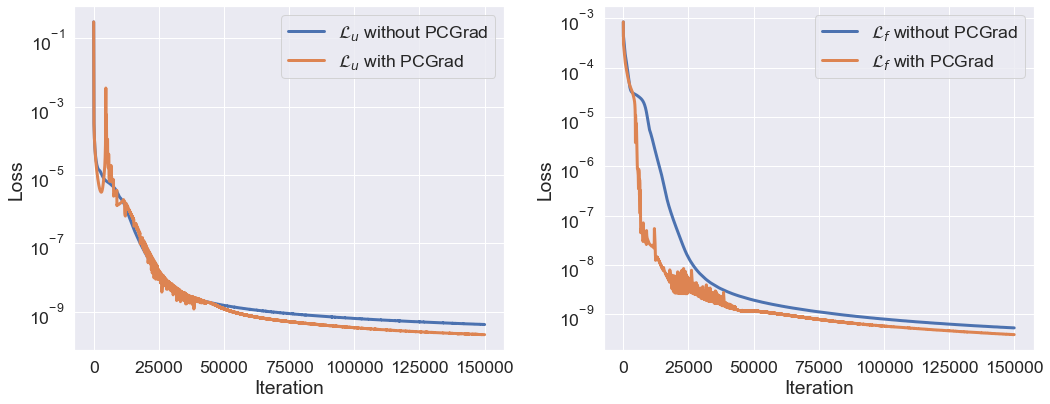

In [57]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = np.sum(pinn_loss_log[:, 1:4], axis = 1).flatten(),  linewidth = 3, 
             label = "$\mathcal{L}_f$ without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = np.sum(pinn_pcgrad_loss_log[:, 1:4], axis = 1).flatten(), 
             linewidth = 3, label = "$\mathcal{L}_f$ with PCGrad", ax = axes[1])

axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("performance_comparison_non_homo.pdf")

#### Solution quality comparison

In [16]:
matlab_solver_solution_df = pd.read_csv('nonHomo_300.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [17]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [18]:
matlab_solver_solution_df

state_0   state_1   state_2
0    0.999040  0.000418  0.000544
1    0.998080  0.000837  0.001087
2    0.997110  0.001255  0.001631
3    0.996150  0.001674  0.002175
4    0.995190  0.002092  0.002718
..        ...       ...       ...
295  0.000013  0.000272  0.999720
296  0.000012  0.000257  0.999730
297  0.000011  0.000242  0.999750
298  0.000010  0.000228  0.999760
299  0.000010  0.000215  0.999780

[300 rows x 3 columns]

In [19]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

n_star = 300+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
x_star_normalized = (x_star-mu)/sigma

In [20]:
y_pred = PINN_solver.model(x_star_normalized)
y_pred_pcgrad = PINN_solver_pcgrad.model(x_star_normalized)

In [21]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

In [22]:
sns.set_style("white")

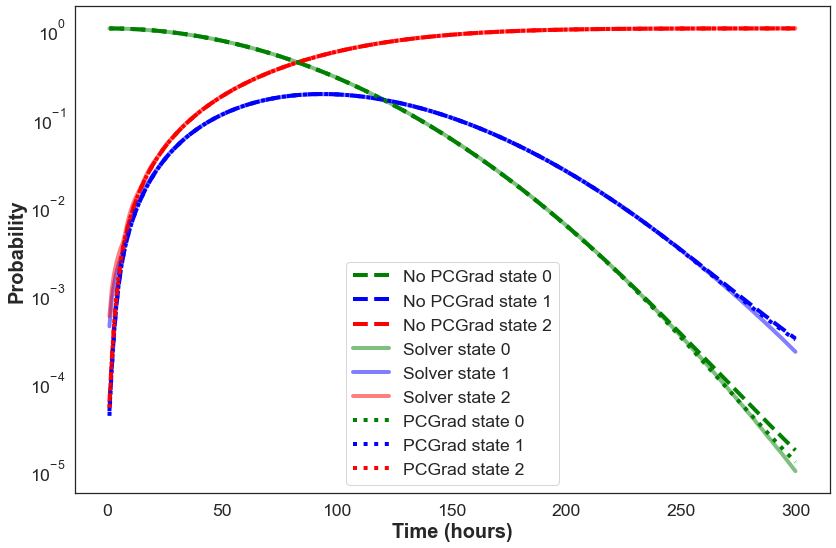

In [55]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'No PCGrad state 0', linewidth = 4, color = 'green', 
             linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'No PCGrad state 1', linewidth = 4, color = 'blue', 
             linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'No PCGrad state 2', linewidth = 4, color = 'red', 
             linestyle='--', ax=ax)

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], label = 'Solver state 0', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], label = 'Solver state 1', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], label = 'Solver state 2', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)

sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'PCGrad state 0', color = 'green', linestyle='dotted',
             linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'PCGrad state 1', color = 'blue', linestyle='dotted',
             linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'PCGrad state 2', color = 'red', linestyle='dotted',
             linewidth = 4, ax=ax)


ax.set_yscale("log")
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=20)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=20)

plt.tight_layout()
plt.savefig("comparison_non_homo.pdf")

In [24]:
y_pred_df.tail()

state_0   state_1   state_2
295  0.000021  0.000363  0.999616
296  0.000020  0.000347  0.999633
297  0.000018  0.000332  0.999649
298  0.000017  0.000318  0.999665
299  0.000016  0.000304  0.999679

In [25]:
y_pred_pcgrad_df.tail()

state_0   state_1   state_2
295  0.000015  0.000349  0.999636
296  0.000015  0.000334  0.999651
297  0.000014  0.000320  0.999666
298  0.000013  0.000307  0.999680
299  0.000012  0.000295  0.999693

In [26]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

In [27]:
y_diff

state_0   state_1   state_2
0   -0.000857  0.000373  0.000486
1   -0.001609  0.000698  0.000915
2   -0.002125  0.000913  0.001208
3   -0.002299  0.000980  0.001318
4   -0.002122  0.000892  0.001231
..        ...       ...       ...
295 -0.000008 -0.000091  0.000104
296 -0.000008 -0.000091  0.000097
297 -0.000007 -0.000090  0.000101
298 -0.000007 -0.000089  0.000095
299 -0.000007 -0.000089  0.000101

[300 rows x 3 columns]

#### Generate histogram of prediction difference with respect to each state

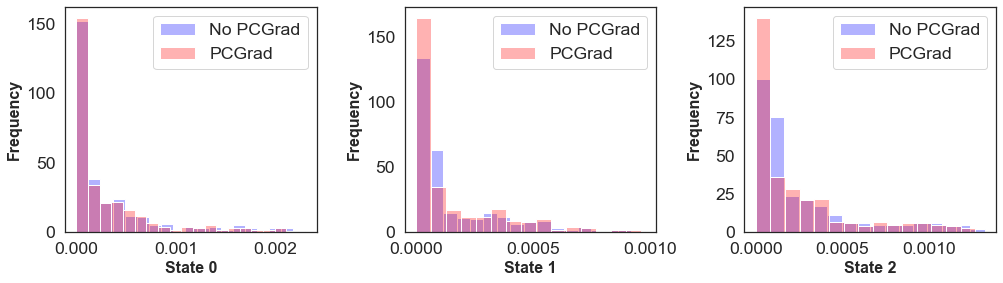

In [53]:
f, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(np.abs(y_diff['state_0']), ax=axes[0], alpha =0.3, color='blue', label='No PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_0']), ax=axes[0], alpha =0.3, color='red', label='PCGrad')

axes[0].legend()
axes[0].set_xlabel('State 0', fontdict=dict(weight='bold'), fontsize=16)
axes[0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff['state_1']), ax=axes[1], alpha=0.3, color='blue', label='No PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_1']), alpha=0.3, ax=axes[1], color='red', label='PCGrad')
axes[1].legend()
axes[1].set_xlabel('State 1', fontdict=dict(weight='bold'), fontsize=16)
axes[1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

sns.histplot(np.abs(y_diff['state_2']), ax=axes[2], alpha=0.3, color='blue', label='No PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_2']), alpha=0.3, ax=axes[2], color='red', label='PCGrad')
axes[2].legend()
axes[2].set_xlabel('State 2', fontdict=dict(weight='bold'), fontsize=16)
axes[2].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout(pad=0.5)
plt.savefig("histogram_small_non_homo.pdf")

#### Compare RMSE

In [28]:
y_diff['mse'] = y_diff.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [29]:
y_diff.head()

state_0   state_1   state_2       mse      rmse
0 -0.000857  0.000373  0.000486  0.000001  0.001053
1 -0.001609  0.000698  0.000915  0.000004  0.001978
2 -0.002125  0.000913  0.001208  0.000007  0.002609
3 -0.002299  0.000980  0.001318  0.000008  0.002825
4 -0.002122  0.000892  0.001231  0.000007  0.002610

In [30]:
y_diff_pcgrad.head()

state_0   state_1   state_2       mse      rmse
0 -0.000870  0.000378  0.000494  0.000001  0.001069
1 -0.001613  0.000701  0.000917  0.000004  0.001984
2 -0.002097  0.000906  0.001187  0.000007  0.002575
3 -0.002227  0.000962  0.001264  0.000007  0.002736
4 -0.002021  0.000871  0.001151  0.000006  0.002483

In [31]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.00048298887850545307
RMSE of PINN with PCGrad is 0.00045540318115732927
